In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [2]:
from kaggle_datasets import KaggleDatasets

In [3]:
import os
import shutil

# Define dataset paths
dataset_path = "/kaggle/working/dataset"
train_path = os.path.join(dataset_path, "train")

# Create the directories if they don't exist
os.makedirs(train_path, exist_ok=True)

print(f"Created: {train_path}")


Created: /kaggle/working/dataset/train


In [4]:
# Define source and destination paths
source_path = "/kaggle/input/reduced-lung-disease-dataset"

# Copy the dataset
shutil.copytree(source_path, train_path, dirs_exist_ok=True)

print("Dataset copied successfully!")


Dataset copied successfully!


In [ ]:
!ls -R /kaggle/working/dataset/train

In [5]:
# Set dataset directory path
data_dir = "/kaggle/working/dataset/train"

# Define disease categories
categories = ["Covid", "Normal", "Pneumothorax", "Tuberculosis", "Viral Pneumonia"]

# Function to load images and masks
def load_dataset(data_dir, categories, img_size=(128, 128)):
    X = []  # Image data
    Y = []  # Labels
    masks = []  # Mask data
    valid_extensions = (".png", ".jpg", ".jpeg")  # Allowed image formats
    
    for idx, category in enumerate(categories):
        img_folder = os.path.join(data_dir, category, "images")  # Image path
        mask_folder = os.path.join(data_dir, category, "masks")  # Mask path

        if not os.path.exists(img_folder) or not os.path.exists(mask_folder):
            print(f"Warning: {img_folder} or {mask_folder} does not exist.")
            continue
        
        img_files = sorted(os.listdir(img_folder))  # Sort to match masks
        mask_files = sorted(os.listdir(mask_folder))  # Sort to align with images

        for img_name, mask_name in zip(img_files, mask_files):
            img_path = os.path.join(img_folder, img_name)
            mask_path = os.path.join(mask_folder, mask_name)

            # Skip non-image files
            if not img_name.lower().endswith(valid_extensions) or not mask_name.lower().endswith(valid_extensions):
                print(f"Skipping non-image file: {img_path} or {mask_path}")
                continue

            try:
                # Read and preprocess image
                img = cv2.imread(img_path)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Grayscale mask

                if img is None or mask is None:
                    print(f"Skipping unreadable file: {img_path} or {mask_path}")
                    continue

                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)
                mask = cv2.resize(mask, img_size)

                # Normalize and append
                X.append(img / 255.0)  # Normalize image
                masks.append(mask / 255.0)  # Normalize mask
                Y.append(idx)  # Append label index
            except Exception as e:
                print(f"Error loading {img_path} or {mask_path}: {e}")

    X = np.array(X, dtype="float32")
    masks = np.array(masks, dtype="float32").reshape(-1, img_size[0], img_size[1], 1)  # Add channel dimension
    Y = np.array(Y)
    Y = to_categorical(Y, num_classes=len(categories))  # One-hot encoding

    return X, masks, Y

# Load dataset
X, masks, Y = load_dataset(data_dir, categories, img_size=(128, 128))

# Print dataset shape
print(f"Dataset loaded: Images {X.shape}, Masks {masks.shape}, Labels {Y.shape}")

Dataset loaded: Images (6204, 128, 128, 3), Masks (6204, 128, 128, 1), Labels (6204, 5)


In [6]:
### 📌 Train-Test-Validation Split (70-15-15)
X_train, X_temp, Y_train, Y_temp, masks_train, masks_temp = train_test_split(
    X, Y, masks, test_size=0.30, random_state=42, stratify=Y
)
X_val, X_test, Y_val, Y_test, masks_val, masks_test = train_test_split(
    X_temp, Y_temp, masks_temp, test_size=0.50, random_state=42, stratify=Y_temp
)

print(f"Training Set: {X_train.shape}, {Y_train.shape}, {masks_train.shape}")
print(f"Validation Set: {X_val.shape}, {Y_val.shape}, {masks_val.shape}")
print(f"Test Set: {X_test.shape}, {Y_test.shape}, {masks_test.shape}")

Training Set: (4342, 128, 128, 3), (4342, 5), (4342, 128, 128, 1)
Validation Set: (931, 128, 128, 3), (931, 5), (931, 128, 128, 1)
Test Set: (931, 128, 128, 3), (931, 5), (931, 128, 128, 1)


In [6]:
### 📌 Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Function to augment images and masks
def augment_images(X_train, Y_train, masks_train, num_augmented=3):
    augmented_X = []
    augmented_Y = []
    augmented_masks = []

    for i in range(len(X_train)):
        img = X_train[i]
        label = Y_train[i]
        mask = masks_train[i]

        img = np.expand_dims(img, axis=0)  # Add batch dimension
        mask = np.expand_dims(mask, axis=0)

        it = datagen.flow(img, batch_size=1, seed=42)
        mask_it = datagen.flow(mask, batch_size=1, seed=42)

        for _ in range(num_augmented):
            aug_img = next(it)[0]  # Fixed: Using next() instead of it.next()
            aug_mask = next(mask_it)[0]

            augmented_X.append(aug_img)
            augmented_Y.append(label)
            augmented_masks.append(aug_mask)

    return np.array(augmented_X), np.array(augmented_Y), np.array(augmented_masks)

# Apply augmentation
aug_X, aug_Y, aug_masks = augment_images(X_train, Y_train, masks_train, num_augmented=2)

# Concatenate original + augmented data
X_train_aug = np.concatenate((X_train, aug_X), axis=0)
Y_train_aug = np.concatenate((Y_train, aug_Y), axis=0)
masks_train_aug = np.concatenate((masks_train, aug_masks), axis=0)

print(f"After Augmentation: Training Set {X_train_aug.shape}, {Y_train_aug.shape}, {masks_train_aug.shape}")

After Augmentation: Training Set (13026, 128, 128, 3), (13026, 5), (13026, 128, 128, 1)


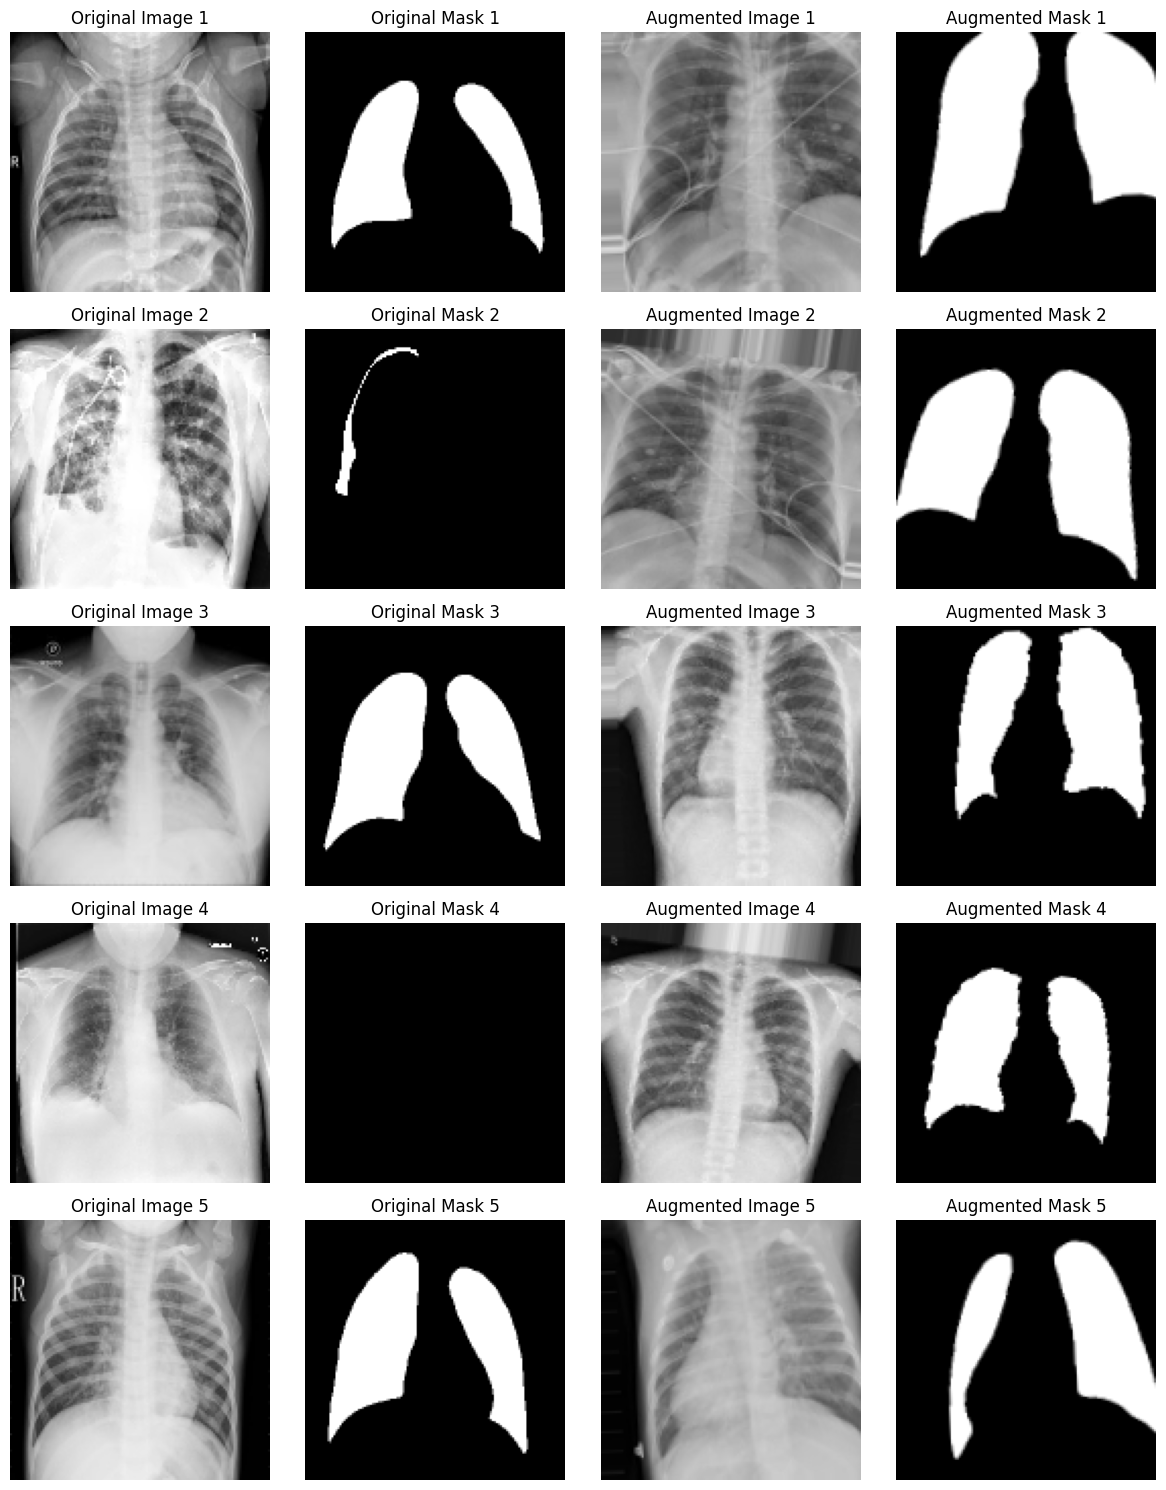

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_image_mask_pairs(original_images, augmented_images, original_masks, augmented_masks, n=5):
    """
    Function to plot pairs of original and augmented images and masks side by side for comparison.
    
    Parameters:
    original_images (array): Original images
    augmented_images (array): Augmented images
    original_masks (array): Original masks
    augmented_masks (array): Augmented masks
    n (int): Number of samples to display
    """
    # Randomly choose n samples from the datasets
    indices = np.random.randint(0, len(original_images), n)
    
    # Create subplots to display images and masks
    fig, axs = plt.subplots(n, 4, figsize=(12, n * 3))
    
    for i, idx in enumerate(indices):
        # Original image and mask
        axs[i, 0].imshow(original_images[idx])
        axs[i, 0].set_title(f"Original Image {i+1}")
        axs[i, 0].axis('off')
        
        axs[i, 1].imshow(original_masks[idx].reshape(original_masks[idx].shape[0], original_masks[idx].shape[1]), cmap='gray')
        axs[i, 1].set_title(f"Original Mask {i+1}")
        axs[i, 1].axis('off')
        
        # Corresponding augmented image and mask
        axs[i, 2].imshow(augmented_images[i])  # Augmented image corresponding to this index
        axs[i, 2].set_title(f"Augmented Image {i+1}")
        axs[i, 2].axis('off')
        
        axs[i, 3].imshow(augmented_masks[i].reshape(augmented_masks[i].shape[0], augmented_masks[i].shape[1]), cmap='gray')
        axs[i, 3].set_title(f"Augmented Mask {i+1}")
        axs[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to plot 5 random samples from the training set
plot_image_mask_pairs(X_train, aug_X, masks_train, aug_masks, n=5)


In [8]:
# Check the shape of original images, original masks, augmented images, and augmented masks
print("Original Images Shape:", X_train.shape)
print("Original Masks Shape:", masks_train.shape)
print("Augmented Images Shape:", aug_X.shape)
print("Augmented Masks Shape:", aug_masks.shape)


Original Images Shape: (4342, 128, 128, 3)
Original Masks Shape: (4342, 128, 128, 1)
Augmented Images Shape: (8684, 128, 128, 3)
Augmented Masks Shape: (8684, 128, 128, 1)


In [11]:
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coefficient(y_true, y_pred):
    smooth = 1e-6
    intersection = K.sum(y_true * y_pred)
    return 2 * intersection / (K.sum(y_true) + K.sum(y_pred) + smooth)

def jaccard_index(y_true, y_pred):
    smooth = 1e-6
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return intersection / (union + smooth)


In [12]:
import tensorflow as tf
from tensorflow.keras import layers

def conv_block(x, filters, kernel_size=3, strides=1):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def multi_res_block(x, filters, kernel_size=3):
    # First resolution
    x1 = conv_block(x, filters, kernel_size)
    
    # Second resolution (dilated convolution)
    x2 = conv_block(x, filters, kernel_size, strides=2)
    
    # Third resolution (pooled convolution)
    x3 = conv_block(x, filters, kernel_size, strides=4)
    
    # Upsample all the branches to the same size
    x2 = layers.UpSampling2D(size=(2, 2))(x2)  # Upsample to match x1
    x3 = layers.UpSampling2D(size=(4, 4))(x3)  # Upsample to match x1
    
    # Concatenate all the resolutions
    x = layers.concatenate([x1, x2, x3], axis=-1)
    return x


In [13]:
def MultiResUnet(input_shape=(128, 128, 3), num_classes=1):
    inputs = layers.Input(shape=input_shape)

    # Encoder: Downsampling with MultiRes Blocks
    x = multi_res_block(inputs, 64)
    x = layers.MaxPooling2D(pool_size=2)(x)
    
    x = multi_res_block(x, 128)
    x = layers.MaxPooling2D(pool_size=2)(x)
    
    x = multi_res_block(x, 256)
    x = layers.MaxPooling2D(pool_size=2)(x)

    # Bottleneck
    x = multi_res_block(x, 512)

    # Decoder: Upsampling
    x = layers.UpSampling2D(size=2)(x)
    x = multi_res_block(x, 256)

    x = layers.UpSampling2D(size=2)(x)
    x = multi_res_block(x, 128)

    x = layers.UpSampling2D(size=2)(x)
    x = multi_res_block(x, 64)

    # Output Layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(x)

    # Create the Model
    model = tf.keras.models.Model(inputs, outputs)
    return model


In [14]:
# Compile the model with custom metrics
model = MultiResUnet(input_shape=(128, 128, 3), num_classes=1)

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', dice_coefficient, jaccard_index])

In [16]:
# Train the model
history = model.fit(
    aug_X, aug_masks, 
    validation_split=0.15,
    epochs=20,
    batch_size=16,
)

Epoch 1/20
462/462 ━━━━━━━━━━━━━━━━━━━━ 338s 609ms/step - accuracy: 0.8543 - dice_coefficient: 0.6097 - jaccard_index: 0.4531 - loss: 0.2952 - val_accuracy: 0.8637 - val_dice_coefficient: 0.6357 - val_jaccard_index: 0.4710 - val_loss: 0.2965
Epoch 2/20
462/462 ━━━━━━━━━━━━━━━━━━━━ 247s 534ms/step - accuracy: 0.9282 - dice_coefficient: 0.8046 - jaccard_index: 0.6748 - loss: 0.1271 - val_accuracy: 0.9148 - val_dice_coefficient: 0.7658 - val_jaccard_index: 0.6245 - val_loss: 0.1514
Epoch 3/20
462/462 ━━━━━━━━━━━━━━━━━━━━ 245s 531ms/step - accuracy: 0.9366 - dice_coefficient: 0.8379 - jaccard_index: 0.7229 - loss: 0.1041 - val_accuracy: 0.8635 - val_dice_coefficient: 0.5716 - val_jaccard_index: 0.4076 - val_loss: 0.4072
Epoch 4/20
462/462 ━━━━━━━━━━━━━━━━━━━━ 246s 533ms/step - accuracy: 0.9404 - dice_coefficient: 0.8578 - jaccard_index: 0.7525 - loss: 0.0931 - val_accuracy: 0.8701 - val_dice_coefficient: 0.6105 - val_jaccard_index: 0.4458 - val_loss: 0.3227
Epoch 5/20
462/462 ━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


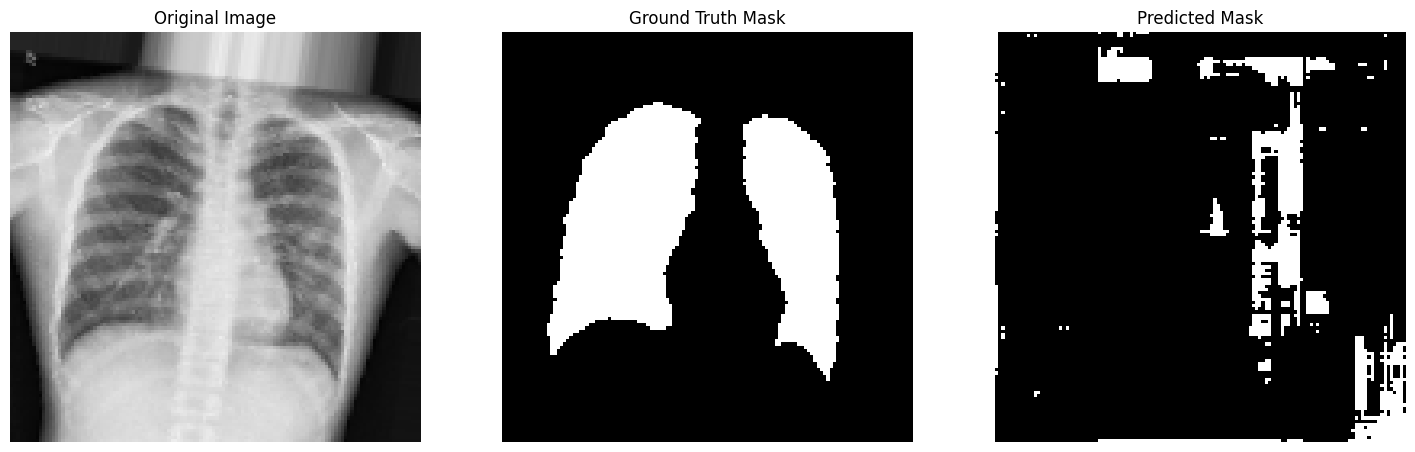

Dice Coefficient: 0.2096
Jaccard Index: 0.1171


In [21]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import jaccard_score

# Sample image from the validation set (e.g., pick the first one)
sample_image = aug_X[3]  # Replace with your test set or image to predict
ground_truth_mask = aug_masks[3]  # Corresponding ground truth mask

# Expand the sample image dimension (add batch dimension)
sample_image = np.expand_dims(sample_image, axis=0)

# Predict the mask using the trained model
predicted_mask = model.predict(sample_image)

# Squeeze the predicted mask to remove the extra dimension
predicted_mask = np.squeeze(predicted_mask, axis=0)

# Check and squeeze the ground truth mask if necessary
if len(ground_truth_mask.shape) > 2:
    ground_truth_mask = np.squeeze(ground_truth_mask, axis=-1)

# Threshold the predicted mask to convert it to binary (0 or 1)
thresholded_predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

# Threshold the ground truth mask to convert it to binary (0 or 1)
thresholded_ground_truth_mask = (ground_truth_mask > 0.5).astype(np.uint8)

# Plotting the original image, ground truth mask, and predicted mask
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Original image
axs[0].imshow(sample_image[0])  # Displaying the image
axs[0].set_title("Original Image")
axs[0].axis("off")

# Ground truth mask
axs[1].imshow(thresholded_ground_truth_mask, cmap="gray")  # Displaying the mask
axs[1].set_title("Ground Truth Mask")
axs[1].axis("off")

# Predicted mask
axs[2].imshow(thresholded_predicted_mask, cmap="gray")  # Displaying the predicted mask
axs[2].set_title("Predicted Mask")
axs[2].axis("off")

plt.show()

# Evaluate metrics (Dice and Jaccard)
# Flatten the masks for evaluation
flattened_ground_truth = thresholded_ground_truth_mask.flatten()
flattened_predicted = thresholded_predicted_mask.flatten()

# Calculate Dice coefficient
dice = 2 * np.sum(flattened_ground_truth * flattened_predicted) / (np.sum(flattened_ground_truth) + np.sum(flattened_predicted))

# Calculate Jaccard index
jaccard = jaccard_score(flattened_ground_truth, flattened_predicted)

print(f"Dice Coefficient: {dice:.4f}")
print(f"Jaccard Index: {jaccard:.4f}")


In [67]:
# Save the model after training
model.save('/kaggle/working/multires_unet.h5')

print("Model saved successfully!")

Model saved successfully!


In [20]:
from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model('/kaggle/input/multiresunet/tensorflow2/default/1/multires_unet.h5', custom_objects={'dice_coefficient': dice_coefficient, 'jaccard_index': jaccard_index})

print("Model loaded successfully!")

Model loaded successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


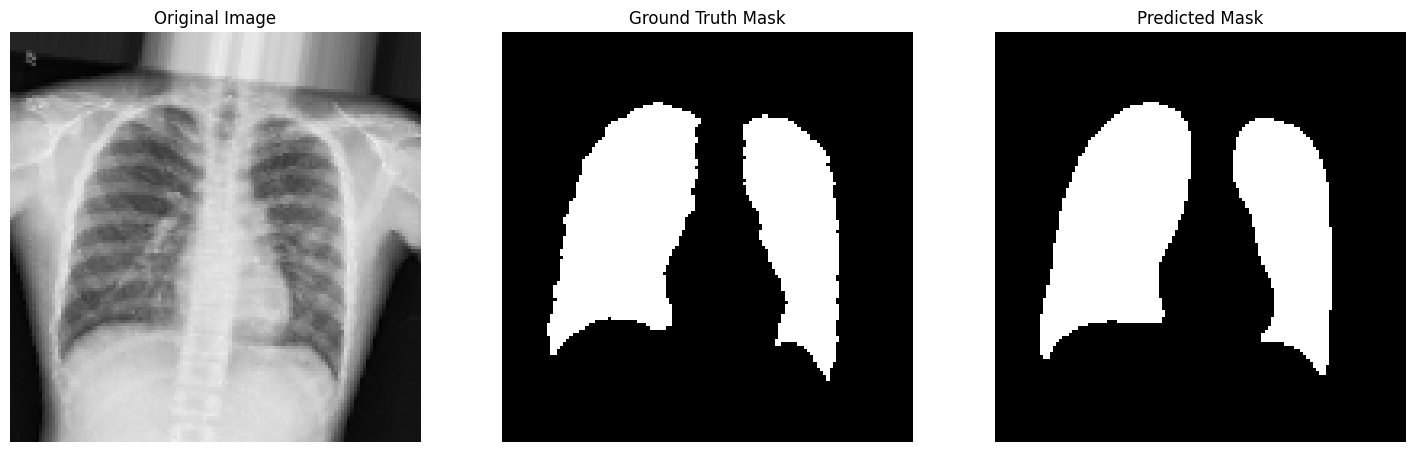

Dice Coefficient: 0.9726
Jaccard Index: 0.9466


In [9]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from sklearn.metrics import jaccard_score

# Load the trained MultiRes U-Net model
model_path = "/kaggle/input/multiresunet/tensorflow2/default/1/multires_unet.h5"  # Update path if needed
model = load_model(model_path, compile=False)

# Select a sample image and its corresponding ground truth mask
sample_idx = 3  # Choose any index
sample_image = aug_X[sample_idx]  # Replace with your test/validation set
ground_truth_mask = aug_masks[sample_idx]  # Corresponding mask

# Ensure the image has the correct shape
sample_image = np.expand_dims(sample_image, axis=0)  # Add batch dimension

# Predict the mask using the trained model
predicted_mask = model.predict(sample_image)

# Remove batch dimension
predicted_mask = np.squeeze(predicted_mask, axis=0)

# Squeeze the ground truth mask if necessary
if len(ground_truth_mask.shape) > 2:
    ground_truth_mask = np.squeeze(ground_truth_mask, axis=-1)

# Convert masks to binary (thresholding)
thresholded_predicted_mask = (predicted_mask > 0.5).astype(np.uint8)
thresholded_ground_truth_mask = (ground_truth_mask > 0.5).astype(np.uint8)

# Plot the results
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Original Image
axs[0].imshow(sample_image[0])  # Show original image
axs[0].set_title("Original Image")
axs[0].axis("off")

# Ground Truth Mask
axs[1].imshow(thresholded_ground_truth_mask, cmap="gray")
axs[1].set_title("Ground Truth Mask")
axs[1].axis("off")

# Predicted Mask
axs[2].imshow(thresholded_predicted_mask, cmap="gray")
axs[2].set_title("Predicted Mask")
axs[2].axis("off")

plt.show()

# Evaluate segmentation performance using Dice and Jaccard metrics
flattened_ground_truth = thresholded_ground_truth_mask.flatten()
flattened_predicted = thresholded_predicted_mask.flatten()

# Compute Dice coefficient
dice = 2 * np.sum(flattened_ground_truth * flattened_predicted) / (np.sum(flattened_ground_truth) + np.sum(flattened_predicted))

# Compute Jaccard index
jaccard = jaccard_score(flattened_ground_truth, flattened_predicted)

print(f"Dice Coefficient: {dice:.4f}")
print(f"Jaccard Index: {jaccard:.4f}")


In [21]:
import shutil
shutil.copy('/kaggle/working/lung_disease_segmentation_model.h5', '/kaggle/working/lung_disease_segmentation_model_backup.h5')


'/kaggle/working/lung_disease_segmentation_model_backup.h5'

In [23]:
import os
import cv2
import numpy as np

def save_augmented_images(augmented_X, augmented_Y, augmented_masks, image_folder, mask_folder, num_augmented=2):
    # Ensure the directories exist
    if not os.path.exists(image_folder):
        os.makedirs(image_folder)
    if not os.path.exists(mask_folder):
        os.makedirs(mask_folder)

    for i in range(len(augmented_X)):
        # Save the augmented images
        augmented_img = augmented_X[i]
        filename = f"augmented_img_{i}.png"
        img_path = os.path.join(image_folder, filename)
        cv2.imwrite(img_path, (augmented_img * 255).astype(np.uint8))  # Save the image (scale to 0-255)

        # Save the augmented masks
        augmented_mask = augmented_masks[i]
        mask_filename = f"augmented_mask_{i}.png"
        mask_path = os.path.join(mask_folder, mask_filename)
        cv2.imwrite(mask_path, (augmented_mask.squeeze() * 255).astype(np.uint8))  # Save the mask

    print(f"Augmented images and masks saved to {image_folder} and {mask_folder}")

# Directories to store augmented images and masks
image_output_dir = "dataset/augmented_images"
mask_output_dir = "dataset/augmented_masks"

# Save augmented data
save_augmented_images(aug_X, aug_Y, aug_masks, image_output_dir, mask_output_dir)


Augmented images and masks saved to dataset/augmented_images and dataset/augmented_masks


In [77]:
import shutil
import os

def delete_folder(folder_path):
    if os.path.exists(folder_path) and os.path.isdir(folder_path):
        shutil.rmtree(folder_path)  # Deletes the folder and all its contents
        print(f"Folder {folder_path} deleted successfully.")
    else:
        print(f"Folder {folder_path} does not exist.")

# Example usage
folder_to_delete = "segmented_original"
delete_folder(folder_to_delete)


Folder segmented_original deleted successfully.


In [24]:
import os

def count_files_in_folder(folder_path, file_extension='.png'):  # You can modify the extension if needed
    # List all files in the folder and filter by extension
    files = [f for f in os.listdir(folder_path) if f.endswith(file_extension)]
    return len(files)

# Paths to the folders containing augmented images and masks
augmented_images_folder = "dataset/augmented_images"
augmented_masks_folder = "dataset/augmented_masks"

# Count images and masks in their respective folders
image_count = count_files_in_folder(augmented_images_folder, file_extension='.png')  # Change extension if needed
mask_count = count_files_in_folder(augmented_masks_folder, file_extension='.png')  # Change extension if needed

print(f"Number of images in the augmented images folder: {image_count}")
print(f"Number of masks in the augmented masks folder: {mask_count}")


Number of images in the augmented images folder: 8684
Number of masks in the augmented masks folder: 8684


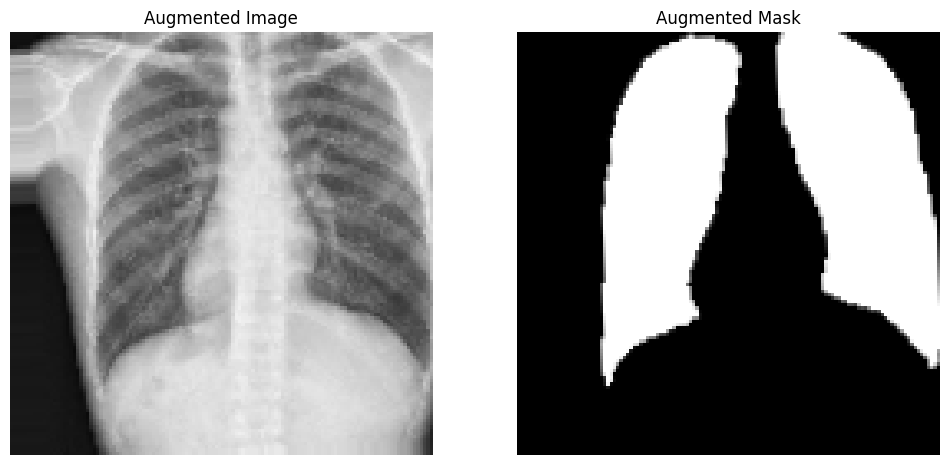

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Randomly select an index from the augmented images
index = np.random.randint(0, len(aug_X))

# Get the augmented image and its corresponding mask
augmented_image = aug_X[index]
augmented_mask = aug_masks[index]

# Plot the augmented image and its corresponding mask
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display the augmented image
axes[0].imshow(augmented_image)
axes[0].set_title("Augmented Image")
axes[0].axis("off")

# Display the augmented mask
axes[1].imshow(augmented_mask.squeeze(), cmap='gray')
axes[1].set_title("Augmented Mask")
axes[1].axis("off")

plt.show()


In [26]:
import shutil
import os

# Paths to the folders containing augmented images and masks
augmented_images_folder = "dataset/augmented_images"
augmented_masks_folder = "dataset/augmented_masks"

# Compress the folders into zip files
shutil.make_archive('/kaggle/working/augmented_images', 'zip', augmented_images_folder)
shutil.make_archive('/kaggle/working/augmented_masks', 'zip', augmented_masks_folder)

print("Folders compressed to .zip")


Folders compressed to .zip


In [33]:
import gc
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import os
from tqdm import tqdm
from glob import glob

# Load the trained MultiRes U-Net model
model_path = "/kaggle/input/multiresunet/tensorflow2/default/1/multires_unet.h5"  # Update if needed
model = load_model(model_path, compile=False)  # Load without compiling (to avoid re-compiling)

# Define dataset directories
augmented_images_folder = "/kaggle/working/dataset/augmented_images"  # Augmented images
augmented_masks_folder = "/kaggle/working/dataset/augmented_masks"    # Augmented masks (ground truth)
segmented_images_folder = "/kaggle/working/dataset/segmented_images"  # Save segmented images
segmented_masks_folder = "/kaggle/working/dataset/segmented_masks"    # Save segmented masks

# Create folders if they don’t exist
os.makedirs(segmented_images_folder, exist_ok=True)
os.makedirs(segmented_masks_folder, exist_ok=True)

In [34]:
# Function to segment a single image
def segment_image(image_path, model, target_size=(128, 128)):
    """Loads an image, segments it using the model, and returns the segmented mask."""
    image = cv2.imread(image_path)
    image = cv2.resize(image, target_size)
    image = image / 255.0  # Normalize

    # Expand dimensions to match model input
    image = np.expand_dims(image, axis=0)

    # Predict the mask
    predicted_mask = model.predict(image)[0]

    # Convert to binary mask (Thresholding)
    binary_mask = (predicted_mask > 0.5).astype(np.uint8) * 255  # Convert to 0-255 range

    return binary_mask

In [ ]:
# Function to segment both augmented images and augmented masks
def segment_augmented_data():
    """Segments augmented images & masks, saving them directly in segmented_images & segmented_masks folders."""
    
    for folder_type, input_folder, output_folder in [
        ("images", augmented_images_folder, segmented_images_folder),
        ("masks", augmented_masks_folder, segmented_masks_folder)
    ]:
        image_paths = sorted(glob(os.path.join(input_folder, "**", "*.png"), recursive=True))  # Get all images

        for i, img_path in enumerate(tqdm(image_paths, desc=f"Segmenting {folder_type}")):
            segmented_mask = segment_image(img_path, model)

            # Save file with consistent naming
            save_path = os.path.join(output_folder, f"segmented_{folder_type}_{i+1:04d}.png")
            cv2.imwrite(save_path, segmented_mask)

            # Clear variables and force garbage collection after each image to free up memory
            del segmented_mask
            gc.collect()

# Run segmentation for both augmented images and masks
segment_augmented_data()

print(f"✅ Segmentation completed! Segmented images saved in '{segmented_images_folder}/' and masks in '{segmented_masks_folder}/'")

Segmenting images:   0%|          | 0/8684 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Segmenting images:   0%|          | 1/8684 [00:02<5:17:55,  2.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   0%|          | 2/8684 [00:02<2:34:30,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   0%|          | 3/8684 [00:02<1:41:54,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   0%|          | 4/8684 [00:03<1:17:20,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   0%|          | 5/8684 [00:03<1:03:37,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   0%|          | 6/8684 [00:03<55:16,  2.62it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   0%|          | 7/8684 [00:03<49:56,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   0%|          | 8/8684 [00:04<46:20,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   0%|          | 9/8684 [00:04<44:29,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   0%|          | 10/8684 [00:04<42:42,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:   0%|          | 11/8684 [00:04<41:58,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   0%|          | 12/8684 [00:05<41:16,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   0%|          | 13/8684 [00:05<40:39,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   0%|          | 14/8684 [00:05<40:23,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   0%|          | 15/8684 [00:06<40:11,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   0%|          | 16/8684 [00:06<40:00,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   0%|          | 17/8684 [00:06<39:36,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   0%|          | 18/8684 [00:06<39:35,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   0%|          | 19/8684 [00:07<39:51,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   0%|          | 20/8684 [00:07<39:45,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   0%|          | 21/8684 [00:07<39:30,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   0%|          | 22/8684 [00:07<39:31,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   0%|          | 23/8684 [00:08<39:12,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   0%|          | 24/8684 [00:08<39:20,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   0%|          | 25/8684 [00:08<39:17,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   0%|          | 26/8684 [00:09<39:11,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   0%|          | 27/8684 [00:09<39:29,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:   0%|          | 28/8684 [00:09<40:17,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Segmenting images:   0%|          | 29/8684 [00:09<41:49,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   0%|          | 30/8684 [00:10<40:54,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   0%|          | 31/8684 [00:10<40:30,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   0%|          | 32/8684 [00:10<39:57,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   0%|          | 33/8684 [00:10<39:48,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   0%|          | 34/8684 [00:11<39:33,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   0%|          | 35/8684 [00:11<39:10,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   0%|          | 36/8684 [00:11<39:21,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   0%|          | 37/8684 [00:12<39:14,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   0%|          | 38/8684 [00:12<39:04,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   0%|          | 39/8684 [00:12<38:42,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   0%|          | 40/8684 [00:12<38:44,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   0%|          | 41/8684 [00:13<38:43,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   0%|          | 42/8684 [00:13<38:40,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   0%|          | 43/8684 [00:13<38:24,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   1%|          | 44/8684 [00:13<38:53,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   1%|          | 45/8684 [00:14<38:58,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   1%|          | 46/8684 [00:14<38:52,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   1%|          | 47/8684 [00:14<38:57,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   1%|          | 48/8684 [00:15<38:51,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   1%|          | 49/8684 [00:15<39:10,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   1%|          | 50/8684 [00:15<39:07,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   1%|          | 51/8684 [00:15<39:03,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:   1%|          | 52/8684 [00:16<39:27,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   1%|          | 53/8684 [00:16<39:28,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   1%|          | 54/8684 [00:16<39:00,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   1%|          | 55/8684 [00:16<38:49,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   1%|          | 56/8684 [00:17<38:46,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   1%|          | 57/8684 [00:17<38:49,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   1%|          | 58/8684 [00:17<38:42,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   1%|          | 59/8684 [00:18<38:38,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   1%|          | 60/8684 [00:18<38:53,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   1%|          | 61/8684 [00:18<38:50,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   1%|          | 62/8684 [00:18<39:19,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   1%|          | 63/8684 [00:19<39:05,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   1%|          | 64/8684 [00:19<39:11,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   1%|          | 65/8684 [00:19<39:07,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   1%|          | 66/8684 [00:19<39:56,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   1%|          | 67/8684 [00:20<39:20,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:   1%|          | 68/8684 [00:20<39:12,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   1%|          | 69/8684 [00:20<38:48,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   1%|          | 70/8684 [00:21<38:39,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   1%|          | 71/8684 [00:21<38:32,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   1%|          | 72/8684 [00:21<38:44,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   1%|          | 73/8684 [00:21<39:01,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   1%|          | 74/8684 [00:22<38:59,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   1%|          | 75/8684 [00:22<39:00,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   1%|          | 76/8684 [00:22<38:45,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   1%|          | 77/8684 [00:22<38:45,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   1%|          | 78/8684 [00:23<38:39,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   1%|          | 79/8684 [00:23<38:42,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   1%|          | 80/8684 [00:23<38:32,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   1%|          | 81/8684 [00:23<38:39,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   1%|          | 82/8684 [00:24<38:30,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   1%|          | 83/8684 [00:24<38:33,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   1%|          | 84/8684 [00:24<38:35,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   1%|          | 85/8684 [00:25<38:25,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   1%|          | 86/8684 [00:25<38:34,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   1%|          | 87/8684 [00:25<38:27,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   1%|          | 88/8684 [00:25<39:02,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   1%|          | 89/8684 [00:26<39:12,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   1%|          | 90/8684 [00:26<39:03,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   1%|          | 91/8684 [00:26<38:44,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   1%|          | 92/8684 [00:26<38:40,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   1%|          | 93/8684 [00:27<38:42,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   1%|          | 94/8684 [00:27<38:51,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   1%|          | 95/8684 [00:27<38:43,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   1%|          | 96/8684 [00:28<38:50,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   1%|          | 97/8684 [00:28<38:48,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   1%|          | 98/8684 [00:28<38:46,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   1%|          | 99/8684 [00:28<38:55,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   1%|          | 100/8684 [00:29<38:50,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   1%|          | 101/8684 [00:29<39:01,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   1%|          | 102/8684 [00:29<39:18,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   1%|          | 103/8684 [00:29<40:14,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:   1%|          | 104/8684 [00:30<41:39,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:   1%|          | 105/8684 [00:30<41:59,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:   1%|          | 106/8684 [00:30<41:35,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   1%|          | 107/8684 [00:31<41:11,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   1%|          | 108/8684 [00:31<41:05,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:   1%|▏         | 109/8684 [00:31<41:51,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Segmenting images:   1%|▏         | 110/8684 [00:32<41:53,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:   1%|▏         | 111/8684 [00:32<41:50,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   1%|▏         | 112/8684 [00:32<40:58,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:   1%|▏         | 113/8684 [00:32<41:34,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:   1%|▏         | 114/8684 [00:33<41:31,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:   1%|▏         | 115/8684 [00:33<41:39,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:   1%|▏         | 116/8684 [00:33<41:21,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   1%|▏         | 117/8684 [00:34<40:22,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   1%|▏         | 118/8684 [00:34<39:56,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   1%|▏         | 119/8684 [00:34<39:31,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   1%|▏         | 120/8684 [00:34<39:23,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   1%|▏         | 121/8684 [00:35<39:09,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   1%|▏         | 122/8684 [00:35<39:17,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   1%|▏         | 123/8684 [00:35<39:29,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:   1%|▏         | 124/8684 [00:35<40:13,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:   1%|▏         | 125/8684 [00:36<40:35,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:   1%|▏         | 126/8684 [00:36<40:49,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:   1%|▏         | 127/8684 [00:36<40:40,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:   1%|▏         | 128/8684 [00:37<41:02,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:   1%|▏         | 129/8684 [00:37<40:51,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:   1%|▏         | 130/8684 [00:37<40:40,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:   2%|▏         | 131/8684 [00:37<40:28,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   2%|▏         | 132/8684 [00:38<39:42,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   2%|▏         | 133/8684 [00:38<39:38,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:   2%|▏         | 134/8684 [00:38<39:48,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   2%|▏         | 135/8684 [00:39<39:51,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:   2%|▏         | 136/8684 [00:39<39:47,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:   2%|▏         | 137/8684 [00:39<40:01,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   2%|▏         | 138/8684 [00:39<40:45,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   2%|▏         | 139/8684 [00:40<39:59,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   2%|▏         | 140/8684 [00:40<39:26,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   2%|▏         | 141/8684 [00:40<38:59,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   2%|▏         | 142/8684 [00:41<38:55,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:   2%|▏         | 143/8684 [00:41<38:52,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   2%|▏         | 144/8684 [00:41<39:02,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   2%|▏         | 145/8684 [00:41<39:22,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   2%|▏         | 146/8684 [00:42<39:12,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   2%|▏         | 147/8684 [00:42<39:05,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   2%|▏         | 148/8684 [00:42<38:46,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   2%|▏         | 149/8684 [00:42<38:52,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   2%|▏         | 150/8684 [00:43<38:44,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:   2%|▏         | 151/8684 [00:43<39:03,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   2%|▏         | 152/8684 [00:43<39:13,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   2%|▏         | 153/8684 [00:44<39:15,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   2%|▏         | 154/8684 [00:44<38:52,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   2%|▏         | 155/8684 [00:44<38:34,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   2%|▏         | 156/8684 [00:44<38:42,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   2%|▏         | 157/8684 [00:45<38:35,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   2%|▏         | 158/8684 [00:45<38:42,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:   2%|▏         | 159/8684 [00:45<38:49,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   2%|▏         | 160/8684 [00:45<39:07,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   2%|▏         | 161/8684 [00:46<38:51,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   2%|▏         | 162/8684 [00:46<38:57,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   2%|▏         | 163/8684 [00:46<38:55,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   2%|▏         | 164/8684 [00:47<38:42,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   2%|▏         | 165/8684 [00:47<38:55,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   2%|▏         | 166/8684 [00:47<38:59,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   2%|▏         | 167/8684 [00:47<38:54,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   2%|▏         | 168/8684 [00:48<38:48,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   2%|▏         | 169/8684 [00:48<38:47,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   2%|▏         | 170/8684 [00:48<38:43,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   2%|▏         | 171/8684 [00:48<38:50,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   2%|▏         | 172/8684 [00:49<38:53,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   2%|▏         | 173/8684 [00:49<39:14,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:   2%|▏         | 174/8684 [00:49<40:07,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   2%|▏         | 175/8684 [00:50<40:11,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   2%|▏         | 176/8684 [00:50<39:40,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   2%|▏         | 177/8684 [00:50<38:59,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   2%|▏         | 178/8684 [00:50<38:45,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   2%|▏         | 179/8684 [00:51<38:30,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   2%|▏         | 180/8684 [00:51<38:21,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:   2%|▏         | 181/8684 [00:51<39:19,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Segmenting images:   2%|▏         | 182/8684 [00:52<39:37,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   2%|▏         | 183/8684 [00:52<39:20,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   2%|▏         | 184/8684 [00:52<39:01,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   2%|▏         | 185/8684 [00:52<38:58,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   2%|▏         | 186/8684 [00:53<39:22,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:   2%|▏         | 187/8684 [00:53<39:27,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   2%|▏         | 188/8684 [00:53<39:26,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   2%|▏         | 189/8684 [00:53<39:12,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   2%|▏         | 190/8684 [00:54<38:48,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   2%|▏         | 191/8684 [00:54<38:36,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   2%|▏         | 192/8684 [00:54<38:32,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   2%|▏         | 193/8684 [00:55<38:52,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   2%|▏         | 194/8684 [00:55<38:52,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   2%|▏         | 195/8684 [00:55<39:04,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   2%|▏         | 196/8684 [00:55<39:14,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   2%|▏         | 197/8684 [00:56<38:58,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   2%|▏         | 198/8684 [00:56<38:43,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   2%|▏         | 199/8684 [00:56<38:40,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   2%|▏         | 200/8684 [00:56<38:39,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:   2%|▏         | 201/8684 [00:57<39:05,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   2%|▏         | 202/8684 [00:57<39:08,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   2%|▏         | 203/8684 [00:57<38:41,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   2%|▏         | 204/8684 [00:58<38:33,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   2%|▏         | 205/8684 [00:58<38:20,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   2%|▏         | 206/8684 [00:58<38:07,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   2%|▏         | 207/8684 [00:58<38:21,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   2%|▏         | 208/8684 [00:59<38:09,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   2%|▏         | 209/8684 [00:59<38:04,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   2%|▏         | 210/8684 [00:59<38:34,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   2%|▏         | 211/8684 [00:59<39:08,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   2%|▏         | 212/8684 [01:00<38:46,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   2%|▏         | 213/8684 [01:00<38:25,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   2%|▏         | 214/8684 [01:00<38:16,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   2%|▏         | 215/8684 [01:01<38:12,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   2%|▏         | 216/8684 [01:01<38:04,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   2%|▏         | 217/8684 [01:01<38:49,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:   3%|▎         | 218/8684 [01:01<39:52,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:   3%|▎         | 219/8684 [01:02<40:02,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:   3%|▎         | 220/8684 [01:02<39:52,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   3%|▎         | 221/8684 [01:02<39:32,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   3%|▎         | 222/8684 [01:03<39:27,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   3%|▎         | 223/8684 [01:03<38:58,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   3%|▎         | 224/8684 [01:03<39:01,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   3%|▎         | 225/8684 [01:03<38:48,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   3%|▎         | 226/8684 [01:04<38:40,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   3%|▎         | 227/8684 [01:04<38:36,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   3%|▎         | 228/8684 [01:04<38:09,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   3%|▎         | 229/8684 [01:04<38:10,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   3%|▎         | 230/8684 [01:05<37:50,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   3%|▎         | 231/8684 [01:05<37:52,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   3%|▎         | 232/8684 [01:05<38:16,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   3%|▎         | 233/8684 [01:06<38:32,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   3%|▎         | 234/8684 [01:06<38:09,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   3%|▎         | 235/8684 [01:06<37:56,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   3%|▎         | 236/8684 [01:06<37:42,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   3%|▎         | 237/8684 [01:07<38:07,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:   3%|▎         | 238/8684 [01:07<38:21,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   3%|▎         | 239/8684 [01:07<38:35,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   3%|▎         | 240/8684 [01:07<38:48,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   3%|▎         | 241/8684 [01:08<38:25,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   3%|▎         | 242/8684 [01:08<38:15,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   3%|▎         | 243/8684 [01:08<37:59,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   3%|▎         | 244/8684 [01:09<38:11,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   3%|▎         | 245/8684 [01:09<38:11,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   3%|▎         | 246/8684 [01:09<38:25,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   3%|▎         | 247/8684 [01:09<38:24,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   3%|▎         | 248/8684 [01:10<39:11,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   3%|▎         | 249/8684 [01:10<38:40,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   3%|▎         | 250/8684 [01:10<38:17,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   3%|▎         | 251/8684 [01:10<38:08,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   3%|▎         | 252/8684 [01:11<38:12,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:   3%|▎         | 253/8684 [01:11<38:10,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   3%|▎         | 254/8684 [01:11<38:00,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   3%|▎         | 255/8684 [01:12<38:01,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:   3%|▎         | 256/8684 [01:12<38:01,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   3%|▎         | 257/8684 [01:12<37:42,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   3%|▎         | 258/8684 [01:12<37:27,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   3%|▎         | 259/8684 [01:13<37:40,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   3%|▎         | 260/8684 [01:13<37:43,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   3%|▎         | 261/8684 [01:13<37:50,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   3%|▎         | 262/8684 [01:13<37:54,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   3%|▎         | 263/8684 [01:14<37:53,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   3%|▎         | 264/8684 [01:14<37:44,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   3%|▎         | 265/8684 [01:14<37:52,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   3%|▎         | 266/8684 [01:14<37:59,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   3%|▎         | 267/8684 [01:15<37:43,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   3%|▎         | 268/8684 [01:15<37:53,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   3%|▎         | 269/8684 [01:15<38:06,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   3%|▎         | 270/8684 [01:16<38:15,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   3%|▎         | 271/8684 [01:16<38:07,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   3%|▎         | 272/8684 [01:16<38:14,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   3%|▎         | 273/8684 [01:16<37:59,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   3%|▎         | 274/8684 [01:17<38:03,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   3%|▎         | 275/8684 [01:17<38:02,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   3%|▎         | 276/8684 [01:17<37:57,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   3%|▎         | 277/8684 [01:17<37:49,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   3%|▎         | 278/8684 [01:18<37:38,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   3%|▎         | 279/8684 [01:18<37:34,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   3%|▎         | 280/8684 [01:18<37:23,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   3%|▎         | 281/8684 [01:19<37:34,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   3%|▎         | 282/8684 [01:19<37:34,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   3%|▎         | 283/8684 [01:19<37:43,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   3%|▎         | 284/8684 [01:19<37:57,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   3%|▎         | 285/8684 [01:20<38:22,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   3%|▎         | 286/8684 [01:20<37:59,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:   3%|▎         | 287/8684 [01:20<37:56,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   3%|▎         | 288/8684 [01:20<38:05,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   3%|▎         | 289/8684 [01:21<37:51,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   3%|▎         | 290/8684 [01:21<37:42,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   3%|▎         | 291/8684 [01:21<37:31,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   3%|▎         | 292/8684 [01:21<37:32,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   3%|▎         | 293/8684 [01:22<37:34,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   3%|▎         | 294/8684 [01:22<37:53,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   3%|▎         | 295/8684 [01:22<37:38,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   3%|▎         | 296/8684 [01:23<37:43,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   3%|▎         | 297/8684 [01:23<37:37,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:   3%|▎         | 298/8684 [01:23<37:28,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:   3%|▎         | 299/8684 [01:23<37:55,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   3%|▎         | 300/8684 [01:24<37:40,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   3%|▎         | 301/8684 [01:24<37:31,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   3%|▎         | 302/8684 [01:24<37:28,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   3%|▎         | 303/8684 [01:24<37:38,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▎         | 304/8684 [01:25<37:28,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▎         | 305/8684 [01:25<37:20,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▎         | 306/8684 [01:25<37:18,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:   4%|▎         | 307/8684 [01:26<37:47,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   4%|▎         | 308/8684 [01:26<37:59,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   4%|▎         | 309/8684 [01:26<38:01,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▎         | 310/8684 [01:26<38:02,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▎         | 311/8684 [01:27<38:05,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▎         | 312/8684 [01:27<38:00,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▎         | 313/8684 [01:27<38:21,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   4%|▎         | 314/8684 [01:27<38:15,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▎         | 315/8684 [01:28<37:54,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▎         | 316/8684 [01:28<37:44,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▎         | 317/8684 [01:28<37:31,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▎         | 318/8684 [01:29<37:54,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   4%|▎         | 319/8684 [01:29<37:39,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▎         | 320/8684 [01:29<37:57,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:   4%|▎         | 321/8684 [01:29<38:22,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   4%|▎         | 322/8684 [01:30<38:26,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▎         | 323/8684 [01:30<38:06,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   4%|▎         | 324/8684 [01:30<37:49,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:   4%|▎         | 325/8684 [01:30<38:00,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:   4%|▍         | 326/8684 [01:31<37:58,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▍         | 327/8684 [01:31<37:43,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▍         | 328/8684 [01:31<38:05,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:   4%|▍         | 329/8684 [01:32<38:11,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▍         | 330/8684 [01:32<38:04,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▍         | 331/8684 [01:32<37:53,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▍         | 332/8684 [01:32<37:42,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▍         | 333/8684 [01:33<38:59,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:   4%|▍         | 334/8684 [01:33<39:09,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:   4%|▍         | 335/8684 [01:33<38:43,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   4%|▍         | 336/8684 [01:33<38:22,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   4%|▍         | 337/8684 [01:34<38:16,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▍         | 338/8684 [01:34<37:57,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▍         | 339/8684 [01:34<37:47,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   4%|▍         | 340/8684 [01:35<38:05,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▍         | 341/8684 [01:35<37:49,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▍         | 342/8684 [01:35<37:36,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   4%|▍         | 343/8684 [01:35<37:59,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   4%|▍         | 344/8684 [01:36<37:53,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   4%|▍         | 345/8684 [01:36<37:55,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▍         | 346/8684 [01:36<37:49,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▍         | 347/8684 [01:36<37:36,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   4%|▍         | 348/8684 [01:37<37:42,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▍         | 349/8684 [01:37<37:36,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▍         | 350/8684 [01:37<37:49,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▍         | 351/8684 [01:38<37:45,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   4%|▍         | 352/8684 [01:38<38:45,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▍         | 353/8684 [01:38<38:28,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   4%|▍         | 354/8684 [01:38<38:15,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▍         | 355/8684 [01:39<38:00,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▍         | 356/8684 [01:39<37:38,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▍         | 357/8684 [01:39<37:48,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▍         | 358/8684 [01:39<38:26,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   4%|▍         | 359/8684 [01:40<38:11,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▍         | 360/8684 [01:40<37:53,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▍         | 361/8684 [01:40<37:31,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   4%|▍         | 362/8684 [01:41<37:47,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▍         | 363/8684 [01:41<37:47,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▍         | 364/8684 [01:41<37:23,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▍         | 365/8684 [01:41<37:29,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▍         | 366/8684 [01:42<37:14,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   4%|▍         | 367/8684 [01:42<37:12,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   4%|▍         | 368/8684 [01:42<37:12,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▍         | 369/8684 [01:42<37:26,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▍         | 370/8684 [01:43<37:24,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   4%|▍         | 371/8684 [01:43<37:25,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▍         | 372/8684 [01:43<37:20,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▍         | 373/8684 [01:44<37:20,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▍         | 374/8684 [01:44<37:13,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   4%|▍         | 375/8684 [01:44<37:12,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▍         | 376/8684 [01:44<37:19,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   4%|▍         | 377/8684 [01:45<37:37,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▍         | 378/8684 [01:45<37:41,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▍         | 379/8684 [01:45<37:44,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   4%|▍         | 380/8684 [01:45<38:09,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▍         | 381/8684 [01:46<37:54,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▍         | 382/8684 [01:46<37:52,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▍         | 383/8684 [01:46<37:33,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:   4%|▍         | 384/8684 [01:47<37:39,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   4%|▍         | 385/8684 [01:47<37:52,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▍         | 386/8684 [01:47<37:40,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▍         | 387/8684 [01:47<37:22,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▍         | 388/8684 [01:48<37:03,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   4%|▍         | 389/8684 [01:48<37:57,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   4%|▍         | 390/8684 [01:48<37:51,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   5%|▍         | 391/8684 [01:48<37:43,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:   5%|▍         | 392/8684 [01:49<37:50,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   5%|▍         | 393/8684 [01:49<37:55,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   5%|▍         | 394/8684 [01:49<38:23,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Segmenting images:   5%|▍         | 395/8684 [01:50<39:03,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   5%|▍         | 396/8684 [01:50<38:41,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   5%|▍         | 397/8684 [01:50<38:34,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   5%|▍         | 398/8684 [01:50<38:13,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   5%|▍         | 399/8684 [01:51<37:52,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:   5%|▍         | 400/8684 [01:51<37:58,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:   5%|▍         | 401/8684 [01:51<37:53,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   5%|▍         | 402/8684 [01:51<37:45,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   5%|▍         | 403/8684 [01:52<37:35,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   5%|▍         | 404/8684 [01:52<37:33,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   5%|▍         | 405/8684 [01:52<37:22,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   5%|▍         | 406/8684 [01:53<37:27,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   5%|▍         | 407/8684 [01:53<37:22,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   5%|▍         | 408/8684 [01:53<37:14,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   5%|▍         | 409/8684 [01:53<37:04,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   5%|▍         | 410/8684 [01:54<36:43,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   5%|▍         | 411/8684 [01:54<36:35,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   5%|▍         | 412/8684 [01:54<36:28,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   5%|▍         | 413/8684 [01:54<36:43,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   5%|▍         | 414/8684 [01:55<36:55,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   5%|▍         | 415/8684 [01:55<36:48,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   5%|▍         | 416/8684 [01:55<36:46,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   5%|▍         | 417/8684 [01:55<37:10,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   5%|▍         | 418/8684 [01:56<37:20,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   5%|▍         | 419/8684 [01:56<37:09,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   5%|▍         | 420/8684 [01:56<37:05,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   5%|▍         | 421/8684 [01:57<37:07,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   5%|▍         | 422/8684 [01:57<37:17,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   5%|▍         | 423/8684 [01:57<37:31,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   5%|▍         | 424/8684 [01:57<37:28,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   5%|▍         | 425/8684 [01:58<37:16,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   5%|▍         | 426/8684 [01:58<37:15,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   5%|▍         | 427/8684 [01:58<37:12,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   5%|▍         | 428/8684 [01:58<37:03,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   5%|▍         | 429/8684 [01:59<37:10,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   5%|▍         | 430/8684 [01:59<37:18,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   5%|▍         | 431/8684 [01:59<37:14,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Segmenting images:   5%|▍         | 432/8684 [02:00<38:26,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   5%|▍         | 433/8684 [02:00<37:55,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   5%|▍         | 434/8684 [02:00<37:50,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   5%|▌         | 435/8684 [02:00<37:58,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   5%|▌         | 436/8684 [02:01<37:48,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   5%|▌         | 437/8684 [02:01<37:41,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   5%|▌         | 438/8684 [02:01<37:28,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   5%|▌         | 439/8684 [02:01<37:30,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   5%|▌         | 440/8684 [02:02<37:33,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   5%|▌         | 441/8684 [02:02<37:18,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   5%|▌         | 442/8684 [02:02<37:48,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   5%|▌         | 443/8684 [02:03<37:43,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   5%|▌         | 444/8684 [02:03<37:19,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   5%|▌         | 445/8684 [02:03<37:10,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   5%|▌         | 446/8684 [02:03<37:06,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   5%|▌         | 447/8684 [02:04<37:09,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   5%|▌         | 448/8684 [02:04<37:24,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Segmenting images:   5%|▌         | 449/8684 [02:04<38:33,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   5%|▌         | 450/8684 [02:05<38:32,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   5%|▌         | 451/8684 [02:05<38:21,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   5%|▌         | 452/8684 [02:05<38:09,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   5%|▌         | 453/8684 [02:05<38:16,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   5%|▌         | 454/8684 [02:06<38:08,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   5%|▌         | 455/8684 [02:06<37:44,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   5%|▌         | 456/8684 [02:06<37:13,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   5%|▌         | 457/8684 [02:06<37:19,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   5%|▌         | 458/8684 [02:07<37:18,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   5%|▌         | 459/8684 [02:07<37:10,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   5%|▌         | 460/8684 [02:07<37:06,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   5%|▌         | 461/8684 [02:08<37:06,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   5%|▌         | 462/8684 [02:08<36:57,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   5%|▌         | 463/8684 [02:08<36:47,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   5%|▌         | 464/8684 [02:08<36:40,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   5%|▌         | 465/8684 [02:09<36:48,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   5%|▌         | 466/8684 [02:09<36:51,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   5%|▌         | 467/8684 [02:09<36:59,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   5%|▌         | 468/8684 [02:09<37:58,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   5%|▌         | 469/8684 [02:10<37:33,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   5%|▌         | 470/8684 [02:10<37:24,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:   5%|▌         | 471/8684 [02:10<37:10,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   5%|▌         | 472/8684 [02:11<37:15,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   5%|▌         | 473/8684 [02:11<37:00,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   5%|▌         | 474/8684 [02:11<36:45,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   5%|▌         | 475/8684 [02:11<36:47,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   5%|▌         | 476/8684 [02:12<36:53,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   5%|▌         | 477/8684 [02:12<36:40,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   6%|▌         | 478/8684 [02:12<36:34,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   6%|▌         | 479/8684 [02:12<36:53,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:   6%|▌         | 480/8684 [02:13<37:16,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 481/8684 [02:13<36:56,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 482/8684 [02:13<36:46,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   6%|▌         | 483/8684 [02:13<36:52,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 484/8684 [02:14<36:37,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 485/8684 [02:14<36:33,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 486/8684 [02:14<36:34,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   6%|▌         | 487/8684 [02:15<36:40,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   6%|▌         | 488/8684 [02:15<36:54,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 489/8684 [02:15<36:56,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 490/8684 [02:15<36:52,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 491/8684 [02:16<37:07,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 492/8684 [02:16<37:01,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 493/8684 [02:16<36:40,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 494/8684 [02:16<36:40,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 495/8684 [02:17<37:00,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   6%|▌         | 496/8684 [02:17<37:04,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 497/8684 [02:17<36:57,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 498/8684 [02:18<36:45,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 499/8684 [02:18<36:50,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 500/8684 [02:18<36:41,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 501/8684 [02:18<36:33,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   6%|▌         | 502/8684 [02:19<36:25,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   6%|▌         | 503/8684 [02:19<36:34,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 504/8684 [02:19<36:50,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 505/8684 [02:19<37:45,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   6%|▌         | 506/8684 [02:20<37:21,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 507/8684 [02:20<37:02,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 508/8684 [02:20<36:39,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   6%|▌         | 509/8684 [02:20<36:43,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 510/8684 [02:21<36:36,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 511/8684 [02:21<36:22,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 512/8684 [02:21<36:39,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 513/8684 [02:22<36:28,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 514/8684 [02:22<36:24,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 515/8684 [02:22<36:12,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 516/8684 [02:22<36:23,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 517/8684 [02:23<37:13,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 518/8684 [02:23<37:07,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 519/8684 [02:23<36:47,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 520/8684 [02:23<36:50,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 521/8684 [02:24<36:43,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 522/8684 [02:24<36:27,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 523/8684 [02:24<36:20,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 524/8684 [02:25<36:20,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 525/8684 [02:25<36:22,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 526/8684 [02:25<36:09,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 527/8684 [02:25<36:09,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:   6%|▌         | 528/8684 [02:26<36:58,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 529/8684 [02:26<37:01,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 530/8684 [02:26<36:51,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 531/8684 [02:26<36:40,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   6%|▌         | 532/8684 [02:27<36:47,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   6%|▌         | 533/8684 [02:27<36:37,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 534/8684 [02:27<36:36,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 535/8684 [02:27<36:20,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 536/8684 [02:28<36:01,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 537/8684 [02:28<35:53,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 538/8684 [02:28<35:57,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   6%|▌         | 539/8684 [02:29<36:20,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 540/8684 [02:29<36:32,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▌         | 541/8684 [02:29<36:40,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:   6%|▌         | 542/8684 [02:29<37:22,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▋         | 543/8684 [02:30<36:58,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   6%|▋         | 544/8684 [02:30<36:41,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▋         | 545/8684 [02:30<36:23,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▋         | 546/8684 [02:30<36:26,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   6%|▋         | 547/8684 [02:31<36:33,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   6%|▋         | 548/8684 [02:31<36:27,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   6%|▋         | 549/8684 [02:31<36:42,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▋         | 550/8684 [02:32<36:44,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▋         | 551/8684 [02:32<36:48,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▋         | 552/8684 [02:32<36:24,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▋         | 553/8684 [02:32<36:36,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   6%|▋         | 554/8684 [02:33<36:36,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▋         | 555/8684 [02:33<36:28,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▋         | 556/8684 [02:33<36:34,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▋         | 557/8684 [02:33<36:36,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▋         | 558/8684 [02:34<36:19,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▋         | 559/8684 [02:34<36:15,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▋         | 560/8684 [02:34<36:07,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▋         | 561/8684 [02:34<36:05,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▋         | 562/8684 [02:35<36:24,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   6%|▋         | 563/8684 [02:35<36:15,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   6%|▋         | 564/8684 [02:35<36:25,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   7%|▋         | 565/8684 [02:36<37:49,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   7%|▋         | 566/8684 [02:36<38:14,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   7%|▋         | 567/8684 [02:36<37:45,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   7%|▋         | 568/8684 [02:36<37:31,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   7%|▋         | 569/8684 [02:37<37:40,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 570/8684 [02:37<37:22,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 571/8684 [02:37<37:09,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 572/8684 [02:38<36:48,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 573/8684 [02:38<36:35,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 574/8684 [02:38<36:19,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   7%|▋         | 575/8684 [02:38<36:16,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 576/8684 [02:39<36:17,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 577/8684 [02:39<36:19,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 578/8684 [02:39<36:32,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 579/8684 [02:39<37:30,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 580/8684 [02:40<36:54,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 581/8684 [02:40<36:33,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   7%|▋         | 582/8684 [02:40<36:24,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 583/8684 [02:40<36:20,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 584/8684 [02:41<36:19,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 585/8684 [02:41<36:19,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 586/8684 [02:41<36:31,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 587/8684 [02:42<36:16,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 588/8684 [02:42<36:17,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 589/8684 [02:42<36:03,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 590/8684 [02:42<36:04,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 591/8684 [02:43<36:10,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 592/8684 [02:43<36:04,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 593/8684 [02:43<36:01,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   7%|▋         | 594/8684 [02:43<36:10,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 595/8684 [02:44<35:57,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   7%|▋         | 596/8684 [02:44<35:58,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 597/8684 [02:44<35:57,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 598/8684 [02:44<35:47,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 599/8684 [02:45<35:58,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 600/8684 [02:45<35:53,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:   7%|▋         | 601/8684 [02:45<35:48,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 602/8684 [02:46<36:12,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 603/8684 [02:46<36:33,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 604/8684 [02:46<36:24,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 605/8684 [02:46<36:17,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 606/8684 [02:47<36:16,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:   7%|▋         | 607/8684 [02:47<36:06,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 608/8684 [02:47<36:02,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   7%|▋         | 609/8684 [02:47<36:10,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   7%|▋         | 610/8684 [02:48<36:02,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 611/8684 [02:48<36:00,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 612/8684 [02:48<36:01,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 613/8684 [02:49<35:58,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:   7%|▋         | 614/8684 [02:49<36:16,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 615/8684 [02:49<36:23,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:   7%|▋         | 616/8684 [02:49<37:01,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 617/8684 [02:50<36:52,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 618/8684 [02:50<36:27,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 619/8684 [02:50<36:07,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 620/8684 [02:50<35:57,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 621/8684 [02:51<36:01,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   7%|▋         | 622/8684 [02:51<35:58,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 623/8684 [02:51<36:01,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   7%|▋         | 624/8684 [02:51<36:12,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 625/8684 [02:52<36:02,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 626/8684 [02:52<35:52,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 627/8684 [02:52<35:43,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 628/8684 [02:53<35:54,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 629/8684 [02:53<36:02,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 630/8684 [02:53<35:56,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 631/8684 [02:53<36:06,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 632/8684 [02:54<35:56,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 633/8684 [02:54<36:04,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 634/8684 [02:54<35:42,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 635/8684 [02:54<35:56,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 636/8684 [02:55<35:51,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   7%|▋         | 637/8684 [02:55<36:03,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 638/8684 [02:55<36:08,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 639/8684 [02:56<36:11,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 640/8684 [02:56<36:16,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 641/8684 [02:56<35:59,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 642/8684 [02:56<35:55,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 643/8684 [02:57<35:56,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 644/8684 [02:57<36:02,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 645/8684 [02:57<36:05,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 646/8684 [02:57<36:09,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   7%|▋         | 647/8684 [02:58<36:04,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 648/8684 [02:58<35:54,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 649/8684 [02:58<35:54,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 650/8684 [02:58<35:44,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   7%|▋         | 651/8684 [02:59<35:49,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 652/8684 [02:59<36:03,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:   8%|▊         | 653/8684 [02:59<36:07,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Segmenting images:   8%|▊         | 654/8684 [03:00<37:10,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 655/8684 [03:00<36:50,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 656/8684 [03:00<36:23,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   8%|▊         | 657/8684 [03:00<36:15,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   8%|▊         | 658/8684 [03:01<36:11,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 659/8684 [03:01<36:06,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 660/8684 [03:01<35:58,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 661/8684 [03:01<36:13,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 662/8684 [03:02<36:18,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   8%|▊         | 663/8684 [03:02<36:20,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 664/8684 [03:02<36:16,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 665/8684 [03:03<36:16,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   8%|▊         | 666/8684 [03:03<36:12,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 667/8684 [03:03<36:02,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 668/8684 [03:03<36:07,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 669/8684 [03:04<35:55,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 670/8684 [03:04<36:13,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 671/8684 [03:04<35:54,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 672/8684 [03:04<35:55,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 673/8684 [03:05<35:52,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   8%|▊         | 674/8684 [03:05<36:04,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   8%|▊         | 675/8684 [03:05<36:13,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 676/8684 [03:06<36:16,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 677/8684 [03:06<36:20,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 678/8684 [03:06<36:23,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 679/8684 [03:06<36:16,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 680/8684 [03:07<36:22,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 681/8684 [03:07<36:31,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Segmenting images:   8%|▊         | 682/8684 [03:07<38:00,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 683/8684 [03:07<37:46,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   8%|▊         | 684/8684 [03:08<37:19,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   8%|▊         | 685/8684 [03:08<37:04,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:   8%|▊         | 686/8684 [03:08<36:53,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 687/8684 [03:09<36:42,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 688/8684 [03:09<36:55,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 689/8684 [03:09<36:42,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   8%|▊         | 690/8684 [03:09<37:38,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 691/8684 [03:10<37:02,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 692/8684 [03:10<36:38,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:   8%|▊         | 693/8684 [03:10<36:27,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 694/8684 [03:11<36:28,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 695/8684 [03:11<36:31,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 696/8684 [03:11<36:24,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 697/8684 [03:11<36:26,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:   8%|▊         | 698/8684 [03:12<36:21,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:   8%|▊         | 699/8684 [03:12<36:34,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 700/8684 [03:12<36:10,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   8%|▊         | 701/8684 [03:12<36:09,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   8%|▊         | 702/8684 [03:13<36:08,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 703/8684 [03:13<36:03,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 704/8684 [03:13<36:04,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   8%|▊         | 705/8684 [03:13<36:13,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 706/8684 [03:14<36:06,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 707/8684 [03:14<36:01,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 708/8684 [03:14<36:06,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 709/8684 [03:15<36:09,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 710/8684 [03:15<36:22,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:   8%|▊         | 711/8684 [03:15<36:15,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 712/8684 [03:15<36:35,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 713/8684 [03:16<36:32,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 714/8684 [03:16<36:36,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 715/8684 [03:16<36:22,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:   8%|▊         | 716/8684 [03:17<36:09,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 717/8684 [03:17<36:16,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 718/8684 [03:17<36:13,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:   8%|▊         | 719/8684 [03:17<36:15,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 720/8684 [03:18<36:12,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 721/8684 [03:18<36:09,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 722/8684 [03:18<36:00,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   8%|▊         | 723/8684 [03:18<35:58,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 724/8684 [03:19<35:59,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   8%|▊         | 725/8684 [03:19<36:32,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 726/8684 [03:19<36:59,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Segmenting images:   8%|▊         | 727/8684 [03:20<37:11,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 728/8684 [03:20<36:45,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 729/8684 [03:20<36:23,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 730/8684 [03:20<36:16,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 731/8684 [03:21<36:13,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 732/8684 [03:21<36:11,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 733/8684 [03:21<36:05,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   8%|▊         | 734/8684 [03:21<36:23,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 735/8684 [03:22<36:10,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 736/8684 [03:22<36:06,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   8%|▊         | 737/8684 [03:22<36:08,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   8%|▊         | 738/8684 [03:23<36:13,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▊         | 739/8684 [03:23<36:15,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▊         | 740/8684 [03:23<36:00,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:   9%|▊         | 741/8684 [03:23<36:09,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▊         | 742/8684 [03:24<36:10,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▊         | 743/8684 [03:24<36:08,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▊         | 744/8684 [03:24<36:01,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   9%|▊         | 745/8684 [03:24<36:13,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   9%|▊         | 746/8684 [03:25<36:14,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▊         | 747/8684 [03:25<36:15,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▊         | 748/8684 [03:25<36:10,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▊         | 749/8684 [03:26<37:19,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:   9%|▊         | 750/8684 [03:26<37:25,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   9%|▊         | 751/8684 [03:26<37:14,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   9%|▊         | 752/8684 [03:26<36:52,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:   9%|▊         | 753/8684 [03:27<36:44,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▊         | 754/8684 [03:27<36:39,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▊         | 755/8684 [03:27<36:34,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▊         | 756/8684 [03:28<36:27,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▊         | 757/8684 [03:28<36:23,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▊         | 758/8684 [03:28<36:23,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▊         | 759/8684 [03:28<36:34,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 760/8684 [03:29<36:25,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:   9%|▉         | 761/8684 [03:29<36:27,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 762/8684 [03:29<36:32,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 763/8684 [03:29<37:23,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 764/8684 [03:30<37:01,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 765/8684 [03:30<36:44,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 766/8684 [03:30<36:41,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   9%|▉         | 767/8684 [03:31<36:35,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 768/8684 [03:31<36:22,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 769/8684 [03:31<36:16,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 770/8684 [03:31<36:36,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 771/8684 [03:32<36:23,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   9%|▉         | 772/8684 [03:32<36:29,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 773/8684 [03:32<36:12,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 774/8684 [03:32<36:10,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 775/8684 [03:33<36:17,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 776/8684 [03:33<36:22,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:   9%|▉         | 777/8684 [03:33<36:24,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   9%|▉         | 778/8684 [03:34<36:14,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 779/8684 [03:34<36:04,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 780/8684 [03:34<36:11,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 781/8684 [03:34<36:14,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 782/8684 [03:35<36:04,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   9%|▉         | 783/8684 [03:35<36:11,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 784/8684 [03:35<36:29,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 785/8684 [03:36<36:32,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 786/8684 [03:36<36:28,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 787/8684 [03:36<36:18,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:   9%|▉         | 788/8684 [03:36<36:11,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 789/8684 [03:37<36:21,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 790/8684 [03:37<36:15,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:   9%|▉         | 791/8684 [03:37<36:05,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 792/8684 [03:37<36:02,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   9%|▉         | 793/8684 [03:38<35:57,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 794/8684 [03:38<36:08,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 795/8684 [03:38<36:11,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   9%|▉         | 796/8684 [03:39<37:36,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Segmenting images:   9%|▉         | 797/8684 [03:39<38:08,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:   9%|▉         | 798/8684 [03:39<38:26,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   9%|▉         | 799/8684 [03:39<39:21,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 800/8684 [03:40<38:44,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 801/8684 [03:40<38:00,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   9%|▉         | 802/8684 [03:40<37:31,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 803/8684 [03:41<37:16,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 804/8684 [03:41<36:57,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 805/8684 [03:41<36:37,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   9%|▉         | 806/8684 [03:41<36:45,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:   9%|▉         | 807/8684 [03:42<36:27,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 808/8684 [03:42<36:17,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 809/8684 [03:42<36:20,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 810/8684 [03:43<36:12,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 811/8684 [03:43<36:12,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 812/8684 [03:43<36:06,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 813/8684 [03:43<36:20,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 814/8684 [03:44<36:03,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   9%|▉         | 815/8684 [03:44<36:09,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 816/8684 [03:44<35:55,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:   9%|▉         | 817/8684 [03:44<35:59,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 818/8684 [03:45<36:00,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 819/8684 [03:45<36:05,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 820/8684 [03:45<36:04,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 821/8684 [03:46<36:03,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 822/8684 [03:46<35:59,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 823/8684 [03:46<36:10,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:   9%|▉         | 824/8684 [03:46<36:07,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|▉         | 825/8684 [03:47<36:16,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|▉         | 826/8684 [03:47<36:10,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|▉         | 827/8684 [03:47<36:01,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  10%|▉         | 828/8684 [03:47<35:54,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|▉         | 829/8684 [03:48<35:43,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  10%|▉         | 830/8684 [03:48<35:37,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  10%|▉         | 831/8684 [03:48<35:43,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  10%|▉         | 832/8684 [03:49<35:43,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|▉         | 833/8684 [03:49<35:58,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  10%|▉         | 834/8684 [03:49<36:25,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|▉         | 835/8684 [03:49<37:34,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|▉         | 836/8684 [03:50<36:59,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|▉         | 837/8684 [03:50<36:27,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|▉         | 838/8684 [03:50<36:14,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  10%|▉         | 839/8684 [03:51<36:13,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|▉         | 840/8684 [03:51<36:20,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|▉         | 841/8684 [03:51<35:59,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  10%|▉         | 842/8684 [03:51<36:15,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|▉         | 843/8684 [03:52<36:10,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  10%|▉         | 844/8684 [03:52<36:09,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|▉         | 845/8684 [03:52<35:50,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|▉         | 846/8684 [03:52<35:52,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  10%|▉         | 847/8684 [03:53<36:16,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|▉         | 848/8684 [03:53<36:14,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|▉         | 849/8684 [03:53<36:22,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|▉         | 850/8684 [03:54<36:09,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|▉         | 851/8684 [03:54<35:59,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  10%|▉         | 852/8684 [03:54<35:48,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|▉         | 853/8684 [03:54<35:54,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|▉         | 854/8684 [03:55<35:52,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  10%|▉         | 855/8684 [03:55<36:04,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  10%|▉         | 856/8684 [03:55<35:46,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|▉         | 857/8684 [03:56<36:05,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  10%|▉         | 858/8684 [03:56<36:01,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|▉         | 859/8684 [03:56<36:00,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|▉         | 860/8684 [03:56<36:06,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|▉         | 861/8684 [03:57<36:01,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|▉         | 862/8684 [03:57<36:05,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|▉         | 863/8684 [03:57<35:58,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  10%|▉         | 864/8684 [03:57<36:08,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  10%|▉         | 865/8684 [03:58<36:02,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|▉         | 866/8684 [03:58<35:53,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|▉         | 867/8684 [03:58<35:53,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|▉         | 868/8684 [03:59<35:56,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|█         | 869/8684 [03:59<35:51,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|█         | 870/8684 [03:59<36:02,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|█         | 871/8684 [03:59<36:46,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|█         | 872/8684 [04:00<36:17,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|█         | 873/8684 [04:00<36:03,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  10%|█         | 874/8684 [04:00<35:44,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  10%|█         | 875/8684 [04:00<35:47,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|█         | 876/8684 [04:01<36:01,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  10%|█         | 877/8684 [04:01<35:46,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  10%|█         | 878/8684 [04:01<35:48,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|█         | 879/8684 [04:02<35:44,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|█         | 880/8684 [04:02<35:59,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|█         | 881/8684 [04:02<35:54,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|█         | 882/8684 [04:02<36:06,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|█         | 883/8684 [04:03<36:04,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  10%|█         | 884/8684 [04:03<36:11,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  10%|█         | 885/8684 [04:03<36:15,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  10%|█         | 886/8684 [04:04<36:07,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|█         | 887/8684 [04:04<36:14,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  10%|█         | 888/8684 [04:04<35:52,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  10%|█         | 889/8684 [04:04<36:03,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|█         | 890/8684 [04:05<35:45,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  10%|█         | 891/8684 [04:05<35:53,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  10%|█         | 892/8684 [04:05<36:14,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  10%|█         | 893/8684 [04:05<36:19,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|█         | 894/8684 [04:06<36:01,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|█         | 895/8684 [04:06<35:42,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|█         | 896/8684 [04:06<35:43,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|█         | 897/8684 [04:07<35:50,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  10%|█         | 898/8684 [04:07<35:53,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|█         | 899/8684 [04:07<35:47,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|█         | 900/8684 [04:07<35:54,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  10%|█         | 901/8684 [04:08<35:49,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|█         | 902/8684 [04:08<35:43,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|█         | 903/8684 [04:08<35:47,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|█         | 904/8684 [04:09<35:37,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|█         | 905/8684 [04:09<35:29,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|█         | 906/8684 [04:09<35:50,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Segmenting images:  10%|█         | 907/8684 [04:09<36:31,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  10%|█         | 908/8684 [04:10<36:34,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  10%|█         | 909/8684 [04:10<36:40,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  10%|█         | 910/8684 [04:10<37:31,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Segmenting images:  10%|█         | 911/8684 [04:11<37:42,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  11%|█         | 912/8684 [04:11<37:12,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  11%|█         | 913/8684 [04:11<36:49,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:  11%|█         | 914/8684 [04:11<36:52,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█         | 915/8684 [04:12<36:30,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█         | 916/8684 [04:12<36:12,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█         | 917/8684 [04:12<36:10,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█         | 918/8684 [04:12<36:04,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█         | 919/8684 [04:13<35:58,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█         | 920/8684 [04:13<35:53,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█         | 921/8684 [04:13<35:55,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█         | 922/8684 [04:14<35:42,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█         | 923/8684 [04:14<35:43,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█         | 924/8684 [04:14<35:32,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  11%|█         | 925/8684 [04:14<35:37,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█         | 926/8684 [04:15<35:34,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█         | 927/8684 [04:15<35:38,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  11%|█         | 928/8684 [04:15<35:55,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  11%|█         | 929/8684 [04:16<36:04,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█         | 930/8684 [04:16<36:03,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  11%|█         | 931/8684 [04:16<36:08,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█         | 932/8684 [04:16<36:01,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█         | 933/8684 [04:17<35:58,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█         | 934/8684 [04:17<35:49,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  11%|█         | 935/8684 [04:17<35:43,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  11%|█         | 936/8684 [04:17<35:43,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  11%|█         | 937/8684 [04:18<35:44,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█         | 938/8684 [04:18<35:35,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█         | 939/8684 [04:18<35:37,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█         | 940/8684 [04:19<35:33,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█         | 941/8684 [04:19<35:25,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█         | 942/8684 [04:19<35:40,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  11%|█         | 943/8684 [04:19<36:58,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█         | 944/8684 [04:20<36:31,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█         | 945/8684 [04:20<36:09,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  11%|█         | 946/8684 [04:20<36:08,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  11%|█         | 947/8684 [04:21<36:19,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█         | 948/8684 [04:21<36:04,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  11%|█         | 949/8684 [04:21<36:02,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  11%|█         | 950/8684 [04:21<36:03,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█         | 951/8684 [04:22<35:50,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  11%|█         | 952/8684 [04:22<35:50,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█         | 953/8684 [04:22<35:35,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█         | 954/8684 [04:22<35:43,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█         | 955/8684 [04:23<35:35,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  11%|█         | 956/8684 [04:23<35:29,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  11%|█         | 957/8684 [04:23<35:35,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█         | 958/8684 [04:24<35:35,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█         | 959/8684 [04:24<35:24,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  11%|█         | 960/8684 [04:24<35:17,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█         | 961/8684 [04:24<35:30,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  11%|█         | 962/8684 [04:25<35:40,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█         | 963/8684 [04:25<35:26,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█         | 964/8684 [04:25<35:32,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█         | 965/8684 [04:26<35:44,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█         | 966/8684 [04:26<35:54,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█         | 967/8684 [04:26<35:48,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█         | 968/8684 [04:26<35:44,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█         | 969/8684 [04:27<35:44,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█         | 970/8684 [04:27<35:39,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█         | 971/8684 [04:27<35:38,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█         | 972/8684 [04:27<35:28,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  11%|█         | 973/8684 [04:28<35:21,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█         | 974/8684 [04:28<35:17,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  11%|█         | 975/8684 [04:28<35:12,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█         | 976/8684 [04:29<35:13,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  11%|█▏        | 977/8684 [04:29<35:05,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  11%|█▏        | 978/8684 [04:29<35:31,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█▏        | 979/8684 [04:29<36:25,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█▏        | 980/8684 [04:30<35:50,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█▏        | 981/8684 [04:30<35:37,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█▏        | 982/8684 [04:30<35:22,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█▏        | 983/8684 [04:30<35:21,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█▏        | 984/8684 [04:31<35:19,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█▏        | 985/8684 [04:31<35:12,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█▏        | 986/8684 [04:31<35:27,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█▏        | 987/8684 [04:32<35:35,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  11%|█▏        | 988/8684 [04:32<35:30,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█▏        | 989/8684 [04:32<35:20,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  11%|█▏        | 990/8684 [04:32<35:19,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█▏        | 991/8684 [04:33<35:09,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█▏        | 992/8684 [04:33<35:21,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  11%|█▏        | 993/8684 [04:33<35:52,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█▏        | 994/8684 [04:34<35:35,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█▏        | 995/8684 [04:34<35:22,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  11%|█▏        | 996/8684 [04:34<35:11,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█▏        | 997/8684 [04:34<35:18,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  11%|█▏        | 998/8684 [04:35<35:13,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 999/8684 [04:35<35:07,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1000/8684 [04:35<35:22,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1001/8684 [04:35<35:45,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  12%|█▏        | 1002/8684 [04:36<35:38,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1003/8684 [04:36<35:21,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  12%|█▏        | 1004/8684 [04:36<35:08,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1005/8684 [04:37<35:28,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  12%|█▏        | 1006/8684 [04:37<35:30,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1007/8684 [04:37<35:22,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1008/8684 [04:37<35:22,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1009/8684 [04:38<35:10,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  12%|█▏        | 1010/8684 [04:38<35:00,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  12%|█▏        | 1011/8684 [04:38<34:50,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  12%|█▏        | 1012/8684 [04:38<34:48,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1013/8684 [04:39<34:42,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  12%|█▏        | 1014/8684 [04:39<34:59,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1015/8684 [04:39<35:17,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  12%|█▏        | 1016/8684 [04:40<36:03,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1017/8684 [04:40<35:37,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1018/8684 [04:40<35:15,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1019/8684 [04:40<35:09,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1020/8684 [04:41<35:11,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  12%|█▏        | 1021/8684 [04:41<35:19,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1022/8684 [04:41<35:20,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1023/8684 [04:42<36:22,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Segmenting images:  12%|█▏        | 1024/8684 [04:42<37:46,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  12%|█▏        | 1025/8684 [04:42<37:05,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  12%|█▏        | 1026/8684 [04:42<36:44,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  12%|█▏        | 1027/8684 [04:43<36:22,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1028/8684 [04:43<35:51,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  12%|█▏        | 1029/8684 [04:43<35:51,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  12%|█▏        | 1030/8684 [04:44<35:48,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  12%|█▏        | 1031/8684 [04:44<35:28,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  12%|█▏        | 1032/8684 [04:44<35:08,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  12%|█▏        | 1033/8684 [04:44<35:04,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  12%|█▏        | 1034/8684 [04:45<34:51,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1035/8684 [04:45<34:47,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1036/8684 [04:45<35:04,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1037/8684 [04:45<35:30,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  12%|█▏        | 1038/8684 [04:46<35:17,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1039/8684 [04:46<35:26,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  12%|█▏        | 1040/8684 [04:46<35:21,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  12%|█▏        | 1041/8684 [04:47<35:16,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  12%|█▏        | 1042/8684 [04:47<35:18,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1043/8684 [04:47<35:27,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1044/8684 [04:47<35:27,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  12%|█▏        | 1045/8684 [04:48<35:07,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  12%|█▏        | 1046/8684 [04:48<35:08,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  12%|█▏        | 1047/8684 [04:48<35:10,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1048/8684 [04:49<35:19,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1049/8684 [04:49<35:22,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1050/8684 [04:49<35:29,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Segmenting images:  12%|█▏        | 1051/8684 [04:49<36:35,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  12%|█▏        | 1052/8684 [04:50<36:03,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1053/8684 [04:50<35:38,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1054/8684 [04:50<35:10,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1055/8684 [04:50<35:09,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  12%|█▏        | 1056/8684 [04:51<34:56,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1057/8684 [04:51<34:43,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1058/8684 [04:51<34:51,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1059/8684 [04:52<34:56,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1060/8684 [04:52<34:52,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1061/8684 [04:52<34:50,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1062/8684 [04:52<34:56,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  12%|█▏        | 1063/8684 [04:53<34:53,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1064/8684 [04:53<34:45,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1065/8684 [04:53<34:45,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1066/8684 [04:53<34:58,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1067/8684 [04:54<34:45,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  12%|█▏        | 1068/8684 [04:54<34:33,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  12%|█▏        | 1069/8684 [04:54<34:26,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1070/8684 [04:55<34:32,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  12%|█▏        | 1071/8684 [04:55<34:26,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1072/8684 [04:55<34:29,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1073/8684 [04:55<35:01,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  12%|█▏        | 1074/8684 [04:56<35:09,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1075/8684 [04:56<35:02,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  12%|█▏        | 1076/8684 [04:56<35:02,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1077/8684 [04:57<35:01,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1078/8684 [04:57<35:06,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1079/8684 [04:57<35:15,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1080/8684 [04:57<35:12,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1081/8684 [04:58<35:04,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1082/8684 [04:58<35:06,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  12%|█▏        | 1083/8684 [04:58<35:05,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  12%|█▏        | 1084/8684 [04:58<35:08,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  12%|█▏        | 1085/8684 [04:59<34:49,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  13%|█▎        | 1086/8684 [04:59<34:58,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  13%|█▎        | 1087/8684 [04:59<35:10,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Segmenting images:  13%|█▎        | 1088/8684 [05:00<35:57,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  13%|█▎        | 1089/8684 [05:00<35:32,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1090/8684 [05:00<35:11,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1091/8684 [05:00<35:02,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  13%|█▎        | 1092/8684 [05:01<34:57,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1093/8684 [05:01<34:46,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1094/8684 [05:01<34:46,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1095/8684 [05:02<34:50,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1096/8684 [05:02<35:03,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  13%|█▎        | 1097/8684 [05:02<34:55,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  13%|█▎        | 1098/8684 [05:02<34:49,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1099/8684 [05:03<34:51,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1100/8684 [05:03<34:57,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  13%|█▎        | 1101/8684 [05:03<34:44,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1102/8684 [05:03<35:01,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1103/8684 [05:04<35:04,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1104/8684 [05:04<34:58,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1105/8684 [05:04<34:49,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1106/8684 [05:05<34:50,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1107/8684 [05:05<34:44,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  13%|█▎        | 1108/8684 [05:05<34:44,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1109/8684 [05:05<35:20,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1110/8684 [05:06<35:08,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1111/8684 [05:06<34:58,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1112/8684 [05:06<34:54,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1113/8684 [05:06<34:50,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  13%|█▎        | 1114/8684 [05:07<34:51,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  13%|█▎        | 1115/8684 [05:07<34:48,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  13%|█▎        | 1116/8684 [05:07<34:35,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  13%|█▎        | 1117/8684 [05:08<34:41,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  13%|█▎        | 1118/8684 [05:08<34:39,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  13%|█▎        | 1119/8684 [05:08<34:28,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  13%|█▎        | 1120/8684 [05:08<34:23,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  13%|█▎        | 1121/8684 [05:09<34:36,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  13%|█▎        | 1122/8684 [05:09<34:25,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1123/8684 [05:09<34:51,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1124/8684 [05:10<35:17,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1125/8684 [05:10<35:11,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1126/8684 [05:10<35:00,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1127/8684 [05:10<34:49,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  13%|█▎        | 1128/8684 [05:11<34:51,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  13%|█▎        | 1129/8684 [05:11<34:40,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  13%|█▎        | 1130/8684 [05:11<34:31,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  13%|█▎        | 1131/8684 [05:11<34:40,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1132/8684 [05:12<34:35,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1133/8684 [05:12<34:30,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1134/8684 [05:12<34:30,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1135/8684 [05:13<34:29,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1136/8684 [05:13<34:26,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Segmenting images:  13%|█▎        | 1137/8684 [05:13<35:25,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1138/8684 [05:13<36:24,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  13%|█▎        | 1139/8684 [05:14<36:01,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  13%|█▎        | 1140/8684 [05:14<35:45,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  13%|█▎        | 1141/8684 [05:14<35:29,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  13%|█▎        | 1142/8684 [05:15<35:17,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1143/8684 [05:15<35:02,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1144/8684 [05:15<35:03,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1145/8684 [05:15<35:20,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1146/8684 [05:16<35:22,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1147/8684 [05:16<35:19,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1148/8684 [05:16<35:00,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  13%|█▎        | 1149/8684 [05:16<34:52,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  13%|█▎        | 1150/8684 [05:17<35:03,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  13%|█▎        | 1151/8684 [05:17<34:53,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  13%|█▎        | 1152/8684 [05:17<34:40,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1153/8684 [05:18<34:38,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  13%|█▎        | 1154/8684 [05:18<34:41,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1155/8684 [05:18<34:25,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1156/8684 [05:18<34:30,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1157/8684 [05:19<34:22,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  13%|█▎        | 1158/8684 [05:19<34:20,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  13%|█▎        | 1159/8684 [05:19<34:55,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  13%|█▎        | 1160/8684 [05:20<35:09,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  13%|█▎        | 1161/8684 [05:20<35:02,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1162/8684 [05:20<34:55,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1163/8684 [05:20<34:47,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1164/8684 [05:21<34:45,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  13%|█▎        | 1165/8684 [05:21<34:34,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1166/8684 [05:21<34:26,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  13%|█▎        | 1167/8684 [05:21<34:38,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1168/8684 [05:22<34:26,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1169/8684 [05:22<34:14,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  13%|█▎        | 1170/8684 [05:22<34:08,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  13%|█▎        | 1171/8684 [05:23<34:10,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  13%|█▎        | 1172/8684 [05:23<34:15,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  14%|█▎        | 1173/8684 [05:23<34:07,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  14%|█▎        | 1174/8684 [05:23<34:12,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  14%|█▎        | 1175/8684 [05:24<34:23,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  14%|█▎        | 1176/8684 [05:24<34:15,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  14%|█▎        | 1177/8684 [05:24<34:04,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  14%|█▎        | 1178/8684 [05:24<34:11,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  14%|█▎        | 1179/8684 [05:25<34:16,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  14%|█▎        | 1180/8684 [05:25<34:11,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  14%|█▎        | 1181/8684 [05:25<34:15,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  14%|█▎        | 1182/8684 [05:26<34:26,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  14%|█▎        | 1183/8684 [05:26<34:41,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  14%|█▎        | 1184/8684 [05:26<34:50,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  14%|█▎        | 1185/8684 [05:26<34:37,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  14%|█▎        | 1186/8684 [05:27<34:42,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  14%|█▎        | 1187/8684 [05:27<34:39,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  14%|█▎        | 1188/8684 [05:27<34:33,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  14%|█▎        | 1189/8684 [05:28<34:20,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  14%|█▎        | 1190/8684 [05:28<34:22,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  14%|█▎        | 1191/8684 [05:28<34:14,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  14%|█▎        | 1192/8684 [05:28<34:03,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  14%|█▎        | 1193/8684 [05:29<34:11,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  14%|█▎        | 1194/8684 [05:29<34:26,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  14%|█▍        | 1195/8684 [05:29<34:43,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  14%|█▍        | 1196/8684 [05:29<35:33,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  14%|█▍        | 1197/8684 [05:30<35:06,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  14%|█▍        | 1198/8684 [05:30<34:47,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  14%|█▍        | 1199/8684 [05:30<34:29,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  14%|█▍        | 1200/8684 [05:31<34:34,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  14%|█▍        | 1201/8684 [05:31<34:32,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  14%|█▍        | 1202/8684 [05:31<34:21,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  14%|█▍        | 1203/8684 [05:31<34:41,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  14%|█▍        | 1204/8684 [05:32<34:33,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  14%|█▍        | 1205/8684 [05:32<34:33,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  14%|█▍        | 1206/8684 [05:32<34:17,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  14%|█▍        | 1207/8684 [05:32<34:16,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  14%|█▍        | 1208/8684 [05:33<34:06,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  14%|█▍        | 1209/8684 [05:33<34:03,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  14%|█▍        | 1210/8684 [05:33<34:07,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  14%|█▍        | 1211/8684 [05:34<34:15,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  14%|█▍        | 1212/8684 [05:34<34:12,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  14%|█▍        | 1213/8684 [05:34<33:59,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  14%|█▍        | 1214/8684 [05:34<34:10,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  14%|█▍        | 1215/8684 [05:35<34:12,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  14%|█▍        | 1216/8684 [05:35<34:17,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  14%|█▍        | 1217/8684 [05:35<34:26,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  14%|█▍        | 1218/8684 [05:36<34:31,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  14%|█▍        | 1219/8684 [05:36<34:22,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  14%|█▍        | 1220/8684 [05:36<34:11,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  14%|█▍        | 1221/8684 [05:36<34:11,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  14%|█▍        | 1222/8684 [05:37<34:22,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  14%|█▍        | 1223/8684 [05:37<34:27,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  14%|█▍        | 1224/8684 [05:37<34:20,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  14%|█▍        | 1225/8684 [05:37<34:18,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  14%|█▍        | 1226/8684 [05:38<34:16,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  14%|█▍        | 1227/8684 [05:38<34:08,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  14%|█▍        | 1228/8684 [05:38<34:04,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  14%|█▍        | 1229/8684 [05:39<34:10,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  14%|█▍        | 1230/8684 [05:39<34:10,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  14%|█▍        | 1231/8684 [05:39<34:10,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  14%|█▍        | 1232/8684 [05:39<35:07,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  14%|█▍        | 1233/8684 [05:40<34:45,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  14%|█▍        | 1234/8684 [05:40<34:23,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  14%|█▍        | 1235/8684 [05:40<34:04,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  14%|█▍        | 1236/8684 [05:40<34:03,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  14%|█▍        | 1237/8684 [05:41<34:01,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  14%|█▍        | 1238/8684 [05:41<33:57,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  14%|█▍        | 1239/8684 [05:41<34:21,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  14%|█▍        | 1240/8684 [05:42<34:22,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  14%|█▍        | 1241/8684 [05:42<34:06,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  14%|█▍        | 1242/8684 [05:42<34:00,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  14%|█▍        | 1243/8684 [05:42<33:56,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  14%|█▍        | 1244/8684 [05:43<34:16,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  14%|█▍        | 1245/8684 [05:43<34:12,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  14%|█▍        | 1246/8684 [05:43<34:08,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  14%|█▍        | 1247/8684 [05:44<34:07,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  14%|█▍        | 1248/8684 [05:44<34:13,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  14%|█▍        | 1249/8684 [05:44<34:12,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  14%|█▍        | 1250/8684 [05:44<34:17,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Segmenting images:  14%|█▍        | 1251/8684 [05:45<36:06,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  14%|█▍        | 1252/8684 [05:45<35:56,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  14%|█▍        | 1253/8684 [05:45<35:30,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  14%|█▍        | 1254/8684 [05:46<35:29,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  14%|█▍        | 1255/8684 [05:46<35:05,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  14%|█▍        | 1256/8684 [05:46<34:53,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  14%|█▍        | 1257/8684 [05:46<34:36,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  14%|█▍        | 1258/8684 [05:47<34:25,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  14%|█▍        | 1259/8684 [05:47<34:10,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▍        | 1260/8684 [05:47<34:01,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  15%|█▍        | 1261/8684 [05:47<33:56,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  15%|█▍        | 1262/8684 [05:48<33:53,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▍        | 1263/8684 [05:48<33:52,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▍        | 1264/8684 [05:48<33:49,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  15%|█▍        | 1265/8684 [05:49<33:58,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▍        | 1266/8684 [05:49<34:05,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▍        | 1267/8684 [05:49<34:22,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:  15%|█▍        | 1268/8684 [05:49<35:45,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  15%|█▍        | 1269/8684 [05:50<35:03,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▍        | 1270/8684 [05:50<34:37,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▍        | 1271/8684 [05:50<34:15,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▍        | 1272/8684 [05:51<34:13,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  15%|█▍        | 1273/8684 [05:51<33:52,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▍        | 1274/8684 [05:51<33:55,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  15%|█▍        | 1275/8684 [05:51<34:27,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▍        | 1276/8684 [05:52<34:51,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  15%|█▍        | 1277/8684 [05:52<34:42,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▍        | 1278/8684 [05:52<34:25,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  15%|█▍        | 1279/8684 [05:52<34:24,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  15%|█▍        | 1280/8684 [05:53<34:20,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▍        | 1281/8684 [05:53<34:10,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▍        | 1282/8684 [05:53<34:13,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▍        | 1283/8684 [05:54<34:27,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▍        | 1284/8684 [05:54<34:33,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  15%|█▍        | 1285/8684 [05:54<34:43,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  15%|█▍        | 1286/8684 [05:54<34:46,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▍        | 1287/8684 [05:55<34:41,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  15%|█▍        | 1288/8684 [05:55<34:29,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▍        | 1289/8684 [05:55<34:08,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  15%|█▍        | 1290/8684 [05:56<34:17,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▍        | 1291/8684 [05:56<34:16,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▍        | 1292/8684 [05:56<34:07,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▍        | 1293/8684 [05:56<34:03,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  15%|█▍        | 1294/8684 [05:57<34:11,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  15%|█▍        | 1295/8684 [05:57<34:11,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▍        | 1296/8684 [05:57<34:10,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▍        | 1297/8684 [05:57<34:03,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  15%|█▍        | 1298/8684 [05:58<33:46,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▍        | 1299/8684 [05:58<33:41,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  15%|█▍        | 1300/8684 [05:58<33:38,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  15%|█▍        | 1301/8684 [05:59<33:53,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  15%|█▍        | 1302/8684 [05:59<33:49,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  15%|█▌        | 1303/8684 [05:59<33:53,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▌        | 1304/8684 [05:59<35:00,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▌        | 1305/8684 [06:00<34:47,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▌        | 1306/8684 [06:00<34:24,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▌        | 1307/8684 [06:00<34:09,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  15%|█▌        | 1308/8684 [06:01<34:01,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▌        | 1309/8684 [06:01<34:07,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▌        | 1310/8684 [06:01<33:54,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  15%|█▌        | 1311/8684 [06:01<33:57,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  15%|█▌        | 1312/8684 [06:02<34:03,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  15%|█▌        | 1313/8684 [06:02<34:37,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  15%|█▌        | 1314/8684 [06:02<34:10,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▌        | 1315/8684 [06:02<34:01,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▌        | 1316/8684 [06:03<33:54,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▌        | 1317/8684 [06:03<33:50,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  15%|█▌        | 1318/8684 [06:03<34:06,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▌        | 1319/8684 [06:04<34:03,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  15%|█▌        | 1320/8684 [06:04<34:14,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  15%|█▌        | 1321/8684 [06:04<33:57,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▌        | 1322/8684 [06:04<33:58,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  15%|█▌        | 1323/8684 [06:05<33:59,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▌        | 1324/8684 [06:05<33:54,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▌        | 1325/8684 [06:05<33:58,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▌        | 1326/8684 [06:06<34:15,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▌        | 1327/8684 [06:06<34:12,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▌        | 1328/8684 [06:06<33:50,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  15%|█▌        | 1329/8684 [06:06<33:56,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▌        | 1330/8684 [06:07<34:11,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▌        | 1331/8684 [06:07<34:07,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:  15%|█▌        | 1332/8684 [06:07<34:22,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▌        | 1333/8684 [06:07<34:14,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  15%|█▌        | 1334/8684 [06:08<33:58,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▌        | 1335/8684 [06:08<33:47,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  15%|█▌        | 1336/8684 [06:08<33:27,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  15%|█▌        | 1337/8684 [06:09<33:24,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▌        | 1338/8684 [06:09<33:27,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  15%|█▌        | 1339/8684 [06:09<33:34,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▌        | 1340/8684 [06:09<34:35,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▌        | 1341/8684 [06:10<34:26,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▌        | 1342/8684 [06:10<34:09,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▌        | 1343/8684 [06:10<33:55,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  15%|█▌        | 1344/8684 [06:11<34:02,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  15%|█▌        | 1345/8684 [06:11<33:49,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  15%|█▌        | 1346/8684 [06:11<33:39,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▌        | 1347/8684 [06:11<33:41,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▌        | 1348/8684 [06:12<33:33,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▌        | 1349/8684 [06:12<33:26,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▌        | 1350/8684 [06:12<33:26,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  16%|█▌        | 1351/8684 [06:12<33:26,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  16%|█▌        | 1352/8684 [06:13<33:27,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▌        | 1353/8684 [06:13<33:19,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▌        | 1354/8684 [06:13<33:23,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  16%|█▌        | 1355/8684 [06:14<33:49,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  16%|█▌        | 1356/8684 [06:14<33:40,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▌        | 1357/8684 [06:14<33:35,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  16%|█▌        | 1358/8684 [06:14<33:26,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  16%|█▌        | 1359/8684 [06:15<33:20,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▌        | 1360/8684 [06:15<33:26,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▌        | 1361/8684 [06:15<33:29,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  16%|█▌        | 1362/8684 [06:15<33:56,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  16%|█▌        | 1363/8684 [06:16<33:53,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▌        | 1364/8684 [06:16<35:07,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  16%|█▌        | 1365/8684 [06:16<35:47,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  16%|█▌        | 1366/8684 [06:17<35:22,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▌        | 1367/8684 [06:17<34:58,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  16%|█▌        | 1368/8684 [06:17<34:58,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▌        | 1369/8684 [06:17<34:34,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▌        | 1370/8684 [06:18<34:15,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▌        | 1371/8684 [06:18<34:02,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  16%|█▌        | 1372/8684 [06:18<33:44,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  16%|█▌        | 1373/8684 [06:19<33:48,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  16%|█▌        | 1374/8684 [06:19<33:44,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  16%|█▌        | 1375/8684 [06:19<33:51,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▌        | 1376/8684 [06:19<34:53,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  16%|█▌        | 1377/8684 [06:20<34:25,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▌        | 1378/8684 [06:20<34:03,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▌        | 1379/8684 [06:20<33:43,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  16%|█▌        | 1380/8684 [06:21<33:37,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  16%|█▌        | 1381/8684 [06:21<33:30,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▌        | 1382/8684 [06:21<33:20,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▌        | 1383/8684 [06:21<33:30,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▌        | 1384/8684 [06:22<33:29,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▌        | 1385/8684 [06:22<33:36,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▌        | 1386/8684 [06:22<33:38,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  16%|█▌        | 1387/8684 [06:22<33:30,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▌        | 1388/8684 [06:23<33:31,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▌        | 1389/8684 [06:23<33:21,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▌        | 1390/8684 [06:23<33:26,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▌        | 1391/8684 [06:24<33:44,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▌        | 1392/8684 [06:24<33:35,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  16%|█▌        | 1393/8684 [06:24<33:33,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▌        | 1394/8684 [06:24<33:46,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▌        | 1395/8684 [06:25<33:41,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▌        | 1396/8684 [06:25<33:37,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  16%|█▌        | 1397/8684 [06:25<33:24,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  16%|█▌        | 1398/8684 [06:25<33:46,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▌        | 1399/8684 [06:26<33:46,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  16%|█▌        | 1400/8684 [06:26<33:52,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▌        | 1401/8684 [06:26<33:49,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  16%|█▌        | 1402/8684 [06:27<33:49,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▌        | 1403/8684 [06:27<33:39,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▌        | 1404/8684 [06:27<33:37,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▌        | 1405/8684 [06:27<33:46,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▌        | 1406/8684 [06:28<33:36,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  16%|█▌        | 1407/8684 [06:28<33:21,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▌        | 1408/8684 [06:28<33:11,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▌        | 1409/8684 [06:29<33:16,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  16%|█▌        | 1410/8684 [06:29<33:24,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▌        | 1411/8684 [06:29<33:30,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▋        | 1412/8684 [06:29<34:32,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▋        | 1413/8684 [06:30<34:17,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▋        | 1414/8684 [06:30<34:01,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▋        | 1415/8684 [06:30<33:45,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  16%|█▋        | 1416/8684 [06:31<33:54,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  16%|█▋        | 1417/8684 [06:31<33:46,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▋        | 1418/8684 [06:31<33:31,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  16%|█▋        | 1419/8684 [06:31<33:32,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  16%|█▋        | 1420/8684 [06:32<33:34,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  16%|█▋        | 1421/8684 [06:32<33:26,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  16%|█▋        | 1422/8684 [06:32<33:14,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▋        | 1423/8684 [06:32<33:15,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  16%|█▋        | 1424/8684 [06:33<33:10,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  16%|█▋        | 1425/8684 [06:33<33:01,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  16%|█▋        | 1426/8684 [06:33<33:00,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▋        | 1427/8684 [06:34<33:06,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▋        | 1428/8684 [06:34<33:10,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  16%|█▋        | 1429/8684 [06:34<33:10,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  16%|█▋        | 1430/8684 [06:34<33:03,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  16%|█▋        | 1431/8684 [06:35<33:08,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  16%|█▋        | 1432/8684 [06:35<33:05,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  17%|█▋        | 1433/8684 [06:35<33:10,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  17%|█▋        | 1434/8684 [06:35<33:41,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  17%|█▋        | 1435/8684 [06:36<33:38,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  17%|█▋        | 1436/8684 [06:36<33:25,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  17%|█▋        | 1437/8684 [06:36<33:24,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  17%|█▋        | 1438/8684 [06:37<33:43,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  17%|█▋        | 1439/8684 [06:37<33:45,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  17%|█▋        | 1440/8684 [06:37<33:25,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  17%|█▋        | 1441/8684 [06:37<33:17,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  17%|█▋        | 1442/8684 [06:38<33:12,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  17%|█▋        | 1443/8684 [06:38<33:13,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  17%|█▋        | 1444/8684 [06:38<33:09,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  17%|█▋        | 1445/8684 [06:38<33:10,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  17%|█▋        | 1446/8684 [06:39<33:09,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  17%|█▋        | 1447/8684 [06:39<33:16,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  17%|█▋        | 1448/8684 [06:39<33:20,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  17%|█▋        | 1449/8684 [06:40<33:44,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  17%|█▋        | 1450/8684 [06:40<33:34,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  17%|█▋        | 1451/8684 [06:40<33:19,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  17%|█▋        | 1452/8684 [06:40<33:22,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  17%|█▋        | 1453/8684 [06:41<33:20,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  17%|█▋        | 1454/8684 [06:41<33:05,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  17%|█▋        | 1455/8684 [06:41<33:25,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  17%|█▋        | 1456/8684 [06:42<33:20,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  17%|█▋        | 1457/8684 [06:42<33:12,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  17%|█▋        | 1458/8684 [06:42<33:02,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  17%|█▋        | 1459/8684 [06:42<32:57,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  17%|█▋        | 1460/8684 [06:43<32:49,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  17%|█▋        | 1461/8684 [06:43<32:48,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  17%|█▋        | 1462/8684 [06:43<32:40,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  17%|█▋        | 1463/8684 [06:43<32:58,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  17%|█▋        | 1464/8684 [06:44<32:57,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  17%|█▋        | 1465/8684 [06:44<32:58,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  17%|█▋        | 1466/8684 [06:44<32:55,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  17%|█▋        | 1467/8684 [06:45<33:00,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  17%|█▋        | 1468/8684 [06:45<33:06,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  17%|█▋        | 1469/8684 [06:45<33:19,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  17%|█▋        | 1470/8684 [06:45<33:35,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  17%|█▋        | 1471/8684 [06:46<33:38,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  17%|█▋        | 1472/8684 [06:46<33:43,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  17%|█▋        | 1473/8684 [06:46<33:17,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  17%|█▋        | 1474/8684 [06:46<33:12,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  17%|█▋        | 1475/8684 [06:47<33:25,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  17%|█▋        | 1476/8684 [06:47<33:22,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  17%|█▋        | 1477/8684 [06:47<33:40,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Segmenting images:  17%|█▋        | 1478/8684 [06:48<35:17,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Segmenting images:  17%|█▋        | 1479/8684 [06:48<35:15,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  17%|█▋        | 1480/8684 [06:48<34:49,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  17%|█▋        | 1481/8684 [06:49<34:28,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  17%|█▋        | 1482/8684 [06:49<34:10,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  17%|█▋        | 1483/8684 [06:49<33:58,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Segmenting images:  17%|█▋        | 1484/8684 [06:49<34:41,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  17%|█▋        | 1485/8684 [06:50<34:10,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  17%|█▋        | 1486/8684 [06:50<33:39,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  17%|█▋        | 1487/8684 [06:50<33:12,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  17%|█▋        | 1488/8684 [06:50<33:15,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  17%|█▋        | 1489/8684 [06:51<33:19,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  17%|█▋        | 1490/8684 [06:51<33:12,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  17%|█▋        | 1491/8684 [06:51<33:11,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  17%|█▋        | 1492/8684 [06:52<33:07,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  17%|█▋        | 1493/8684 [06:52<33:11,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  17%|█▋        | 1494/8684 [06:52<33:02,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  17%|█▋        | 1495/8684 [06:52<33:07,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  17%|█▋        | 1496/8684 [06:53<33:02,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  17%|█▋        | 1497/8684 [06:53<32:50,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  17%|█▋        | 1498/8684 [06:53<32:39,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  17%|█▋        | 1499/8684 [06:54<32:47,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  17%|█▋        | 1500/8684 [06:54<32:59,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  17%|█▋        | 1501/8684 [06:54<32:56,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  17%|█▋        | 1502/8684 [06:54<32:53,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  17%|█▋        | 1503/8684 [06:55<32:55,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  17%|█▋        | 1504/8684 [06:55<32:48,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  17%|█▋        | 1505/8684 [06:55<32:34,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  17%|█▋        | 1506/8684 [06:55<33:04,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  17%|█▋        | 1507/8684 [06:56<33:08,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  17%|█▋        | 1508/8684 [06:56<33:00,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  17%|█▋        | 1509/8684 [06:56<32:50,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  17%|█▋        | 1510/8684 [06:57<32:53,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  17%|█▋        | 1511/8684 [06:57<33:02,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  17%|█▋        | 1512/8684 [06:57<33:06,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  17%|█▋        | 1513/8684 [06:57<33:32,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  17%|█▋        | 1514/8684 [06:58<33:27,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  17%|█▋        | 1515/8684 [06:58<33:22,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  17%|█▋        | 1516/8684 [06:58<33:20,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  17%|█▋        | 1517/8684 [06:58<33:21,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  17%|█▋        | 1518/8684 [06:59<33:03,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  17%|█▋        | 1519/8684 [06:59<33:12,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  18%|█▊        | 1520/8684 [06:59<33:12,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  18%|█▊        | 1521/8684 [07:00<33:41,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  18%|█▊        | 1522/8684 [07:00<33:28,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  18%|█▊        | 1523/8684 [07:00<33:04,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  18%|█▊        | 1524/8684 [07:00<33:11,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  18%|█▊        | 1525/8684 [07:01<33:04,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  18%|█▊        | 1526/8684 [07:01<32:54,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  18%|█▊        | 1527/8684 [07:01<32:52,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  18%|█▊        | 1528/8684 [07:02<32:47,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  18%|█▊        | 1529/8684 [07:02<32:53,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  18%|█▊        | 1530/8684 [07:02<32:39,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  18%|█▊        | 1531/8684 [07:02<32:39,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  18%|█▊        | 1532/8684 [07:03<32:32,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  18%|█▊        | 1533/8684 [07:03<32:39,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  18%|█▊        | 1534/8684 [07:03<32:26,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  18%|█▊        | 1535/8684 [07:03<32:42,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  18%|█▊        | 1536/8684 [07:04<32:49,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  18%|█▊        | 1537/8684 [07:04<32:39,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  18%|█▊        | 1538/8684 [07:04<32:40,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  18%|█▊        | 1539/8684 [07:05<32:37,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  18%|█▊        | 1540/8684 [07:05<32:53,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  18%|█▊        | 1541/8684 [07:05<32:45,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  18%|█▊        | 1542/8684 [07:05<33:02,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  18%|█▊        | 1543/8684 [07:06<33:03,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  18%|█▊        | 1544/8684 [07:06<32:52,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  18%|█▊        | 1545/8684 [07:06<32:37,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  18%|█▊        | 1546/8684 [07:06<32:31,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  18%|█▊        | 1547/8684 [07:07<32:32,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  18%|█▊        | 1548/8684 [07:07<32:36,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  18%|█▊        | 1549/8684 [07:07<32:32,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  18%|█▊        | 1550/8684 [07:08<32:41,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  18%|█▊        | 1551/8684 [07:08<32:38,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  18%|█▊        | 1552/8684 [07:08<32:27,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  18%|█▊        | 1553/8684 [07:08<32:20,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  18%|█▊        | 1554/8684 [07:09<32:30,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  18%|█▊        | 1555/8684 [07:09<32:31,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  18%|█▊        | 1556/8684 [07:09<32:43,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  18%|█▊        | 1557/8684 [07:10<33:10,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  18%|█▊        | 1558/8684 [07:10<33:08,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  18%|█▊        | 1559/8684 [07:10<33:07,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  18%|█▊        | 1560/8684 [07:10<33:06,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  18%|█▊        | 1561/8684 [07:11<33:02,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  18%|█▊        | 1562/8684 [07:11<32:58,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  18%|█▊        | 1563/8684 [07:11<32:47,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  18%|█▊        | 1564/8684 [07:11<32:46,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  18%|█▊        | 1565/8684 [07:12<32:44,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  18%|█▊        | 1566/8684 [07:12<32:39,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  18%|█▊        | 1567/8684 [07:12<32:31,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  18%|█▊        | 1568/8684 [07:13<32:34,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  18%|█▊        | 1569/8684 [07:13<32:35,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  18%|█▊        | 1570/8684 [07:13<32:32,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  18%|█▊        | 1571/8684 [07:13<32:43,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  18%|█▊        | 1572/8684 [07:14<32:36,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  18%|█▊        | 1573/8684 [07:14<32:41,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  18%|█▊        | 1574/8684 [07:14<32:39,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  18%|█▊        | 1575/8684 [07:14<32:39,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  18%|█▊        | 1576/8684 [07:15<32:30,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  18%|█▊        | 1577/8684 [07:15<32:54,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  18%|█▊        | 1578/8684 [07:15<32:50,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  18%|█▊        | 1579/8684 [07:16<33:03,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  18%|█▊        | 1580/8684 [07:16<33:13,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  18%|█▊        | 1581/8684 [07:16<32:57,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  18%|█▊        | 1582/8684 [07:16<32:48,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  18%|█▊        | 1583/8684 [07:17<32:50,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  18%|█▊        | 1584/8684 [07:17<32:47,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  18%|█▊        | 1585/8684 [07:17<32:39,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  18%|█▊        | 1586/8684 [07:18<32:38,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  18%|█▊        | 1587/8684 [07:18<32:33,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  18%|█▊        | 1588/8684 [07:18<32:26,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  18%|█▊        | 1589/8684 [07:18<32:20,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  18%|█▊        | 1590/8684 [07:19<32:15,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  18%|█▊        | 1591/8684 [07:19<32:39,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  18%|█▊        | 1592/8684 [07:19<33:35,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Segmenting images:  18%|█▊        | 1593/8684 [07:20<34:26,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  18%|█▊        | 1594/8684 [07:20<34:00,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  18%|█▊        | 1595/8684 [07:20<33:26,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  18%|█▊        | 1596/8684 [07:20<33:09,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  18%|█▊        | 1597/8684 [07:21<32:57,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  18%|█▊        | 1598/8684 [07:21<32:58,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  18%|█▊        | 1599/8684 [07:21<32:35,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  18%|█▊        | 1600/8684 [07:21<32:38,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  18%|█▊        | 1601/8684 [07:22<32:23,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  18%|█▊        | 1602/8684 [07:22<32:19,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  18%|█▊        | 1603/8684 [07:22<32:25,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  18%|█▊        | 1604/8684 [07:23<32:25,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  18%|█▊        | 1605/8684 [07:23<32:16,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  18%|█▊        | 1606/8684 [07:23<32:20,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  19%|█▊        | 1607/8684 [07:23<32:21,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  19%|█▊        | 1608/8684 [07:24<32:23,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  19%|█▊        | 1609/8684 [07:24<32:16,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  19%|█▊        | 1610/8684 [07:24<32:06,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  19%|█▊        | 1611/8684 [07:24<32:25,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  19%|█▊        | 1612/8684 [07:25<32:19,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  19%|█▊        | 1613/8684 [07:25<32:14,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  19%|█▊        | 1614/8684 [07:25<32:11,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  19%|█▊        | 1615/8684 [07:26<32:28,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  19%|█▊        | 1616/8684 [07:26<32:32,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  19%|█▊        | 1617/8684 [07:26<32:47,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  19%|█▊        | 1618/8684 [07:26<32:42,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  19%|█▊        | 1619/8684 [07:27<32:45,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  19%|█▊        | 1620/8684 [07:27<32:39,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  19%|█▊        | 1621/8684 [07:27<32:28,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  19%|█▊        | 1622/8684 [07:27<32:37,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  19%|█▊        | 1623/8684 [07:28<32:47,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  19%|█▊        | 1624/8684 [07:28<32:40,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  19%|█▊        | 1625/8684 [07:28<32:34,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  19%|█▊        | 1626/8684 [07:29<32:37,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  19%|█▊        | 1627/8684 [07:29<32:38,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  19%|█▊        | 1628/8684 [07:29<32:46,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  19%|█▉        | 1629/8684 [07:29<33:22,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  19%|█▉        | 1630/8684 [07:30<33:08,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  19%|█▉        | 1631/8684 [07:30<32:52,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  19%|█▉        | 1632/8684 [07:30<32:46,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  19%|█▉        | 1633/8684 [07:31<32:58,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  19%|█▉        | 1634/8684 [07:31<32:53,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  19%|█▉        | 1635/8684 [07:31<32:36,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  19%|█▉        | 1636/8684 [07:31<32:37,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  19%|█▉        | 1637/8684 [07:32<32:26,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  19%|█▉        | 1638/8684 [07:32<32:20,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  19%|█▉        | 1639/8684 [07:32<32:06,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  19%|█▉        | 1640/8684 [07:32<32:05,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  19%|█▉        | 1641/8684 [07:33<32:22,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  19%|█▉        | 1642/8684 [07:33<32:21,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  19%|█▉        | 1643/8684 [07:33<32:16,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  19%|█▉        | 1644/8684 [07:34<32:28,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  19%|█▉        | 1645/8684 [07:34<32:27,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  19%|█▉        | 1646/8684 [07:34<32:29,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  19%|█▉        | 1647/8684 [07:34<32:25,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  19%|█▉        | 1648/8684 [07:35<32:27,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  19%|█▉        | 1649/8684 [07:35<32:29,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  19%|█▉        | 1650/8684 [07:35<32:40,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  19%|█▉        | 1651/8684 [07:36<32:40,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  19%|█▉        | 1652/8684 [07:36<32:30,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  19%|█▉        | 1653/8684 [07:36<32:20,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  19%|█▉        | 1654/8684 [07:36<32:17,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  19%|█▉        | 1655/8684 [07:37<32:29,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  19%|█▉        | 1656/8684 [07:37<32:27,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  19%|█▉        | 1657/8684 [07:37<32:15,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  19%|█▉        | 1658/8684 [07:37<32:15,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  19%|█▉        | 1659/8684 [07:38<32:17,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  19%|█▉        | 1660/8684 [07:38<32:22,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  19%|█▉        | 1661/8684 [07:38<32:15,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  19%|█▉        | 1662/8684 [07:39<32:29,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  19%|█▉        | 1663/8684 [07:39<32:34,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  19%|█▉        | 1664/8684 [07:39<32:32,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  19%|█▉        | 1665/8684 [07:39<33:17,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  19%|█▉        | 1666/8684 [07:40<33:19,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  19%|█▉        | 1667/8684 [07:40<32:54,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  19%|█▉        | 1668/8684 [07:40<32:30,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  19%|█▉        | 1669/8684 [07:41<32:34,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  19%|█▉        | 1670/8684 [07:41<32:18,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  19%|█▉        | 1671/8684 [07:41<32:13,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  19%|█▉        | 1672/8684 [07:41<32:19,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  19%|█▉        | 1673/8684 [07:42<32:20,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  19%|█▉        | 1674/8684 [07:42<32:18,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  19%|█▉        | 1675/8684 [07:42<32:09,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  19%|█▉        | 1676/8684 [07:42<31:58,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  19%|█▉        | 1677/8684 [07:43<31:58,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  19%|█▉        | 1678/8684 [07:43<31:59,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  19%|█▉        | 1679/8684 [07:43<31:58,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  19%|█▉        | 1680/8684 [07:44<32:03,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  19%|█▉        | 1681/8684 [07:44<32:03,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  19%|█▉        | 1682/8684 [07:44<31:54,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  19%|█▉        | 1683/8684 [07:44<32:01,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  19%|█▉        | 1684/8684 [07:45<31:57,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  19%|█▉        | 1685/8684 [07:45<31:55,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  19%|█▉        | 1686/8684 [07:45<31:51,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  19%|█▉        | 1687/8684 [07:45<32:07,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  19%|█▉        | 1688/8684 [07:46<32:23,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  19%|█▉        | 1689/8684 [07:46<32:16,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  19%|█▉        | 1690/8684 [07:46<32:08,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  19%|█▉        | 1691/8684 [07:47<32:13,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  19%|█▉        | 1692/8684 [07:47<32:17,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  19%|█▉        | 1693/8684 [07:47<32:17,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  20%|█▉        | 1694/8684 [07:47<32:16,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  20%|█▉        | 1695/8684 [07:48<31:57,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  20%|█▉        | 1696/8684 [07:48<31:49,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  20%|█▉        | 1697/8684 [07:48<31:36,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  20%|█▉        | 1698/8684 [07:49<31:44,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  20%|█▉        | 1699/8684 [07:49<31:46,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  20%|█▉        | 1700/8684 [07:49<32:02,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:  20%|█▉        | 1701/8684 [07:49<32:32,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  20%|█▉        | 1702/8684 [07:50<32:40,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  20%|█▉        | 1703/8684 [07:50<32:33,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  20%|█▉        | 1704/8684 [07:50<32:15,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  20%|█▉        | 1705/8684 [07:50<33:04,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Segmenting images:  20%|█▉        | 1706/8684 [07:51<34:02,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  20%|█▉        | 1707/8684 [07:51<33:29,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  20%|█▉        | 1708/8684 [07:51<33:07,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  20%|█▉        | 1709/8684 [07:52<32:58,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  20%|█▉        | 1710/8684 [07:52<32:42,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  20%|█▉        | 1711/8684 [07:52<32:24,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  20%|█▉        | 1712/8684 [07:52<32:14,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  20%|█▉        | 1713/8684 [07:53<32:08,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  20%|█▉        | 1714/8684 [07:53<32:08,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  20%|█▉        | 1715/8684 [07:53<32:09,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  20%|█▉        | 1716/8684 [07:54<32:06,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  20%|█▉        | 1717/8684 [07:54<31:54,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  20%|█▉        | 1718/8684 [07:54<31:50,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  20%|█▉        | 1719/8684 [07:54<31:47,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  20%|█▉        | 1720/8684 [07:55<31:51,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  20%|█▉        | 1721/8684 [07:55<31:47,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  20%|█▉        | 1722/8684 [07:55<31:41,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  20%|█▉        | 1723/8684 [07:55<31:52,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  20%|█▉        | 1724/8684 [07:56<32:04,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  20%|█▉        | 1725/8684 [07:56<32:00,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  20%|█▉        | 1726/8684 [07:56<32:01,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  20%|█▉        | 1727/8684 [07:57<32:07,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  20%|█▉        | 1728/8684 [07:57<32:03,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  20%|█▉        | 1729/8684 [07:57<31:59,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  20%|█▉        | 1730/8684 [07:57<31:52,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  20%|█▉        | 1731/8684 [07:58<31:43,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  20%|█▉        | 1732/8684 [07:58<31:46,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  20%|█▉        | 1733/8684 [07:58<31:48,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  20%|█▉        | 1734/8684 [07:59<31:40,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  20%|█▉        | 1735/8684 [07:59<31:42,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  20%|█▉        | 1736/8684 [07:59<31:55,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  20%|██        | 1737/8684 [07:59<32:14,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  20%|██        | 1738/8684 [08:00<32:28,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  20%|██        | 1739/8684 [08:00<32:22,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  20%|██        | 1740/8684 [08:00<32:10,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  20%|██        | 1741/8684 [08:00<32:13,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  20%|██        | 1742/8684 [08:01<32:24,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  20%|██        | 1743/8684 [08:01<32:26,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  20%|██        | 1744/8684 [08:01<32:19,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  20%|██        | 1745/8684 [08:02<32:17,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  20%|██        | 1746/8684 [08:02<32:22,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  20%|██        | 1747/8684 [08:02<32:00,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  20%|██        | 1748/8684 [08:02<32:00,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  20%|██        | 1749/8684 [08:03<31:48,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  20%|██        | 1750/8684 [08:03<31:47,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  20%|██        | 1751/8684 [08:03<32:01,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  20%|██        | 1752/8684 [08:04<32:14,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  20%|██        | 1753/8684 [08:04<32:30,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  20%|██        | 1754/8684 [08:04<32:13,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  20%|██        | 1755/8684 [08:04<32:08,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  20%|██        | 1756/8684 [08:05<32:01,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  20%|██        | 1757/8684 [08:05<32:02,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  20%|██        | 1758/8684 [08:05<32:03,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  20%|██        | 1759/8684 [08:05<32:12,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  20%|██        | 1760/8684 [08:06<32:04,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  20%|██        | 1761/8684 [08:06<32:04,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  20%|██        | 1762/8684 [08:06<31:48,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  20%|██        | 1763/8684 [08:07<31:49,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  20%|██        | 1764/8684 [08:07<31:57,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  20%|██        | 1765/8684 [08:07<31:44,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  20%|██        | 1766/8684 [08:07<31:42,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  20%|██        | 1767/8684 [08:08<31:39,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  20%|██        | 1768/8684 [08:08<31:40,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  20%|██        | 1769/8684 [08:08<31:31,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  20%|██        | 1770/8684 [08:08<31:31,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  20%|██        | 1771/8684 [08:09<31:30,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  20%|██        | 1772/8684 [08:09<31:45,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  20%|██        | 1773/8684 [08:09<31:49,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  20%|██        | 1774/8684 [08:10<32:15,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  20%|██        | 1775/8684 [08:10<32:06,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  20%|██        | 1776/8684 [08:10<31:46,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  20%|██        | 1777/8684 [08:10<31:40,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  20%|██        | 1778/8684 [08:11<31:42,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  20%|██        | 1779/8684 [08:11<31:37,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  20%|██        | 1780/8684 [08:11<31:43,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  21%|██        | 1781/8684 [08:12<31:43,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  21%|██        | 1782/8684 [08:12<31:40,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  21%|██        | 1783/8684 [08:12<31:29,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  21%|██        | 1784/8684 [08:12<31:28,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  21%|██        | 1785/8684 [08:13<31:19,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  21%|██        | 1786/8684 [08:13<31:17,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  21%|██        | 1787/8684 [08:13<31:22,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  21%|██        | 1788/8684 [08:13<31:28,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  21%|██        | 1789/8684 [08:14<31:33,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  21%|██        | 1790/8684 [08:14<31:35,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  21%|██        | 1791/8684 [08:14<31:37,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  21%|██        | 1792/8684 [08:15<31:46,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  21%|██        | 1793/8684 [08:15<31:50,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  21%|██        | 1794/8684 [08:15<31:47,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  21%|██        | 1795/8684 [08:15<31:55,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  21%|██        | 1796/8684 [08:16<31:54,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  21%|██        | 1797/8684 [08:16<32:01,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  21%|██        | 1798/8684 [08:16<31:46,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  21%|██        | 1799/8684 [08:17<31:48,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  21%|██        | 1800/8684 [08:17<31:46,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  21%|██        | 1801/8684 [08:17<31:42,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  21%|██        | 1802/8684 [08:17<31:35,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  21%|██        | 1803/8684 [08:18<31:40,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  21%|██        | 1804/8684 [08:18<31:38,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  21%|██        | 1805/8684 [08:18<31:36,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  21%|██        | 1806/8684 [08:18<31:29,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  21%|██        | 1807/8684 [08:19<31:24,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  21%|██        | 1808/8684 [08:19<31:28,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  21%|██        | 1809/8684 [08:19<31:36,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Segmenting images:  21%|██        | 1810/8684 [08:20<31:49,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  21%|██        | 1811/8684 [08:20<31:48,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  21%|██        | 1812/8684 [08:20<31:38,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  21%|██        | 1813/8684 [08:20<31:28,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  21%|██        | 1814/8684 [08:21<31:21,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  21%|██        | 1815/8684 [08:21<31:18,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  21%|██        | 1816/8684 [08:21<31:17,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  21%|██        | 1817/8684 [08:21<31:24,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  21%|██        | 1818/8684 [08:22<31:23,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  21%|██        | 1819/8684 [08:22<32:30,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Segmenting images:  21%|██        | 1820/8684 [08:22<33:30,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  21%|██        | 1821/8684 [08:23<32:57,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  21%|██        | 1822/8684 [08:23<32:35,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  21%|██        | 1823/8684 [08:23<32:35,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  21%|██        | 1824/8684 [08:23<32:23,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  21%|██        | 1825/8684 [08:24<32:06,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  21%|██        | 1826/8684 [08:24<31:49,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  21%|██        | 1827/8684 [08:24<31:36,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  21%|██        | 1828/8684 [08:25<31:36,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  21%|██        | 1829/8684 [08:25<31:45,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  21%|██        | 1830/8684 [08:25<31:35,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  21%|██        | 1831/8684 [08:25<31:48,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  21%|██        | 1832/8684 [08:26<32:03,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  21%|██        | 1833/8684 [08:26<31:50,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  21%|██        | 1834/8684 [08:26<31:51,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  21%|██        | 1835/8684 [08:27<31:33,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  21%|██        | 1836/8684 [08:27<31:37,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  21%|██        | 1837/8684 [08:27<31:35,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  21%|██        | 1838/8684 [08:27<31:22,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  21%|██        | 1839/8684 [08:28<31:18,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  21%|██        | 1840/8684 [08:28<31:18,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  21%|██        | 1841/8684 [08:28<31:17,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  21%|██        | 1842/8684 [08:28<31:21,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  21%|██        | 1843/8684 [08:29<31:32,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  21%|██        | 1844/8684 [08:29<31:40,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  21%|██        | 1845/8684 [08:29<31:46,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Segmenting images:  21%|██▏       | 1846/8684 [08:30<32:19,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  21%|██▏       | 1847/8684 [08:30<32:13,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  21%|██▏       | 1848/8684 [08:30<31:54,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  21%|██▏       | 1849/8684 [08:30<31:44,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  21%|██▏       | 1850/8684 [08:31<31:34,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  21%|██▏       | 1851/8684 [08:31<31:20,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  21%|██▏       | 1852/8684 [08:31<31:23,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  21%|██▏       | 1853/8684 [08:32<31:30,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  21%|██▏       | 1854/8684 [08:32<31:47,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  21%|██▏       | 1855/8684 [08:32<31:31,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  21%|██▏       | 1856/8684 [08:32<31:25,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  21%|██▏       | 1857/8684 [08:33<31:15,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  21%|██▏       | 1858/8684 [08:33<31:13,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  21%|██▏       | 1859/8684 [08:33<31:11,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  21%|██▏       | 1860/8684 [08:33<31:09,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  21%|██▏       | 1861/8684 [08:34<31:11,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  21%|██▏       | 1862/8684 [08:34<31:03,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  21%|██▏       | 1863/8684 [08:34<31:03,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  21%|██▏       | 1864/8684 [08:35<31:07,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  21%|██▏       | 1865/8684 [08:35<31:10,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  21%|██▏       | 1866/8684 [08:35<31:14,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  21%|██▏       | 1867/8684 [08:35<31:36,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1868/8684 [08:36<31:38,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  22%|██▏       | 1869/8684 [08:36<31:52,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  22%|██▏       | 1870/8684 [08:36<31:37,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  22%|██▏       | 1871/8684 [08:36<31:46,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1872/8684 [08:37<31:53,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  22%|██▏       | 1873/8684 [08:37<31:46,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  22%|██▏       | 1874/8684 [08:37<31:27,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1875/8684 [08:38<31:15,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  22%|██▏       | 1876/8684 [08:38<31:08,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  22%|██▏       | 1877/8684 [08:38<31:21,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  22%|██▏       | 1878/8684 [08:38<31:11,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1879/8684 [08:39<31:10,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1880/8684 [08:39<31:05,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1881/8684 [08:39<31:29,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1882/8684 [08:40<31:55,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  22%|██▏       | 1883/8684 [08:40<31:49,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1884/8684 [08:40<31:35,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1885/8684 [08:40<31:20,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1886/8684 [08:41<31:16,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1887/8684 [08:41<31:10,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1888/8684 [08:41<31:04,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1889/8684 [08:41<31:19,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1890/8684 [08:42<31:14,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  22%|██▏       | 1891/8684 [08:42<31:08,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  22%|██▏       | 1892/8684 [08:42<31:16,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  22%|██▏       | 1893/8684 [08:43<31:07,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1894/8684 [08:43<31:13,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  22%|██▏       | 1895/8684 [08:43<31:04,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1896/8684 [08:43<31:05,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1897/8684 [08:44<31:08,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1898/8684 [08:44<31:09,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1899/8684 [08:44<31:04,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  22%|██▏       | 1900/8684 [08:44<31:07,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1901/8684 [08:45<31:10,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  22%|██▏       | 1902/8684 [08:45<31:12,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1903/8684 [08:45<31:08,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  22%|██▏       | 1904/8684 [08:46<31:16,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  22%|██▏       | 1905/8684 [08:46<31:24,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1906/8684 [08:46<31:31,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  22%|██▏       | 1907/8684 [08:46<31:24,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1908/8684 [08:47<31:26,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  22%|██▏       | 1909/8684 [08:47<31:29,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  22%|██▏       | 1910/8684 [08:47<31:23,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1911/8684 [08:48<31:15,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1912/8684 [08:48<31:09,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1913/8684 [08:48<31:05,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1914/8684 [08:48<31:09,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1915/8684 [08:49<31:06,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1916/8684 [08:49<30:59,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1917/8684 [08:49<31:27,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1918/8684 [08:49<31:59,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  22%|██▏       | 1919/8684 [08:50<31:33,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  22%|██▏       | 1920/8684 [08:50<31:23,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  22%|██▏       | 1921/8684 [08:50<31:13,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  22%|██▏       | 1922/8684 [08:51<31:10,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1923/8684 [08:51<31:13,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  22%|██▏       | 1924/8684 [08:51<31:05,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1925/8684 [08:51<31:06,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  22%|██▏       | 1926/8684 [08:52<30:51,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  22%|██▏       | 1927/8684 [08:52<30:48,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1928/8684 [08:52<30:50,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1929/8684 [08:53<30:59,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1930/8684 [08:53<31:04,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1931/8684 [08:53<31:08,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1932/8684 [08:53<31:38,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1933/8684 [08:54<32:18,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  22%|██▏       | 1934/8684 [08:54<32:15,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1935/8684 [08:54<31:53,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1936/8684 [08:55<31:46,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1937/8684 [08:55<31:44,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1938/8684 [08:55<31:25,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  22%|██▏       | 1939/8684 [08:55<31:20,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1940/8684 [08:56<31:25,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  22%|██▏       | 1941/8684 [08:56<31:19,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  22%|██▏       | 1942/8684 [08:56<31:14,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1943/8684 [08:56<31:15,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  22%|██▏       | 1944/8684 [08:57<31:15,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  22%|██▏       | 1945/8684 [08:57<31:18,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  22%|██▏       | 1946/8684 [08:57<31:05,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  22%|██▏       | 1947/8684 [08:58<30:54,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  22%|██▏       | 1948/8684 [08:58<30:55,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1949/8684 [08:58<30:49,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  22%|██▏       | 1950/8684 [08:58<30:58,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1951/8684 [08:59<31:05,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  22%|██▏       | 1952/8684 [08:59<30:57,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  22%|██▏       | 1953/8684 [08:59<31:12,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  23%|██▎       | 1954/8684 [09:00<31:32,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  23%|██▎       | 1955/8684 [09:00<31:11,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  23%|██▎       | 1956/8684 [09:00<31:05,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  23%|██▎       | 1957/8684 [09:00<30:51,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  23%|██▎       | 1958/8684 [09:01<30:49,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  23%|██▎       | 1959/8684 [09:01<30:51,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  23%|██▎       | 1960/8684 [09:01<30:47,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  23%|██▎       | 1961/8684 [09:01<30:58,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  23%|██▎       | 1962/8684 [09:02<30:49,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  23%|██▎       | 1963/8684 [09:02<30:55,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  23%|██▎       | 1964/8684 [09:02<30:50,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  23%|██▎       | 1965/8684 [09:03<30:46,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  23%|██▎       | 1966/8684 [09:03<30:47,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  23%|██▎       | 1967/8684 [09:03<30:40,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  23%|██▎       | 1968/8684 [09:03<30:40,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  23%|██▎       | 1969/8684 [09:04<30:35,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  23%|██▎       | 1970/8684 [09:04<30:39,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  23%|██▎       | 1971/8684 [09:04<30:28,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  23%|██▎       | 1972/8684 [09:04<30:37,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  23%|██▎       | 1973/8684 [09:05<30:44,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  23%|██▎       | 1974/8684 [09:05<30:46,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  23%|██▎       | 1975/8684 [09:05<30:55,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  23%|██▎       | 1976/8684 [09:06<31:07,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  23%|██▎       | 1977/8684 [09:06<30:55,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  23%|██▎       | 1978/8684 [09:06<30:50,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  23%|██▎       | 1979/8684 [09:06<30:49,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  23%|██▎       | 1980/8684 [09:07<30:59,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  23%|██▎       | 1981/8684 [09:07<30:57,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  23%|██▎       | 1982/8684 [09:07<30:57,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  23%|██▎       | 1983/8684 [09:07<30:46,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  23%|██▎       | 1984/8684 [09:08<30:56,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  23%|██▎       | 1985/8684 [09:08<30:45,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  23%|██▎       | 1986/8684 [09:08<30:42,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  23%|██▎       | 1987/8684 [09:09<30:53,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  23%|██▎       | 1988/8684 [09:09<30:46,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  23%|██▎       | 1989/8684 [09:09<30:51,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  23%|██▎       | 1990/8684 [09:09<31:36,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  23%|██▎       | 1991/8684 [09:10<31:24,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  23%|██▎       | 1992/8684 [09:10<31:10,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  23%|██▎       | 1993/8684 [09:10<31:01,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  23%|██▎       | 1994/8684 [09:11<31:01,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  23%|██▎       | 1995/8684 [09:11<30:50,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  23%|██▎       | 1996/8684 [09:11<30:31,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  23%|██▎       | 1997/8684 [09:11<30:34,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  23%|██▎       | 1998/8684 [09:12<30:33,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  23%|██▎       | 1999/8684 [09:12<30:32,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  23%|██▎       | 2000/8684 [09:12<30:31,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  23%|██▎       | 2001/8684 [09:12<30:43,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  23%|██▎       | 2002/8684 [09:13<30:33,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  23%|██▎       | 2003/8684 [09:13<30:27,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  23%|██▎       | 2004/8684 [09:13<30:32,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  23%|██▎       | 2005/8684 [09:14<30:36,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  23%|██▎       | 2006/8684 [09:14<30:33,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  23%|██▎       | 2007/8684 [09:14<30:28,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  23%|██▎       | 2008/8684 [09:14<30:32,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  23%|██▎       | 2009/8684 [09:15<30:31,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  23%|██▎       | 2010/8684 [09:15<30:27,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  23%|██▎       | 2011/8684 [09:15<30:31,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  23%|██▎       | 2012/8684 [09:15<30:43,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  23%|██▎       | 2013/8684 [09:16<30:49,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  23%|██▎       | 2014/8684 [09:16<31:00,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  23%|██▎       | 2015/8684 [09:16<30:45,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  23%|██▎       | 2016/8684 [09:17<30:40,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  23%|██▎       | 2017/8684 [09:17<30:40,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  23%|██▎       | 2018/8684 [09:17<30:29,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  23%|██▎       | 2019/8684 [09:17<30:24,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  23%|██▎       | 2020/8684 [09:18<30:24,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  23%|██▎       | 2021/8684 [09:18<30:23,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  23%|██▎       | 2022/8684 [09:18<30:16,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  23%|██▎       | 2023/8684 [09:19<30:24,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  23%|██▎       | 2024/8684 [09:19<30:28,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  23%|██▎       | 2025/8684 [09:19<30:44,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  23%|██▎       | 2026/8684 [09:19<30:52,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  23%|██▎       | 2027/8684 [09:20<31:08,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  23%|██▎       | 2028/8684 [09:20<30:52,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  23%|██▎       | 2029/8684 [09:20<30:43,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  23%|██▎       | 2030/8684 [09:20<30:38,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  23%|██▎       | 2031/8684 [09:21<30:31,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  23%|██▎       | 2032/8684 [09:21<30:22,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  23%|██▎       | 2033/8684 [09:21<30:33,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  23%|██▎       | 2034/8684 [09:22<30:23,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  23%|██▎       | 2035/8684 [09:22<30:22,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  23%|██▎       | 2036/8684 [09:22<30:16,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  23%|██▎       | 2037/8684 [09:22<30:22,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  23%|██▎       | 2038/8684 [09:23<30:16,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  23%|██▎       | 2039/8684 [09:23<30:19,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  23%|██▎       | 2040/8684 [09:23<30:16,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  24%|██▎       | 2041/8684 [09:23<30:14,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  24%|██▎       | 2042/8684 [09:24<30:28,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  24%|██▎       | 2043/8684 [09:24<30:36,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  24%|██▎       | 2044/8684 [09:24<30:23,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  24%|██▎       | 2045/8684 [09:25<30:32,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  24%|██▎       | 2046/8684 [09:25<31:07,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Segmenting images:  24%|██▎       | 2047/8684 [09:25<32:15,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  24%|██▎       | 2048/8684 [09:25<32:27,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  24%|██▎       | 2049/8684 [09:26<32:29,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  24%|██▎       | 2050/8684 [09:26<32:07,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  24%|██▎       | 2051/8684 [09:26<32:01,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  24%|██▎       | 2052/8684 [09:27<31:32,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  24%|██▎       | 2053/8684 [09:27<31:23,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  24%|██▎       | 2054/8684 [09:27<31:04,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  24%|██▎       | 2055/8684 [09:27<30:52,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  24%|██▎       | 2056/8684 [09:28<30:42,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  24%|██▎       | 2057/8684 [09:28<30:42,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  24%|██▎       | 2058/8684 [09:28<30:37,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  24%|██▎       | 2059/8684 [09:29<30:37,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  24%|██▎       | 2060/8684 [09:29<30:34,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  24%|██▎       | 2061/8684 [09:29<30:43,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  24%|██▎       | 2062/8684 [09:29<31:33,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  24%|██▍       | 2063/8684 [09:30<31:09,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  24%|██▍       | 2064/8684 [09:30<30:45,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  24%|██▍       | 2065/8684 [09:30<30:39,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  24%|██▍       | 2066/8684 [09:31<30:35,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  24%|██▍       | 2067/8684 [09:31<30:34,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  24%|██▍       | 2068/8684 [09:31<30:26,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  24%|██▍       | 2069/8684 [09:31<30:28,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  24%|██▍       | 2070/8684 [09:32<30:30,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  24%|██▍       | 2071/8684 [09:32<30:29,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  24%|██▍       | 2072/8684 [09:32<30:12,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  24%|██▍       | 2073/8684 [09:32<30:22,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  24%|██▍       | 2074/8684 [09:33<30:12,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  24%|██▍       | 2075/8684 [09:33<30:10,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  24%|██▍       | 2076/8684 [09:33<30:12,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  24%|██▍       | 2077/8684 [09:34<30:09,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  24%|██▍       | 2078/8684 [09:34<30:06,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  24%|██▍       | 2079/8684 [09:34<30:06,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  24%|██▍       | 2080/8684 [09:34<30:07,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  24%|██▍       | 2081/8684 [09:35<30:06,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  24%|██▍       | 2082/8684 [09:35<30:03,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  24%|██▍       | 2083/8684 [09:35<30:00,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  24%|██▍       | 2084/8684 [09:35<30:27,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  24%|██▍       | 2085/8684 [09:36<30:23,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  24%|██▍       | 2086/8684 [09:36<30:19,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  24%|██▍       | 2087/8684 [09:36<30:20,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  24%|██▍       | 2088/8684 [09:37<30:32,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  24%|██▍       | 2089/8684 [09:37<30:28,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  24%|██▍       | 2090/8684 [09:37<30:17,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  24%|██▍       | 2091/8684 [09:37<30:08,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  24%|██▍       | 2092/8684 [09:38<30:11,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  24%|██▍       | 2093/8684 [09:38<30:07,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  24%|██▍       | 2094/8684 [09:38<30:09,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  24%|██▍       | 2095/8684 [09:38<30:11,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  24%|██▍       | 2096/8684 [09:39<30:14,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  24%|██▍       | 2097/8684 [09:39<30:19,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  24%|██▍       | 2098/8684 [09:39<30:30,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:  24%|██▍       | 2099/8684 [09:40<30:54,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  24%|██▍       | 2100/8684 [09:40<30:39,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  24%|██▍       | 2101/8684 [09:40<30:30,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  24%|██▍       | 2102/8684 [09:40<30:24,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  24%|██▍       | 2103/8684 [09:41<30:21,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  24%|██▍       | 2104/8684 [09:41<30:09,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  24%|██▍       | 2105/8684 [09:41<30:20,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  24%|██▍       | 2106/8684 [09:42<30:24,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  24%|██▍       | 2107/8684 [09:42<30:26,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  24%|██▍       | 2108/8684 [09:42<30:16,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  24%|██▍       | 2109/8684 [09:42<30:14,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  24%|██▍       | 2110/8684 [09:43<30:24,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  24%|██▍       | 2111/8684 [09:43<30:18,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  24%|██▍       | 2112/8684 [09:43<30:06,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  24%|██▍       | 2113/8684 [09:43<30:04,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  24%|██▍       | 2114/8684 [09:44<30:08,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  24%|██▍       | 2115/8684 [09:44<30:00,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  24%|██▍       | 2116/8684 [09:44<29:53,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  24%|██▍       | 2117/8684 [09:45<30:02,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  24%|██▍       | 2118/8684 [09:45<30:08,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  24%|██▍       | 2119/8684 [09:45<30:10,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  24%|██▍       | 2120/8684 [09:45<30:24,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  24%|██▍       | 2121/8684 [09:46<30:26,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  24%|██▍       | 2122/8684 [09:46<30:27,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  24%|██▍       | 2123/8684 [09:46<30:34,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  24%|██▍       | 2124/8684 [09:47<30:27,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  24%|██▍       | 2125/8684 [09:47<30:28,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  24%|██▍       | 2126/8684 [09:47<30:19,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  24%|██▍       | 2127/8684 [09:47<30:07,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  25%|██▍       | 2128/8684 [09:48<29:59,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  25%|██▍       | 2129/8684 [09:48<29:56,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  25%|██▍       | 2130/8684 [09:48<29:48,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  25%|██▍       | 2131/8684 [09:48<29:50,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  25%|██▍       | 2132/8684 [09:49<29:59,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  25%|██▍       | 2133/8684 [09:49<30:21,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  25%|██▍       | 2134/8684 [09:49<30:47,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:  25%|██▍       | 2135/8684 [09:50<31:03,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  25%|██▍       | 2136/8684 [09:50<30:41,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  25%|██▍       | 2137/8684 [09:50<30:20,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  25%|██▍       | 2138/8684 [09:50<30:20,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  25%|██▍       | 2139/8684 [09:51<30:06,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  25%|██▍       | 2140/8684 [09:51<30:05,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  25%|██▍       | 2141/8684 [09:51<30:03,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  25%|██▍       | 2142/8684 [09:51<29:58,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  25%|██▍       | 2143/8684 [09:52<29:54,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  25%|██▍       | 2144/8684 [09:52<29:58,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  25%|██▍       | 2145/8684 [09:52<29:52,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  25%|██▍       | 2146/8684 [09:53<29:51,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  25%|██▍       | 2147/8684 [09:53<29:56,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  25%|██▍       | 2148/8684 [09:53<29:57,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  25%|██▍       | 2149/8684 [09:53<30:00,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  25%|██▍       | 2150/8684 [09:54<29:58,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  25%|██▍       | 2151/8684 [09:54<30:00,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  25%|██▍       | 2152/8684 [09:54<30:02,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  25%|██▍       | 2153/8684 [09:55<29:58,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  25%|██▍       | 2154/8684 [09:55<30:02,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  25%|██▍       | 2155/8684 [09:55<29:54,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  25%|██▍       | 2156/8684 [09:55<29:58,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  25%|██▍       | 2157/8684 [09:56<30:14,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  25%|██▍       | 2158/8684 [09:56<30:06,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  25%|██▍       | 2159/8684 [09:56<29:59,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  25%|██▍       | 2160/8684 [09:56<31:05,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  25%|██▍       | 2161/8684 [09:57<32:36,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  25%|██▍       | 2162/8684 [09:57<31:52,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  25%|██▍       | 2163/8684 [09:57<31:27,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  25%|██▍       | 2164/8684 [09:58<30:53,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  25%|██▍       | 2165/8684 [09:58<30:28,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  25%|██▍       | 2166/8684 [09:58<30:11,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  25%|██▍       | 2167/8684 [09:58<30:10,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  25%|██▍       | 2168/8684 [09:59<30:06,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  25%|██▍       | 2169/8684 [09:59<30:15,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  25%|██▍       | 2170/8684 [09:59<30:23,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  25%|██▌       | 2171/8684 [10:00<30:55,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  25%|██▌       | 2172/8684 [10:00<30:28,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  25%|██▌       | 2173/8684 [10:00<30:29,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  25%|██▌       | 2174/8684 [10:00<30:20,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  25%|██▌       | 2175/8684 [10:01<30:17,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  25%|██▌       | 2176/8684 [10:01<30:11,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  25%|██▌       | 2177/8684 [10:01<30:08,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  25%|██▌       | 2178/8684 [10:02<30:00,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  25%|██▌       | 2179/8684 [10:02<30:06,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  25%|██▌       | 2180/8684 [10:02<29:58,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  25%|██▌       | 2181/8684 [10:02<30:01,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  25%|██▌       | 2182/8684 [10:03<29:45,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  25%|██▌       | 2183/8684 [10:03<29:46,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  25%|██▌       | 2184/8684 [10:03<29:35,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  25%|██▌       | 2185/8684 [10:03<29:39,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  25%|██▌       | 2186/8684 [10:04<29:46,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  25%|██▌       | 2187/8684 [10:04<29:35,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  25%|██▌       | 2188/8684 [10:04<29:30,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  25%|██▌       | 2189/8684 [10:05<29:28,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  25%|██▌       | 2190/8684 [10:05<29:35,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  25%|██▌       | 2191/8684 [10:05<29:33,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  25%|██▌       | 2192/8684 [10:05<29:59,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  25%|██▌       | 2193/8684 [10:06<30:03,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  25%|██▌       | 2194/8684 [10:06<29:59,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  25%|██▌       | 2195/8684 [10:06<29:49,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  25%|██▌       | 2196/8684 [10:06<29:45,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  25%|██▌       | 2197/8684 [10:07<29:43,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  25%|██▌       | 2198/8684 [10:07<29:43,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  25%|██▌       | 2199/8684 [10:07<29:34,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  25%|██▌       | 2200/8684 [10:08<29:23,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  25%|██▌       | 2201/8684 [10:08<29:20,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  25%|██▌       | 2202/8684 [10:08<29:15,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  25%|██▌       | 2203/8684 [10:08<29:27,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  25%|██▌       | 2204/8684 [10:09<29:26,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  25%|██▌       | 2205/8684 [10:09<29:28,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  25%|██▌       | 2206/8684 [10:09<29:39,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  25%|██▌       | 2207/8684 [10:10<30:09,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  25%|██▌       | 2208/8684 [10:10<29:57,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  25%|██▌       | 2209/8684 [10:10<29:45,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  25%|██▌       | 2210/8684 [10:10<29:43,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  25%|██▌       | 2211/8684 [10:11<29:40,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  25%|██▌       | 2212/8684 [10:11<29:40,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  25%|██▌       | 2213/8684 [10:11<29:34,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  25%|██▌       | 2214/8684 [10:11<29:46,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  26%|██▌       | 2215/8684 [10:12<29:34,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  26%|██▌       | 2216/8684 [10:12<29:36,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  26%|██▌       | 2217/8684 [10:12<29:35,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▌       | 2218/8684 [10:13<29:31,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  26%|██▌       | 2219/8684 [10:13<29:24,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▌       | 2220/8684 [10:13<29:23,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  26%|██▌       | 2221/8684 [10:13<29:21,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▌       | 2222/8684 [10:14<29:21,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▌       | 2223/8684 [10:14<29:24,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  26%|██▌       | 2224/8684 [10:14<29:22,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  26%|██▌       | 2225/8684 [10:14<29:32,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▌       | 2226/8684 [10:15<29:25,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▌       | 2227/8684 [10:15<29:30,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  26%|██▌       | 2228/8684 [10:15<29:27,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▌       | 2229/8684 [10:16<29:46,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▌       | 2230/8684 [10:16<30:02,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  26%|██▌       | 2231/8684 [10:16<29:57,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▌       | 2232/8684 [10:16<29:58,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  26%|██▌       | 2233/8684 [10:17<29:55,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▌       | 2234/8684 [10:17<29:50,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  26%|██▌       | 2235/8684 [10:17<29:44,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  26%|██▌       | 2236/8684 [10:17<29:37,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▌       | 2237/8684 [10:18<29:29,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  26%|██▌       | 2238/8684 [10:18<29:32,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  26%|██▌       | 2239/8684 [10:18<29:42,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▌       | 2240/8684 [10:19<29:40,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▌       | 2241/8684 [10:19<29:54,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▌       | 2242/8684 [10:19<29:58,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▌       | 2243/8684 [10:19<30:44,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▌       | 2244/8684 [10:20<30:24,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  26%|██▌       | 2245/8684 [10:20<30:14,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  26%|██▌       | 2246/8684 [10:20<30:04,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▌       | 2247/8684 [10:21<30:00,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  26%|██▌       | 2248/8684 [10:21<29:50,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▌       | 2249/8684 [10:21<29:38,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  26%|██▌       | 2250/8684 [10:21<29:48,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  26%|██▌       | 2251/8684 [10:22<29:40,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  26%|██▌       | 2252/8684 [10:22<29:34,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▌       | 2253/8684 [10:22<29:29,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  26%|██▌       | 2254/8684 [10:22<29:21,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▌       | 2255/8684 [10:23<29:14,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  26%|██▌       | 2256/8684 [10:23<29:24,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▌       | 2257/8684 [10:23<29:31,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▌       | 2258/8684 [10:24<29:30,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  26%|██▌       | 2259/8684 [10:24<29:28,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▌       | 2260/8684 [10:24<29:22,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▌       | 2261/8684 [10:24<29:27,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▌       | 2262/8684 [10:25<29:28,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  26%|██▌       | 2263/8684 [10:25<29:19,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▌       | 2264/8684 [10:25<29:10,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▌       | 2265/8684 [10:26<29:27,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▌       | 2266/8684 [10:26<29:31,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▌       | 2267/8684 [10:26<29:29,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  26%|██▌       | 2268/8684 [10:26<30:20,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▌       | 2269/8684 [10:27<30:13,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▌       | 2270/8684 [10:27<30:07,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  26%|██▌       | 2271/8684 [10:27<29:58,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  26%|██▌       | 2272/8684 [10:27<29:47,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▌       | 2273/8684 [10:28<29:44,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  26%|██▌       | 2274/8684 [10:28<30:26,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  26%|██▌       | 2275/8684 [10:28<30:44,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▌       | 2276/8684 [10:29<30:35,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  26%|██▌       | 2277/8684 [10:29<30:29,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  26%|██▌       | 2278/8684 [10:29<30:45,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▌       | 2279/8684 [10:30<31:01,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▋       | 2280/8684 [10:30<30:29,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  26%|██▋       | 2281/8684 [10:30<30:08,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▋       | 2282/8684 [10:30<30:04,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  26%|██▋       | 2283/8684 [10:31<29:55,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▋       | 2284/8684 [10:31<29:47,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▋       | 2285/8684 [10:31<29:39,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▋       | 2286/8684 [10:31<29:39,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▋       | 2287/8684 [10:32<29:34,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▋       | 2288/8684 [10:32<29:28,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▋       | 2289/8684 [10:32<29:19,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▋       | 2290/8684 [10:33<29:18,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▋       | 2291/8684 [10:33<29:17,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  26%|██▋       | 2292/8684 [10:33<29:18,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  26%|██▋       | 2293/8684 [10:33<29:26,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▋       | 2294/8684 [10:34<29:22,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  26%|██▋       | 2295/8684 [10:34<29:20,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▋       | 2296/8684 [10:34<29:24,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▋       | 2297/8684 [10:34<29:20,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▋       | 2298/8684 [10:35<29:27,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▋       | 2299/8684 [10:35<29:28,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▋       | 2300/8684 [10:35<29:27,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  26%|██▋       | 2301/8684 [10:36<29:33,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  27%|██▋       | 2302/8684 [10:36<29:31,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2303/8684 [10:36<29:26,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2304/8684 [10:36<29:37,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  27%|██▋       | 2305/8684 [10:37<29:45,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2306/8684 [10:37<29:52,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2307/8684 [10:37<29:36,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2308/8684 [10:38<29:25,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  27%|██▋       | 2309/8684 [10:38<29:13,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2310/8684 [10:38<29:09,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  27%|██▋       | 2311/8684 [10:38<29:04,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  27%|██▋       | 2312/8684 [10:39<29:02,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2313/8684 [10:39<29:11,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  27%|██▋       | 2314/8684 [10:39<29:21,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2315/8684 [10:39<29:59,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2316/8684 [10:40<29:47,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  27%|██▋       | 2317/8684 [10:40<29:34,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  27%|██▋       | 2318/8684 [10:40<29:30,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2319/8684 [10:41<29:41,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  27%|██▋       | 2320/8684 [10:41<29:34,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2321/8684 [10:41<29:24,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2322/8684 [10:41<29:38,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  27%|██▋       | 2323/8684 [10:42<29:25,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2324/8684 [10:42<29:17,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  27%|██▋       | 2325/8684 [10:42<29:11,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  27%|██▋       | 2326/8684 [10:43<29:06,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  27%|██▋       | 2327/8684 [10:43<29:01,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2328/8684 [10:43<29:10,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  27%|██▋       | 2329/8684 [10:43<29:07,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  27%|██▋       | 2330/8684 [10:44<29:09,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2331/8684 [10:44<29:11,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2332/8684 [10:44<29:11,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2333/8684 [10:44<29:16,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2334/8684 [10:45<29:16,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  27%|██▋       | 2335/8684 [10:45<29:09,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2336/8684 [10:45<29:03,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2337/8684 [10:46<29:10,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2338/8684 [10:46<29:04,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2339/8684 [10:46<29:08,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2340/8684 [10:46<29:13,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2341/8684 [10:47<29:14,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  27%|██▋       | 2342/8684 [10:47<29:05,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2343/8684 [10:47<29:03,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  27%|██▋       | 2344/8684 [10:47<29:06,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  27%|██▋       | 2345/8684 [10:48<29:04,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2346/8684 [10:48<29:04,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  27%|██▋       | 2347/8684 [10:48<28:59,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2348/8684 [10:49<29:11,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2349/8684 [10:49<29:13,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2350/8684 [10:49<29:26,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2351/8684 [10:49<30:22,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  27%|██▋       | 2352/8684 [10:50<29:50,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2353/8684 [10:50<29:28,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2354/8684 [10:50<29:18,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  27%|██▋       | 2355/8684 [10:51<29:22,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  27%|██▋       | 2356/8684 [10:51<29:11,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  27%|██▋       | 2357/8684 [10:51<29:06,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  27%|██▋       | 2358/8684 [10:51<29:13,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  27%|██▋       | 2359/8684 [10:52<29:13,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2360/8684 [10:52<29:09,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2361/8684 [10:52<29:00,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2362/8684 [10:52<29:04,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  27%|██▋       | 2363/8684 [10:53<29:04,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2364/8684 [10:53<28:59,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2365/8684 [10:53<28:57,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2366/8684 [10:54<28:59,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2367/8684 [10:54<29:06,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  27%|██▋       | 2368/8684 [10:54<28:51,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  27%|██▋       | 2369/8684 [10:54<28:51,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2370/8684 [10:55<28:48,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2371/8684 [10:55<28:48,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2372/8684 [10:55<28:46,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  27%|██▋       | 2373/8684 [10:55<29:04,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  27%|██▋       | 2374/8684 [10:56<29:03,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  27%|██▋       | 2375/8684 [10:56<29:00,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  27%|██▋       | 2376/8684 [10:56<29:01,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  27%|██▋       | 2377/8684 [10:57<29:08,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  27%|██▋       | 2378/8684 [10:57<29:07,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2379/8684 [10:57<29:04,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2380/8684 [10:57<29:08,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2381/8684 [10:58<29:04,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2382/8684 [10:58<28:59,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  27%|██▋       | 2383/8684 [10:58<29:02,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2384/8684 [10:59<29:03,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2385/8684 [10:59<29:09,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  27%|██▋       | 2386/8684 [10:59<29:21,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  27%|██▋       | 2387/8684 [10:59<30:29,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  27%|██▋       | 2388/8684 [11:00<30:51,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  28%|██▊       | 2389/8684 [11:00<30:42,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  28%|██▊       | 2390/8684 [11:00<30:19,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  28%|██▊       | 2391/8684 [11:01<30:16,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  28%|██▊       | 2392/8684 [11:01<29:58,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  28%|██▊       | 2393/8684 [11:01<29:31,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  28%|██▊       | 2394/8684 [11:01<29:34,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  28%|██▊       | 2395/8684 [11:02<29:19,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  28%|██▊       | 2396/8684 [11:02<29:22,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  28%|██▊       | 2397/8684 [11:02<29:18,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  28%|██▊       | 2398/8684 [11:03<29:22,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  28%|██▊       | 2399/8684 [11:03<29:18,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  28%|██▊       | 2400/8684 [11:03<29:13,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  28%|██▊       | 2401/8684 [11:03<29:12,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  28%|██▊       | 2402/8684 [11:04<29:10,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  28%|██▊       | 2403/8684 [11:04<29:05,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  28%|██▊       | 2404/8684 [11:04<28:55,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  28%|██▊       | 2405/8684 [11:04<29:01,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  28%|██▊       | 2406/8684 [11:05<28:56,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  28%|██▊       | 2407/8684 [11:05<28:50,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  28%|██▊       | 2408/8684 [11:05<28:51,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  28%|██▊       | 2409/8684 [11:06<28:58,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  28%|██▊       | 2410/8684 [11:06<28:53,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  28%|██▊       | 2411/8684 [11:06<28:54,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  28%|██▊       | 2412/8684 [11:06<29:15,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  28%|██▊       | 2413/8684 [11:07<29:57,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  28%|██▊       | 2414/8684 [11:07<30:40,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:  28%|██▊       | 2415/8684 [11:07<31:04,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  28%|██▊       | 2416/8684 [11:08<31:19,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  28%|██▊       | 2417/8684 [11:08<31:09,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  28%|██▊       | 2418/8684 [11:08<30:30,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  28%|██▊       | 2419/8684 [11:08<30:04,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  28%|██▊       | 2420/8684 [11:09<29:48,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  28%|██▊       | 2421/8684 [11:09<29:57,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  28%|██▊       | 2422/8684 [11:09<29:54,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  28%|██▊       | 2423/8684 [11:10<29:49,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  28%|██▊       | 2424/8684 [11:10<29:26,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  28%|██▊       | 2425/8684 [11:10<29:09,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  28%|██▊       | 2426/8684 [11:10<29:24,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  28%|██▊       | 2427/8684 [11:11<29:22,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  28%|██▊       | 2428/8684 [11:11<29:14,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  28%|██▊       | 2429/8684 [11:11<29:16,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  28%|██▊       | 2430/8684 [11:12<29:11,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  28%|██▊       | 2431/8684 [11:12<29:05,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  28%|██▊       | 2432/8684 [11:12<29:10,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  28%|██▊       | 2433/8684 [11:12<29:17,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  28%|██▊       | 2434/8684 [11:13<29:08,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  28%|██▊       | 2435/8684 [11:13<28:57,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  28%|██▊       | 2436/8684 [11:13<28:58,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  28%|██▊       | 2437/8684 [11:14<28:53,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  28%|██▊       | 2438/8684 [11:14<28:56,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  28%|██▊       | 2439/8684 [11:14<28:48,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  28%|██▊       | 2440/8684 [11:14<28:47,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  28%|██▊       | 2441/8684 [11:15<28:47,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  28%|██▊       | 2442/8684 [11:15<28:44,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  28%|██▊       | 2443/8684 [11:15<28:38,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  28%|██▊       | 2444/8684 [11:15<28:48,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  28%|██▊       | 2445/8684 [11:16<28:51,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  28%|██▊       | 2446/8684 [11:16<28:48,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  28%|██▊       | 2447/8684 [11:16<28:43,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  28%|██▊       | 2448/8684 [11:17<28:47,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  28%|██▊       | 2449/8684 [11:17<28:56,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  28%|██▊       | 2450/8684 [11:17<28:54,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  28%|██▊       | 2451/8684 [11:17<28:46,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  28%|██▊       | 2452/8684 [11:18<29:00,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  28%|██▊       | 2453/8684 [11:18<28:40,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  28%|██▊       | 2454/8684 [11:18<28:28,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  28%|██▊       | 2455/8684 [11:19<28:21,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  28%|██▊       | 2456/8684 [11:19<28:15,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  28%|██▊       | 2457/8684 [11:19<28:31,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  28%|██▊       | 2458/8684 [11:19<28:47,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  28%|██▊       | 2459/8684 [11:20<29:02,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  28%|██▊       | 2460/8684 [11:20<28:50,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  28%|██▊       | 2461/8684 [11:20<28:33,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  28%|██▊       | 2462/8684 [11:20<28:40,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  28%|██▊       | 2463/8684 [11:21<28:41,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  28%|██▊       | 2464/8684 [11:21<28:32,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  28%|██▊       | 2465/8684 [11:21<28:40,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  28%|██▊       | 2466/8684 [11:22<28:43,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  28%|██▊       | 2467/8684 [11:22<29:07,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  28%|██▊       | 2468/8684 [11:22<28:55,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  28%|██▊       | 2469/8684 [11:22<28:47,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  28%|██▊       | 2470/8684 [11:23<28:37,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  28%|██▊       | 2471/8684 [11:23<28:36,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  28%|██▊       | 2472/8684 [11:23<28:26,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  28%|██▊       | 2473/8684 [11:23<28:21,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  28%|██▊       | 2474/8684 [11:24<28:16,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  29%|██▊       | 2475/8684 [11:24<28:13,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  29%|██▊       | 2476/8684 [11:24<28:08,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  29%|██▊       | 2477/8684 [11:25<28:16,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  29%|██▊       | 2478/8684 [11:25<28:22,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  29%|██▊       | 2479/8684 [11:25<28:17,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  29%|██▊       | 2480/8684 [11:25<28:28,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  29%|██▊       | 2481/8684 [11:26<28:33,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  29%|██▊       | 2482/8684 [11:26<28:22,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  29%|██▊       | 2483/8684 [11:26<28:21,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  29%|██▊       | 2484/8684 [11:27<28:33,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  29%|██▊       | 2485/8684 [11:27<28:40,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  29%|██▊       | 2486/8684 [11:27<28:45,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  29%|██▊       | 2487/8684 [11:27<28:35,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  29%|██▊       | 2488/8684 [11:28<28:23,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  29%|██▊       | 2489/8684 [11:28<28:10,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  29%|██▊       | 2490/8684 [11:28<28:10,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  29%|██▊       | 2491/8684 [11:28<28:18,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  29%|██▊       | 2492/8684 [11:29<28:19,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  29%|██▊       | 2493/8684 [11:29<28:30,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  29%|██▊       | 2494/8684 [11:29<28:41,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Segmenting images:  29%|██▊       | 2495/8684 [11:30<29:11,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  29%|██▊       | 2496/8684 [11:30<28:56,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  29%|██▉       | 2497/8684 [11:30<28:41,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  29%|██▉       | 2498/8684 [11:30<28:34,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  29%|██▉       | 2499/8684 [11:31<28:36,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  29%|██▉       | 2500/8684 [11:31<29:18,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  29%|██▉       | 2501/8684 [11:31<30:00,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  29%|██▉       | 2502/8684 [11:32<30:04,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Segmenting images:  29%|██▉       | 2503/8684 [11:32<30:05,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  29%|██▉       | 2504/8684 [11:32<29:40,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  29%|██▉       | 2505/8684 [11:32<29:17,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  29%|██▉       | 2506/8684 [11:33<28:54,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  29%|██▉       | 2507/8684 [11:33<28:38,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  29%|██▉       | 2508/8684 [11:33<28:33,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  29%|██▉       | 2509/8684 [11:34<28:31,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  29%|██▉       | 2510/8684 [11:34<28:22,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  29%|██▉       | 2511/8684 [11:34<28:15,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  29%|██▉       | 2512/8684 [11:34<28:19,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  29%|██▉       | 2513/8684 [11:35<28:29,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  29%|██▉       | 2514/8684 [11:35<28:17,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  29%|██▉       | 2515/8684 [11:35<28:10,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  29%|██▉       | 2516/8684 [11:35<28:21,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  29%|██▉       | 2517/8684 [11:36<28:18,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  29%|██▉       | 2518/8684 [11:36<28:25,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  29%|██▉       | 2519/8684 [11:36<28:29,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  29%|██▉       | 2520/8684 [11:37<28:55,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  29%|██▉       | 2521/8684 [11:37<28:52,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  29%|██▉       | 2522/8684 [11:37<28:38,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  29%|██▉       | 2523/8684 [11:37<28:30,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  29%|██▉       | 2524/8684 [11:38<28:30,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  29%|██▉       | 2525/8684 [11:38<28:22,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  29%|██▉       | 2526/8684 [11:38<28:16,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  29%|██▉       | 2527/8684 [11:38<28:10,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  29%|██▉       | 2528/8684 [11:39<28:15,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  29%|██▉       | 2529/8684 [11:39<28:26,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  29%|██▉       | 2530/8684 [11:39<28:34,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  29%|██▉       | 2531/8684 [11:40<28:57,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  29%|██▉       | 2532/8684 [11:40<28:36,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  29%|██▉       | 2533/8684 [11:40<28:23,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  29%|██▉       | 2534/8684 [11:40<28:21,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  29%|██▉       | 2535/8684 [11:41<28:22,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  29%|██▉       | 2536/8684 [11:41<28:07,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  29%|██▉       | 2537/8684 [11:41<28:20,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  29%|██▉       | 2538/8684 [11:42<28:21,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  29%|██▉       | 2539/8684 [11:42<28:15,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  29%|██▉       | 2540/8684 [11:42<28:10,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  29%|██▉       | 2541/8684 [11:42<28:09,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  29%|██▉       | 2542/8684 [11:43<28:05,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  29%|██▉       | 2543/8684 [11:43<28:02,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  29%|██▉       | 2544/8684 [11:43<27:58,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  29%|██▉       | 2545/8684 [11:43<28:03,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  29%|██▉       | 2546/8684 [11:44<27:57,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  29%|██▉       | 2547/8684 [11:44<27:58,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  29%|██▉       | 2548/8684 [11:44<27:51,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  29%|██▉       | 2549/8684 [11:45<27:55,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  29%|██▉       | 2550/8684 [11:45<27:56,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  29%|██▉       | 2551/8684 [11:45<27:56,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  29%|██▉       | 2552/8684 [11:45<28:08,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  29%|██▉       | 2553/8684 [11:46<28:10,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  29%|██▉       | 2554/8684 [11:46<28:18,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  29%|██▉       | 2555/8684 [11:46<28:06,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  29%|██▉       | 2556/8684 [11:46<28:05,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  29%|██▉       | 2557/8684 [11:47<28:07,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  29%|██▉       | 2558/8684 [11:47<28:09,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  29%|██▉       | 2559/8684 [11:47<27:56,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  29%|██▉       | 2560/8684 [11:48<27:58,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  29%|██▉       | 2561/8684 [11:48<27:50,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  30%|██▉       | 2562/8684 [11:48<27:41,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  30%|██▉       | 2563/8684 [11:48<27:45,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  30%|██▉       | 2564/8684 [11:49<27:44,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  30%|██▉       | 2565/8684 [11:49<27:43,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  30%|██▉       | 2566/8684 [11:49<28:24,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  30%|██▉       | 2567/8684 [11:50<28:33,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  30%|██▉       | 2568/8684 [11:50<28:18,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  30%|██▉       | 2569/8684 [11:50<28:09,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  30%|██▉       | 2570/8684 [11:50<28:05,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  30%|██▉       | 2571/8684 [11:51<28:11,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  30%|██▉       | 2572/8684 [11:51<27:58,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  30%|██▉       | 2573/8684 [11:51<27:48,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  30%|██▉       | 2574/8684 [11:51<27:59,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  30%|██▉       | 2575/8684 [11:52<27:53,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  30%|██▉       | 2576/8684 [11:52<27:47,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  30%|██▉       | 2577/8684 [11:52<27:44,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  30%|██▉       | 2578/8684 [11:53<27:44,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  30%|██▉       | 2579/8684 [11:53<27:44,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  30%|██▉       | 2580/8684 [11:53<27:41,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  30%|██▉       | 2581/8684 [11:53<27:47,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  30%|██▉       | 2582/8684 [11:54<27:53,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  30%|██▉       | 2583/8684 [11:54<27:43,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  30%|██▉       | 2584/8684 [11:54<27:39,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  30%|██▉       | 2585/8684 [11:54<27:32,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  30%|██▉       | 2586/8684 [11:55<27:45,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  30%|██▉       | 2587/8684 [11:55<27:49,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  30%|██▉       | 2588/8684 [11:55<27:46,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  30%|██▉       | 2589/8684 [11:56<28:01,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  30%|██▉       | 2590/8684 [11:56<28:08,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  30%|██▉       | 2591/8684 [11:56<28:01,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  30%|██▉       | 2592/8684 [11:56<27:55,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  30%|██▉       | 2593/8684 [11:57<28:12,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  30%|██▉       | 2594/8684 [11:57<28:06,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  30%|██▉       | 2595/8684 [11:57<28:06,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  30%|██▉       | 2596/8684 [11:57<28:02,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  30%|██▉       | 2597/8684 [11:58<28:00,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  30%|██▉       | 2598/8684 [11:58<28:06,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  30%|██▉       | 2599/8684 [11:58<27:56,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  30%|██▉       | 2600/8684 [11:59<27:46,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  30%|██▉       | 2601/8684 [11:59<27:46,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  30%|██▉       | 2602/8684 [11:59<28:00,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  30%|██▉       | 2603/8684 [11:59<28:42,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  30%|██▉       | 2604/8684 [12:00<28:23,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  30%|██▉       | 2605/8684 [12:00<28:08,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  30%|███       | 2606/8684 [12:00<27:55,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  30%|███       | 2607/8684 [12:01<27:54,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  30%|███       | 2608/8684 [12:01<28:08,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  30%|███       | 2609/8684 [12:01<27:58,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  30%|███       | 2610/8684 [12:01<27:58,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  30%|███       | 2611/8684 [12:02<27:47,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  30%|███       | 2612/8684 [12:02<27:48,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  30%|███       | 2613/8684 [12:02<27:47,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  30%|███       | 2614/8684 [12:02<28:31,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  30%|███       | 2615/8684 [12:03<29:08,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  30%|███       | 2616/8684 [12:03<28:58,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  30%|███       | 2617/8684 [12:03<29:10,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  30%|███       | 2618/8684 [12:04<29:00,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  30%|███       | 2619/8684 [12:04<28:40,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  30%|███       | 2620/8684 [12:04<28:22,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  30%|███       | 2621/8684 [12:04<28:12,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  30%|███       | 2622/8684 [12:05<28:07,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  30%|███       | 2623/8684 [12:05<27:55,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  30%|███       | 2624/8684 [12:05<27:57,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  30%|███       | 2625/8684 [12:06<27:58,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  30%|███       | 2626/8684 [12:06<27:50,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  30%|███       | 2627/8684 [12:06<27:39,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  30%|███       | 2628/8684 [12:06<27:37,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  30%|███       | 2629/8684 [12:07<27:53,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  30%|███       | 2630/8684 [12:07<27:49,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  30%|███       | 2631/8684 [12:07<27:51,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  30%|███       | 2632/8684 [12:07<27:48,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  30%|███       | 2633/8684 [12:08<27:45,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  30%|███       | 2634/8684 [12:08<27:41,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  30%|███       | 2635/8684 [12:08<27:40,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  30%|███       | 2636/8684 [12:09<27:34,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  30%|███       | 2637/8684 [12:09<27:38,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  30%|███       | 2638/8684 [12:09<27:41,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  30%|███       | 2639/8684 [12:09<28:20,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  30%|███       | 2640/8684 [12:10<28:06,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  30%|███       | 2641/8684 [12:10<27:53,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  30%|███       | 2642/8684 [12:10<27:41,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  30%|███       | 2643/8684 [12:11<27:47,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  30%|███       | 2644/8684 [12:11<27:50,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  30%|███       | 2645/8684 [12:11<27:36,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  30%|███       | 2646/8684 [12:11<27:44,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  30%|███       | 2647/8684 [12:12<27:45,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  30%|███       | 2648/8684 [12:12<27:43,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  31%|███       | 2649/8684 [12:12<27:37,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  31%|███       | 2650/8684 [12:12<27:41,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  31%|███       | 2651/8684 [12:13<27:45,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  31%|███       | 2652/8684 [12:13<27:33,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  31%|███       | 2653/8684 [12:13<27:33,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  31%|███       | 2654/8684 [12:14<27:30,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  31%|███       | 2655/8684 [12:14<27:28,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  31%|███       | 2656/8684 [12:14<27:24,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  31%|███       | 2657/8684 [12:14<27:20,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  31%|███       | 2658/8684 [12:15<27:29,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  31%|███       | 2659/8684 [12:15<27:31,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  31%|███       | 2660/8684 [12:15<27:33,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  31%|███       | 2661/8684 [12:15<27:48,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  31%|███       | 2662/8684 [12:16<27:49,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  31%|███       | 2663/8684 [12:16<27:51,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  31%|███       | 2664/8684 [12:16<28:27,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  31%|███       | 2665/8684 [12:17<28:30,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  31%|███       | 2666/8684 [12:17<28:20,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  31%|███       | 2667/8684 [12:17<28:07,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  31%|███       | 2668/8684 [12:17<27:51,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  31%|███       | 2669/8684 [12:18<27:40,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  31%|███       | 2670/8684 [12:18<27:37,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  31%|███       | 2671/8684 [12:18<27:33,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  31%|███       | 2672/8684 [12:19<27:32,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  31%|███       | 2673/8684 [12:19<27:30,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  31%|███       | 2674/8684 [12:19<27:38,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  31%|███       | 2675/8684 [12:19<27:49,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  31%|███       | 2676/8684 [12:20<27:58,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  31%|███       | 2677/8684 [12:20<27:44,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  31%|███       | 2678/8684 [12:20<27:37,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  31%|███       | 2679/8684 [12:20<27:36,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  31%|███       | 2680/8684 [12:21<27:45,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  31%|███       | 2681/8684 [12:21<27:33,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  31%|███       | 2682/8684 [12:21<27:44,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  31%|███       | 2683/8684 [12:22<27:37,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  31%|███       | 2684/8684 [12:22<27:40,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  31%|███       | 2685/8684 [12:22<27:35,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  31%|███       | 2686/8684 [12:22<27:37,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  31%|███       | 2687/8684 [12:23<27:28,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  31%|███       | 2688/8684 [12:23<27:18,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  31%|███       | 2689/8684 [12:23<27:22,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  31%|███       | 2690/8684 [12:23<27:28,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  31%|███       | 2691/8684 [12:24<27:26,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  31%|███       | 2692/8684 [12:24<27:23,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  31%|███       | 2693/8684 [12:24<27:20,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  31%|███       | 2694/8684 [12:25<27:21,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  31%|███       | 2695/8684 [12:25<27:31,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  31%|███       | 2696/8684 [12:25<27:24,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  31%|███       | 2697/8684 [12:25<27:39,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  31%|███       | 2698/8684 [12:26<27:46,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  31%|███       | 2699/8684 [12:26<27:31,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  31%|███       | 2700/8684 [12:26<27:23,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  31%|███       | 2701/8684 [12:27<27:50,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:  31%|███       | 2702/8684 [12:27<28:15,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  31%|███       | 2703/8684 [12:27<28:14,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  31%|███       | 2704/8684 [12:27<28:08,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  31%|███       | 2705/8684 [12:28<28:16,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  31%|███       | 2706/8684 [12:28<28:12,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  31%|███       | 2707/8684 [12:28<27:58,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  31%|███       | 2708/8684 [12:29<27:52,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  31%|███       | 2709/8684 [12:29<27:46,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  31%|███       | 2710/8684 [12:29<27:47,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  31%|███       | 2711/8684 [12:29<27:55,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  31%|███       | 2712/8684 [12:30<28:08,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  31%|███       | 2713/8684 [12:30<27:49,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  31%|███▏      | 2714/8684 [12:30<27:33,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  31%|███▏      | 2715/8684 [12:30<27:35,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  31%|███▏      | 2716/8684 [12:31<27:45,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  31%|███▏      | 2717/8684 [12:31<27:36,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  31%|███▏      | 2718/8684 [12:31<27:41,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  31%|███▏      | 2719/8684 [12:32<27:42,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  31%|███▏      | 2720/8684 [12:32<27:40,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  31%|███▏      | 2721/8684 [12:32<27:36,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  31%|███▏      | 2722/8684 [12:32<27:31,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  31%|███▏      | 2723/8684 [12:33<27:30,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  31%|███▏      | 2724/8684 [12:33<27:19,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  31%|███▏      | 2725/8684 [12:33<27:16,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  31%|███▏      | 2726/8684 [12:33<27:21,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  31%|███▏      | 2727/8684 [12:34<27:26,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Segmenting images:  31%|███▏      | 2728/8684 [12:34<28:18,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Segmenting images:  31%|███▏      | 2729/8684 [12:34<29:03,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  31%|███▏      | 2730/8684 [12:35<28:35,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  31%|███▏      | 2731/8684 [12:35<28:13,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  31%|███▏      | 2732/8684 [12:35<28:09,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  31%|███▏      | 2733/8684 [12:36<28:01,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  31%|███▏      | 2734/8684 [12:36<27:47,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  31%|███▏      | 2735/8684 [12:36<27:28,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  32%|███▏      | 2736/8684 [12:36<27:26,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  32%|███▏      | 2737/8684 [12:37<27:37,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  32%|███▏      | 2738/8684 [12:37<27:35,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  32%|███▏      | 2739/8684 [12:37<27:24,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  32%|███▏      | 2740/8684 [12:37<27:29,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  32%|███▏      | 2741/8684 [12:38<27:32,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  32%|███▏      | 2742/8684 [12:38<27:28,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  32%|███▏      | 2743/8684 [12:38<27:23,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  32%|███▏      | 2744/8684 [12:39<27:28,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  32%|███▏      | 2745/8684 [12:39<27:28,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  32%|███▏      | 2746/8684 [12:39<27:35,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  32%|███▏      | 2747/8684 [12:39<28:23,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  32%|███▏      | 2748/8684 [12:40<28:35,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  32%|███▏      | 2749/8684 [12:40<28:06,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  32%|███▏      | 2750/8684 [12:40<27:54,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  32%|███▏      | 2751/8684 [12:41<27:51,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  32%|███▏      | 2752/8684 [12:41<27:49,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  32%|███▏      | 2753/8684 [12:41<27:31,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  32%|███▏      | 2754/8684 [12:41<27:30,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  32%|███▏      | 2755/8684 [12:42<27:29,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  32%|███▏      | 2756/8684 [12:42<27:22,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  32%|███▏      | 2757/8684 [12:42<27:12,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  32%|███▏      | 2758/8684 [12:42<27:02,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  32%|███▏      | 2759/8684 [12:43<26:59,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  32%|███▏      | 2760/8684 [12:43<26:56,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  32%|███▏      | 2761/8684 [12:43<27:03,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  32%|███▏      | 2762/8684 [12:44<27:01,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  32%|███▏      | 2763/8684 [12:44<27:03,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  32%|███▏      | 2764/8684 [12:44<27:01,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  32%|███▏      | 2765/8684 [12:44<26:59,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  32%|███▏      | 2766/8684 [12:45<26:53,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  32%|███▏      | 2767/8684 [12:45<26:58,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  32%|███▏      | 2768/8684 [12:45<26:55,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  32%|███▏      | 2769/8684 [12:45<27:24,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  32%|███▏      | 2770/8684 [12:46<27:31,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  32%|███▏      | 2771/8684 [12:46<27:28,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  32%|███▏      | 2772/8684 [12:46<27:23,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  32%|███▏      | 2773/8684 [12:47<27:25,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  32%|███▏      | 2774/8684 [12:47<27:27,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  32%|███▏      | 2775/8684 [12:47<27:21,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  32%|███▏      | 2776/8684 [12:47<27:16,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  32%|███▏      | 2777/8684 [12:48<27:12,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  32%|███▏      | 2778/8684 [12:48<26:59,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  32%|███▏      | 2779/8684 [12:48<26:58,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  32%|███▏      | 2780/8684 [12:49<26:50,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  32%|███▏      | 2781/8684 [12:49<27:02,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  32%|███▏      | 2782/8684 [12:49<27:08,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Segmenting images:  32%|███▏      | 2783/8684 [12:49<27:47,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  32%|███▏      | 2784/8684 [12:50<27:48,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  32%|███▏      | 2785/8684 [12:50<27:52,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  32%|███▏      | 2786/8684 [12:50<27:28,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  32%|███▏      | 2787/8684 [12:50<27:16,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  32%|███▏      | 2788/8684 [12:51<27:11,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  32%|███▏      | 2789/8684 [12:51<27:10,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  32%|███▏      | 2790/8684 [12:51<27:14,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  32%|███▏      | 2791/8684 [12:52<27:17,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  32%|███▏      | 2792/8684 [12:52<27:14,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  32%|███▏      | 2793/8684 [12:52<26:59,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  32%|███▏      | 2794/8684 [12:52<27:04,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  32%|███▏      | 2795/8684 [12:53<27:07,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  32%|███▏      | 2796/8684 [12:53<26:59,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  32%|███▏      | 2797/8684 [12:53<27:05,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  32%|███▏      | 2798/8684 [12:54<27:06,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  32%|███▏      | 2799/8684 [12:54<27:07,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  32%|███▏      | 2800/8684 [12:54<27:01,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  32%|███▏      | 2801/8684 [12:54<26:59,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  32%|███▏      | 2802/8684 [12:55<26:55,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  32%|███▏      | 2803/8684 [12:55<26:48,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  32%|███▏      | 2804/8684 [12:55<26:43,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  32%|███▏      | 2805/8684 [12:55<26:58,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  32%|███▏      | 2806/8684 [12:56<27:06,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  32%|███▏      | 2807/8684 [12:56<26:59,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  32%|███▏      | 2808/8684 [12:56<27:01,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  32%|███▏      | 2809/8684 [12:57<26:51,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  32%|███▏      | 2810/8684 [12:57<27:12,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  32%|███▏      | 2811/8684 [12:57<27:09,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  32%|███▏      | 2812/8684 [12:57<27:06,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  32%|███▏      | 2813/8684 [12:58<26:56,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  32%|███▏      | 2814/8684 [12:58<26:57,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  32%|███▏      | 2815/8684 [12:58<26:53,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  32%|███▏      | 2816/8684 [12:58<26:51,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  32%|███▏      | 2817/8684 [12:59<26:51,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  32%|███▏      | 2818/8684 [12:59<27:00,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  32%|███▏      | 2819/8684 [12:59<27:07,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Segmenting images:  32%|███▏      | 2820/8684 [13:00<27:35,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  32%|███▏      | 2821/8684 [13:00<27:44,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  32%|███▏      | 2822/8684 [13:00<27:32,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  33%|███▎      | 2823/8684 [13:00<27:26,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2824/8684 [13:01<27:21,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  33%|███▎      | 2825/8684 [13:01<27:26,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2826/8684 [13:01<27:22,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  33%|███▎      | 2827/8684 [13:02<27:12,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  33%|███▎      | 2828/8684 [13:02<27:06,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  33%|███▎      | 2829/8684 [13:02<26:52,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2830/8684 [13:02<26:48,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2831/8684 [13:03<26:46,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  33%|███▎      | 2832/8684 [13:03<26:45,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2833/8684 [13:03<26:50,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2834/8684 [13:03<26:45,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  33%|███▎      | 2835/8684 [13:04<27:00,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2836/8684 [13:04<27:05,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2837/8684 [13:04<26:53,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2838/8684 [13:05<26:44,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2839/8684 [13:05<26:52,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2840/8684 [13:05<26:45,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2841/8684 [13:05<27:47,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  33%|███▎      | 2842/8684 [13:06<28:07,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  33%|███▎      | 2843/8684 [13:06<27:56,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  33%|███▎      | 2844/8684 [13:06<27:38,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  33%|███▎      | 2845/8684 [13:07<27:31,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2846/8684 [13:07<27:40,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  33%|███▎      | 2847/8684 [13:07<27:25,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  33%|███▎      | 2848/8684 [13:07<27:13,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2849/8684 [13:08<26:57,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2850/8684 [13:08<26:51,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2851/8684 [13:08<26:45,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2852/8684 [13:09<26:45,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  33%|███▎      | 2853/8684 [13:09<26:43,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2854/8684 [13:09<26:50,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  33%|███▎      | 2855/8684 [13:09<27:06,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  33%|███▎      | 2856/8684 [13:10<27:03,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2857/8684 [13:10<26:55,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2858/8684 [13:10<27:14,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2859/8684 [13:10<27:02,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2860/8684 [13:11<27:01,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2861/8684 [13:11<26:51,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2862/8684 [13:11<26:53,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  33%|███▎      | 2863/8684 [13:12<26:45,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2864/8684 [13:12<26:36,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  33%|███▎      | 2865/8684 [13:12<26:30,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2866/8684 [13:12<26:28,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2867/8684 [13:13<26:19,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2868/8684 [13:13<26:21,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2869/8684 [13:13<26:18,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2870/8684 [13:13<26:29,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2871/8684 [13:14<26:26,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2872/8684 [13:14<26:24,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2873/8684 [13:14<26:22,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2874/8684 [13:15<26:30,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2875/8684 [13:15<26:30,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2876/8684 [13:15<26:26,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2877/8684 [13:15<26:36,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  33%|███▎      | 2878/8684 [13:16<26:39,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2879/8684 [13:16<26:47,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  33%|███▎      | 2880/8684 [13:16<26:34,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  33%|███▎      | 2881/8684 [13:16<26:38,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  33%|███▎      | 2882/8684 [13:17<26:41,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2883/8684 [13:17<26:54,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2884/8684 [13:17<26:42,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2885/8684 [13:18<26:35,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2886/8684 [13:18<26:34,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2887/8684 [13:18<26:19,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  33%|███▎      | 2888/8684 [13:18<26:30,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2889/8684 [13:19<26:22,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  33%|███▎      | 2890/8684 [13:19<26:24,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2891/8684 [13:19<26:31,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Segmenting images:  33%|███▎      | 2892/8684 [13:20<26:49,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2893/8684 [13:20<26:34,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  33%|███▎      | 2894/8684 [13:20<26:30,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2895/8684 [13:20<26:23,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  33%|███▎      | 2896/8684 [13:21<26:25,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  33%|███▎      | 2897/8684 [13:21<26:31,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2898/8684 [13:21<26:17,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2899/8684 [13:21<26:27,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2900/8684 [13:22<26:30,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2901/8684 [13:22<26:29,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2902/8684 [13:22<26:25,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  33%|███▎      | 2903/8684 [13:23<26:28,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2904/8684 [13:23<26:27,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  33%|███▎      | 2905/8684 [13:23<26:27,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  33%|███▎      | 2906/8684 [13:23<26:31,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  33%|███▎      | 2907/8684 [13:24<26:26,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2908/8684 [13:24<26:23,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  33%|███▎      | 2909/8684 [13:24<26:17,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  34%|███▎      | 2910/8684 [13:24<26:19,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  34%|███▎      | 2911/8684 [13:25<26:15,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  34%|███▎      | 2912/8684 [13:25<26:23,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  34%|███▎      | 2913/8684 [13:25<26:20,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  34%|███▎      | 2914/8684 [13:26<26:34,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  34%|███▎      | 2915/8684 [13:26<26:40,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  34%|███▎      | 2916/8684 [13:26<26:44,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  34%|███▎      | 2917/8684 [13:26<26:37,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  34%|███▎      | 2918/8684 [13:27<26:42,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  34%|███▎      | 2919/8684 [13:27<27:05,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  34%|███▎      | 2920/8684 [13:27<26:55,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  34%|███▎      | 2921/8684 [13:28<26:39,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  34%|███▎      | 2922/8684 [13:28<26:30,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  34%|███▎      | 2923/8684 [13:28<26:18,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  34%|███▎      | 2924/8684 [13:28<26:17,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  34%|███▎      | 2925/8684 [13:29<26:25,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  34%|███▎      | 2926/8684 [13:29<26:39,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  34%|███▎      | 2927/8684 [13:29<26:47,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  34%|███▎      | 2928/8684 [13:29<27:16,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  34%|███▎      | 2929/8684 [13:30<27:00,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  34%|███▎      | 2930/8684 [13:30<26:52,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  34%|███▍      | 2931/8684 [13:30<26:49,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  34%|███▍      | 2932/8684 [13:31<26:46,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  34%|███▍      | 2933/8684 [13:31<26:44,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  34%|███▍      | 2934/8684 [13:31<26:34,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  34%|███▍      | 2935/8684 [13:31<26:40,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  34%|███▍      | 2936/8684 [13:32<26:32,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  34%|███▍      | 2937/8684 [13:32<26:31,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  34%|███▍      | 2938/8684 [13:32<26:22,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  34%|███▍      | 2939/8684 [13:33<26:20,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  34%|███▍      | 2940/8684 [13:33<26:20,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  34%|███▍      | 2941/8684 [13:33<26:22,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  34%|███▍      | 2942/8684 [13:33<26:32,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  34%|███▍      | 2943/8684 [13:34<26:23,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  34%|███▍      | 2944/8684 [13:34<26:34,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  34%|███▍      | 2945/8684 [13:34<26:23,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  34%|███▍      | 2946/8684 [13:34<26:19,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  34%|███▍      | 2947/8684 [13:35<26:08,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  34%|███▍      | 2948/8684 [13:35<26:10,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  34%|███▍      | 2949/8684 [13:35<26:18,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  34%|███▍      | 2950/8684 [13:36<26:26,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  34%|███▍      | 2951/8684 [13:36<26:17,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  34%|███▍      | 2952/8684 [13:36<26:06,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  34%|███▍      | 2953/8684 [13:36<26:12,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  34%|███▍      | 2954/8684 [13:37<26:35,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  34%|███▍      | 2955/8684 [13:37<27:46,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  34%|███▍      | 2956/8684 [13:37<28:31,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  34%|███▍      | 2957/8684 [13:38<27:54,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  34%|███▍      | 2958/8684 [13:38<27:26,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  34%|███▍      | 2959/8684 [13:38<27:09,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  34%|███▍      | 2960/8684 [13:38<26:54,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  34%|███▍      | 2961/8684 [13:39<26:47,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  34%|███▍      | 2962/8684 [13:39<26:38,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  34%|███▍      | 2963/8684 [13:39<26:43,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  34%|███▍      | 2964/8684 [13:40<26:47,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  34%|███▍      | 2965/8684 [13:40<26:32,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  34%|███▍      | 2966/8684 [13:40<26:20,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  34%|███▍      | 2967/8684 [13:40<26:10,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  34%|███▍      | 2968/8684 [13:41<26:14,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  34%|███▍      | 2969/8684 [13:41<26:20,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  34%|███▍      | 2970/8684 [13:41<26:18,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  34%|███▍      | 2971/8684 [13:41<26:28,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  34%|███▍      | 2972/8684 [13:42<26:19,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  34%|███▍      | 2973/8684 [13:42<26:07,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  34%|███▍      | 2974/8684 [13:42<26:05,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  34%|███▍      | 2975/8684 [13:43<25:57,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  34%|███▍      | 2976/8684 [13:43<26:00,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  34%|███▍      | 2977/8684 [13:43<26:05,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  34%|███▍      | 2978/8684 [13:43<26:04,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  34%|███▍      | 2979/8684 [13:44<25:58,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  34%|███▍      | 2980/8684 [13:44<26:03,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  34%|███▍      | 2981/8684 [13:44<26:03,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  34%|███▍      | 2982/8684 [13:44<26:05,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  34%|███▍      | 2983/8684 [13:45<26:11,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  34%|███▍      | 2984/8684 [13:45<26:16,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  34%|███▍      | 2985/8684 [13:45<26:17,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  34%|███▍      | 2986/8684 [13:46<26:23,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  34%|███▍      | 2987/8684 [13:46<26:19,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  34%|███▍      | 2988/8684 [13:46<26:11,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  34%|███▍      | 2989/8684 [13:46<26:08,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  34%|███▍      | 2990/8684 [13:47<26:20,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  34%|███▍      | 2991/8684 [13:47<26:14,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  34%|███▍      | 2992/8684 [13:47<26:18,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  34%|███▍      | 2993/8684 [13:47<26:08,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  34%|███▍      | 2994/8684 [13:48<25:57,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  34%|███▍      | 2995/8684 [13:48<25:48,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  35%|███▍      | 2996/8684 [13:48<25:46,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  35%|███▍      | 2997/8684 [13:49<25:50,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  35%|███▍      | 2998/8684 [13:49<25:56,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  35%|███▍      | 2999/8684 [13:49<26:19,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  35%|███▍      | 3000/8684 [13:49<27:18,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  35%|███▍      | 3001/8684 [13:50<26:48,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  35%|███▍      | 3002/8684 [13:50<26:28,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  35%|███▍      | 3003/8684 [13:50<26:20,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  35%|███▍      | 3004/8684 [13:51<26:16,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  35%|███▍      | 3005/8684 [13:51<26:08,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  35%|███▍      | 3006/8684 [13:51<26:07,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  35%|███▍      | 3007/8684 [13:51<26:08,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  35%|███▍      | 3008/8684 [13:52<26:05,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  35%|███▍      | 3009/8684 [13:52<26:05,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  35%|███▍      | 3010/8684 [13:52<26:04,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  35%|███▍      | 3011/8684 [13:52<26:07,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  35%|███▍      | 3012/8684 [13:53<26:04,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  35%|███▍      | 3013/8684 [13:53<25:59,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  35%|███▍      | 3014/8684 [13:53<26:01,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  35%|███▍      | 3015/8684 [13:54<26:00,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  35%|███▍      | 3016/8684 [13:54<26:02,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  35%|███▍      | 3017/8684 [13:54<25:54,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  35%|███▍      | 3018/8684 [13:54<26:00,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  35%|███▍      | 3019/8684 [13:55<25:51,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  35%|███▍      | 3020/8684 [13:55<25:47,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  35%|███▍      | 3021/8684 [13:55<25:44,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  35%|███▍      | 3022/8684 [13:55<25:51,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  35%|███▍      | 3023/8684 [13:56<25:54,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  35%|███▍      | 3024/8684 [13:56<25:52,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  35%|███▍      | 3025/8684 [13:56<25:45,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  35%|███▍      | 3026/8684 [13:57<25:47,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  35%|███▍      | 3027/8684 [13:57<25:55,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  35%|███▍      | 3028/8684 [13:57<26:06,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  35%|███▍      | 3029/8684 [13:57<26:06,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  35%|███▍      | 3030/8684 [13:58<26:00,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  35%|███▍      | 3031/8684 [13:58<25:50,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  35%|███▍      | 3032/8684 [13:58<25:45,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  35%|███▍      | 3033/8684 [13:59<25:45,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  35%|███▍      | 3034/8684 [13:59<25:43,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  35%|███▍      | 3035/8684 [13:59<25:56,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  35%|███▍      | 3036/8684 [13:59<26:13,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  35%|███▍      | 3037/8684 [14:00<26:32,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  35%|███▍      | 3038/8684 [14:00<26:22,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  35%|███▍      | 3039/8684 [14:00<26:14,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  35%|███▌      | 3040/8684 [14:00<26:07,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  35%|███▌      | 3041/8684 [14:01<26:00,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  35%|███▌      | 3042/8684 [14:01<25:57,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  35%|███▌      | 3043/8684 [14:01<26:06,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  35%|███▌      | 3044/8684 [14:02<26:06,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  35%|███▌      | 3045/8684 [14:02<26:12,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  35%|███▌      | 3046/8684 [14:02<26:03,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  35%|███▌      | 3047/8684 [14:02<26:05,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  35%|███▌      | 3048/8684 [14:03<25:52,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  35%|███▌      | 3049/8684 [14:03<25:49,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  35%|███▌      | 3050/8684 [14:03<25:52,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  35%|███▌      | 3051/8684 [14:04<25:50,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  35%|███▌      | 3052/8684 [14:04<25:56,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  35%|███▌      | 3053/8684 [14:04<25:47,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  35%|███▌      | 3054/8684 [14:04<25:42,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  35%|███▌      | 3055/8684 [14:05<25:44,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  35%|███▌      | 3056/8684 [14:05<25:47,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  35%|███▌      | 3057/8684 [14:05<25:43,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  35%|███▌      | 3058/8684 [14:05<26:02,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  35%|███▌      | 3059/8684 [14:06<25:56,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  35%|███▌      | 3060/8684 [14:06<25:54,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  35%|███▌      | 3061/8684 [14:06<25:48,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  35%|███▌      | 3062/8684 [14:07<25:55,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  35%|███▌      | 3063/8684 [14:07<26:12,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  35%|███▌      | 3064/8684 [14:07<26:20,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  35%|███▌      | 3065/8684 [14:07<26:20,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  35%|███▌      | 3066/8684 [14:08<26:16,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  35%|███▌      | 3067/8684 [14:08<26:04,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  35%|███▌      | 3068/8684 [14:08<25:51,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  35%|███▌      | 3069/8684 [14:09<27:04,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Segmenting images:  35%|███▌      | 3070/8684 [14:09<27:32,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  35%|███▌      | 3071/8684 [14:09<27:08,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  35%|███▌      | 3072/8684 [14:09<28:03,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  35%|███▌      | 3073/8684 [14:10<27:25,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  35%|███▌      | 3074/8684 [14:10<27:01,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  35%|███▌      | 3075/8684 [14:10<26:40,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  35%|███▌      | 3076/8684 [14:11<26:45,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  35%|███▌      | 3077/8684 [14:11<26:32,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  35%|███▌      | 3078/8684 [14:11<26:22,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  35%|███▌      | 3079/8684 [14:11<26:30,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  35%|███▌      | 3080/8684 [14:12<26:34,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  35%|███▌      | 3081/8684 [14:12<26:45,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  35%|███▌      | 3082/8684 [14:12<27:03,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:  36%|███▌      | 3083/8684 [14:13<27:20,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  36%|███▌      | 3084/8684 [14:13<27:36,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  36%|███▌      | 3085/8684 [14:13<27:35,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  36%|███▌      | 3086/8684 [14:13<27:32,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  36%|███▌      | 3087/8684 [14:14<27:11,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  36%|███▌      | 3088/8684 [14:14<26:37,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  36%|███▌      | 3089/8684 [14:14<26:20,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  36%|███▌      | 3090/8684 [14:15<26:21,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  36%|███▌      | 3091/8684 [14:15<26:45,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:  36%|███▌      | 3092/8684 [14:15<27:08,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  36%|███▌      | 3093/8684 [14:16<27:40,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:  36%|███▌      | 3094/8684 [14:16<27:34,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  36%|███▌      | 3095/8684 [14:16<26:57,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  36%|███▌      | 3096/8684 [14:16<26:45,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  36%|███▌      | 3097/8684 [14:17<26:49,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  36%|███▌      | 3098/8684 [14:17<26:59,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:  36%|███▌      | 3099/8684 [14:17<27:18,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:  36%|███▌      | 3100/8684 [14:18<27:41,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  36%|███▌      | 3101/8684 [14:18<27:30,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Segmenting images:  36%|███▌      | 3102/8684 [14:18<27:16,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  36%|███▌      | 3103/8684 [14:18<26:57,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  36%|███▌      | 3104/8684 [14:19<26:26,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  36%|███▌      | 3105/8684 [14:19<26:12,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  36%|███▌      | 3106/8684 [14:19<26:15,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Segmenting images:  36%|███▌      | 3107/8684 [14:20<26:34,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  36%|███▌      | 3108/8684 [14:20<26:22,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  36%|███▌      | 3109/8684 [14:20<26:15,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  36%|███▌      | 3110/8684 [14:20<26:27,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  36%|███▌      | 3111/8684 [14:21<26:25,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  36%|███▌      | 3112/8684 [14:21<26:31,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  36%|███▌      | 3113/8684 [14:21<26:46,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  36%|███▌      | 3114/8684 [14:22<26:47,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  36%|███▌      | 3115/8684 [14:22<26:25,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  36%|███▌      | 3116/8684 [14:22<26:10,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  36%|███▌      | 3117/8684 [14:22<25:55,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  36%|███▌      | 3118/8684 [14:23<25:49,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  36%|███▌      | 3119/8684 [14:23<25:40,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  36%|███▌      | 3120/8684 [14:23<25:33,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  36%|███▌      | 3121/8684 [14:23<25:45,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  36%|███▌      | 3122/8684 [14:24<25:39,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  36%|███▌      | 3123/8684 [14:24<25:37,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  36%|███▌      | 3124/8684 [14:24<25:40,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  36%|███▌      | 3125/8684 [14:25<25:52,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  36%|███▌      | 3126/8684 [14:25<25:59,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  36%|███▌      | 3127/8684 [14:25<25:56,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  36%|███▌      | 3128/8684 [14:25<26:06,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  36%|███▌      | 3129/8684 [14:26<26:04,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  36%|███▌      | 3130/8684 [14:26<25:53,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  36%|███▌      | 3131/8684 [14:26<25:36,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  36%|███▌      | 3132/8684 [14:27<25:39,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  36%|███▌      | 3133/8684 [14:27<26:13,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  36%|███▌      | 3134/8684 [14:27<25:58,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  36%|███▌      | 3135/8684 [14:27<25:50,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  36%|███▌      | 3136/8684 [14:28<25:47,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  36%|███▌      | 3137/8684 [14:28<25:46,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  36%|███▌      | 3138/8684 [14:28<25:43,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  36%|███▌      | 3139/8684 [14:28<25:37,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  36%|███▌      | 3140/8684 [14:29<25:34,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  36%|███▌      | 3141/8684 [14:29<25:42,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  36%|███▌      | 3142/8684 [14:29<25:48,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  36%|███▌      | 3143/8684 [14:30<26:07,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  36%|███▌      | 3144/8684 [14:30<25:57,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  36%|███▌      | 3145/8684 [14:30<25:43,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  36%|███▌      | 3146/8684 [14:30<25:44,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  36%|███▌      | 3147/8684 [14:31<25:43,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  36%|███▋      | 3148/8684 [14:31<25:36,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  36%|███▋      | 3149/8684 [14:31<25:51,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  36%|███▋      | 3150/8684 [14:32<25:49,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  36%|███▋      | 3151/8684 [14:32<25:40,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  36%|███▋      | 3152/8684 [14:32<25:35,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  36%|███▋      | 3153/8684 [14:32<25:31,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  36%|███▋      | 3154/8684 [14:33<25:23,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  36%|███▋      | 3155/8684 [14:33<25:12,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  36%|███▋      | 3156/8684 [14:33<25:13,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  36%|███▋      | 3157/8684 [14:33<25:17,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  36%|███▋      | 3158/8684 [14:34<25:13,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  36%|███▋      | 3159/8684 [14:34<25:12,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  36%|███▋      | 3160/8684 [14:34<25:09,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  36%|███▋      | 3161/8684 [14:35<25:18,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  36%|███▋      | 3162/8684 [14:35<25:13,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  36%|███▋      | 3163/8684 [14:35<25:15,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  36%|███▋      | 3164/8684 [14:35<25:40,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  36%|███▋      | 3165/8684 [14:36<25:37,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  36%|███▋      | 3166/8684 [14:36<25:22,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  36%|███▋      | 3167/8684 [14:36<25:08,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  36%|███▋      | 3168/8684 [14:37<25:17,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  36%|███▋      | 3169/8684 [14:37<25:21,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3170/8684 [14:37<25:17,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3171/8684 [14:37<25:15,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  37%|███▋      | 3172/8684 [14:38<25:20,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3173/8684 [14:38<25:08,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3174/8684 [14:38<24:58,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3175/8684 [14:38<25:04,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3176/8684 [14:39<25:01,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3177/8684 [14:39<25:05,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  37%|███▋      | 3178/8684 [14:39<25:21,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  37%|███▋      | 3179/8684 [14:40<25:34,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3180/8684 [14:40<25:30,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Segmenting images:  37%|███▋      | 3181/8684 [14:40<26:09,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  37%|███▋      | 3182/8684 [14:40<26:37,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3183/8684 [14:41<26:13,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  37%|███▋      | 3184/8684 [14:41<25:53,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  37%|███▋      | 3185/8684 [14:41<26:00,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  37%|███▋      | 3186/8684 [14:42<25:49,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3187/8684 [14:42<25:32,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  37%|███▋      | 3188/8684 [14:42<25:22,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3189/8684 [14:42<25:13,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3190/8684 [14:43<25:18,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3191/8684 [14:43<25:10,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  37%|███▋      | 3192/8684 [14:43<25:10,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3193/8684 [14:43<25:17,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3194/8684 [14:44<25:08,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  37%|███▋      | 3195/8684 [14:44<25:09,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  37%|███▋      | 3196/8684 [14:44<25:09,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  37%|███▋      | 3197/8684 [14:45<25:20,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  37%|███▋      | 3198/8684 [14:45<25:19,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  37%|███▋      | 3199/8684 [14:45<25:18,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  37%|███▋      | 3200/8684 [14:45<25:24,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3201/8684 [14:46<25:20,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3202/8684 [14:46<25:16,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  37%|███▋      | 3203/8684 [14:46<25:03,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  37%|███▋      | 3204/8684 [14:46<25:01,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3205/8684 [14:47<25:02,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3206/8684 [14:47<25:04,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  37%|███▋      | 3207/8684 [14:47<25:05,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  37%|███▋      | 3208/8684 [14:48<25:06,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3209/8684 [14:48<25:00,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3210/8684 [14:48<24:53,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  37%|███▋      | 3211/8684 [14:48<24:57,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  37%|███▋      | 3212/8684 [14:49<24:59,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3213/8684 [14:49<25:02,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  37%|███▋      | 3214/8684 [14:49<25:38,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:  37%|███▋      | 3215/8684 [14:50<25:48,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  37%|███▋      | 3216/8684 [14:50<25:25,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3217/8684 [14:50<25:13,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3218/8684 [14:50<25:05,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  37%|███▋      | 3219/8684 [14:51<25:10,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  37%|███▋      | 3220/8684 [14:51<25:00,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  37%|███▋      | 3221/8684 [14:51<24:53,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3222/8684 [14:51<25:01,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  37%|███▋      | 3223/8684 [14:52<25:03,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3224/8684 [14:52<25:03,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3225/8684 [14:52<24:58,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  37%|███▋      | 3226/8684 [14:53<25:01,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3227/8684 [14:53<24:52,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3228/8684 [14:53<24:43,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3229/8684 [14:53<24:49,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  37%|███▋      | 3230/8684 [14:54<24:48,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3231/8684 [14:54<24:43,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3232/8684 [14:54<24:35,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3233/8684 [14:54<24:38,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3234/8684 [14:55<24:33,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3235/8684 [14:55<24:40,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3236/8684 [14:55<24:39,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  37%|███▋      | 3237/8684 [14:56<24:48,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3238/8684 [14:56<24:58,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  37%|███▋      | 3239/8684 [14:56<25:01,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3240/8684 [14:56<25:02,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3241/8684 [14:57<25:10,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3242/8684 [14:57<24:59,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3243/8684 [14:57<25:01,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3244/8684 [14:57<25:01,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  37%|███▋      | 3245/8684 [14:58<25:02,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3246/8684 [14:58<24:55,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  37%|███▋      | 3247/8684 [14:58<24:50,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3248/8684 [14:59<24:53,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3249/8684 [14:59<24:46,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3250/8684 [14:59<24:53,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3251/8684 [14:59<25:34,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3252/8684 [15:00<25:13,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3253/8684 [15:00<24:59,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3254/8684 [15:00<24:54,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  37%|███▋      | 3255/8684 [15:01<25:02,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  37%|███▋      | 3256/8684 [15:01<24:58,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3257/8684 [15:01<24:49,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  38%|███▊      | 3258/8684 [15:01<24:52,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3259/8684 [15:02<24:47,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3260/8684 [15:02<24:45,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3261/8684 [15:02<24:41,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3262/8684 [15:02<24:42,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3263/8684 [15:03<24:48,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3264/8684 [15:03<24:45,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3265/8684 [15:03<24:49,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3266/8684 [15:04<24:44,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3267/8684 [15:04<24:41,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3268/8684 [15:04<24:33,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3269/8684 [15:04<24:28,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3270/8684 [15:05<24:36,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3271/8684 [15:05<24:32,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3272/8684 [15:05<24:43,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  38%|███▊      | 3273/8684 [15:05<24:56,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3274/8684 [15:06<24:52,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3275/8684 [15:06<24:41,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3276/8684 [15:06<24:36,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3277/8684 [15:07<24:43,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  38%|███▊      | 3278/8684 [15:07<24:49,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3279/8684 [15:07<24:48,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3280/8684 [15:07<24:47,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3281/8684 [15:08<24:38,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3282/8684 [15:08<24:41,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3283/8684 [15:08<24:32,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3284/8684 [15:08<24:36,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3285/8684 [15:09<24:37,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3286/8684 [15:09<24:43,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3287/8684 [15:09<24:52,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Segmenting images:  38%|███▊      | 3288/8684 [15:10<25:27,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  38%|███▊      | 3289/8684 [15:10<25:11,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3290/8684 [15:10<24:57,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  38%|███▊      | 3291/8684 [15:10<24:57,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  38%|███▊      | 3292/8684 [15:11<25:00,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3293/8684 [15:11<24:51,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3294/8684 [15:11<24:48,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  38%|███▊      | 3295/8684 [15:12<25:46,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  38%|███▊      | 3296/8684 [15:12<25:52,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3297/8684 [15:12<25:31,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  38%|███▊      | 3298/8684 [15:12<25:15,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  38%|███▊      | 3299/8684 [15:13<25:03,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  38%|███▊      | 3300/8684 [15:13<24:54,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3301/8684 [15:13<24:44,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3302/8684 [15:13<24:54,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  38%|███▊      | 3303/8684 [15:14<24:44,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3304/8684 [15:14<24:33,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3305/8684 [15:14<24:33,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3306/8684 [15:15<24:38,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3307/8684 [15:15<24:34,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3308/8684 [15:15<24:37,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  38%|███▊      | 3309/8684 [15:15<24:52,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3310/8684 [15:16<24:49,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3311/8684 [15:16<24:43,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3312/8684 [15:16<24:29,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3313/8684 [15:17<24:30,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3314/8684 [15:17<24:30,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3315/8684 [15:17<24:32,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3316/8684 [15:17<24:32,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3317/8684 [15:18<24:33,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3318/8684 [15:18<24:34,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3319/8684 [15:18<24:26,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3320/8684 [15:18<24:26,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3321/8684 [15:19<24:31,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  38%|███▊      | 3322/8684 [15:19<24:46,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  38%|███▊      | 3323/8684 [15:19<24:49,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Segmenting images:  38%|███▊      | 3324/8684 [15:20<25:13,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3325/8684 [15:20<24:55,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3326/8684 [15:20<24:41,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3327/8684 [15:20<24:37,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3328/8684 [15:21<24:38,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3329/8684 [15:21<24:27,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  38%|███▊      | 3330/8684 [15:21<24:23,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3331/8684 [15:21<24:28,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3332/8684 [15:22<24:24,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3333/8684 [15:22<24:19,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  38%|███▊      | 3334/8684 [15:22<24:21,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  38%|███▊      | 3335/8684 [15:23<24:23,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3336/8684 [15:23<24:26,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3337/8684 [15:23<24:28,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3338/8684 [15:23<24:30,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3339/8684 [15:24<24:26,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  38%|███▊      | 3340/8684 [15:24<24:26,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3341/8684 [15:24<24:19,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3342/8684 [15:24<24:16,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  38%|███▊      | 3343/8684 [15:25<24:11,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▊      | 3344/8684 [15:25<24:06,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  39%|███▊      | 3345/8684 [15:25<24:07,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▊      | 3346/8684 [15:26<24:14,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▊      | 3347/8684 [15:26<24:16,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▊      | 3348/8684 [15:26<24:19,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▊      | 3349/8684 [15:26<24:09,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▊      | 3350/8684 [15:27<24:19,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  39%|███▊      | 3351/8684 [15:27<24:30,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  39%|███▊      | 3352/8684 [15:27<24:40,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▊      | 3353/8684 [15:28<24:34,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▊      | 3354/8684 [15:28<24:22,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▊      | 3355/8684 [15:28<24:18,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▊      | 3356/8684 [15:28<24:21,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▊      | 3357/8684 [15:29<24:22,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  39%|███▊      | 3358/8684 [15:29<24:24,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▊      | 3359/8684 [15:29<24:32,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▊      | 3360/8684 [15:29<25:04,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▊      | 3361/8684 [15:30<24:44,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▊      | 3362/8684 [15:30<24:35,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▊      | 3363/8684 [15:30<24:23,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▊      | 3364/8684 [15:31<24:23,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▊      | 3365/8684 [15:31<24:23,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  39%|███▉      | 3366/8684 [15:31<24:19,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▉      | 3367/8684 [15:31<24:28,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▉      | 3368/8684 [15:32<24:27,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▉      | 3369/8684 [15:32<24:22,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▉      | 3370/8684 [15:32<24:15,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  39%|███▉      | 3371/8684 [15:32<24:17,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▉      | 3372/8684 [15:33<24:10,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  39%|███▉      | 3373/8684 [15:33<24:11,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▉      | 3374/8684 [15:33<24:18,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  39%|███▉      | 3375/8684 [15:34<24:16,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  39%|███▉      | 3376/8684 [15:34<24:11,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  39%|███▉      | 3377/8684 [15:34<24:12,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▉      | 3378/8684 [15:34<24:15,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▉      | 3379/8684 [15:35<24:12,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▉      | 3380/8684 [15:35<24:19,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▉      | 3381/8684 [15:35<24:26,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▉      | 3382/8684 [15:35<24:31,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▉      | 3383/8684 [15:36<24:18,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▉      | 3384/8684 [15:36<24:14,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▉      | 3385/8684 [15:36<24:08,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▉      | 3386/8684 [15:37<24:24,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▉      | 3387/8684 [15:37<24:21,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  39%|███▉      | 3388/8684 [15:37<24:15,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▉      | 3389/8684 [15:37<24:18,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▉      | 3390/8684 [15:38<24:09,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▉      | 3391/8684 [15:38<24:06,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▉      | 3392/8684 [15:38<24:14,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▉      | 3393/8684 [15:39<24:13,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▉      | 3394/8684 [15:39<24:05,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▉      | 3395/8684 [15:39<24:09,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  39%|███▉      | 3396/8684 [15:39<24:21,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  39%|███▉      | 3397/8684 [15:40<24:36,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▉      | 3398/8684 [15:40<24:20,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▉      | 3399/8684 [15:40<24:09,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▉      | 3400/8684 [15:40<24:06,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▉      | 3401/8684 [15:41<24:02,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▉      | 3402/8684 [15:41<24:03,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▉      | 3403/8684 [15:41<24:09,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  39%|███▉      | 3404/8684 [15:42<24:17,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  39%|███▉      | 3405/8684 [15:42<24:13,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▉      | 3406/8684 [15:42<24:07,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  39%|███▉      | 3407/8684 [15:42<24:06,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▉      | 3408/8684 [15:43<24:04,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▉      | 3409/8684 [15:43<24:23,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  39%|███▉      | 3410/8684 [15:43<24:45,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Segmenting images:  39%|███▉      | 3411/8684 [15:43<24:55,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  39%|███▉      | 3412/8684 [15:44<25:00,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  39%|███▉      | 3413/8684 [15:44<24:42,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  39%|███▉      | 3414/8684 [15:44<24:33,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▉      | 3415/8684 [15:45<24:21,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▉      | 3416/8684 [15:45<24:10,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▉      | 3417/8684 [15:45<24:09,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▉      | 3418/8684 [15:45<24:20,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▉      | 3419/8684 [15:46<24:10,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▉      | 3420/8684 [15:46<24:08,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▉      | 3421/8684 [15:46<24:01,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▉      | 3422/8684 [15:47<23:57,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▉      | 3423/8684 [15:47<24:00,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  39%|███▉      | 3424/8684 [15:47<24:09,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▉      | 3425/8684 [15:47<24:08,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:  39%|███▉      | 3426/8684 [15:48<24:15,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▉      | 3427/8684 [15:48<24:08,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▉      | 3428/8684 [15:48<24:00,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  39%|███▉      | 3429/8684 [15:48<23:53,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  39%|███▉      | 3430/8684 [15:49<23:52,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  40%|███▉      | 3431/8684 [15:49<23:58,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|███▉      | 3432/8684 [15:49<24:25,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Segmenting images:  40%|███▉      | 3433/8684 [15:50<24:43,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|███▉      | 3434/8684 [15:50<24:25,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  40%|███▉      | 3435/8684 [15:50<24:18,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|███▉      | 3436/8684 [15:50<24:15,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  40%|███▉      | 3437/8684 [15:51<24:11,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|███▉      | 3438/8684 [15:51<24:03,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|███▉      | 3439/8684 [15:51<24:02,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|███▉      | 3440/8684 [15:51<24:04,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|███▉      | 3441/8684 [15:52<24:00,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|███▉      | 3442/8684 [15:52<23:57,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|███▉      | 3443/8684 [15:52<23:53,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|███▉      | 3444/8684 [15:53<23:46,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|███▉      | 3445/8684 [15:53<23:44,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|███▉      | 3446/8684 [15:53<23:45,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|███▉      | 3447/8684 [15:53<23:56,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|███▉      | 3448/8684 [15:54<23:47,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|███▉      | 3449/8684 [15:54<23:40,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|███▉      | 3450/8684 [15:54<23:35,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|███▉      | 3451/8684 [15:54<23:41,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|███▉      | 3452/8684 [15:55<23:41,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  40%|███▉      | 3453/8684 [15:55<23:54,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  40%|███▉      | 3454/8684 [15:55<23:56,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|███▉      | 3455/8684 [15:56<24:03,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  40%|███▉      | 3456/8684 [15:56<24:05,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|███▉      | 3457/8684 [15:56<23:56,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|███▉      | 3458/8684 [15:56<23:53,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|███▉      | 3459/8684 [15:57<24:02,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|███▉      | 3460/8684 [15:57<24:08,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|███▉      | 3461/8684 [15:57<24:08,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|███▉      | 3462/8684 [15:58<24:13,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|███▉      | 3463/8684 [15:58<24:06,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|███▉      | 3464/8684 [15:58<23:50,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|███▉      | 3465/8684 [15:58<23:51,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  40%|███▉      | 3466/8684 [15:59<23:49,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|███▉      | 3467/8684 [15:59<23:41,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  40%|███▉      | 3468/8684 [15:59<23:55,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  40%|███▉      | 3469/8684 [15:59<24:34,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|███▉      | 3470/8684 [16:00<24:13,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|███▉      | 3471/8684 [16:00<24:04,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  40%|███▉      | 3472/8684 [16:00<24:03,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|███▉      | 3473/8684 [16:01<23:55,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|████      | 3474/8684 [16:01<23:52,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|████      | 3475/8684 [16:01<23:48,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|████      | 3476/8684 [16:01<23:56,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  40%|████      | 3477/8684 [16:02<23:56,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|████      | 3478/8684 [16:02<24:00,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  40%|████      | 3479/8684 [16:02<23:49,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|████      | 3480/8684 [16:02<23:46,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  40%|████      | 3481/8684 [16:03<23:45,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|████      | 3482/8684 [16:03<23:36,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  40%|████      | 3483/8684 [16:03<23:41,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|████      | 3484/8684 [16:04<23:36,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|████      | 3485/8684 [16:04<23:40,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|████      | 3486/8684 [16:04<23:41,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  40%|████      | 3487/8684 [16:04<23:46,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  40%|████      | 3488/8684 [16:05<23:43,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|████      | 3489/8684 [16:05<23:38,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  40%|████      | 3490/8684 [16:05<23:59,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|████      | 3491/8684 [16:05<24:01,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  40%|████      | 3492/8684 [16:06<23:53,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|████      | 3493/8684 [16:06<23:39,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|████      | 3494/8684 [16:06<23:35,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  40%|████      | 3495/8684 [16:07<23:43,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|████      | 3496/8684 [16:07<23:45,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|████      | 3497/8684 [16:07<23:42,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  40%|████      | 3498/8684 [16:07<23:46,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  40%|████      | 3499/8684 [16:08<23:49,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|████      | 3500/8684 [16:08<23:48,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:  40%|████      | 3501/8684 [16:08<24:11,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|████      | 3502/8684 [16:09<24:00,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|████      | 3503/8684 [16:09<23:49,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|████      | 3504/8684 [16:09<23:48,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  40%|████      | 3505/8684 [16:09<24:08,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  40%|████      | 3506/8684 [16:10<24:12,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|████      | 3507/8684 [16:10<24:03,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  40%|████      | 3508/8684 [16:10<23:50,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|████      | 3509/8684 [16:10<23:48,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  40%|████      | 3510/8684 [16:11<23:49,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|████      | 3511/8684 [16:11<23:46,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|████      | 3512/8684 [16:11<23:48,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|████      | 3513/8684 [16:12<23:44,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|████      | 3514/8684 [16:12<23:34,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  40%|████      | 3515/8684 [16:12<23:38,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  40%|████      | 3516/8684 [16:12<23:40,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  40%|████      | 3517/8684 [16:13<23:46,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  41%|████      | 3518/8684 [16:13<24:22,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  41%|████      | 3519/8684 [16:13<24:11,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  41%|████      | 3520/8684 [16:14<24:00,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  41%|████      | 3521/8684 [16:14<23:51,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  41%|████      | 3522/8684 [16:14<23:56,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  41%|████      | 3523/8684 [16:14<24:23,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  41%|████      | 3524/8684 [16:15<24:52,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  41%|████      | 3525/8684 [16:15<24:36,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  41%|████      | 3526/8684 [16:15<24:22,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  41%|████      | 3527/8684 [16:16<24:18,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  41%|████      | 3528/8684 [16:16<24:15,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  41%|████      | 3529/8684 [16:16<24:09,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  41%|████      | 3530/8684 [16:16<23:54,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  41%|████      | 3531/8684 [16:17<24:03,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  41%|████      | 3532/8684 [16:17<24:00,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  41%|████      | 3533/8684 [16:17<24:03,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  41%|████      | 3534/8684 [16:17<23:55,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  41%|████      | 3535/8684 [16:18<23:52,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  41%|████      | 3536/8684 [16:18<23:48,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  41%|████      | 3537/8684 [16:18<23:49,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  41%|████      | 3538/8684 [16:19<23:45,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  41%|████      | 3539/8684 [16:19<23:45,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  41%|████      | 3540/8684 [16:19<23:50,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  41%|████      | 3541/8684 [16:19<24:25,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  41%|████      | 3542/8684 [16:20<24:12,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  41%|████      | 3543/8684 [16:20<24:02,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  41%|████      | 3544/8684 [16:20<23:45,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  41%|████      | 3545/8684 [16:21<24:04,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  41%|████      | 3546/8684 [16:21<24:32,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:  41%|████      | 3547/8684 [16:21<24:34,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  41%|████      | 3548/8684 [16:21<24:24,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  41%|████      | 3549/8684 [16:22<24:16,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  41%|████      | 3550/8684 [16:22<23:56,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  41%|████      | 3551/8684 [16:22<23:48,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  41%|████      | 3552/8684 [16:23<23:39,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  41%|████      | 3553/8684 [16:23<23:57,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:  41%|████      | 3554/8684 [16:23<24:06,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  41%|████      | 3555/8684 [16:23<24:02,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  41%|████      | 3556/8684 [16:24<23:50,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  41%|████      | 3557/8684 [16:24<23:36,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  41%|████      | 3558/8684 [16:24<23:22,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  41%|████      | 3559/8684 [16:24<23:23,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  41%|████      | 3560/8684 [16:25<23:22,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  41%|████      | 3561/8684 [16:25<23:18,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  41%|████      | 3562/8684 [16:25<23:27,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  41%|████      | 3563/8684 [16:26<23:31,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  41%|████      | 3564/8684 [16:26<23:34,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  41%|████      | 3565/8684 [16:26<23:30,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  41%|████      | 3566/8684 [16:26<23:29,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  41%|████      | 3567/8684 [16:27<23:35,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  41%|████      | 3568/8684 [16:27<23:53,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  41%|████      | 3569/8684 [16:27<24:09,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  41%|████      | 3570/8684 [16:28<23:50,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  41%|████      | 3571/8684 [16:28<23:45,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  41%|████      | 3572/8684 [16:28<23:40,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  41%|████      | 3573/8684 [16:28<23:52,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  41%|████      | 3574/8684 [16:29<23:45,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  41%|████      | 3575/8684 [16:29<23:30,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  41%|████      | 3576/8684 [16:29<23:32,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  41%|████      | 3577/8684 [16:29<24:05,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  41%|████      | 3578/8684 [16:30<23:48,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  41%|████      | 3579/8684 [16:30<23:37,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  41%|████      | 3580/8684 [16:30<23:39,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  41%|████      | 3581/8684 [16:31<23:35,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  41%|████      | 3582/8684 [16:31<23:29,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  41%|████▏     | 3583/8684 [16:31<23:22,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  41%|████▏     | 3584/8684 [16:31<23:38,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  41%|████▏     | 3585/8684 [16:32<23:36,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  41%|████▏     | 3586/8684 [16:32<23:34,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  41%|████▏     | 3587/8684 [16:32<23:35,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  41%|████▏     | 3588/8684 [16:32<23:29,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  41%|████▏     | 3589/8684 [16:33<23:22,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  41%|████▏     | 3590/8684 [16:33<23:14,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  41%|████▏     | 3591/8684 [16:33<23:22,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  41%|████▏     | 3592/8684 [16:34<23:20,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  41%|████▏     | 3593/8684 [16:34<23:10,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  41%|████▏     | 3594/8684 [16:34<23:03,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  41%|████▏     | 3595/8684 [16:34<23:13,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  41%|████▏     | 3596/8684 [16:35<23:08,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  41%|████▏     | 3597/8684 [16:35<23:01,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  41%|████▏     | 3598/8684 [16:35<23:26,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  41%|████▏     | 3599/8684 [16:36<23:39,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  41%|████▏     | 3600/8684 [16:36<23:27,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  41%|████▏     | 3601/8684 [16:36<23:15,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  41%|████▏     | 3602/8684 [16:36<23:11,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  41%|████▏     | 3603/8684 [16:37<23:20,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  42%|████▏     | 3604/8684 [16:37<23:22,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3605/8684 [16:37<23:14,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3606/8684 [16:37<23:21,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  42%|████▏     | 3607/8684 [16:38<23:19,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  42%|████▏     | 3608/8684 [16:38<23:10,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  42%|████▏     | 3609/8684 [16:38<23:07,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  42%|████▏     | 3610/8684 [16:39<23:14,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3611/8684 [16:39<23:15,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3612/8684 [16:39<23:15,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  42%|████▏     | 3613/8684 [16:39<23:44,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3614/8684 [16:40<23:29,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3615/8684 [16:40<23:12,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3616/8684 [16:40<23:02,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3617/8684 [16:40<23:04,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3618/8684 [16:41<23:04,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3619/8684 [16:41<23:00,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3620/8684 [16:41<23:18,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  42%|████▏     | 3621/8684 [16:42<23:23,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3622/8684 [16:42<23:17,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  42%|████▏     | 3623/8684 [16:42<23:12,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  42%|████▏     | 3624/8684 [16:42<23:13,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3625/8684 [16:43<23:04,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  42%|████▏     | 3626/8684 [16:43<23:04,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3627/8684 [16:43<22:57,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3628/8684 [16:43<22:58,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3629/8684 [16:44<22:54,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3630/8684 [16:44<22:53,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3631/8684 [16:44<22:52,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  42%|████▏     | 3632/8684 [16:45<22:57,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3633/8684 [16:45<22:57,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  42%|████▏     | 3634/8684 [16:45<23:03,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3635/8684 [16:45<23:17,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3636/8684 [16:46<23:09,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3637/8684 [16:46<23:51,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  42%|████▏     | 3638/8684 [16:46<24:12,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  42%|████▏     | 3639/8684 [16:47<24:05,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  42%|████▏     | 3640/8684 [16:47<23:55,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  42%|████▏     | 3641/8684 [16:47<23:49,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3642/8684 [16:47<23:35,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3643/8684 [16:48<23:30,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  42%|████▏     | 3644/8684 [16:48<23:19,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3645/8684 [16:48<23:13,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  42%|████▏     | 3646/8684 [16:48<23:15,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3647/8684 [16:49<23:10,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  42%|████▏     | 3648/8684 [16:49<23:15,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3649/8684 [16:49<23:31,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  42%|████▏     | 3650/8684 [16:50<23:46,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  42%|████▏     | 3651/8684 [16:50<23:35,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3652/8684 [16:50<23:23,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3653/8684 [16:50<23:20,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3654/8684 [16:51<23:10,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3655/8684 [16:51<22:58,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3656/8684 [16:51<23:10,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  42%|████▏     | 3657/8684 [16:52<23:17,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3658/8684 [16:52<23:09,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3659/8684 [16:52<22:58,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3660/8684 [16:52<23:01,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  42%|████▏     | 3661/8684 [16:53<23:03,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3662/8684 [16:53<22:56,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  42%|████▏     | 3663/8684 [16:53<22:49,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  42%|████▏     | 3664/8684 [16:53<22:53,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  42%|████▏     | 3665/8684 [16:54<22:55,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  42%|████▏     | 3666/8684 [16:54<22:55,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3667/8684 [16:54<22:56,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3668/8684 [16:55<22:55,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3669/8684 [16:55<22:54,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3670/8684 [16:55<22:48,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3671/8684 [16:55<22:59,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3672/8684 [16:56<23:06,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3673/8684 [16:56<23:01,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  42%|████▏     | 3674/8684 [16:56<22:56,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3675/8684 [16:56<22:47,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3676/8684 [16:57<22:53,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  42%|████▏     | 3677/8684 [16:57<22:58,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3678/8684 [16:57<23:03,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3679/8684 [16:58<22:58,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3680/8684 [16:58<23:07,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  42%|████▏     | 3681/8684 [16:58<22:59,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3682/8684 [16:58<23:01,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  42%|████▏     | 3683/8684 [16:59<22:57,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3684/8684 [16:59<23:00,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3685/8684 [16:59<23:05,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Segmenting images:  42%|████▏     | 3686/8684 [17:00<23:29,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  42%|████▏     | 3687/8684 [17:00<23:16,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3688/8684 [17:00<23:04,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  42%|████▏     | 3689/8684 [17:00<23:06,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  42%|████▏     | 3690/8684 [17:01<22:56,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  43%|████▎     | 3691/8684 [17:01<22:56,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3692/8684 [17:01<22:49,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  43%|████▎     | 3693/8684 [17:01<23:08,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3694/8684 [17:02<23:04,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3695/8684 [17:02<22:56,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3696/8684 [17:02<22:49,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  43%|████▎     | 3697/8684 [17:03<22:51,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  43%|████▎     | 3698/8684 [17:03<22:47,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  43%|████▎     | 3699/8684 [17:03<22:41,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3700/8684 [17:03<22:56,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  43%|████▎     | 3701/8684 [17:04<22:59,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  43%|████▎     | 3702/8684 [17:04<22:56,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3703/8684 [17:04<22:42,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3704/8684 [17:04<22:47,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3705/8684 [17:05<22:49,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3706/8684 [17:05<22:41,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3707/8684 [17:05<22:38,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  43%|████▎     | 3708/8684 [17:06<22:54,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3709/8684 [17:06<22:46,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3710/8684 [17:06<22:36,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3711/8684 [17:06<22:50,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3712/8684 [17:07<22:56,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3713/8684 [17:07<22:56,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  43%|████▎     | 3714/8684 [17:07<22:54,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3715/8684 [17:08<22:49,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3716/8684 [17:08<22:45,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3717/8684 [17:08<22:39,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3718/8684 [17:08<22:45,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3719/8684 [17:09<22:46,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3720/8684 [17:09<22:38,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3721/8684 [17:09<22:44,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3722/8684 [17:09<23:29,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  43%|████▎     | 3723/8684 [17:10<23:17,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  43%|████▎     | 3724/8684 [17:10<23:07,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  43%|████▎     | 3725/8684 [17:10<22:51,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  43%|████▎     | 3726/8684 [17:11<23:03,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3727/8684 [17:11<22:55,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3728/8684 [17:11<22:47,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  43%|████▎     | 3729/8684 [17:11<23:03,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3730/8684 [17:12<23:07,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3731/8684 [17:12<22:55,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3732/8684 [17:12<22:53,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  43%|████▎     | 3733/8684 [17:13<23:03,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  43%|████▎     | 3734/8684 [17:13<22:59,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  43%|████▎     | 3735/8684 [17:13<22:47,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3736/8684 [17:13<22:45,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  43%|████▎     | 3737/8684 [17:14<22:50,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3738/8684 [17:14<22:45,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  43%|████▎     | 3739/8684 [17:14<22:39,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3740/8684 [17:14<22:41,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3741/8684 [17:15<22:36,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3742/8684 [17:15<22:36,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  43%|████▎     | 3743/8684 [17:15<22:42,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  43%|████▎     | 3744/8684 [17:16<22:56,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3745/8684 [17:16<22:54,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  43%|████▎     | 3746/8684 [17:16<22:46,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  43%|████▎     | 3747/8684 [17:16<22:46,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  43%|████▎     | 3748/8684 [17:17<22:45,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3749/8684 [17:17<22:43,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3750/8684 [17:17<22:39,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  43%|████▎     | 3751/8684 [17:18<23:36,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  43%|████▎     | 3752/8684 [17:18<23:57,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  43%|████▎     | 3753/8684 [17:18<23:37,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3754/8684 [17:18<23:23,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  43%|████▎     | 3755/8684 [17:19<23:14,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3756/8684 [17:19<23:02,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3757/8684 [17:19<23:07,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3758/8684 [17:20<23:10,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3759/8684 [17:20<22:53,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3760/8684 [17:20<22:35,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  43%|████▎     | 3761/8684 [17:20<22:30,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  43%|████▎     | 3762/8684 [17:21<22:48,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  43%|████▎     | 3763/8684 [17:21<22:48,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  43%|████▎     | 3764/8684 [17:21<22:38,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  43%|████▎     | 3765/8684 [17:21<22:50,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3766/8684 [17:22<22:51,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3767/8684 [17:22<22:43,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  43%|████▎     | 3768/8684 [17:22<22:38,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3769/8684 [17:23<22:41,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  43%|████▎     | 3770/8684 [17:23<22:42,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  43%|████▎     | 3771/8684 [17:23<22:41,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  43%|████▎     | 3772/8684 [17:23<22:52,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3773/8684 [17:24<22:46,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3774/8684 [17:24<22:37,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3775/8684 [17:24<22:34,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  43%|████▎     | 3776/8684 [17:24<22:40,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  43%|████▎     | 3777/8684 [17:25<22:33,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  44%|████▎     | 3778/8684 [17:25<22:25,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  44%|████▎     | 3779/8684 [17:25<22:21,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  44%|████▎     | 3780/8684 [17:26<22:28,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  44%|████▎     | 3781/8684 [17:26<22:40,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  44%|████▎     | 3782/8684 [17:26<22:31,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  44%|████▎     | 3783/8684 [17:26<22:37,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  44%|████▎     | 3784/8684 [17:27<22:42,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  44%|████▎     | 3785/8684 [17:27<22:41,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  44%|████▎     | 3786/8684 [17:27<22:46,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  44%|████▎     | 3787/8684 [17:28<22:42,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  44%|████▎     | 3788/8684 [17:28<22:42,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  44%|████▎     | 3789/8684 [17:28<22:24,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  44%|████▎     | 3790/8684 [17:28<22:14,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  44%|████▎     | 3791/8684 [17:29<22:22,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  44%|████▎     | 3792/8684 [17:29<22:20,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  44%|████▎     | 3793/8684 [17:29<22:29,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  44%|████▎     | 3794/8684 [17:29<23:19,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  44%|████▎     | 3795/8684 [17:30<23:04,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  44%|████▎     | 3796/8684 [17:30<22:44,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  44%|████▎     | 3797/8684 [17:30<22:39,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  44%|████▎     | 3798/8684 [17:31<22:40,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  44%|████▎     | 3799/8684 [17:31<22:38,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  44%|████▍     | 3800/8684 [17:31<22:26,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  44%|████▍     | 3801/8684 [17:31<22:33,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  44%|████▍     | 3802/8684 [17:32<22:41,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  44%|████▍     | 3803/8684 [17:32<22:33,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  44%|████▍     | 3804/8684 [17:32<22:27,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  44%|████▍     | 3805/8684 [17:33<22:53,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  44%|████▍     | 3806/8684 [17:33<23:21,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  44%|████▍     | 3807/8684 [17:33<23:34,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  44%|████▍     | 3808/8684 [17:33<23:57,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  44%|████▍     | 3809/8684 [17:34<24:04,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  44%|████▍     | 3810/8684 [17:34<23:57,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  44%|████▍     | 3811/8684 [17:34<23:52,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  44%|████▍     | 3812/8684 [17:35<23:57,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  44%|████▍     | 3813/8684 [17:35<23:52,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  44%|████▍     | 3814/8684 [17:35<24:07,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  44%|████▍     | 3815/8684 [17:36<23:56,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  44%|████▍     | 3816/8684 [17:36<23:24,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  44%|████▍     | 3817/8684 [17:36<23:18,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:  44%|████▍     | 3818/8684 [17:36<23:30,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:  44%|████▍     | 3819/8684 [17:37<23:48,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  44%|████▍     | 3820/8684 [17:37<23:55,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:  44%|████▍     | 3821/8684 [17:37<23:53,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  44%|████▍     | 3822/8684 [17:38<23:43,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  44%|████▍     | 3823/8684 [17:38<23:40,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  44%|████▍     | 3824/8684 [17:38<23:16,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  44%|████▍     | 3825/8684 [17:38<23:03,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  44%|████▍     | 3826/8684 [17:39<23:11,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  44%|████▍     | 3827/8684 [17:39<23:18,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  44%|████▍     | 3828/8684 [17:39<23:28,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Segmenting images:  44%|████▍     | 3829/8684 [17:40<23:57,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  44%|████▍     | 3830/8684 [17:40<23:26,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  44%|████▍     | 3831/8684 [17:40<23:07,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  44%|████▍     | 3832/8684 [17:40<22:51,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  44%|████▍     | 3833/8684 [17:41<22:51,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  44%|████▍     | 3834/8684 [17:41<22:32,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  44%|████▍     | 3835/8684 [17:41<22:22,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  44%|████▍     | 3836/8684 [17:42<22:22,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  44%|████▍     | 3837/8684 [17:42<22:21,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  44%|████▍     | 3838/8684 [17:42<22:13,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  44%|████▍     | 3839/8684 [17:42<22:11,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  44%|████▍     | 3840/8684 [17:43<22:15,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  44%|████▍     | 3841/8684 [17:43<22:07,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  44%|████▍     | 3842/8684 [17:43<22:03,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  44%|████▍     | 3843/8684 [17:43<22:12,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  44%|████▍     | 3844/8684 [17:44<22:02,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  44%|████▍     | 3845/8684 [17:44<21:55,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  44%|████▍     | 3846/8684 [17:44<21:55,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  44%|████▍     | 3847/8684 [17:45<22:05,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  44%|████▍     | 3848/8684 [17:45<22:00,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  44%|████▍     | 3849/8684 [17:45<22:07,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  44%|████▍     | 3850/8684 [17:45<22:10,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  44%|████▍     | 3851/8684 [17:46<22:16,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  44%|████▍     | 3852/8684 [17:46<22:17,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  44%|████▍     | 3853/8684 [17:46<22:11,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  44%|████▍     | 3854/8684 [17:46<22:14,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  44%|████▍     | 3855/8684 [17:47<22:25,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  44%|████▍     | 3856/8684 [17:47<22:21,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  44%|████▍     | 3857/8684 [17:47<22:19,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  44%|████▍     | 3858/8684 [17:48<22:22,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  44%|████▍     | 3859/8684 [17:48<22:25,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  44%|████▍     | 3860/8684 [17:48<22:16,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  44%|████▍     | 3861/8684 [17:48<22:15,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  44%|████▍     | 3862/8684 [17:49<22:17,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  44%|████▍     | 3863/8684 [17:49<23:04,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  44%|████▍     | 3864/8684 [17:49<24:05,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  45%|████▍     | 3865/8684 [17:50<24:15,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  45%|████▍     | 3866/8684 [17:50<23:40,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  45%|████▍     | 3867/8684 [17:50<23:22,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  45%|████▍     | 3868/8684 [17:50<23:05,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  45%|████▍     | 3869/8684 [17:51<22:53,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  45%|████▍     | 3870/8684 [17:51<22:37,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  45%|████▍     | 3871/8684 [17:51<22:33,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  45%|████▍     | 3872/8684 [17:52<22:28,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  45%|████▍     | 3873/8684 [17:52<22:29,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  45%|████▍     | 3874/8684 [17:52<22:20,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  45%|████▍     | 3875/8684 [17:52<22:18,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  45%|████▍     | 3876/8684 [17:53<22:16,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  45%|████▍     | 3877/8684 [17:53<22:14,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  45%|████▍     | 3878/8684 [17:53<22:15,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  45%|████▍     | 3879/8684 [17:54<22:15,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  45%|████▍     | 3880/8684 [17:54<22:15,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  45%|████▍     | 3881/8684 [17:54<22:05,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  45%|████▍     | 3882/8684 [17:54<22:04,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  45%|████▍     | 3883/8684 [17:55<22:05,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  45%|████▍     | 3884/8684 [17:55<22:02,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  45%|████▍     | 3885/8684 [17:55<21:59,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  45%|████▍     | 3886/8684 [17:55<22:14,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  45%|████▍     | 3887/8684 [17:56<22:29,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  45%|████▍     | 3888/8684 [17:56<22:15,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  45%|████▍     | 3889/8684 [17:56<22:13,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  45%|████▍     | 3890/8684 [17:57<22:12,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  45%|████▍     | 3891/8684 [17:57<22:14,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  45%|████▍     | 3892/8684 [17:57<22:18,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  45%|████▍     | 3893/8684 [17:57<22:16,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  45%|████▍     | 3894/8684 [17:58<22:04,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  45%|████▍     | 3895/8684 [17:58<22:06,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  45%|████▍     | 3896/8684 [17:58<22:06,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  45%|████▍     | 3897/8684 [17:59<22:05,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  45%|████▍     | 3898/8684 [17:59<22:04,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  45%|████▍     | 3899/8684 [17:59<22:12,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Segmenting images:  45%|████▍     | 3900/8684 [17:59<22:33,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  45%|████▍     | 3901/8684 [18:00<22:30,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  45%|████▍     | 3902/8684 [18:00<22:18,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  45%|████▍     | 3903/8684 [18:00<22:03,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  45%|████▍     | 3904/8684 [18:00<22:01,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  45%|████▍     | 3905/8684 [18:01<22:00,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  45%|████▍     | 3906/8684 [18:01<21:51,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  45%|████▍     | 3907/8684 [18:01<21:56,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  45%|████▌     | 3908/8684 [18:02<21:53,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  45%|████▌     | 3909/8684 [18:02<22:00,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  45%|████▌     | 3910/8684 [18:02<21:53,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  45%|████▌     | 3911/8684 [18:02<22:04,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  45%|████▌     | 3912/8684 [18:03<22:03,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  45%|████▌     | 3913/8684 [18:03<22:06,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  45%|████▌     | 3914/8684 [18:03<22:04,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  45%|████▌     | 3915/8684 [18:04<22:02,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  45%|████▌     | 3916/8684 [18:04<22:06,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  45%|████▌     | 3917/8684 [18:04<21:55,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  45%|████▌     | 3918/8684 [18:04<21:49,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  45%|████▌     | 3919/8684 [18:05<21:53,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  45%|████▌     | 3920/8684 [18:05<21:49,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  45%|████▌     | 3921/8684 [18:05<21:50,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  45%|████▌     | 3922/8684 [18:05<22:07,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  45%|████▌     | 3923/8684 [18:06<22:19,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  45%|████▌     | 3924/8684 [18:06<22:14,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  45%|████▌     | 3925/8684 [18:06<22:04,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  45%|████▌     | 3926/8684 [18:07<22:07,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  45%|████▌     | 3927/8684 [18:07<22:06,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  45%|████▌     | 3928/8684 [18:07<21:59,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  45%|████▌     | 3929/8684 [18:07<21:51,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  45%|████▌     | 3930/8684 [18:08<21:47,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  45%|████▌     | 3931/8684 [18:08<21:51,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  45%|████▌     | 3932/8684 [18:08<21:38,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  45%|████▌     | 3933/8684 [18:08<21:34,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  45%|████▌     | 3934/8684 [18:09<21:44,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  45%|████▌     | 3935/8684 [18:09<21:48,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  45%|████▌     | 3936/8684 [18:09<21:52,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  45%|████▌     | 3937/8684 [18:10<22:10,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  45%|████▌     | 3938/8684 [18:10<21:56,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  45%|████▌     | 3939/8684 [18:10<21:55,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  45%|████▌     | 3940/8684 [18:10<21:53,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  45%|████▌     | 3941/8684 [18:11<21:55,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  45%|████▌     | 3942/8684 [18:11<21:53,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  45%|████▌     | 3943/8684 [18:11<21:50,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  45%|████▌     | 3944/8684 [18:12<21:49,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  45%|████▌     | 3945/8684 [18:12<21:51,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  45%|████▌     | 3946/8684 [18:12<21:51,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  45%|████▌     | 3947/8684 [18:12<21:46,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  45%|████▌     | 3948/8684 [18:13<21:38,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  45%|████▌     | 3949/8684 [18:13<21:27,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  45%|████▌     | 3950/8684 [18:13<21:21,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  45%|████▌     | 3951/8684 [18:13<21:33,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▌     | 3952/8684 [18:14<21:33,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  46%|████▌     | 3953/8684 [18:14<21:36,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  46%|████▌     | 3954/8684 [18:14<21:36,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▌     | 3955/8684 [18:15<21:39,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▌     | 3956/8684 [18:15<21:42,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▌     | 3957/8684 [18:15<21:47,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▌     | 3958/8684 [18:15<21:55,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▌     | 3959/8684 [18:16<21:58,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  46%|████▌     | 3960/8684 [18:16<21:57,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▌     | 3961/8684 [18:16<21:45,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▌     | 3962/8684 [18:16<21:38,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▌     | 3963/8684 [18:17<21:42,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▌     | 3964/8684 [18:17<21:42,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▌     | 3965/8684 [18:17<21:36,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▌     | 3966/8684 [18:18<21:42,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  46%|████▌     | 3967/8684 [18:18<22:16,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  46%|████▌     | 3968/8684 [18:18<22:12,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▌     | 3969/8684 [18:18<21:59,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▌     | 3970/8684 [18:19<21:49,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▌     | 3971/8684 [18:19<21:47,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▌     | 3972/8684 [18:19<21:43,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Segmenting images:  46%|████▌     | 3973/8684 [18:20<22:04,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  46%|████▌     | 3974/8684 [18:20<21:53,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▌     | 3975/8684 [18:20<21:37,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  46%|████▌     | 3976/8684 [18:20<22:06,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  46%|████▌     | 3977/8684 [18:21<22:56,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  46%|████▌     | 3978/8684 [18:21<22:50,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▌     | 3979/8684 [18:21<22:32,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  46%|████▌     | 3980/8684 [18:22<22:19,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  46%|████▌     | 3981/8684 [18:22<22:05,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  46%|████▌     | 3982/8684 [18:22<21:57,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▌     | 3983/8684 [18:22<21:47,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  46%|████▌     | 3984/8684 [18:23<21:38,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  46%|████▌     | 3985/8684 [18:23<21:30,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▌     | 3986/8684 [18:23<21:23,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▌     | 3987/8684 [18:23<21:30,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▌     | 3988/8684 [18:24<21:27,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▌     | 3989/8684 [18:24<21:24,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▌     | 3990/8684 [18:24<21:19,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  46%|████▌     | 3991/8684 [18:25<21:22,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▌     | 3992/8684 [18:25<21:29,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▌     | 3993/8684 [18:25<21:22,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▌     | 3994/8684 [18:25<21:29,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  46%|████▌     | 3995/8684 [18:26<21:41,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  46%|████▌     | 3996/8684 [18:26<21:46,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▌     | 3997/8684 [18:26<21:45,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▌     | 3998/8684 [18:27<21:40,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▌     | 3999/8684 [18:27<21:42,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▌     | 4000/8684 [18:27<21:38,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  46%|████▌     | 4001/8684 [18:27<21:39,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▌     | 4002/8684 [18:28<21:30,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▌     | 4003/8684 [18:28<21:23,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▌     | 4004/8684 [18:28<21:19,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▌     | 4005/8684 [18:28<21:20,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  46%|████▌     | 4006/8684 [18:29<21:32,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  46%|████▌     | 4007/8684 [18:29<22:08,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▌     | 4008/8684 [18:29<22:07,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Segmenting images:  46%|████▌     | 4009/8684 [18:30<22:23,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▌     | 4010/8684 [18:30<22:00,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▌     | 4011/8684 [18:30<21:44,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▌     | 4012/8684 [18:30<21:45,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  46%|████▌     | 4013/8684 [18:31<21:44,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▌     | 4014/8684 [18:31<21:32,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  46%|████▌     | 4015/8684 [18:31<21:33,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▌     | 4016/8684 [18:32<21:25,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  46%|████▋     | 4017/8684 [18:32<21:31,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  46%|████▋     | 4018/8684 [18:32<21:31,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▋     | 4019/8684 [18:32<21:28,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▋     | 4020/8684 [18:33<21:21,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  46%|████▋     | 4021/8684 [18:33<21:23,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▋     | 4022/8684 [18:33<21:17,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▋     | 4023/8684 [18:33<21:25,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▋     | 4024/8684 [18:34<21:18,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▋     | 4025/8684 [18:34<21:22,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▋     | 4026/8684 [18:34<21:14,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▋     | 4027/8684 [18:35<21:11,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▋     | 4028/8684 [18:35<21:14,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▋     | 4029/8684 [18:35<21:11,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▋     | 4030/8684 [18:35<21:27,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▋     | 4031/8684 [18:36<21:33,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  46%|████▋     | 4032/8684 [18:36<21:30,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▋     | 4033/8684 [18:36<21:18,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  46%|████▋     | 4034/8684 [18:36<21:22,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▋     | 4035/8684 [18:37<21:28,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▋     | 4036/8684 [18:37<21:22,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  46%|████▋     | 4037/8684 [18:37<21:15,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  46%|████▋     | 4038/8684 [18:38<21:16,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4039/8684 [18:38<21:12,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4040/8684 [18:38<21:06,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4041/8684 [18:38<21:06,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4042/8684 [18:39<21:05,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  47%|████▋     | 4043/8684 [18:39<21:09,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4044/8684 [18:39<21:40,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  47%|████▋     | 4045/8684 [18:40<21:53,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  47%|████▋     | 4046/8684 [18:40<21:42,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  47%|████▋     | 4047/8684 [18:40<21:32,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  47%|████▋     | 4048/8684 [18:40<21:24,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4049/8684 [18:41<21:23,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  47%|████▋     | 4050/8684 [18:41<21:19,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4051/8684 [18:41<21:06,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  47%|████▋     | 4052/8684 [18:41<21:14,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4053/8684 [18:42<21:11,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4054/8684 [18:42<21:11,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4055/8684 [18:42<21:18,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  47%|████▋     | 4056/8684 [18:43<21:17,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  47%|████▋     | 4057/8684 [18:43<21:10,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4058/8684 [18:43<21:01,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4059/8684 [18:43<20:58,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4060/8684 [18:44<21:00,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  47%|████▋     | 4061/8684 [18:44<20:58,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4062/8684 [18:44<20:54,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4063/8684 [18:44<20:55,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4064/8684 [18:45<20:56,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  47%|████▋     | 4065/8684 [18:45<21:02,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  47%|████▋     | 4066/8684 [18:45<21:03,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4067/8684 [18:46<21:08,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  47%|████▋     | 4068/8684 [18:46<21:09,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4069/8684 [18:46<21:05,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4070/8684 [18:46<21:01,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4071/8684 [18:47<21:11,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  47%|████▋     | 4072/8684 [18:47<21:19,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  47%|████▋     | 4073/8684 [18:47<21:10,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4074/8684 [18:47<21:00,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4075/8684 [18:48<20:51,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  47%|████▋     | 4076/8684 [18:48<20:50,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  47%|████▋     | 4077/8684 [18:48<20:52,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  47%|████▋     | 4078/8684 [18:49<20:53,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  47%|████▋     | 4079/8684 [18:49<20:57,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4080/8684 [18:49<21:04,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  47%|████▋     | 4081/8684 [18:49<22:08,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4082/8684 [18:50<21:47,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4083/8684 [18:50<21:29,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  47%|████▋     | 4084/8684 [18:50<21:15,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4085/8684 [18:51<21:09,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  47%|████▋     | 4086/8684 [18:51<21:10,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4087/8684 [18:51<21:03,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  47%|████▋     | 4088/8684 [18:51<21:09,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4089/8684 [18:52<21:03,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  47%|████▋     | 4090/8684 [18:52<21:10,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  47%|████▋     | 4091/8684 [18:52<21:48,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Segmenting images:  47%|████▋     | 4092/8684 [18:52<21:56,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:  47%|████▋     | 4093/8684 [18:53<21:57,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  47%|████▋     | 4094/8684 [18:53<21:46,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  47%|████▋     | 4095/8684 [18:53<21:32,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4096/8684 [18:54<21:22,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4097/8684 [18:54<21:10,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4098/8684 [18:54<20:58,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4099/8684 [18:54<20:56,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4100/8684 [18:55<20:52,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4101/8684 [18:55<20:48,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  47%|████▋     | 4102/8684 [18:55<20:46,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4103/8684 [18:56<20:54,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  47%|████▋     | 4104/8684 [18:56<21:01,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  47%|████▋     | 4105/8684 [18:56<21:07,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4106/8684 [18:56<21:04,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4107/8684 [18:57<21:07,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  47%|████▋     | 4108/8684 [18:57<21:04,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4109/8684 [18:57<20:57,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4110/8684 [18:57<20:57,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4111/8684 [18:58<20:52,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4112/8684 [18:58<20:53,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4113/8684 [18:58<20:52,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4114/8684 [18:59<20:51,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  47%|████▋     | 4115/8684 [18:59<20:49,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  47%|████▋     | 4116/8684 [18:59<20:57,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  47%|████▋     | 4117/8684 [18:59<21:24,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  47%|████▋     | 4118/8684 [19:00<21:28,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4119/8684 [19:00<21:16,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4120/8684 [19:00<21:03,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4121/8684 [19:00<21:01,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  47%|████▋     | 4122/8684 [19:01<21:02,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4123/8684 [19:01<20:53,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  47%|████▋     | 4124/8684 [19:01<20:56,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4125/8684 [19:02<20:50,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  48%|████▊     | 4126/8684 [19:02<20:57,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4127/8684 [19:02<20:56,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4128/8684 [19:02<21:00,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4129/8684 [19:03<20:54,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  48%|████▊     | 4130/8684 [19:03<20:53,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4131/8684 [19:03<20:59,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  48%|████▊     | 4132/8684 [19:04<21:03,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4133/8684 [19:04<20:58,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  48%|████▊     | 4134/8684 [19:04<20:47,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4135/8684 [19:04<20:40,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4136/8684 [19:05<20:41,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4137/8684 [19:05<20:46,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4138/8684 [19:05<20:49,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4139/8684 [19:05<21:01,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4140/8684 [19:06<21:00,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  48%|████▊     | 4141/8684 [19:06<20:57,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4142/8684 [19:06<20:51,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4143/8684 [19:07<20:56,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4144/8684 [19:07<21:07,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4145/8684 [19:07<21:00,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4146/8684 [19:07<21:03,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4147/8684 [19:08<21:01,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  48%|████▊     | 4148/8684 [19:08<21:02,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4149/8684 [19:08<20:57,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  48%|████▊     | 4150/8684 [19:09<20:56,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  48%|████▊     | 4151/8684 [19:09<20:58,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4152/8684 [19:09<20:55,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4153/8684 [19:09<20:57,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4154/8684 [19:10<21:08,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  48%|████▊     | 4155/8684 [19:10<20:59,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4156/8684 [19:10<20:45,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  48%|████▊     | 4157/8684 [19:10<20:45,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  48%|████▊     | 4158/8684 [19:11<20:46,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  48%|████▊     | 4159/8684 [19:11<20:38,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4160/8684 [19:11<20:37,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4161/8684 [19:12<20:34,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4162/8684 [19:12<20:32,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4163/8684 [19:12<20:37,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4164/8684 [19:12<20:40,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4165/8684 [19:13<20:36,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  48%|████▊     | 4166/8684 [19:13<20:31,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4167/8684 [19:13<20:32,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  48%|████▊     | 4168/8684 [19:13<20:40,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4169/8684 [19:14<20:51,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  48%|████▊     | 4170/8684 [19:14<20:42,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4171/8684 [19:14<20:44,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4172/8684 [19:15<20:46,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  48%|████▊     | 4173/8684 [19:15<20:44,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4174/8684 [19:15<20:40,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4175/8684 [19:15<20:49,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4176/8684 [19:16<20:45,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4177/8684 [19:16<20:46,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  48%|████▊     | 4178/8684 [19:16<20:43,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4179/8684 [19:16<20:35,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4180/8684 [19:17<20:36,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4181/8684 [19:17<20:33,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4182/8684 [19:17<20:33,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4183/8684 [19:18<20:38,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  48%|████▊     | 4184/8684 [19:18<20:42,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4185/8684 [19:18<20:36,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4186/8684 [19:18<20:38,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4187/8684 [19:19<20:35,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  48%|████▊     | 4188/8684 [19:19<20:43,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4189/8684 [19:19<20:48,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  48%|████▊     | 4190/8684 [19:20<21:01,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  48%|████▊     | 4191/8684 [19:20<20:59,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4192/8684 [19:20<20:45,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4193/8684 [19:20<20:40,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  48%|████▊     | 4194/8684 [19:21<20:35,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  48%|████▊     | 4195/8684 [19:21<20:31,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4196/8684 [19:21<20:22,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4197/8684 [19:21<20:30,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4198/8684 [19:22<20:26,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4199/8684 [19:22<20:22,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4200/8684 [19:22<20:30,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  48%|████▊     | 4201/8684 [19:23<20:27,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4202/8684 [19:23<21:17,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4203/8684 [19:23<21:03,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4204/8684 [19:23<21:24,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  48%|████▊     | 4205/8684 [19:24<22:04,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  48%|████▊     | 4206/8684 [19:24<21:40,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  48%|████▊     | 4207/8684 [19:24<21:17,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  48%|████▊     | 4208/8684 [19:25<21:09,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  48%|████▊     | 4209/8684 [19:25<21:04,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  48%|████▊     | 4210/8684 [19:25<20:46,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  48%|████▊     | 4211/8684 [19:25<20:48,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  49%|████▊     | 4212/8684 [19:26<20:49,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  49%|████▊     | 4213/8684 [19:26<20:47,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▊     | 4214/8684 [19:26<20:39,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▊     | 4215/8684 [19:27<20:30,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▊     | 4216/8684 [19:27<20:34,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  49%|████▊     | 4217/8684 [19:27<20:30,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▊     | 4218/8684 [19:27<20:26,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:  49%|████▊     | 4219/8684 [19:28<20:44,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  49%|████▊     | 4220/8684 [19:28<20:37,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▊     | 4221/8684 [19:28<20:33,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  49%|████▊     | 4222/8684 [19:28<20:37,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▊     | 4223/8684 [19:29<20:37,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  49%|████▊     | 4224/8684 [19:29<20:40,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▊     | 4225/8684 [19:29<20:40,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Segmenting images:  49%|████▊     | 4226/8684 [19:30<21:04,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  49%|████▊     | 4227/8684 [19:30<20:55,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  49%|████▊     | 4228/8684 [19:30<20:37,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  49%|████▊     | 4229/8684 [19:30<20:31,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▊     | 4230/8684 [19:31<20:24,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  49%|████▊     | 4231/8684 [19:31<20:28,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  49%|████▊     | 4232/8684 [19:31<20:35,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  49%|████▊     | 4233/8684 [19:31<20:30,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  49%|████▉     | 4234/8684 [19:32<20:34,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  49%|████▉     | 4235/8684 [19:32<20:27,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▉     | 4236/8684 [19:32<20:27,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▉     | 4237/8684 [19:33<20:26,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▉     | 4238/8684 [19:33<20:28,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  49%|████▉     | 4239/8684 [19:33<20:21,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  49%|████▉     | 4240/8684 [19:33<20:19,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▉     | 4241/8684 [19:34<20:18,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▉     | 4242/8684 [19:34<20:13,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▉     | 4243/8684 [19:34<20:05,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▉     | 4244/8684 [19:35<20:07,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▉     | 4245/8684 [19:35<20:15,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▉     | 4246/8684 [19:35<20:16,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▉     | 4247/8684 [19:35<20:18,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▉     | 4248/8684 [19:36<20:22,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  49%|████▉     | 4249/8684 [19:36<20:23,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▉     | 4250/8684 [19:36<20:23,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  49%|████▉     | 4251/8684 [19:36<20:25,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  49%|████▉     | 4252/8684 [19:37<20:29,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  49%|████▉     | 4253/8684 [19:37<20:29,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▉     | 4254/8684 [19:37<20:20,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  49%|████▉     | 4255/8684 [19:38<20:13,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▉     | 4256/8684 [19:38<20:10,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▉     | 4257/8684 [19:38<20:14,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  49%|████▉     | 4258/8684 [19:38<20:21,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  49%|████▉     | 4259/8684 [19:39<20:18,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  49%|████▉     | 4260/8684 [19:39<20:17,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▉     | 4261/8684 [19:39<20:22,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▉     | 4262/8684 [19:39<20:41,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  49%|████▉     | 4263/8684 [19:40<20:34,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▉     | 4264/8684 [19:40<20:19,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▉     | 4265/8684 [19:40<20:09,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▉     | 4266/8684 [19:41<20:14,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▉     | 4267/8684 [19:41<20:11,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  49%|████▉     | 4268/8684 [19:41<20:03,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▉     | 4269/8684 [19:41<20:13,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  49%|████▉     | 4270/8684 [19:42<20:10,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  49%|████▉     | 4271/8684 [19:42<20:05,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▉     | 4272/8684 [19:42<20:07,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▉     | 4273/8684 [19:42<19:59,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▉     | 4274/8684 [19:43<20:00,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▉     | 4275/8684 [19:43<19:59,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  49%|████▉     | 4276/8684 [19:43<20:04,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▉     | 4277/8684 [19:44<19:59,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▉     | 4278/8684 [19:44<19:58,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▉     | 4279/8684 [19:44<19:49,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▉     | 4280/8684 [19:44<19:51,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▉     | 4281/8684 [19:45<19:48,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  49%|████▉     | 4282/8684 [19:45<19:53,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▉     | 4283/8684 [19:45<19:53,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▉     | 4284/8684 [19:45<20:08,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  49%|████▉     | 4285/8684 [19:46<20:02,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▉     | 4286/8684 [19:46<20:04,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▉     | 4287/8684 [19:46<19:56,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▉     | 4288/8684 [19:47<19:58,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  49%|████▉     | 4289/8684 [19:47<20:04,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▉     | 4290/8684 [19:47<19:58,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▉     | 4291/8684 [19:47<19:58,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  49%|████▉     | 4292/8684 [19:48<19:54,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▉     | 4293/8684 [19:48<19:50,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▉     | 4294/8684 [19:48<19:54,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  49%|████▉     | 4295/8684 [19:48<20:03,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  49%|████▉     | 4296/8684 [19:49<20:03,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▉     | 4297/8684 [19:49<20:09,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  49%|████▉     | 4298/8684 [19:49<20:24,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|████▉     | 4299/8684 [19:50<20:35,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  50%|████▉     | 4300/8684 [19:50<20:27,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|████▉     | 4301/8684 [19:50<20:10,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|████▉     | 4302/8684 [19:50<20:09,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  50%|████▉     | 4303/8684 [19:51<20:08,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|████▉     | 4304/8684 [19:51<20:04,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|████▉     | 4305/8684 [19:51<20:06,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|████▉     | 4306/8684 [19:52<20:00,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|████▉     | 4307/8684 [19:52<19:55,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|████▉     | 4308/8684 [19:52<19:46,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|████▉     | 4309/8684 [19:52<19:48,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|████▉     | 4310/8684 [19:53<19:52,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  50%|████▉     | 4311/8684 [19:53<19:54,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  50%|████▉     | 4312/8684 [19:53<19:58,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  50%|████▉     | 4313/8684 [19:53<20:05,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|████▉     | 4314/8684 [19:54<19:54,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|████▉     | 4315/8684 [19:54<19:51,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|████▉     | 4316/8684 [19:54<19:43,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|████▉     | 4317/8684 [19:55<19:44,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|████▉     | 4318/8684 [19:55<19:43,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  50%|████▉     | 4319/8684 [19:55<20:14,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  50%|████▉     | 4320/8684 [19:55<20:51,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  50%|████▉     | 4321/8684 [19:56<20:42,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  50%|████▉     | 4322/8684 [19:56<20:33,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  50%|████▉     | 4323/8684 [19:56<20:28,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|████▉     | 4324/8684 [19:57<20:12,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  50%|████▉     | 4325/8684 [19:57<20:08,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|████▉     | 4326/8684 [19:57<20:05,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|████▉     | 4327/8684 [19:57<19:54,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|████▉     | 4328/8684 [19:58<19:51,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|████▉     | 4329/8684 [19:58<19:47,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|████▉     | 4330/8684 [19:58<19:51,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  50%|████▉     | 4331/8684 [19:58<19:56,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|████▉     | 4332/8684 [19:59<19:50,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|████▉     | 4333/8684 [19:59<19:51,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  50%|████▉     | 4334/8684 [19:59<19:58,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  50%|████▉     | 4335/8684 [20:00<20:10,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|████▉     | 4336/8684 [20:00<20:04,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  50%|████▉     | 4337/8684 [20:00<20:01,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  50%|████▉     | 4338/8684 [20:00<20:00,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|████▉     | 4339/8684 [20:01<19:57,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|████▉     | 4340/8684 [20:01<20:01,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|████▉     | 4341/8684 [20:01<19:52,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  50%|█████     | 4342/8684 [20:01<20:00,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  50%|█████     | 4343/8684 [20:02<20:01,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|█████     | 4344/8684 [20:02<19:58,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  50%|█████     | 4345/8684 [20:02<19:57,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|█████     | 4346/8684 [20:03<19:57,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|█████     | 4347/8684 [20:03<19:56,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|█████     | 4348/8684 [20:03<19:57,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|█████     | 4349/8684 [20:03<19:57,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|█████     | 4350/8684 [20:04<19:56,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|█████     | 4351/8684 [20:04<19:55,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|█████     | 4352/8684 [20:04<19:49,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  50%|█████     | 4353/8684 [20:04<19:48,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|█████     | 4354/8684 [20:05<19:55,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  50%|█████     | 4355/8684 [20:05<19:52,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|█████     | 4356/8684 [20:05<19:54,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  50%|█████     | 4357/8684 [20:06<19:55,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|█████     | 4358/8684 [20:06<19:51,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|█████     | 4359/8684 [20:06<19:47,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|█████     | 4360/8684 [20:06<19:54,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|█████     | 4361/8684 [20:07<19:54,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|█████     | 4362/8684 [20:07<19:57,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|█████     | 4363/8684 [20:07<19:50,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|█████     | 4364/8684 [20:08<19:48,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|█████     | 4365/8684 [20:08<19:48,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|█████     | 4366/8684 [20:08<19:52,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|█████     | 4367/8684 [20:08<19:54,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  50%|█████     | 4368/8684 [20:09<19:52,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|█████     | 4369/8684 [20:09<19:51,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  50%|█████     | 4370/8684 [20:09<19:55,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  50%|█████     | 4371/8684 [20:09<20:19,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  50%|█████     | 4372/8684 [20:10<20:14,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  50%|█████     | 4373/8684 [20:10<20:11,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|█████     | 4374/8684 [20:10<20:05,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  50%|█████     | 4375/8684 [20:11<20:07,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  50%|█████     | 4376/8684 [20:11<20:10,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|█████     | 4377/8684 [20:11<19:59,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|█████     | 4378/8684 [20:11<20:00,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|█████     | 4379/8684 [20:12<19:49,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  50%|█████     | 4380/8684 [20:12<19:48,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  50%|█████     | 4381/8684 [20:12<19:47,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  50%|█████     | 4382/8684 [20:13<19:41,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|█████     | 4383/8684 [20:13<19:39,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|█████     | 4384/8684 [20:13<19:35,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  50%|█████     | 4385/8684 [20:13<19:35,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████     | 4386/8684 [20:14<19:36,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████     | 4387/8684 [20:14<19:38,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████     | 4388/8684 [20:14<19:31,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  51%|█████     | 4389/8684 [20:14<19:31,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  51%|█████     | 4390/8684 [20:15<19:32,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  51%|█████     | 4391/8684 [20:15<19:39,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████     | 4392/8684 [20:15<19:36,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  51%|█████     | 4393/8684 [20:16<19:40,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████     | 4394/8684 [20:16<19:44,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████     | 4395/8684 [20:16<19:46,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  51%|█████     | 4396/8684 [20:16<19:45,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████     | 4397/8684 [20:17<19:49,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████     | 4398/8684 [20:17<19:49,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  51%|█████     | 4399/8684 [20:17<19:45,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████     | 4400/8684 [20:17<19:44,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████     | 4401/8684 [20:18<19:34,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████     | 4402/8684 [20:18<19:34,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  51%|█████     | 4403/8684 [20:18<19:41,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████     | 4404/8684 [20:19<19:44,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  51%|█████     | 4405/8684 [20:19<19:42,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████     | 4406/8684 [20:19<19:49,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  51%|█████     | 4407/8684 [20:19<20:17,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████     | 4408/8684 [20:20<19:58,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████     | 4409/8684 [20:20<19:52,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████     | 4410/8684 [20:20<19:42,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████     | 4411/8684 [20:21<19:37,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  51%|█████     | 4412/8684 [20:21<19:33,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  51%|█████     | 4413/8684 [20:21<19:29,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████     | 4414/8684 [20:21<19:27,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████     | 4415/8684 [20:22<19:24,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  51%|█████     | 4416/8684 [20:22<19:27,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████     | 4417/8684 [20:22<19:24,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  51%|█████     | 4418/8684 [20:22<19:33,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████     | 4419/8684 [20:23<19:26,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████     | 4420/8684 [20:23<19:28,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████     | 4421/8684 [20:23<19:33,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████     | 4422/8684 [20:24<19:37,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████     | 4423/8684 [20:24<19:26,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  51%|█████     | 4424/8684 [20:24<19:22,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████     | 4425/8684 [20:24<19:20,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████     | 4426/8684 [20:25<19:21,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████     | 4427/8684 [20:25<19:24,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████     | 4428/8684 [20:25<19:19,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  51%|█████     | 4429/8684 [20:25<19:37,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████     | 4430/8684 [20:26<19:37,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████     | 4431/8684 [20:26<19:31,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  51%|█████     | 4432/8684 [20:26<19:31,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Segmenting images:  51%|█████     | 4433/8684 [20:27<20:12,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  51%|█████     | 4434/8684 [20:27<20:34,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  51%|█████     | 4435/8684 [20:27<20:25,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  51%|█████     | 4436/8684 [20:27<20:22,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:  51%|█████     | 4437/8684 [20:28<20:18,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  51%|█████     | 4438/8684 [20:28<19:56,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  51%|█████     | 4439/8684 [20:28<19:42,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████     | 4440/8684 [20:29<19:40,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████     | 4441/8684 [20:29<19:33,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████     | 4442/8684 [20:29<19:36,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████     | 4443/8684 [20:29<20:15,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████     | 4444/8684 [20:30<19:55,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  51%|█████     | 4445/8684 [20:30<19:48,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████     | 4446/8684 [20:30<19:41,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████     | 4447/8684 [20:31<19:34,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████     | 4448/8684 [20:31<19:31,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████     | 4449/8684 [20:31<19:23,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████     | 4450/8684 [20:31<19:25,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████▏    | 4451/8684 [20:32<19:24,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  51%|█████▏    | 4452/8684 [20:32<19:24,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  51%|█████▏    | 4453/8684 [20:32<19:17,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████▏    | 4454/8684 [20:32<19:21,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  51%|█████▏    | 4455/8684 [20:33<19:19,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  51%|█████▏    | 4456/8684 [20:33<19:29,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████▏    | 4457/8684 [20:33<19:32,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████▏    | 4458/8684 [20:34<19:35,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████▏    | 4459/8684 [20:34<19:26,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  51%|█████▏    | 4460/8684 [20:34<19:22,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████▏    | 4461/8684 [20:34<19:16,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  51%|█████▏    | 4462/8684 [20:35<19:15,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  51%|█████▏    | 4463/8684 [20:35<19:15,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████▏    | 4464/8684 [20:35<19:21,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████▏    | 4465/8684 [20:35<19:28,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████▏    | 4466/8684 [20:36<19:17,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████▏    | 4467/8684 [20:36<19:16,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  51%|█████▏    | 4468/8684 [20:36<19:11,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  51%|█████▏    | 4469/8684 [20:37<19:23,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████▏    | 4470/8684 [20:37<19:20,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  51%|█████▏    | 4471/8684 [20:37<19:23,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  51%|█████▏    | 4472/8684 [20:37<19:20,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  52%|█████▏    | 4473/8684 [20:38<19:14,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  52%|█████▏    | 4474/8684 [20:38<19:12,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  52%|█████▏    | 4475/8684 [20:38<19:15,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  52%|█████▏    | 4476/8684 [20:38<19:17,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  52%|█████▏    | 4477/8684 [20:39<19:12,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  52%|█████▏    | 4478/8684 [20:39<19:18,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  52%|█████▏    | 4479/8684 [20:39<19:32,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  52%|█████▏    | 4480/8684 [20:40<19:39,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  52%|█████▏    | 4481/8684 [20:40<19:24,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  52%|█████▏    | 4482/8684 [20:40<19:23,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  52%|█████▏    | 4483/8684 [20:40<19:22,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  52%|█████▏    | 4484/8684 [20:41<19:20,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  52%|█████▏    | 4485/8684 [20:41<19:22,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  52%|█████▏    | 4486/8684 [20:41<19:27,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  52%|█████▏    | 4487/8684 [20:42<19:23,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  52%|█████▏    | 4488/8684 [20:42<19:18,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  52%|█████▏    | 4489/8684 [20:42<19:13,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  52%|█████▏    | 4490/8684 [20:42<19:22,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  52%|█████▏    | 4491/8684 [20:43<19:16,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  52%|█████▏    | 4492/8684 [20:43<19:14,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  52%|█████▏    | 4493/8684 [20:43<19:12,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  52%|█████▏    | 4494/8684 [20:43<19:16,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  52%|█████▏    | 4495/8684 [20:44<19:14,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  52%|█████▏    | 4496/8684 [20:44<19:14,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  52%|█████▏    | 4497/8684 [20:44<19:13,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  52%|█████▏    | 4498/8684 [20:45<19:14,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  52%|█████▏    | 4499/8684 [20:45<19:13,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  52%|█████▏    | 4500/8684 [20:45<19:10,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  52%|█████▏    | 4501/8684 [20:45<19:26,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  52%|█████▏    | 4502/8684 [20:46<19:25,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  52%|█████▏    | 4503/8684 [20:46<19:24,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  52%|█████▏    | 4504/8684 [20:46<19:15,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  52%|█████▏    | 4505/8684 [20:47<19:14,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  52%|█████▏    | 4506/8684 [20:47<19:19,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  52%|█████▏    | 4507/8684 [20:47<19:19,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  52%|█████▏    | 4508/8684 [20:47<19:15,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  52%|█████▏    | 4509/8684 [20:48<19:16,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  52%|█████▏    | 4510/8684 [20:48<19:12,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  52%|█████▏    | 4511/8684 [20:48<19:09,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  52%|█████▏    | 4512/8684 [20:48<19:08,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  52%|█████▏    | 4513/8684 [20:49<19:06,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  52%|█████▏    | 4514/8684 [20:49<19:11,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  52%|█████▏    | 4515/8684 [20:49<19:31,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Segmenting images:  52%|█████▏    | 4516/8684 [20:50<19:41,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  52%|█████▏    | 4517/8684 [20:50<19:33,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  52%|█████▏    | 4518/8684 [20:50<19:18,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  52%|█████▏    | 4519/8684 [20:50<19:15,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  52%|█████▏    | 4520/8684 [20:51<19:07,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  52%|█████▏    | 4521/8684 [20:51<19:04,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  52%|█████▏    | 4522/8684 [20:51<19:01,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  52%|█████▏    | 4523/8684 [20:52<18:59,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  52%|█████▏    | 4524/8684 [20:52<18:58,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  52%|█████▏    | 4525/8684 [20:52<18:55,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  52%|█████▏    | 4526/8684 [20:52<18:53,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  52%|█████▏    | 4527/8684 [20:53<19:00,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  52%|█████▏    | 4528/8684 [20:53<18:55,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  52%|█████▏    | 4529/8684 [20:53<18:57,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  52%|█████▏    | 4530/8684 [20:53<19:03,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  52%|█████▏    | 4531/8684 [20:54<18:59,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  52%|█████▏    | 4532/8684 [20:54<18:57,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  52%|█████▏    | 4533/8684 [20:54<18:54,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  52%|█████▏    | 4534/8684 [20:55<18:54,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  52%|█████▏    | 4535/8684 [20:55<18:58,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  52%|█████▏    | 4536/8684 [20:55<18:53,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  52%|█████▏    | 4537/8684 [20:55<19:02,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  52%|█████▏    | 4538/8684 [20:56<19:06,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  52%|█████▏    | 4539/8684 [20:56<19:03,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  52%|█████▏    | 4540/8684 [20:56<19:02,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  52%|█████▏    | 4541/8684 [20:56<18:59,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  52%|█████▏    | 4542/8684 [20:57<18:59,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  52%|█████▏    | 4543/8684 [20:57<19:05,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  52%|█████▏    | 4544/8684 [20:57<19:03,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  52%|█████▏    | 4545/8684 [20:58<19:00,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  52%|█████▏    | 4546/8684 [20:58<18:55,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:  52%|█████▏    | 4547/8684 [20:58<19:26,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  52%|█████▏    | 4548/8684 [20:58<20:03,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  52%|█████▏    | 4549/8684 [20:59<19:48,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  52%|█████▏    | 4550/8684 [20:59<19:41,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  52%|█████▏    | 4551/8684 [20:59<19:37,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Segmenting images:  52%|█████▏    | 4552/8684 [21:00<19:53,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  52%|█████▏    | 4553/8684 [21:00<19:35,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  52%|█████▏    | 4554/8684 [21:00<19:16,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  52%|█████▏    | 4555/8684 [21:00<19:09,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  52%|█████▏    | 4556/8684 [21:01<19:01,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  52%|█████▏    | 4557/8684 [21:01<18:56,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  52%|█████▏    | 4558/8684 [21:01<18:53,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  52%|█████▏    | 4559/8684 [21:01<18:53,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4560/8684 [21:02<18:51,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4561/8684 [21:02<18:49,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4562/8684 [21:02<18:43,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4563/8684 [21:03<18:49,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  53%|█████▎    | 4564/8684 [21:03<18:48,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4565/8684 [21:03<18:43,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  53%|█████▎    | 4566/8684 [21:03<18:51,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4567/8684 [21:04<18:55,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4568/8684 [21:04<18:55,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  53%|█████▎    | 4569/8684 [21:04<18:52,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4570/8684 [21:05<18:48,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  53%|█████▎    | 4571/8684 [21:05<18:50,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4572/8684 [21:05<18:48,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4573/8684 [21:05<18:55,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4574/8684 [21:06<19:01,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  53%|█████▎    | 4575/8684 [21:06<19:08,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  53%|█████▎    | 4576/8684 [21:06<19:04,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4577/8684 [21:06<19:05,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4578/8684 [21:07<19:03,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4579/8684 [21:07<18:59,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4580/8684 [21:07<18:49,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4581/8684 [21:08<18:54,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4582/8684 [21:08<18:44,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4583/8684 [21:08<18:38,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4584/8684 [21:08<18:34,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4585/8684 [21:09<18:33,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4586/8684 [21:09<18:31,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  53%|█████▎    | 4587/8684 [21:09<18:40,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4588/8684 [21:09<19:08,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  53%|█████▎    | 4589/8684 [21:10<19:00,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  53%|█████▎    | 4590/8684 [21:10<18:57,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4591/8684 [21:10<18:46,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4592/8684 [21:11<18:55,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4593/8684 [21:11<18:46,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  53%|█████▎    | 4594/8684 [21:11<18:37,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4595/8684 [21:11<18:47,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4596/8684 [21:12<18:42,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  53%|█████▎    | 4597/8684 [21:12<18:41,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  53%|█████▎    | 4598/8684 [21:12<18:36,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  53%|█████▎    | 4599/8684 [21:12<18:37,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4600/8684 [21:13<18:33,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4601/8684 [21:13<18:31,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4602/8684 [21:13<18:35,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  53%|█████▎    | 4603/8684 [21:14<18:44,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4604/8684 [21:14<18:43,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4605/8684 [21:14<18:43,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4606/8684 [21:14<18:41,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  53%|█████▎    | 4607/8684 [21:15<18:39,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4608/8684 [21:15<18:36,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4609/8684 [21:15<18:37,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4610/8684 [21:16<18:44,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4611/8684 [21:16<18:43,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4612/8684 [21:16<18:42,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  53%|█████▎    | 4613/8684 [21:16<18:32,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4614/8684 [21:17<18:35,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  53%|█████▎    | 4615/8684 [21:17<18:42,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:  53%|█████▎    | 4616/8684 [21:17<18:50,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4617/8684 [21:17<18:47,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4618/8684 [21:18<18:40,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  53%|█████▎    | 4619/8684 [21:18<18:32,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  53%|█████▎    | 4620/8684 [21:18<18:32,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4621/8684 [21:19<18:28,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4622/8684 [21:19<18:30,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4623/8684 [21:19<18:36,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:  53%|█████▎    | 4624/8684 [21:19<19:03,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  53%|█████▎    | 4625/8684 [21:20<18:51,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  53%|█████▎    | 4626/8684 [21:20<18:41,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4627/8684 [21:20<18:31,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4628/8684 [21:20<18:33,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4629/8684 [21:21<18:29,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4630/8684 [21:21<18:25,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  53%|█████▎    | 4631/8684 [21:21<18:34,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  53%|█████▎    | 4632/8684 [21:22<18:33,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4633/8684 [21:22<18:27,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4634/8684 [21:22<18:23,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  53%|█████▎    | 4635/8684 [21:22<18:28,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4636/8684 [21:23<18:30,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4637/8684 [21:23<18:30,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  53%|█████▎    | 4638/8684 [21:23<18:47,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  53%|█████▎    | 4639/8684 [21:24<18:47,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4640/8684 [21:24<18:41,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4641/8684 [21:24<18:32,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  53%|█████▎    | 4642/8684 [21:24<18:30,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4643/8684 [21:25<18:31,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  53%|█████▎    | 4644/8684 [21:25<18:34,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  53%|█████▎    | 4645/8684 [21:25<18:30,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▎    | 4646/8684 [21:25<18:39,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  54%|█████▎    | 4647/8684 [21:26<18:41,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▎    | 4648/8684 [21:26<18:34,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  54%|█████▎    | 4649/8684 [21:26<18:36,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▎    | 4650/8684 [21:27<18:34,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  54%|█████▎    | 4651/8684 [21:27<18:38,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▎    | 4652/8684 [21:27<18:39,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▎    | 4653/8684 [21:27<18:34,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▎    | 4654/8684 [21:28<18:33,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  54%|█████▎    | 4655/8684 [21:28<18:44,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  54%|█████▎    | 4656/8684 [21:28<18:46,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▎    | 4657/8684 [21:28<18:39,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▎    | 4658/8684 [21:29<18:36,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  54%|█████▎    | 4659/8684 [21:29<18:49,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▎    | 4660/8684 [21:29<18:54,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Segmenting images:  54%|█████▎    | 4661/8684 [21:30<19:23,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  54%|█████▎    | 4662/8684 [21:30<19:43,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▎    | 4663/8684 [21:30<19:14,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▎    | 4664/8684 [21:30<19:02,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  54%|█████▎    | 4665/8684 [21:31<19:04,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▎    | 4666/8684 [21:31<18:49,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▎    | 4667/8684 [21:31<18:42,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▍    | 4668/8684 [21:32<18:41,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▍    | 4669/8684 [21:32<18:38,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▍    | 4670/8684 [21:32<18:35,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▍    | 4671/8684 [21:32<18:35,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  54%|█████▍    | 4672/8684 [21:33<18:33,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▍    | 4673/8684 [21:33<18:28,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:  54%|█████▍    | 4674/8684 [21:33<18:48,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  54%|█████▍    | 4675/8684 [21:34<18:55,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  54%|█████▍    | 4676/8684 [21:34<18:44,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  54%|█████▍    | 4677/8684 [21:34<18:33,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▍    | 4678/8684 [21:34<18:31,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  54%|█████▍    | 4679/8684 [21:35<18:32,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▍    | 4680/8684 [21:35<18:30,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▍    | 4681/8684 [21:35<18:35,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  54%|█████▍    | 4682/8684 [21:36<18:41,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  54%|█████▍    | 4683/8684 [21:36<18:37,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▍    | 4684/8684 [21:36<18:27,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▍    | 4685/8684 [21:36<18:19,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  54%|█████▍    | 4686/8684 [21:37<18:26,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▍    | 4687/8684 [21:37<18:25,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▍    | 4688/8684 [21:37<18:23,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▍    | 4689/8684 [21:37<18:22,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▍    | 4690/8684 [21:38<18:17,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  54%|█████▍    | 4691/8684 [21:38<18:16,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▍    | 4692/8684 [21:38<18:16,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▍    | 4693/8684 [21:39<18:24,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  54%|█████▍    | 4694/8684 [21:39<18:25,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▍    | 4695/8684 [21:39<18:25,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▍    | 4696/8684 [21:39<18:45,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▍    | 4697/8684 [21:40<18:33,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▍    | 4698/8684 [21:40<18:30,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  54%|█████▍    | 4699/8684 [21:40<18:25,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  54%|█████▍    | 4700/8684 [21:40<18:20,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  54%|█████▍    | 4701/8684 [21:41<18:21,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▍    | 4702/8684 [21:41<18:15,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  54%|█████▍    | 4703/8684 [21:41<18:22,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▍    | 4704/8684 [21:42<18:22,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▍    | 4705/8684 [21:42<18:18,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▍    | 4706/8684 [21:42<18:14,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  54%|█████▍    | 4707/8684 [21:42<18:12,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▍    | 4708/8684 [21:43<18:11,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▍    | 4709/8684 [21:43<18:07,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▍    | 4710/8684 [21:43<18:07,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▍    | 4711/8684 [21:44<18:11,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▍    | 4712/8684 [21:44<18:08,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▍    | 4713/8684 [21:44<18:02,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▍    | 4714/8684 [21:44<17:55,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▍    | 4715/8684 [21:45<17:58,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▍    | 4716/8684 [21:45<18:05,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  54%|█████▍    | 4717/8684 [21:45<18:16,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▍    | 4718/8684 [21:45<18:22,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  54%|█████▍    | 4719/8684 [21:46<18:17,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▍    | 4720/8684 [21:46<18:14,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  54%|█████▍    | 4721/8684 [21:46<18:10,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  54%|█████▍    | 4722/8684 [21:47<18:09,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▍    | 4723/8684 [21:47<18:13,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  54%|█████▍    | 4724/8684 [21:47<18:23,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▍    | 4725/8684 [21:47<18:19,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  54%|█████▍    | 4726/8684 [21:48<18:16,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▍    | 4727/8684 [21:48<18:07,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▍    | 4728/8684 [21:48<18:11,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▍    | 4729/8684 [21:48<18:07,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  54%|█████▍    | 4730/8684 [21:49<18:12,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  54%|█████▍    | 4731/8684 [21:49<18:20,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  54%|█████▍    | 4732/8684 [21:49<18:31,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  55%|█████▍    | 4733/8684 [21:50<18:41,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  55%|█████▍    | 4734/8684 [21:50<18:33,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▍    | 4735/8684 [21:50<18:20,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  55%|█████▍    | 4736/8684 [21:50<18:19,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▍    | 4737/8684 [21:51<18:16,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  55%|█████▍    | 4738/8684 [21:51<18:08,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▍    | 4739/8684 [21:51<18:04,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▍    | 4740/8684 [21:52<18:00,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  55%|█████▍    | 4741/8684 [21:52<17:58,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▍    | 4742/8684 [21:52<17:55,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  55%|█████▍    | 4743/8684 [21:52<18:01,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▍    | 4744/8684 [21:53<18:00,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▍    | 4745/8684 [21:53<17:53,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▍    | 4746/8684 [21:53<17:56,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  55%|█████▍    | 4747/8684 [21:53<18:01,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  55%|█████▍    | 4748/8684 [21:54<18:02,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▍    | 4749/8684 [21:54<17:58,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  55%|█████▍    | 4750/8684 [21:54<18:00,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  55%|█████▍    | 4751/8684 [21:55<18:01,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▍    | 4752/8684 [21:55<17:57,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▍    | 4753/8684 [21:55<18:02,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  55%|█████▍    | 4754/8684 [21:55<18:06,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  55%|█████▍    | 4755/8684 [21:56<18:11,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  55%|█████▍    | 4756/8684 [21:56<18:07,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▍    | 4757/8684 [21:56<18:04,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▍    | 4758/8684 [21:56<18:01,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▍    | 4759/8684 [21:57<17:57,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▍    | 4760/8684 [21:57<18:00,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▍    | 4761/8684 [21:57<17:58,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▍    | 4762/8684 [21:58<17:59,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  55%|█████▍    | 4763/8684 [21:58<18:01,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▍    | 4764/8684 [21:58<18:01,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▍    | 4765/8684 [21:58<17:56,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  55%|█████▍    | 4766/8684 [21:59<17:59,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▍    | 4767/8684 [21:59<18:01,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  55%|█████▍    | 4768/8684 [21:59<18:11,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:  55%|█████▍    | 4769/8684 [22:00<18:15,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▍    | 4770/8684 [22:00<18:06,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▍    | 4771/8684 [22:00<17:57,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  55%|█████▍    | 4772/8684 [22:00<18:03,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▍    | 4773/8684 [22:01<17:59,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▍    | 4774/8684 [22:01<18:03,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  55%|█████▍    | 4775/8684 [22:01<18:45,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Segmenting images:  55%|█████▍    | 4776/8684 [22:02<18:46,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  55%|█████▌    | 4777/8684 [22:02<18:45,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▌    | 4778/8684 [22:02<18:29,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  55%|█████▌    | 4779/8684 [22:02<18:22,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▌    | 4780/8684 [22:03<18:10,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  55%|█████▌    | 4781/8684 [22:03<18:05,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▌    | 4782/8684 [22:03<17:58,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  55%|█████▌    | 4783/8684 [22:03<17:57,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▌    | 4784/8684 [22:04<18:09,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  55%|█████▌    | 4785/8684 [22:04<18:06,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▌    | 4786/8684 [22:04<18:02,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▌    | 4787/8684 [22:05<17:59,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▌    | 4788/8684 [22:05<17:57,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▌    | 4789/8684 [22:05<17:59,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  55%|█████▌    | 4790/8684 [22:05<18:24,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▌    | 4791/8684 [22:06<18:10,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▌    | 4792/8684 [22:06<18:05,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▌    | 4793/8684 [22:06<17:59,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▌    | 4794/8684 [22:07<17:54,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▌    | 4795/8684 [22:07<17:54,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▌    | 4796/8684 [22:07<17:51,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▌    | 4797/8684 [22:07<17:44,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▌    | 4798/8684 [22:08<17:42,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  55%|█████▌    | 4799/8684 [22:08<17:42,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▌    | 4800/8684 [22:08<17:47,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▌    | 4801/8684 [22:08<17:42,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▌    | 4802/8684 [22:09<17:41,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▌    | 4803/8684 [22:09<17:50,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  55%|█████▌    | 4804/8684 [22:09<18:04,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Segmenting images:  55%|█████▌    | 4805/8684 [22:10<18:17,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  55%|█████▌    | 4806/8684 [22:10<18:08,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▌    | 4807/8684 [22:10<17:54,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▌    | 4808/8684 [22:10<17:52,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  55%|█████▌    | 4809/8684 [22:11<17:55,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▌    | 4810/8684 [22:11<17:52,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▌    | 4811/8684 [22:11<17:44,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▌    | 4812/8684 [22:11<17:43,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  55%|█████▌    | 4813/8684 [22:12<17:38,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▌    | 4814/8684 [22:12<17:35,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▌    | 4815/8684 [22:12<17:37,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▌    | 4816/8684 [22:13<17:37,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▌    | 4817/8684 [22:13<17:38,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  55%|█████▌    | 4818/8684 [22:13<17:35,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  55%|█████▌    | 4819/8684 [22:13<17:37,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  56%|█████▌    | 4820/8684 [22:14<17:43,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  56%|█████▌    | 4821/8684 [22:14<17:39,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  56%|█████▌    | 4822/8684 [22:14<17:39,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  56%|█████▌    | 4823/8684 [22:14<17:35,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▌    | 4824/8684 [22:15<17:30,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▌    | 4825/8684 [22:15<17:32,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▌    | 4826/8684 [22:15<17:29,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  56%|█████▌    | 4827/8684 [22:16<17:39,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  56%|█████▌    | 4828/8684 [22:16<17:38,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▌    | 4829/8684 [22:16<17:30,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▌    | 4830/8684 [22:16<17:34,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  56%|█████▌    | 4831/8684 [22:17<17:44,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▌    | 4832/8684 [22:17<17:44,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▌    | 4833/8684 [22:17<17:37,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▌    | 4834/8684 [22:17<17:31,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▌    | 4835/8684 [22:18<17:27,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▌    | 4836/8684 [22:18<17:29,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  56%|█████▌    | 4837/8684 [22:18<17:39,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  56%|█████▌    | 4838/8684 [22:19<17:38,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▌    | 4839/8684 [22:19<17:39,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▌    | 4840/8684 [22:19<17:40,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▌    | 4841/8684 [22:19<18:13,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▌    | 4842/8684 [22:20<17:57,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▌    | 4843/8684 [22:20<17:52,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▌    | 4844/8684 [22:20<17:46,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  56%|█████▌    | 4845/8684 [22:21<17:42,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▌    | 4846/8684 [22:21<17:39,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▌    | 4847/8684 [22:21<17:30,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▌    | 4848/8684 [22:21<17:31,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  56%|█████▌    | 4849/8684 [22:22<17:29,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▌    | 4850/8684 [22:22<17:22,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  56%|█████▌    | 4851/8684 [22:22<17:18,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▌    | 4852/8684 [22:22<17:19,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▌    | 4853/8684 [22:23<17:21,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▌    | 4854/8684 [22:23<17:27,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▌    | 4855/8684 [22:23<17:30,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  56%|█████▌    | 4856/8684 [22:24<17:28,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▌    | 4857/8684 [22:24<17:31,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▌    | 4858/8684 [22:24<17:35,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  56%|█████▌    | 4859/8684 [22:24<17:33,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  56%|█████▌    | 4860/8684 [22:25<17:30,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  56%|█████▌    | 4861/8684 [22:25<17:29,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▌    | 4862/8684 [22:25<17:26,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  56%|█████▌    | 4863/8684 [22:25<17:33,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▌    | 4864/8684 [22:26<17:29,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  56%|█████▌    | 4865/8684 [22:26<17:24,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  56%|█████▌    | 4866/8684 [22:26<17:25,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▌    | 4867/8684 [22:27<17:24,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▌    | 4868/8684 [22:27<17:26,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▌    | 4869/8684 [22:27<17:23,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▌    | 4870/8684 [22:27<17:18,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  56%|█████▌    | 4871/8684 [22:28<17:14,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▌    | 4872/8684 [22:28<17:19,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▌    | 4873/8684 [22:28<17:19,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▌    | 4874/8684 [22:28<17:24,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  56%|█████▌    | 4875/8684 [22:29<17:23,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▌    | 4876/8684 [22:29<17:30,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▌    | 4877/8684 [22:29<17:32,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Segmenting images:  56%|█████▌    | 4878/8684 [22:30<17:58,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▌    | 4879/8684 [22:30<17:48,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▌    | 4880/8684 [22:30<17:37,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  56%|█████▌    | 4881/8684 [22:30<17:39,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  56%|█████▌    | 4882/8684 [22:31<17:43,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  56%|█████▌    | 4883/8684 [22:31<17:42,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▌    | 4884/8684 [22:31<17:46,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▋    | 4885/8684 [22:32<17:43,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▋    | 4886/8684 [22:32<17:38,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▋    | 4887/8684 [22:32<17:27,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▋    | 4888/8684 [22:32<17:28,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  56%|█████▋    | 4889/8684 [22:33<18:04,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  56%|█████▋    | 4890/8684 [22:33<18:06,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  56%|█████▋    | 4891/8684 [22:33<17:58,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  56%|█████▋    | 4892/8684 [22:34<17:50,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  56%|█████▋    | 4893/8684 [22:34<17:48,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▋    | 4894/8684 [22:34<17:42,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▋    | 4895/8684 [22:34<17:37,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▋    | 4896/8684 [22:35<17:28,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  56%|█████▋    | 4897/8684 [22:35<17:21,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▋    | 4898/8684 [22:35<17:20,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  56%|█████▋    | 4899/8684 [22:35<17:29,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  56%|█████▋    | 4900/8684 [22:36<17:19,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▋    | 4901/8684 [22:36<17:15,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▋    | 4902/8684 [22:36<17:11,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▋    | 4903/8684 [22:37<17:18,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  56%|█████▋    | 4904/8684 [22:37<17:29,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  56%|█████▋    | 4905/8684 [22:37<17:28,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  56%|█████▋    | 4906/8684 [22:37<17:21,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4907/8684 [22:38<17:13,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4908/8684 [22:38<17:06,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4909/8684 [22:38<17:05,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4910/8684 [22:38<17:07,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4911/8684 [22:39<17:08,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  57%|█████▋    | 4912/8684 [22:39<17:21,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4913/8684 [22:39<17:22,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Segmenting images:  57%|█████▋    | 4914/8684 [22:40<17:44,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4915/8684 [22:40<17:39,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  57%|█████▋    | 4916/8684 [22:40<17:33,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  57%|█████▋    | 4917/8684 [22:40<17:27,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4918/8684 [22:41<17:20,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4919/8684 [22:41<17:18,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4920/8684 [22:41<17:22,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4921/8684 [22:42<17:20,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  57%|█████▋    | 4922/8684 [22:42<17:22,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  57%|█████▋    | 4923/8684 [22:42<17:13,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4924/8684 [22:42<17:13,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  57%|█████▋    | 4925/8684 [22:43<17:14,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4926/8684 [22:43<17:20,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4927/8684 [22:43<17:13,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  57%|█████▋    | 4928/8684 [22:43<17:19,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  57%|█████▋    | 4929/8684 [22:44<17:15,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4930/8684 [22:44<17:16,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4931/8684 [22:44<17:12,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4932/8684 [22:45<17:11,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4933/8684 [22:45<17:09,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4934/8684 [22:45<17:14,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4935/8684 [22:45<17:20,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  57%|█████▋    | 4936/8684 [22:46<17:18,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  57%|█████▋    | 4937/8684 [22:46<17:19,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4938/8684 [22:46<17:08,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  57%|█████▋    | 4939/8684 [22:46<17:06,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4940/8684 [22:47<17:06,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  57%|█████▋    | 4941/8684 [22:47<17:06,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4942/8684 [22:47<17:05,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4943/8684 [22:48<17:04,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4944/8684 [22:48<17:02,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4945/8684 [22:48<16:53,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  57%|█████▋    | 4946/8684 [22:48<17:05,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  57%|█████▋    | 4947/8684 [22:49<17:04,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  57%|█████▋    | 4948/8684 [22:49<17:10,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  57%|█████▋    | 4949/8684 [22:49<17:33,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Segmenting images:  57%|█████▋    | 4950/8684 [22:50<17:48,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4951/8684 [22:50<17:30,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4952/8684 [22:50<17:14,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4953/8684 [22:50<17:06,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  57%|█████▋    | 4954/8684 [22:51<17:06,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  57%|█████▋    | 4955/8684 [22:51<17:02,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4956/8684 [22:51<16:58,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  57%|█████▋    | 4957/8684 [22:51<17:06,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4958/8684 [22:52<17:02,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  57%|█████▋    | 4959/8684 [22:52<17:03,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  57%|█████▋    | 4960/8684 [22:52<16:58,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4961/8684 [22:53<16:53,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4962/8684 [22:53<16:54,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  57%|█████▋    | 4963/8684 [22:53<17:01,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  57%|█████▋    | 4964/8684 [22:53<17:07,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4965/8684 [22:54<17:02,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4966/8684 [22:54<17:03,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4967/8684 [22:54<16:55,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  57%|█████▋    | 4968/8684 [22:54<17:03,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4969/8684 [22:55<16:56,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4970/8684 [22:55<16:51,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4971/8684 [22:55<16:48,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4972/8684 [22:56<16:51,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4973/8684 [22:56<16:54,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  57%|█████▋    | 4974/8684 [22:56<16:55,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4975/8684 [22:56<16:56,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4976/8684 [22:57<16:59,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  57%|█████▋    | 4977/8684 [22:57<17:07,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4978/8684 [22:57<17:03,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  57%|█████▋    | 4979/8684 [22:57<17:10,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  57%|█████▋    | 4980/8684 [22:58<17:02,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4981/8684 [22:58<16:58,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4982/8684 [22:58<17:00,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4983/8684 [22:59<16:54,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  57%|█████▋    | 4984/8684 [22:59<16:53,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  57%|█████▋    | 4985/8684 [22:59<17:01,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4986/8684 [22:59<17:28,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4987/8684 [23:00<17:23,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  57%|█████▋    | 4988/8684 [23:00<17:16,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  57%|█████▋    | 4989/8684 [23:00<17:09,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4990/8684 [23:01<17:04,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4991/8684 [23:01<17:03,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4992/8684 [23:01<16:59,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  57%|█████▋    | 4993/8684 [23:01<17:06,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  58%|█████▊    | 4994/8684 [23:02<17:02,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  58%|█████▊    | 4995/8684 [23:02<17:04,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 4996/8684 [23:02<16:58,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  58%|█████▊    | 4997/8684 [23:02<16:57,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  58%|█████▊    | 4998/8684 [23:03<16:58,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  58%|█████▊    | 4999/8684 [23:03<16:56,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5000/8684 [23:03<16:51,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5001/8684 [23:04<16:44,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5002/8684 [23:04<16:51,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  58%|█████▊    | 5003/8684 [23:04<17:25,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Segmenting images:  58%|█████▊    | 5004/8684 [23:04<17:32,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  58%|█████▊    | 5005/8684 [23:05<17:20,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  58%|█████▊    | 5006/8684 [23:05<17:16,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Segmenting images:  58%|█████▊    | 5007/8684 [23:05<17:24,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  58%|█████▊    | 5008/8684 [23:06<17:18,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5009/8684 [23:06<17:08,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  58%|█████▊    | 5010/8684 [23:06<16:54,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5011/8684 [23:06<16:55,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  58%|█████▊    | 5012/8684 [23:07<16:55,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5013/8684 [23:07<16:51,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  58%|█████▊    | 5014/8684 [23:07<16:50,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  58%|█████▊    | 5015/8684 [23:07<16:51,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5016/8684 [23:08<16:46,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5017/8684 [23:08<16:41,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5018/8684 [23:08<16:44,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  58%|█████▊    | 5019/8684 [23:09<16:40,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5020/8684 [23:09<16:43,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5021/8684 [23:09<16:48,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  58%|█████▊    | 5022/8684 [23:09<17:15,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5023/8684 [23:10<17:07,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5024/8684 [23:10<16:56,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5025/8684 [23:10<16:50,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5026/8684 [23:11<16:51,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5027/8684 [23:11<16:46,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  58%|█████▊    | 5028/8684 [23:11<16:41,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5029/8684 [23:11<16:44,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5030/8684 [23:12<16:43,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  58%|█████▊    | 5031/8684 [23:12<16:44,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  58%|█████▊    | 5032/8684 [23:12<16:49,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5033/8684 [23:12<16:48,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  58%|█████▊    | 5034/8684 [23:13<16:44,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5035/8684 [23:13<16:41,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5036/8684 [23:13<16:38,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  58%|█████▊    | 5037/8684 [23:14<16:41,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  58%|█████▊    | 5038/8684 [23:14<16:42,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5039/8684 [23:14<16:41,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  58%|█████▊    | 5040/8684 [23:14<16:40,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5041/8684 [23:15<16:36,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  58%|█████▊    | 5042/8684 [23:15<16:33,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  58%|█████▊    | 5043/8684 [23:15<16:32,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  58%|█████▊    | 5044/8684 [23:15<16:40,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5045/8684 [23:16<16:40,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  58%|█████▊    | 5046/8684 [23:16<16:47,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  58%|█████▊    | 5047/8684 [23:16<16:40,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5048/8684 [23:17<16:39,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  58%|█████▊    | 5049/8684 [23:17<16:39,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  58%|█████▊    | 5050/8684 [23:17<16:34,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5051/8684 [23:17<16:33,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5052/8684 [23:18<16:34,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5053/8684 [23:18<16:35,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5054/8684 [23:18<16:33,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5055/8684 [23:18<16:28,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5056/8684 [23:19<16:25,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5057/8684 [23:19<16:39,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5058/8684 [23:19<16:37,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5059/8684 [23:20<16:48,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5060/8684 [23:20<16:40,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5061/8684 [23:20<16:38,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5062/8684 [23:20<16:37,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5063/8684 [23:21<16:32,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5064/8684 [23:21<16:29,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5065/8684 [23:21<16:27,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5066/8684 [23:22<16:29,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5067/8684 [23:22<16:23,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5068/8684 [23:22<16:21,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  58%|█████▊    | 5069/8684 [23:22<16:22,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5070/8684 [23:23<16:20,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5071/8684 [23:23<16:21,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  58%|█████▊    | 5072/8684 [23:23<16:26,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5073/8684 [23:23<16:27,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5074/8684 [23:24<16:24,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  58%|█████▊    | 5075/8684 [23:24<16:24,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5076/8684 [23:24<16:22,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5077/8684 [23:25<16:21,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5078/8684 [23:25<16:20,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  58%|█████▊    | 5079/8684 [23:25<16:25,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  58%|█████▊    | 5080/8684 [23:25<16:22,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  59%|█████▊    | 5081/8684 [23:26<16:30,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▊    | 5082/8684 [23:26<16:28,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  59%|█████▊    | 5083/8684 [23:26<16:43,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  59%|█████▊    | 5084/8684 [23:26<16:39,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▊    | 5085/8684 [23:27<16:36,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  59%|█████▊    | 5086/8684 [23:27<16:35,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  59%|█████▊    | 5087/8684 [23:27<16:30,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  59%|█████▊    | 5088/8684 [23:28<16:29,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▊    | 5089/8684 [23:28<16:23,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▊    | 5090/8684 [23:28<16:31,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▊    | 5091/8684 [23:28<16:28,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▊    | 5092/8684 [23:29<16:22,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  59%|█████▊    | 5093/8684 [23:29<16:22,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  59%|█████▊    | 5094/8684 [23:29<16:30,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▊    | 5095/8684 [23:29<16:54,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  59%|█████▊    | 5096/8684 [23:30<16:46,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▊    | 5097/8684 [23:30<16:37,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▊    | 5098/8684 [23:30<16:31,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▊    | 5099/8684 [23:31<16:30,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▊    | 5100/8684 [23:31<16:25,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  59%|█████▊    | 5101/8684 [23:31<16:16,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  59%|█████▉    | 5102/8684 [23:31<16:27,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▉    | 5103/8684 [23:32<16:22,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▉    | 5104/8684 [23:32<16:21,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  59%|█████▉    | 5105/8684 [23:32<16:19,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▉    | 5106/8684 [23:32<16:18,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▉    | 5107/8684 [23:33<16:12,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▉    | 5108/8684 [23:33<16:15,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▉    | 5109/8684 [23:33<16:16,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▉    | 5110/8684 [23:34<16:18,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▉    | 5111/8684 [23:34<16:19,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▉    | 5112/8684 [23:34<16:11,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▉    | 5113/8684 [23:34<16:14,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  59%|█████▉    | 5114/8684 [23:35<16:20,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▉    | 5115/8684 [23:35<16:17,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▉    | 5116/8684 [23:35<16:24,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▉    | 5117/8684 [23:36<16:43,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  59%|█████▉    | 5118/8684 [23:36<17:08,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  59%|█████▉    | 5119/8684 [23:36<17:01,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  59%|█████▉    | 5120/8684 [23:36<16:51,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  59%|█████▉    | 5121/8684 [23:37<16:49,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▉    | 5122/8684 [23:37<16:36,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▉    | 5123/8684 [23:37<16:30,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▉    | 5124/8684 [23:37<16:20,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▉    | 5125/8684 [23:38<16:12,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▉    | 5126/8684 [23:38<16:10,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  59%|█████▉    | 5127/8684 [23:38<16:12,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  59%|█████▉    | 5128/8684 [23:39<16:18,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▉    | 5129/8684 [23:39<16:18,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▉    | 5130/8684 [23:39<16:26,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  59%|█████▉    | 5131/8684 [23:39<16:55,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▉    | 5132/8684 [23:40<16:38,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▉    | 5133/8684 [23:40<16:26,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▉    | 5134/8684 [23:40<16:14,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▉    | 5135/8684 [23:41<16:14,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  59%|█████▉    | 5136/8684 [23:41<16:11,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▉    | 5137/8684 [23:41<16:05,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▉    | 5138/8684 [23:41<16:06,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▉    | 5139/8684 [23:42<16:10,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  59%|█████▉    | 5140/8684 [23:42<16:05,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  59%|█████▉    | 5141/8684 [23:42<16:03,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  59%|█████▉    | 5142/8684 [23:42<16:07,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  59%|█████▉    | 5143/8684 [23:43<16:01,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▉    | 5144/8684 [23:43<16:09,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  59%|█████▉    | 5145/8684 [23:43<16:11,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  59%|█████▉    | 5146/8684 [23:44<16:11,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▉    | 5147/8684 [23:44<16:04,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▉    | 5148/8684 [23:44<15:59,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▉    | 5149/8684 [23:44<15:59,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  59%|█████▉    | 5150/8684 [23:45<15:57,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▉    | 5151/8684 [23:45<15:59,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  59%|█████▉    | 5152/8684 [23:45<16:02,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  59%|█████▉    | 5153/8684 [23:45<16:17,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▉    | 5154/8684 [23:46<16:09,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▉    | 5155/8684 [23:46<16:11,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▉    | 5156/8684 [23:46<16:02,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  59%|█████▉    | 5157/8684 [23:47<16:04,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▉    | 5158/8684 [23:47<16:06,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  59%|█████▉    | 5159/8684 [23:47<16:09,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▉    | 5160/8684 [23:47<16:03,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▉    | 5161/8684 [23:48<15:57,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▉    | 5162/8684 [23:48<15:56,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▉    | 5163/8684 [23:48<15:58,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  59%|█████▉    | 5164/8684 [23:48<16:00,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▉    | 5165/8684 [23:49<15:58,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  59%|█████▉    | 5166/8684 [23:49<15:59,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|█████▉    | 5167/8684 [23:49<16:16,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:  60%|█████▉    | 5168/8684 [23:50<16:34,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  60%|█████▉    | 5169/8684 [23:50<16:22,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|█████▉    | 5170/8684 [23:50<16:14,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|█████▉    | 5171/8684 [23:50<16:10,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  60%|█████▉    | 5172/8684 [23:51<16:07,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|█████▉    | 5173/8684 [23:51<16:03,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|█████▉    | 5174/8684 [23:51<16:02,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|█████▉    | 5175/8684 [23:51<16:06,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  60%|█████▉    | 5176/8684 [23:52<16:02,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|█████▉    | 5177/8684 [23:52<15:55,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|█████▉    | 5178/8684 [23:52<15:51,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|█████▉    | 5179/8684 [23:53<16:04,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  60%|█████▉    | 5180/8684 [23:53<16:06,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|█████▉    | 5181/8684 [23:53<16:02,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  60%|█████▉    | 5182/8684 [23:53<16:03,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|█████▉    | 5183/8684 [23:54<15:56,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|█████▉    | 5184/8684 [23:54<15:52,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  60%|█████▉    | 5185/8684 [23:54<15:46,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|█████▉    | 5186/8684 [23:54<15:51,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  60%|█████▉    | 5187/8684 [23:55<15:46,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|█████▉    | 5188/8684 [23:55<15:46,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|█████▉    | 5189/8684 [23:55<15:46,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|█████▉    | 5190/8684 [23:56<15:50,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|█████▉    | 5191/8684 [23:56<15:51,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|█████▉    | 5192/8684 [23:56<15:50,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|█████▉    | 5193/8684 [23:56<15:47,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|█████▉    | 5194/8684 [23:57<15:54,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|█████▉    | 5195/8684 [23:57<15:58,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  60%|█████▉    | 5196/8684 [23:57<15:58,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|█████▉    | 5197/8684 [23:57<15:59,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  60%|█████▉    | 5198/8684 [23:58<15:59,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|█████▉    | 5199/8684 [23:58<15:54,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|█████▉    | 5200/8684 [23:58<15:51,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|█████▉    | 5201/8684 [23:59<15:51,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|█████▉    | 5202/8684 [23:59<15:54,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  60%|█████▉    | 5203/8684 [23:59<16:09,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  60%|█████▉    | 5204/8684 [23:59<16:35,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|█████▉    | 5205/8684 [24:00<16:24,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|█████▉    | 5206/8684 [24:00<16:10,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|█████▉    | 5207/8684 [24:00<16:06,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|█████▉    | 5208/8684 [24:01<16:00,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|█████▉    | 5209/8684 [24:01<15:59,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|█████▉    | 5210/8684 [24:01<15:52,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|██████    | 5211/8684 [24:01<15:51,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  60%|██████    | 5212/8684 [24:02<15:50,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|██████    | 5213/8684 [24:02<15:51,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  60%|██████    | 5214/8684 [24:02<15:48,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|██████    | 5215/8684 [24:02<15:55,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  60%|██████    | 5216/8684 [24:03<15:52,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|██████    | 5217/8684 [24:03<15:51,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  60%|██████    | 5218/8684 [24:03<15:54,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|██████    | 5219/8684 [24:04<15:47,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|██████    | 5220/8684 [24:04<15:48,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|██████    | 5221/8684 [24:04<15:42,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|██████    | 5222/8684 [24:04<15:45,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  60%|██████    | 5223/8684 [24:05<15:48,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  60%|██████    | 5224/8684 [24:05<15:50,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  60%|██████    | 5225/8684 [24:05<15:57,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|██████    | 5226/8684 [24:05<16:02,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|██████    | 5227/8684 [24:06<15:56,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  60%|██████    | 5228/8684 [24:06<15:50,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|██████    | 5229/8684 [24:06<15:46,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|██████    | 5230/8684 [24:07<15:48,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|██████    | 5231/8684 [24:07<16:04,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  60%|██████    | 5232/8684 [24:07<16:28,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  60%|██████    | 5233/8684 [24:07<16:30,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  60%|██████    | 5234/8684 [24:08<16:15,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  60%|██████    | 5235/8684 [24:08<16:06,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  60%|██████    | 5236/8684 [24:08<16:11,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  60%|██████    | 5237/8684 [24:09<16:05,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|██████    | 5238/8684 [24:09<16:00,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|██████    | 5239/8684 [24:09<15:58,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|██████    | 5240/8684 [24:09<16:23,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|██████    | 5241/8684 [24:10<16:12,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|██████    | 5242/8684 [24:10<16:04,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|██████    | 5243/8684 [24:10<15:58,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  60%|██████    | 5244/8684 [24:11<16:05,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|██████    | 5245/8684 [24:11<15:56,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|██████    | 5246/8684 [24:11<15:50,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|██████    | 5247/8684 [24:11<15:47,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  60%|██████    | 5248/8684 [24:12<15:46,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  60%|██████    | 5249/8684 [24:12<15:42,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  60%|██████    | 5250/8684 [24:12<15:41,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|██████    | 5251/8684 [24:12<15:41,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|██████    | 5252/8684 [24:13<15:39,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  60%|██████    | 5253/8684 [24:13<15:32,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████    | 5254/8684 [24:13<15:39,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  61%|██████    | 5255/8684 [24:14<15:41,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████    | 5256/8684 [24:14<15:39,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████    | 5257/8684 [24:14<15:37,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  61%|██████    | 5258/8684 [24:14<15:36,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████    | 5259/8684 [24:15<15:34,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████    | 5260/8684 [24:15<15:32,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████    | 5261/8684 [24:15<15:32,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  61%|██████    | 5262/8684 [24:15<15:39,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████    | 5263/8684 [24:16<15:39,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████    | 5264/8684 [24:16<15:40,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████    | 5265/8684 [24:16<15:31,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████    | 5266/8684 [24:17<15:35,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████    | 5267/8684 [24:17<15:37,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████    | 5268/8684 [24:17<15:40,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████    | 5269/8684 [24:17<15:35,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████    | 5270/8684 [24:18<15:32,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  61%|██████    | 5271/8684 [24:18<15:32,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  61%|██████    | 5272/8684 [24:18<15:35,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  61%|██████    | 5273/8684 [24:18<15:35,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████    | 5274/8684 [24:19<15:31,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████    | 5275/8684 [24:19<15:39,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████    | 5276/8684 [24:19<15:46,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Segmenting images:  61%|██████    | 5277/8684 [24:20<16:04,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████    | 5278/8684 [24:20<15:52,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  61%|██████    | 5279/8684 [24:20<15:40,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  61%|██████    | 5280/8684 [24:20<15:40,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████    | 5281/8684 [24:21<15:35,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████    | 5282/8684 [24:21<15:28,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████    | 5283/8684 [24:21<15:31,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  61%|██████    | 5284/8684 [24:22<15:28,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  61%|██████    | 5285/8684 [24:22<15:30,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████    | 5286/8684 [24:22<15:26,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████    | 5287/8684 [24:22<15:24,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  61%|██████    | 5288/8684 [24:23<15:24,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████    | 5289/8684 [24:23<15:22,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████    | 5290/8684 [24:23<15:24,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████    | 5291/8684 [24:23<15:25,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  61%|██████    | 5292/8684 [24:24<15:27,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████    | 5293/8684 [24:24<15:26,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████    | 5294/8684 [24:24<15:21,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████    | 5295/8684 [24:25<15:20,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████    | 5296/8684 [24:25<15:19,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  61%|██████    | 5297/8684 [24:25<15:19,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  61%|██████    | 5298/8684 [24:25<15:18,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  61%|██████    | 5299/8684 [24:26<15:28,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████    | 5300/8684 [24:26<15:27,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  61%|██████    | 5301/8684 [24:26<15:26,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  61%|██████    | 5302/8684 [24:26<15:25,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████    | 5303/8684 [24:27<15:28,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  61%|██████    | 5304/8684 [24:27<15:33,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████    | 5305/8684 [24:27<15:26,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████    | 5306/8684 [24:28<15:22,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████    | 5307/8684 [24:28<15:17,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████    | 5308/8684 [24:28<15:17,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████    | 5309/8684 [24:28<15:20,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████    | 5310/8684 [24:29<15:23,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████    | 5311/8684 [24:29<15:25,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████    | 5312/8684 [24:29<15:30,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████    | 5313/8684 [24:29<15:57,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████    | 5314/8684 [24:30<15:47,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████    | 5315/8684 [24:30<15:36,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████    | 5316/8684 [24:30<15:29,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████    | 5317/8684 [24:31<15:24,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████    | 5318/8684 [24:31<15:21,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████▏   | 5319/8684 [24:31<15:18,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  61%|██████▏   | 5320/8684 [24:31<15:23,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████▏   | 5321/8684 [24:32<15:25,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████▏   | 5322/8684 [24:32<15:27,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  61%|██████▏   | 5323/8684 [24:32<15:36,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████▏   | 5324/8684 [24:32<15:27,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████▏   | 5325/8684 [24:33<15:18,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████▏   | 5326/8684 [24:33<15:19,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  61%|██████▏   | 5327/8684 [24:33<15:22,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████▏   | 5328/8684 [24:34<15:20,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████▏   | 5329/8684 [24:34<15:16,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████▏   | 5330/8684 [24:34<15:14,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████▏   | 5331/8684 [24:34<15:12,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  61%|██████▏   | 5332/8684 [24:35<15:13,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████▏   | 5333/8684 [24:35<15:17,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████▏   | 5334/8684 [24:35<15:22,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████▏   | 5335/8684 [24:35<15:27,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████▏   | 5336/8684 [24:36<15:21,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  61%|██████▏   | 5337/8684 [24:36<15:23,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  61%|██████▏   | 5338/8684 [24:36<15:24,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  61%|██████▏   | 5339/8684 [24:37<15:25,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  61%|██████▏   | 5340/8684 [24:37<15:25,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  62%|██████▏   | 5341/8684 [24:37<15:21,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5342/8684 [24:37<15:17,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5343/8684 [24:38<15:13,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5344/8684 [24:38<15:13,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  62%|██████▏   | 5345/8684 [24:38<15:11,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Segmenting images:  62%|██████▏   | 5346/8684 [24:39<15:43,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  62%|██████▏   | 5347/8684 [24:39<15:53,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5348/8684 [24:39<15:50,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5349/8684 [24:39<16:20,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5350/8684 [24:40<16:10,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  62%|██████▏   | 5351/8684 [24:40<15:56,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  62%|██████▏   | 5352/8684 [24:40<15:43,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5353/8684 [24:41<15:34,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5354/8684 [24:41<15:23,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5355/8684 [24:41<15:18,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  62%|██████▏   | 5356/8684 [24:41<15:23,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5357/8684 [24:42<15:17,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5358/8684 [24:42<15:19,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5359/8684 [24:42<15:16,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5360/8684 [24:42<15:10,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5361/8684 [24:43<15:06,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  62%|██████▏   | 5362/8684 [24:43<15:08,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5363/8684 [24:43<15:10,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5364/8684 [24:44<15:04,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  62%|██████▏   | 5365/8684 [24:44<15:05,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  62%|██████▏   | 5366/8684 [24:44<15:00,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5367/8684 [24:44<14:58,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5368/8684 [24:45<14:55,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5369/8684 [24:45<14:58,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  62%|██████▏   | 5370/8684 [24:45<15:00,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  62%|██████▏   | 5371/8684 [24:45<15:12,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5372/8684 [24:46<15:10,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5373/8684 [24:46<15:09,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5374/8684 [24:46<15:08,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5375/8684 [24:47<15:06,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  62%|██████▏   | 5376/8684 [24:47<15:12,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5377/8684 [24:47<15:18,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5378/8684 [24:47<15:12,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5379/8684 [24:48<15:08,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5380/8684 [24:48<15:01,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  62%|██████▏   | 5381/8684 [24:48<15:03,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5382/8684 [24:48<14:58,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  62%|██████▏   | 5383/8684 [24:49<14:54,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5384/8684 [24:49<15:01,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  62%|██████▏   | 5385/8684 [24:49<15:16,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  62%|██████▏   | 5386/8684 [24:50<15:30,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5387/8684 [24:50<15:19,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5388/8684 [24:50<15:07,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5389/8684 [24:50<15:06,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  62%|██████▏   | 5390/8684 [24:51<15:01,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5391/8684 [24:51<14:54,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  62%|██████▏   | 5392/8684 [24:51<14:51,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5393/8684 [24:51<14:52,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  62%|██████▏   | 5394/8684 [24:52<14:59,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5395/8684 [24:52<15:00,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5396/8684 [24:52<14:55,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5397/8684 [24:53<14:58,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5398/8684 [24:53<14:56,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5399/8684 [24:53<14:52,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5400/8684 [24:53<15:02,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  62%|██████▏   | 5401/8684 [24:54<14:59,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5402/8684 [24:54<14:54,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5403/8684 [24:54<14:52,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5404/8684 [24:55<14:55,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  62%|██████▏   | 5405/8684 [24:55<14:57,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5406/8684 [24:55<14:57,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5407/8684 [24:55<14:55,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5408/8684 [24:56<14:58,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  62%|██████▏   | 5409/8684 [24:56<15:07,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  62%|██████▏   | 5410/8684 [24:56<15:12,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5411/8684 [24:56<15:06,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  62%|██████▏   | 5412/8684 [24:57<15:08,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5413/8684 [24:57<15:05,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  62%|██████▏   | 5414/8684 [24:57<14:59,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  62%|██████▏   | 5415/8684 [24:58<14:57,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5416/8684 [24:58<14:54,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  62%|██████▏   | 5417/8684 [24:58<14:51,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5418/8684 [24:58<14:48,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5419/8684 [24:59<14:47,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  62%|██████▏   | 5420/8684 [24:59<14:46,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  62%|██████▏   | 5421/8684 [24:59<14:53,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5422/8684 [24:59<15:15,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5423/8684 [25:00<15:04,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5424/8684 [25:00<14:57,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5425/8684 [25:00<14:55,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5426/8684 [25:01<14:50,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  62%|██████▏   | 5427/8684 [25:01<14:48,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5428/8684 [25:01<14:45,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  63%|██████▎   | 5429/8684 [25:01<14:50,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5430/8684 [25:02<14:53,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  63%|██████▎   | 5431/8684 [25:02<14:55,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5432/8684 [25:02<14:54,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5433/8684 [25:02<14:55,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  63%|██████▎   | 5434/8684 [25:03<14:56,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5435/8684 [25:03<14:52,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5436/8684 [25:03<14:53,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  63%|██████▎   | 5437/8684 [25:04<14:54,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  63%|██████▎   | 5438/8684 [25:04<14:58,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5439/8684 [25:04<14:48,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5440/8684 [25:04<14:43,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  63%|██████▎   | 5441/8684 [25:05<14:42,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  63%|██████▎   | 5442/8684 [25:05<14:47,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5443/8684 [25:05<14:54,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  63%|██████▎   | 5444/8684 [25:06<15:00,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  63%|██████▎   | 5445/8684 [25:06<15:01,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  63%|██████▎   | 5446/8684 [25:06<14:56,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5447/8684 [25:06<14:47,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5448/8684 [25:07<14:48,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5449/8684 [25:07<14:47,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5450/8684 [25:07<14:46,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5451/8684 [25:07<14:43,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5452/8684 [25:08<14:43,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5453/8684 [25:08<14:39,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  63%|██████▎   | 5454/8684 [25:08<14:39,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5455/8684 [25:09<14:40,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5456/8684 [25:09<14:41,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5457/8684 [25:09<14:44,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5458/8684 [25:09<14:53,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5459/8684 [25:10<14:58,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5460/8684 [25:10<15:24,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  63%|██████▎   | 5461/8684 [25:10<15:33,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5462/8684 [25:11<15:26,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  63%|██████▎   | 5463/8684 [25:11<15:13,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  63%|██████▎   | 5464/8684 [25:11<15:08,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5465/8684 [25:11<14:56,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  63%|██████▎   | 5466/8684 [25:12<14:51,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5467/8684 [25:12<14:46,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  63%|██████▎   | 5468/8684 [25:12<14:43,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5469/8684 [25:12<14:42,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5470/8684 [25:13<14:38,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  63%|██████▎   | 5471/8684 [25:13<14:33,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5472/8684 [25:13<14:33,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  63%|██████▎   | 5473/8684 [25:14<14:35,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5474/8684 [25:14<14:36,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5475/8684 [25:14<14:33,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5476/8684 [25:14<14:30,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  63%|██████▎   | 5477/8684 [25:15<14:37,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  63%|██████▎   | 5478/8684 [25:15<14:37,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5479/8684 [25:15<14:37,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5480/8684 [25:15<14:44,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5481/8684 [25:16<14:42,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5482/8684 [25:16<14:38,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  63%|██████▎   | 5483/8684 [25:16<14:33,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  63%|██████▎   | 5484/8684 [25:17<14:32,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5485/8684 [25:17<14:34,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5486/8684 [25:17<14:35,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5487/8684 [25:17<14:35,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5488/8684 [25:18<14:34,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5489/8684 [25:18<14:31,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5490/8684 [25:18<14:28,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5491/8684 [25:18<14:26,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5492/8684 [25:19<14:27,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5493/8684 [25:19<14:34,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5494/8684 [25:19<14:37,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  63%|██████▎   | 5495/8684 [25:20<14:44,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5496/8684 [25:20<14:36,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5497/8684 [25:20<14:35,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  63%|██████▎   | 5498/8684 [25:20<14:40,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  63%|██████▎   | 5499/8684 [25:21<14:41,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5500/8684 [25:21<14:34,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5501/8684 [25:21<14:31,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  63%|██████▎   | 5502/8684 [25:21<14:35,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5503/8684 [25:22<14:30,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  63%|██████▎   | 5504/8684 [25:22<14:28,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  63%|██████▎   | 5505/8684 [25:22<14:25,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  63%|██████▎   | 5506/8684 [25:23<14:21,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  63%|██████▎   | 5507/8684 [25:23<14:18,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  63%|██████▎   | 5508/8684 [25:23<14:16,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5509/8684 [25:23<14:20,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5510/8684 [25:24<14:24,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  63%|██████▎   | 5511/8684 [25:24<14:22,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  63%|██████▎   | 5512/8684 [25:24<14:20,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  63%|██████▎   | 5513/8684 [25:24<14:19,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  63%|██████▎   | 5514/8684 [25:25<14:21,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▎   | 5515/8684 [25:25<14:19,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▎   | 5516/8684 [25:25<14:21,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▎   | 5517/8684 [25:26<14:25,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▎   | 5518/8684 [25:26<14:28,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▎   | 5519/8684 [25:26<14:24,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▎   | 5520/8684 [25:26<14:21,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▎   | 5521/8684 [25:27<14:28,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  64%|██████▎   | 5522/8684 [25:27<14:30,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▎   | 5523/8684 [25:27<14:26,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▎   | 5524/8684 [25:27<14:22,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▎   | 5525/8684 [25:28<14:21,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▎   | 5526/8684 [25:28<14:24,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  64%|██████▎   | 5527/8684 [25:28<14:32,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  64%|██████▎   | 5528/8684 [25:29<14:30,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▎   | 5529/8684 [25:29<14:26,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▎   | 5530/8684 [25:29<14:28,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▎   | 5531/8684 [25:29<14:49,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▎   | 5532/8684 [25:30<14:40,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▎   | 5533/8684 [25:30<14:28,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▎   | 5534/8684 [25:30<14:28,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▎   | 5535/8684 [25:30<14:23,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  64%|██████▎   | 5536/8684 [25:31<14:25,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  64%|██████▍   | 5537/8684 [25:31<14:26,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5538/8684 [25:31<14:27,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5539/8684 [25:32<14:27,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  64%|██████▍   | 5540/8684 [25:32<14:30,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5541/8684 [25:32<14:24,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5542/8684 [25:32<14:22,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5543/8684 [25:33<14:22,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5544/8684 [25:33<14:18,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  64%|██████▍   | 5545/8684 [25:33<14:21,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5546/8684 [25:34<14:20,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5547/8684 [25:34<14:22,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5548/8684 [25:34<14:20,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5549/8684 [25:34<14:15,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5550/8684 [25:35<14:12,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  64%|██████▍   | 5551/8684 [25:35<14:10,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5552/8684 [25:35<14:12,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5553/8684 [25:35<14:21,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5554/8684 [25:36<14:16,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5555/8684 [25:36<14:16,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5556/8684 [25:36<14:15,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  64%|██████▍   | 5557/8684 [25:37<14:23,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  64%|██████▍   | 5558/8684 [25:37<14:27,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  64%|██████▍   | 5559/8684 [25:37<14:23,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5560/8684 [25:37<14:21,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5561/8684 [25:38<14:18,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5562/8684 [25:38<14:15,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  64%|██████▍   | 5563/8684 [25:38<14:25,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5564/8684 [25:38<14:19,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5565/8684 [25:39<14:19,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5566/8684 [25:39<14:21,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5567/8684 [25:39<14:23,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Segmenting images:  64%|██████▍   | 5568/8684 [25:40<14:45,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5569/8684 [25:40<14:33,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5570/8684 [25:40<14:21,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  64%|██████▍   | 5571/8684 [25:40<14:16,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  64%|██████▍   | 5572/8684 [25:41<14:13,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  64%|██████▍   | 5573/8684 [25:41<14:12,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5574/8684 [25:41<14:14,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Segmenting images:  64%|██████▍   | 5575/8684 [25:42<14:47,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  64%|██████▍   | 5576/8684 [25:42<15:06,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5577/8684 [25:42<14:50,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  64%|██████▍   | 5578/8684 [25:42<14:47,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5579/8684 [25:43<14:41,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5580/8684 [25:43<14:27,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5581/8684 [25:43<14:18,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5582/8684 [25:43<14:20,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5583/8684 [25:44<14:15,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5584/8684 [25:44<14:11,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5585/8684 [25:44<14:07,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5586/8684 [25:45<14:03,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5587/8684 [25:45<14:03,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5588/8684 [25:45<14:02,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5589/8684 [25:45<14:10,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5590/8684 [25:46<14:13,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5591/8684 [25:46<14:12,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  64%|██████▍   | 5592/8684 [25:46<14:07,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5593/8684 [25:47<14:01,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5594/8684 [25:47<14:02,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5595/8684 [25:47<14:03,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5596/8684 [25:47<14:03,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5597/8684 [25:48<14:08,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  64%|██████▍   | 5598/8684 [25:48<14:12,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5599/8684 [25:48<14:09,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  64%|██████▍   | 5600/8684 [25:48<14:06,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  64%|██████▍   | 5601/8684 [25:49<14:10,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▍   | 5602/8684 [25:49<14:10,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▍   | 5603/8684 [25:49<14:20,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Segmenting images:  65%|██████▍   | 5604/8684 [25:50<14:34,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▍   | 5605/8684 [25:50<14:24,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  65%|██████▍   | 5606/8684 [25:50<14:12,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▍   | 5607/8684 [25:50<14:09,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  65%|██████▍   | 5608/8684 [25:51<14:03,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  65%|██████▍   | 5609/8684 [25:51<14:01,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▍   | 5610/8684 [25:51<14:00,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▍   | 5611/8684 [25:51<14:02,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▍   | 5612/8684 [25:52<14:06,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  65%|██████▍   | 5613/8684 [25:52<14:05,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▍   | 5614/8684 [25:52<14:01,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  65%|██████▍   | 5615/8684 [25:53<14:03,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▍   | 5616/8684 [25:53<14:03,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▍   | 5617/8684 [25:53<13:59,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  65%|██████▍   | 5618/8684 [25:53<14:00,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▍   | 5619/8684 [25:54<14:01,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▍   | 5620/8684 [25:54<13:56,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  65%|██████▍   | 5621/8684 [25:54<13:55,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▍   | 5622/8684 [25:54<13:54,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  65%|██████▍   | 5623/8684 [25:55<13:50,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▍   | 5624/8684 [25:55<13:48,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▍   | 5625/8684 [25:55<13:51,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  65%|██████▍   | 5626/8684 [25:56<13:53,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▍   | 5627/8684 [25:56<13:55,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▍   | 5628/8684 [25:56<13:57,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▍   | 5629/8684 [25:56<13:56,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▍   | 5630/8684 [25:57<13:56,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▍   | 5631/8684 [25:57<13:57,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▍   | 5632/8684 [25:57<13:55,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▍   | 5633/8684 [25:57<13:53,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▍   | 5634/8684 [25:58<13:49,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▍   | 5635/8684 [25:58<13:50,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  65%|██████▍   | 5636/8684 [25:58<13:52,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▍   | 5637/8684 [25:59<13:52,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▍   | 5638/8684 [25:59<13:53,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  65%|██████▍   | 5639/8684 [25:59<13:56,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▍   | 5640/8684 [25:59<14:18,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  65%|██████▍   | 5641/8684 [26:00<14:09,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▍   | 5642/8684 [26:00<14:02,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▍   | 5643/8684 [26:00<13:57,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▍   | 5644/8684 [26:01<13:58,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▌   | 5645/8684 [26:01<13:56,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  65%|██████▌   | 5646/8684 [26:01<13:50,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▌   | 5647/8684 [26:01<13:52,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▌   | 5648/8684 [26:02<13:55,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  65%|██████▌   | 5649/8684 [26:02<13:58,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▌   | 5650/8684 [26:02<13:52,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  65%|██████▌   | 5651/8684 [26:02<13:56,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▌   | 5652/8684 [26:03<13:53,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▌   | 5653/8684 [26:03<13:55,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▌   | 5654/8684 [26:03<13:52,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▌   | 5655/8684 [26:04<13:53,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  65%|██████▌   | 5656/8684 [26:04<13:57,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▌   | 5657/8684 [26:04<13:53,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  65%|██████▌   | 5658/8684 [26:04<13:52,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▌   | 5659/8684 [26:05<13:44,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▌   | 5660/8684 [26:05<13:45,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▌   | 5661/8684 [26:05<13:51,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▌   | 5662/8684 [26:05<14:01,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▌   | 5663/8684 [26:06<14:01,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  65%|██████▌   | 5664/8684 [26:06<13:55,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▌   | 5665/8684 [26:06<13:50,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▌   | 5666/8684 [26:07<13:49,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▌   | 5667/8684 [26:07<13:50,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▌   | 5668/8684 [26:07<13:47,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▌   | 5669/8684 [26:07<13:49,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▌   | 5670/8684 [26:08<13:43,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  65%|██████▌   | 5671/8684 [26:08<13:48,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▌   | 5672/8684 [26:08<13:44,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▌   | 5673/8684 [26:08<13:39,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  65%|██████▌   | 5674/8684 [26:09<13:40,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▌   | 5675/8684 [26:09<13:52,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▌   | 5676/8684 [26:09<13:55,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  65%|██████▌   | 5677/8684 [26:10<14:07,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▌   | 5678/8684 [26:10<13:57,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▌   | 5679/8684 [26:10<13:46,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▌   | 5680/8684 [26:10<13:44,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▌   | 5681/8684 [26:11<13:45,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▌   | 5682/8684 [26:11<13:46,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▌   | 5683/8684 [26:11<13:49,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  65%|██████▌   | 5684/8684 [26:12<13:49,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▌   | 5685/8684 [26:12<13:50,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▌   | 5686/8684 [26:12<13:42,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▌   | 5687/8684 [26:12<13:41,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  65%|██████▌   | 5688/8684 [26:13<13:38,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▌   | 5689/8684 [26:13<14:09,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  66%|██████▌   | 5690/8684 [26:13<14:31,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  66%|██████▌   | 5691/8684 [26:14<14:24,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  66%|██████▌   | 5692/8684 [26:14<14:17,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  66%|██████▌   | 5693/8684 [26:14<14:09,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▌   | 5694/8684 [26:14<13:58,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▌   | 5695/8684 [26:15<13:50,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▌   | 5696/8684 [26:15<13:44,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▌   | 5697/8684 [26:15<13:41,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▌   | 5698/8684 [26:15<13:48,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▌   | 5699/8684 [26:16<13:47,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▌   | 5700/8684 [26:16<13:47,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▌   | 5701/8684 [26:16<13:41,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▌   | 5702/8684 [26:17<13:38,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▌   | 5703/8684 [26:17<13:40,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▌   | 5704/8684 [26:17<13:37,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  66%|██████▌   | 5705/8684 [26:17<13:34,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▌   | 5706/8684 [26:18<13:31,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▌   | 5707/8684 [26:18<13:29,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▌   | 5708/8684 [26:18<13:31,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▌   | 5709/8684 [26:18<13:31,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▌   | 5710/8684 [26:19<13:28,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▌   | 5711/8684 [26:19<13:36,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▌   | 5712/8684 [26:19<13:39,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Segmenting images:  66%|██████▌   | 5713/8684 [26:20<13:51,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▌   | 5714/8684 [26:20<13:50,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▌   | 5715/8684 [26:20<13:40,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▌   | 5716/8684 [26:20<13:40,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  66%|██████▌   | 5717/8684 [26:21<13:34,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▌   | 5718/8684 [26:21<13:28,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  66%|██████▌   | 5719/8684 [26:21<13:31,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▌   | 5720/8684 [26:21<13:29,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  66%|██████▌   | 5721/8684 [26:22<13:31,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▌   | 5722/8684 [26:22<13:31,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▌   | 5723/8684 [26:22<13:27,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▌   | 5724/8684 [26:23<13:30,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  66%|██████▌   | 5725/8684 [26:23<13:33,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▌   | 5726/8684 [26:23<13:35,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  66%|██████▌   | 5727/8684 [26:23<13:34,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▌   | 5728/8684 [26:24<13:33,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  66%|██████▌   | 5729/8684 [26:24<13:31,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  66%|██████▌   | 5730/8684 [26:24<13:29,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▌   | 5731/8684 [26:25<13:24,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▌   | 5732/8684 [26:25<13:24,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  66%|██████▌   | 5733/8684 [26:25<13:22,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  66%|██████▌   | 5734/8684 [26:25<13:21,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▌   | 5735/8684 [26:26<13:26,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  66%|██████▌   | 5736/8684 [26:26<13:28,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▌   | 5737/8684 [26:26<13:28,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▌   | 5738/8684 [26:26<13:28,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▌   | 5739/8684 [26:27<13:25,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▌   | 5740/8684 [26:27<13:31,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  66%|██████▌   | 5741/8684 [26:27<13:33,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  66%|██████▌   | 5742/8684 [26:28<13:30,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▌   | 5743/8684 [26:28<13:31,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▌   | 5744/8684 [26:28<13:23,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▌   | 5745/8684 [26:28<13:34,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▌   | 5746/8684 [26:29<13:28,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  66%|██████▌   | 5747/8684 [26:29<13:29,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  66%|██████▌   | 5748/8684 [26:29<13:40,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▌   | 5749/8684 [26:29<13:51,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▌   | 5750/8684 [26:30<13:42,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  66%|██████▌   | 5751/8684 [26:30<13:34,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  66%|██████▌   | 5752/8684 [26:30<13:35,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▌   | 5753/8684 [26:31<13:36,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▋   | 5754/8684 [26:31<13:30,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  66%|██████▋   | 5755/8684 [26:31<13:26,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  66%|██████▋   | 5756/8684 [26:31<13:31,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▋   | 5757/8684 [26:32<13:25,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  66%|██████▋   | 5758/8684 [26:32<13:25,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▋   | 5759/8684 [26:32<13:24,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▋   | 5760/8684 [26:33<13:23,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▋   | 5761/8684 [26:33<13:21,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▋   | 5762/8684 [26:33<13:22,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  66%|██████▋   | 5763/8684 [26:33<13:18,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▋   | 5764/8684 [26:34<13:27,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  66%|██████▋   | 5765/8684 [26:34<13:29,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▋   | 5766/8684 [26:34<13:21,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  66%|██████▋   | 5767/8684 [26:34<13:23,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▋   | 5768/8684 [26:35<13:18,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  66%|██████▋   | 5769/8684 [26:35<13:17,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▋   | 5770/8684 [26:35<13:18,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  66%|██████▋   | 5771/8684 [26:36<13:21,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  66%|██████▋   | 5772/8684 [26:36<13:25,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▋   | 5773/8684 [26:36<13:22,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  66%|██████▋   | 5774/8684 [26:36<13:21,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5775/8684 [26:37<13:29,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  67%|██████▋   | 5776/8684 [26:37<13:27,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5777/8684 [26:37<13:24,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5778/8684 [26:37<13:21,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  67%|██████▋   | 5779/8684 [26:38<13:21,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5780/8684 [26:38<13:15,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5781/8684 [26:38<13:14,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5782/8684 [26:39<13:16,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5783/8684 [26:39<13:17,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5784/8684 [26:39<13:19,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5785/8684 [26:39<13:40,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5786/8684 [26:40<13:37,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5787/8684 [26:40<13:29,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  67%|██████▋   | 5788/8684 [26:40<13:25,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5789/8684 [26:41<13:23,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  67%|██████▋   | 5790/8684 [26:41<13:20,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  67%|██████▋   | 5791/8684 [26:41<13:22,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5792/8684 [26:41<13:21,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  67%|██████▋   | 5793/8684 [26:42<13:21,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  67%|██████▋   | 5794/8684 [26:42<13:22,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5795/8684 [26:42<13:19,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5796/8684 [26:42<13:18,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5797/8684 [26:43<13:18,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  67%|██████▋   | 5798/8684 [26:43<13:15,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5799/8684 [26:43<13:16,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  67%|██████▋   | 5800/8684 [26:44<13:25,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  67%|██████▋   | 5801/8684 [26:44<13:39,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5802/8684 [26:44<13:29,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5803/8684 [26:44<13:49,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5804/8684 [26:45<13:56,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  67%|██████▋   | 5805/8684 [26:45<13:53,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  67%|██████▋   | 5806/8684 [26:45<13:43,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  67%|██████▋   | 5807/8684 [26:46<13:41,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5808/8684 [26:46<13:37,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5809/8684 [26:46<13:26,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  67%|██████▋   | 5810/8684 [26:46<13:26,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  67%|██████▋   | 5811/8684 [26:47<13:22,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  67%|██████▋   | 5812/8684 [26:47<13:20,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5813/8684 [26:47<13:14,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  67%|██████▋   | 5814/8684 [26:48<13:09,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  67%|██████▋   | 5815/8684 [26:48<13:05,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  67%|██████▋   | 5816/8684 [26:48<13:04,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  67%|██████▋   | 5817/8684 [26:48<13:07,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5818/8684 [26:49<13:04,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5819/8684 [26:49<13:04,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  67%|██████▋   | 5820/8684 [26:49<13:20,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5821/8684 [26:49<13:34,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5822/8684 [26:50<13:32,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5823/8684 [26:50<13:21,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5824/8684 [26:50<13:12,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5825/8684 [26:51<13:09,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5826/8684 [26:51<13:04,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  67%|██████▋   | 5827/8684 [26:51<13:00,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5828/8684 [26:51<12:59,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5829/8684 [26:52<12:55,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  67%|██████▋   | 5830/8684 [26:52<12:53,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5831/8684 [26:52<12:53,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5832/8684 [26:52<12:53,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5833/8684 [26:53<12:53,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5834/8684 [26:53<12:53,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  67%|██████▋   | 5835/8684 [26:53<12:56,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5836/8684 [26:54<12:53,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5837/8684 [26:54<12:53,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5838/8684 [26:54<12:53,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  67%|██████▋   | 5839/8684 [26:54<12:54,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5840/8684 [26:55<12:52,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5841/8684 [26:55<12:52,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5842/8684 [26:55<12:50,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  67%|██████▋   | 5843/8684 [26:55<12:58,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  67%|██████▋   | 5844/8684 [26:56<13:04,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5845/8684 [26:56<13:00,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5846/8684 [26:56<13:00,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  67%|██████▋   | 5847/8684 [26:57<12:58,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5848/8684 [26:57<12:58,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5849/8684 [26:57<12:57,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5850/8684 [26:57<12:55,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5851/8684 [26:58<12:54,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  67%|██████▋   | 5852/8684 [26:58<12:54,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5853/8684 [26:58<12:54,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5854/8684 [26:58<12:52,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5855/8684 [26:59<12:48,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  67%|██████▋   | 5856/8684 [26:59<12:52,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5857/8684 [26:59<12:54,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Segmenting images:  67%|██████▋   | 5858/8684 [27:00<13:11,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5859/8684 [27:00<13:09,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  67%|██████▋   | 5860/8684 [27:00<13:04,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  67%|██████▋   | 5861/8684 [27:00<13:05,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  68%|██████▊   | 5862/8684 [27:01<12:59,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5863/8684 [27:01<13:03,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5864/8684 [27:01<13:00,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5865/8684 [27:02<12:59,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5866/8684 [27:02<12:58,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5867/8684 [27:02<12:53,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  68%|██████▊   | 5868/8684 [27:02<12:56,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5869/8684 [27:03<12:48,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5870/8684 [27:03<12:48,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5871/8684 [27:03<12:43,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5872/8684 [27:03<12:49,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  68%|██████▊   | 5873/8684 [27:04<12:54,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5874/8684 [27:04<12:51,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5875/8684 [27:04<12:47,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5876/8684 [27:05<12:45,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5877/8684 [27:05<12:44,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  68%|██████▊   | 5878/8684 [27:05<12:47,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  68%|██████▊   | 5879/8684 [27:05<12:53,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5880/8684 [27:06<12:50,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5881/8684 [27:06<12:48,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  68%|██████▊   | 5882/8684 [27:06<12:42,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5883/8684 [27:06<12:46,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5884/8684 [27:07<12:48,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5885/8684 [27:07<12:50,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5886/8684 [27:07<12:51,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5887/8684 [27:08<12:48,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5888/8684 [27:08<12:44,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  68%|██████▊   | 5889/8684 [27:08<12:46,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5890/8684 [27:08<12:46,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5891/8684 [27:09<12:40,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5892/8684 [27:09<12:40,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  68%|██████▊   | 5893/8684 [27:09<12:45,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  68%|██████▊   | 5894/8684 [27:09<12:57,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5895/8684 [27:10<12:50,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5896/8684 [27:10<12:49,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  68%|██████▊   | 5897/8684 [27:10<12:46,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  68%|██████▊   | 5898/8684 [27:11<12:50,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  68%|██████▊   | 5899/8684 [27:11<12:45,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5900/8684 [27:11<12:41,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  68%|██████▊   | 5901/8684 [27:11<12:44,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5902/8684 [27:12<12:39,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5903/8684 [27:12<12:36,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5904/8684 [27:12<12:33,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  68%|██████▊   | 5905/8684 [27:12<12:35,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  68%|██████▊   | 5906/8684 [27:13<12:32,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5907/8684 [27:13<12:35,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5908/8684 [27:13<12:37,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5909/8684 [27:14<12:38,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  68%|██████▊   | 5910/8684 [27:14<12:40,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  68%|██████▊   | 5911/8684 [27:14<12:41,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  68%|██████▊   | 5912/8684 [27:14<12:41,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5913/8684 [27:15<12:37,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5914/8684 [27:15<12:33,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5915/8684 [27:15<12:33,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5916/8684 [27:15<12:38,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  68%|██████▊   | 5917/8684 [27:16<12:40,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Segmenting images:  68%|██████▊   | 5918/8684 [27:16<13:09,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  68%|██████▊   | 5919/8684 [27:16<13:11,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  68%|██████▊   | 5920/8684 [27:17<13:11,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  68%|██████▊   | 5921/8684 [27:17<13:04,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  68%|██████▊   | 5922/8684 [27:17<13:00,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5923/8684 [27:17<12:48,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  68%|██████▊   | 5924/8684 [27:18<12:41,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  68%|██████▊   | 5925/8684 [27:18<12:37,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5926/8684 [27:18<12:33,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5927/8684 [27:19<12:31,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5928/8684 [27:19<12:34,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5929/8684 [27:19<12:34,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5930/8684 [27:19<12:55,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  68%|██████▊   | 5931/8684 [27:20<12:46,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5932/8684 [27:20<12:43,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5933/8684 [27:20<12:37,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5934/8684 [27:21<12:33,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5935/8684 [27:21<12:29,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5936/8684 [27:21<12:26,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5937/8684 [27:21<12:31,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5938/8684 [27:22<12:30,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5939/8684 [27:22<12:30,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  68%|██████▊   | 5940/8684 [27:22<12:25,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5941/8684 [27:22<12:24,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5942/8684 [27:23<12:21,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5943/8684 [27:23<12:21,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5944/8684 [27:23<12:23,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5945/8684 [27:23<12:23,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5946/8684 [27:24<12:24,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5947/8684 [27:24<12:24,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  68%|██████▊   | 5948/8684 [27:24<12:20,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▊   | 5949/8684 [27:25<12:19,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▊   | 5950/8684 [27:25<12:20,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▊   | 5951/8684 [27:25<12:21,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▊   | 5952/8684 [27:25<12:28,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▊   | 5953/8684 [27:26<12:35,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  69%|██████▊   | 5954/8684 [27:26<12:38,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▊   | 5955/8684 [27:26<12:29,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▊   | 5956/8684 [27:26<12:26,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▊   | 5957/8684 [27:27<12:25,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  69%|██████▊   | 5958/8684 [27:27<12:30,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▊   | 5959/8684 [27:27<12:24,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  69%|██████▊   | 5960/8684 [27:28<12:24,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▊   | 5961/8684 [27:28<12:22,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▊   | 5962/8684 [27:28<12:19,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▊   | 5963/8684 [27:28<12:20,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  69%|██████▊   | 5964/8684 [27:29<12:20,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  69%|██████▊   | 5965/8684 [27:29<12:28,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  69%|██████▊   | 5966/8684 [27:29<12:33,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Segmenting images:  69%|██████▊   | 5967/8684 [27:30<12:41,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▊   | 5968/8684 [27:30<12:34,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▊   | 5969/8684 [27:30<12:32,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▊   | 5970/8684 [27:30<12:29,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  69%|██████▉   | 5971/8684 [27:31<12:29,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▉   | 5972/8684 [27:31<12:24,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  69%|██████▉   | 5973/8684 [27:31<12:40,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  69%|██████▉   | 5974/8684 [27:31<12:42,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  69%|██████▉   | 5975/8684 [27:32<12:40,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  69%|██████▉   | 5976/8684 [27:32<12:36,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  69%|██████▉   | 5977/8684 [27:32<12:34,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▉   | 5978/8684 [27:33<12:28,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▉   | 5979/8684 [27:33<12:21,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▉   | 5980/8684 [27:33<12:33,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▉   | 5981/8684 [27:33<12:34,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  69%|██████▉   | 5982/8684 [27:34<12:25,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▉   | 5983/8684 [27:34<12:25,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▉   | 5984/8684 [27:34<12:19,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▉   | 5985/8684 [27:35<12:17,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▉   | 5986/8684 [27:35<12:14,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▉   | 5987/8684 [27:35<12:14,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  69%|██████▉   | 5988/8684 [27:35<12:16,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▉   | 5989/8684 [27:36<12:19,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▉   | 5990/8684 [27:36<12:18,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▉   | 5991/8684 [27:36<12:16,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▉   | 5992/8684 [27:36<12:17,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▉   | 5993/8684 [27:37<12:20,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▉   | 5994/8684 [27:37<12:19,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  69%|██████▉   | 5995/8684 [27:37<12:16,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▉   | 5996/8684 [27:38<12:13,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▉   | 5997/8684 [27:38<12:10,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▉   | 5998/8684 [27:38<12:11,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▉   | 5999/8684 [27:38<12:14,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▉   | 6000/8684 [27:39<12:14,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▉   | 6001/8684 [27:39<12:11,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▉   | 6002/8684 [27:39<12:13,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▉   | 6003/8684 [27:39<12:36,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  69%|██████▉   | 6004/8684 [27:40<12:28,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▉   | 6005/8684 [27:40<12:22,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  69%|██████▉   | 6006/8684 [27:40<12:15,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  69%|██████▉   | 6007/8684 [27:41<12:21,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▉   | 6008/8684 [27:41<12:17,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  69%|██████▉   | 6009/8684 [27:41<12:14,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▉   | 6010/8684 [27:41<12:20,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▉   | 6011/8684 [27:42<12:15,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  69%|██████▉   | 6012/8684 [27:42<12:16,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  69%|██████▉   | 6013/8684 [27:42<12:15,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▉   | 6014/8684 [27:42<12:14,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▉   | 6015/8684 [27:43<12:17,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▉   | 6016/8684 [27:43<12:20,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  69%|██████▉   | 6017/8684 [27:43<12:19,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  69%|██████▉   | 6018/8684 [27:44<12:20,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▉   | 6019/8684 [27:44<12:20,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▉   | 6020/8684 [27:44<12:18,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▉   | 6021/8684 [27:44<12:15,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▉   | 6022/8684 [27:45<12:09,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▉   | 6023/8684 [27:45<12:06,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▉   | 6024/8684 [27:45<12:08,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▉   | 6025/8684 [27:46<12:14,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▉   | 6026/8684 [27:46<12:10,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▉   | 6027/8684 [27:46<12:14,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▉   | 6028/8684 [27:46<12:12,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▉   | 6029/8684 [27:47<12:15,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▉   | 6030/8684 [27:47<12:13,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  69%|██████▉   | 6031/8684 [27:47<12:10,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  69%|██████▉   | 6032/8684 [27:47<12:36,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  69%|██████▉   | 6033/8684 [27:48<12:51,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  69%|██████▉   | 6034/8684 [27:48<12:38,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  69%|██████▉   | 6035/8684 [27:48<12:32,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  70%|██████▉   | 6036/8684 [27:49<12:26,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|██████▉   | 6037/8684 [27:49<12:18,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|██████▉   | 6038/8684 [27:49<12:25,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|██████▉   | 6039/8684 [27:49<12:43,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|██████▉   | 6040/8684 [27:50<12:28,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  70%|██████▉   | 6041/8684 [27:50<12:20,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|██████▉   | 6042/8684 [27:50<12:10,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|██████▉   | 6043/8684 [27:51<12:10,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|██████▉   | 6044/8684 [27:51<12:06,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|██████▉   | 6045/8684 [27:51<12:02,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|██████▉   | 6046/8684 [27:51<12:02,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  70%|██████▉   | 6047/8684 [27:52<12:00,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  70%|██████▉   | 6048/8684 [27:52<11:57,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|██████▉   | 6049/8684 [27:52<11:53,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  70%|██████▉   | 6050/8684 [27:52<11:53,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  70%|██████▉   | 6051/8684 [27:53<11:55,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|██████▉   | 6052/8684 [27:53<12:06,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  70%|██████▉   | 6053/8684 [27:53<12:11,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|██████▉   | 6054/8684 [27:54<12:04,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|██████▉   | 6055/8684 [27:54<11:59,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|██████▉   | 6056/8684 [27:54<12:00,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|██████▉   | 6057/8684 [27:54<12:00,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|██████▉   | 6058/8684 [27:55<12:00,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|██████▉   | 6059/8684 [27:55<11:57,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|██████▉   | 6060/8684 [27:55<11:53,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|██████▉   | 6061/8684 [27:55<12:01,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|██████▉   | 6062/8684 [27:56<12:01,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  70%|██████▉   | 6063/8684 [27:56<11:59,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|██████▉   | 6064/8684 [27:56<12:02,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|██████▉   | 6065/8684 [27:57<12:06,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|██████▉   | 6066/8684 [27:57<12:08,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|██████▉   | 6067/8684 [27:57<12:06,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|██████▉   | 6068/8684 [27:57<12:04,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|██████▉   | 6069/8684 [27:58<12:00,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  70%|██████▉   | 6070/8684 [27:58<11:59,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  70%|██████▉   | 6071/8684 [27:58<12:01,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  70%|██████▉   | 6072/8684 [27:59<12:02,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|██████▉   | 6073/8684 [27:59<11:59,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|██████▉   | 6074/8684 [27:59<12:00,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  70%|██████▉   | 6075/8684 [27:59<12:12,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  70%|██████▉   | 6076/8684 [28:00<12:08,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  70%|██████▉   | 6077/8684 [28:00<12:03,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  70%|██████▉   | 6078/8684 [28:00<11:56,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|███████   | 6079/8684 [28:00<11:59,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|███████   | 6080/8684 [28:01<12:00,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|███████   | 6081/8684 [28:01<11:58,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|███████   | 6082/8684 [28:01<12:00,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|███████   | 6083/8684 [28:02<12:02,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|███████   | 6084/8684 [28:02<11:59,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|███████   | 6085/8684 [28:02<11:56,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  70%|███████   | 6086/8684 [28:02<11:54,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  70%|███████   | 6087/8684 [28:03<11:49,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|███████   | 6088/8684 [28:03<11:49,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  70%|███████   | 6089/8684 [28:03<11:56,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  70%|███████   | 6090/8684 [28:04<11:59,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|███████   | 6091/8684 [28:04<11:56,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|███████   | 6092/8684 [28:04<11:53,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  70%|███████   | 6093/8684 [28:04<11:45,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|███████   | 6094/8684 [28:05<11:44,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|███████   | 6095/8684 [28:05<11:46,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|███████   | 6096/8684 [28:05<11:48,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  70%|███████   | 6097/8684 [28:05<11:57,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  70%|███████   | 6098/8684 [28:06<11:59,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  70%|███████   | 6099/8684 [28:06<11:56,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  70%|███████   | 6100/8684 [28:06<11:56,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|███████   | 6101/8684 [28:07<11:52,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|███████   | 6102/8684 [28:07<11:54,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  70%|███████   | 6103/8684 [28:07<11:53,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  70%|███████   | 6104/8684 [28:07<11:48,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|███████   | 6105/8684 [28:08<11:46,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|███████   | 6106/8684 [28:08<11:50,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|███████   | 6107/8684 [28:08<11:48,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|███████   | 6108/8684 [28:08<11:53,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|███████   | 6109/8684 [28:09<11:47,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|███████   | 6110/8684 [28:09<11:52,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|███████   | 6111/8684 [28:09<11:53,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Segmenting images:  70%|███████   | 6112/8684 [28:10<12:04,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|███████   | 6113/8684 [28:10<11:57,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|███████   | 6114/8684 [28:10<11:51,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|███████   | 6115/8684 [28:10<11:49,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|███████   | 6116/8684 [28:11<11:50,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  70%|███████   | 6117/8684 [28:11<11:48,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|███████   | 6118/8684 [28:11<11:49,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|███████   | 6119/8684 [28:12<11:46,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  70%|███████   | 6120/8684 [28:12<11:41,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  70%|███████   | 6121/8684 [28:12<11:38,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  70%|███████   | 6122/8684 [28:12<11:40,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6123/8684 [28:13<11:41,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6124/8684 [28:13<11:39,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6125/8684 [28:13<11:36,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6126/8684 [28:13<11:50,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6127/8684 [28:14<11:47,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6128/8684 [28:14<11:48,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6129/8684 [28:14<11:43,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6130/8684 [28:15<11:41,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  71%|███████   | 6131/8684 [28:15<11:39,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  71%|███████   | 6132/8684 [28:15<11:38,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6133/8684 [28:15<11:39,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6134/8684 [28:16<11:42,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6135/8684 [28:16<11:43,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  71%|███████   | 6136/8684 [28:16<11:37,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  71%|███████   | 6137/8684 [28:16<11:37,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  71%|███████   | 6138/8684 [28:17<11:34,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6139/8684 [28:17<11:35,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6140/8684 [28:17<11:31,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  71%|███████   | 6141/8684 [28:18<11:32,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6142/8684 [28:18<11:30,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  71%|███████   | 6143/8684 [28:18<11:29,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  71%|███████   | 6144/8684 [28:18<11:31,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6145/8684 [28:19<11:28,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6146/8684 [28:19<11:46,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6147/8684 [28:19<12:10,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Segmenting images:  71%|███████   | 6148/8684 [28:20<12:28,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  71%|███████   | 6149/8684 [28:20<12:18,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Segmenting images:  71%|███████   | 6150/8684 [28:20<12:19,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6151/8684 [28:20<12:05,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6152/8684 [28:21<11:56,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6153/8684 [28:21<11:47,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6154/8684 [28:21<11:42,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6155/8684 [28:21<11:38,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6156/8684 [28:22<11:35,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6157/8684 [28:22<11:28,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6158/8684 [28:22<11:25,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6159/8684 [28:23<11:27,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  71%|███████   | 6160/8684 [28:23<11:30,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  71%|███████   | 6161/8684 [28:23<11:31,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6162/8684 [28:23<11:31,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6163/8684 [28:24<11:44,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  71%|███████   | 6164/8684 [28:24<11:41,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6165/8684 [28:24<11:35,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6166/8684 [28:24<11:32,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6167/8684 [28:25<11:29,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6168/8684 [28:25<11:26,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  71%|███████   | 6169/8684 [28:25<11:25,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6170/8684 [28:26<11:31,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6171/8684 [28:26<11:29,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6172/8684 [28:26<11:27,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6173/8684 [28:26<11:24,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6174/8684 [28:27<11:30,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  71%|███████   | 6175/8684 [28:27<11:33,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6176/8684 [28:27<11:32,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6177/8684 [28:28<11:28,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6178/8684 [28:28<11:26,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6179/8684 [28:28<11:24,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6180/8684 [28:28<11:26,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Segmenting images:  71%|███████   | 6181/8684 [28:29<11:34,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6182/8684 [28:29<11:29,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  71%|███████   | 6183/8684 [28:29<11:33,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6184/8684 [28:29<11:46,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6185/8684 [28:30<11:37,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6186/8684 [28:30<11:33,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████   | 6187/8684 [28:30<11:31,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  71%|███████▏  | 6188/8684 [28:31<11:35,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████▏  | 6189/8684 [28:31<11:30,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████▏  | 6190/8684 [28:31<11:27,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  71%|███████▏  | 6191/8684 [28:31<11:28,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████▏  | 6192/8684 [28:32<11:30,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████▏  | 6193/8684 [28:32<11:27,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  71%|███████▏  | 6194/8684 [28:32<11:25,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████▏  | 6195/8684 [28:32<11:21,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████▏  | 6196/8684 [28:33<11:22,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████▏  | 6197/8684 [28:33<11:19,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  71%|███████▏  | 6198/8684 [28:33<11:23,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  71%|███████▏  | 6199/8684 [28:34<11:24,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████▏  | 6200/8684 [28:34<11:18,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████▏  | 6201/8684 [28:34<11:16,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  71%|███████▏  | 6202/8684 [28:34<11:17,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████▏  | 6203/8684 [28:35<11:16,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████▏  | 6204/8684 [28:35<11:13,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████▏  | 6205/8684 [28:35<11:20,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████▏  | 6206/8684 [28:36<11:24,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  71%|███████▏  | 6207/8684 [28:36<11:22,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████▏  | 6208/8684 [28:36<11:15,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  71%|███████▏  | 6209/8684 [28:36<11:15,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6210/8684 [28:37<11:18,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6211/8684 [28:37<11:17,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  72%|███████▏  | 6212/8684 [28:37<11:15,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6213/8684 [28:37<11:11,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  72%|███████▏  | 6214/8684 [28:38<11:10,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6215/8684 [28:38<11:10,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  72%|███████▏  | 6216/8684 [28:38<11:12,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  72%|███████▏  | 6217/8684 [28:39<11:11,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6218/8684 [28:39<11:12,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6219/8684 [28:39<11:14,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  72%|███████▏  | 6220/8684 [28:39<11:16,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6221/8684 [28:40<11:24,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6222/8684 [28:40<11:22,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  72%|███████▏  | 6223/8684 [28:40<11:18,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  72%|███████▏  | 6224/8684 [28:40<11:15,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6225/8684 [28:41<11:17,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6226/8684 [28:41<11:15,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  72%|███████▏  | 6227/8684 [28:41<11:22,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6228/8684 [28:42<11:19,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  72%|███████▏  | 6229/8684 [28:42<11:18,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  72%|███████▏  | 6230/8684 [28:42<11:14,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6231/8684 [28:42<11:15,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6232/8684 [28:43<11:13,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6233/8684 [28:43<11:10,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6234/8684 [28:43<11:08,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  72%|███████▏  | 6235/8684 [28:43<11:07,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6236/8684 [28:44<11:05,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6237/8684 [28:44<11:04,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6238/8684 [28:44<11:06,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6239/8684 [28:45<11:07,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6240/8684 [28:45<11:05,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6241/8684 [28:45<11:03,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  72%|███████▏  | 6242/8684 [28:45<11:08,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  72%|███████▏  | 6243/8684 [28:46<11:12,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  72%|███████▏  | 6244/8684 [28:46<11:14,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6245/8684 [28:46<11:12,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6246/8684 [28:46<11:10,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  72%|███████▏  | 6247/8684 [28:47<11:12,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6248/8684 [28:47<11:12,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6249/8684 [28:47<11:07,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6250/8684 [28:48<11:10,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6251/8684 [28:48<11:09,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6252/8684 [28:48<11:02,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  72%|███████▏  | 6253/8684 [28:48<11:04,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6254/8684 [28:49<11:01,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  72%|███████▏  | 6255/8684 [28:49<10:58,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6256/8684 [28:49<11:07,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6257/8684 [28:49<11:18,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6258/8684 [28:50<11:10,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6259/8684 [28:50<11:09,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  72%|███████▏  | 6260/8684 [28:50<11:13,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Segmenting images:  72%|███████▏  | 6261/8684 [28:51<11:40,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  72%|███████▏  | 6262/8684 [28:51<11:34,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6263/8684 [28:51<11:23,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6264/8684 [28:51<11:19,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6265/8684 [28:52<11:14,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  72%|███████▏  | 6266/8684 [28:52<11:09,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6267/8684 [28:52<11:05,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6268/8684 [28:53<11:03,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  72%|███████▏  | 6269/8684 [28:53<11:01,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6270/8684 [28:53<10:56,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  72%|███████▏  | 6271/8684 [28:53<10:59,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  72%|███████▏  | 6272/8684 [28:54<10:57,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  72%|███████▏  | 6273/8684 [28:54<11:00,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  72%|███████▏  | 6274/8684 [28:54<11:06,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6275/8684 [28:54<11:03,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  72%|███████▏  | 6276/8684 [28:55<11:03,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6277/8684 [28:55<10:58,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6278/8684 [28:55<10:56,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6279/8684 [28:56<11:05,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  72%|███████▏  | 6280/8684 [28:56<11:07,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  72%|███████▏  | 6281/8684 [28:56<11:03,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6282/8684 [28:56<10:58,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6283/8684 [28:57<11:02,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  72%|███████▏  | 6284/8684 [28:57<11:04,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6285/8684 [28:57<11:03,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  72%|███████▏  | 6286/8684 [28:58<11:00,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6287/8684 [28:58<11:01,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6288/8684 [28:58<10:58,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6289/8684 [28:58<11:02,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  72%|███████▏  | 6290/8684 [28:59<11:00,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6291/8684 [28:59<10:56,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6292/8684 [28:59<10:57,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6293/8684 [28:59<11:12,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6294/8684 [29:00<11:06,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  72%|███████▏  | 6295/8684 [29:00<11:01,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6296/8684 [29:00<11:01,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6297/8684 [29:01<10:56,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  73%|███████▎  | 6298/8684 [29:01<10:55,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  73%|███████▎  | 6299/8684 [29:01<10:49,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6300/8684 [29:01<10:51,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6301/8684 [29:02<10:50,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6302/8684 [29:02<10:51,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6303/8684 [29:02<10:49,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6304/8684 [29:02<10:51,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  73%|███████▎  | 6305/8684 [29:03<10:50,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  73%|███████▎  | 6306/8684 [29:03<10:49,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6307/8684 [29:03<10:48,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6308/8684 [29:04<10:49,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6309/8684 [29:04<10:51,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6310/8684 [29:04<10:49,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  73%|███████▎  | 6311/8684 [29:04<10:49,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6312/8684 [29:05<10:44,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6313/8684 [29:05<10:42,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6314/8684 [29:05<10:47,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6315/8684 [29:05<10:56,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6316/8684 [29:06<10:53,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  73%|███████▎  | 6317/8684 [29:06<10:52,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6318/8684 [29:06<10:49,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6319/8684 [29:07<10:54,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6320/8684 [29:07<10:52,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  73%|███████▎  | 6321/8684 [29:07<10:49,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6322/8684 [29:07<10:47,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  73%|███████▎  | 6323/8684 [29:08<10:44,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  73%|███████▎  | 6324/8684 [29:08<10:47,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6325/8684 [29:08<10:46,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6326/8684 [29:08<10:43,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6327/8684 [29:09<10:41,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6328/8684 [29:09<10:43,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6329/8684 [29:09<10:46,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  73%|███████▎  | 6330/8684 [29:10<10:58,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6331/8684 [29:10<10:51,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6332/8684 [29:10<10:45,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  73%|███████▎  | 6333/8684 [29:10<10:49,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6334/8684 [29:11<10:48,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6335/8684 [29:11<10:44,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6336/8684 [29:11<10:46,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6337/8684 [29:12<10:43,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  73%|███████▎  | 6338/8684 [29:12<10:42,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6339/8684 [29:12<10:38,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6340/8684 [29:12<10:40,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6341/8684 [29:13<10:39,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  73%|███████▎  | 6342/8684 [29:13<10:39,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6343/8684 [29:13<10:35,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  73%|███████▎  | 6344/8684 [29:13<10:40,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6345/8684 [29:14<10:38,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6346/8684 [29:14<10:40,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6347/8684 [29:14<10:44,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  73%|███████▎  | 6348/8684 [29:15<10:41,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6349/8684 [29:15<10:40,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6350/8684 [29:15<10:41,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6351/8684 [29:15<10:42,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6352/8684 [29:16<10:47,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6353/8684 [29:16<10:50,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  73%|███████▎  | 6354/8684 [29:16<10:45,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6355/8684 [29:16<10:44,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6356/8684 [29:17<10:47,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6357/8684 [29:17<10:47,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  73%|███████▎  | 6358/8684 [29:17<10:55,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6359/8684 [29:18<10:53,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6360/8684 [29:18<10:45,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6361/8684 [29:18<10:39,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6362/8684 [29:18<10:36,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  73%|███████▎  | 6363/8684 [29:19<10:33,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6364/8684 [29:19<10:32,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6365/8684 [29:19<10:38,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  73%|███████▎  | 6366/8684 [29:20<10:45,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  73%|███████▎  | 6367/8684 [29:20<10:42,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6368/8684 [29:20<10:37,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6369/8684 [29:20<10:34,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  73%|███████▎  | 6370/8684 [29:21<10:32,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  73%|███████▎  | 6371/8684 [29:21<10:30,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6372/8684 [29:21<10:25,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6373/8684 [29:21<10:30,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6374/8684 [29:22<10:29,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6375/8684 [29:22<10:49,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  73%|███████▎  | 6376/8684 [29:22<10:59,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6377/8684 [29:23<10:52,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  73%|███████▎  | 6378/8684 [29:23<10:46,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Segmenting images:  73%|███████▎  | 6379/8684 [29:23<10:54,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6380/8684 [29:23<10:47,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  73%|███████▎  | 6381/8684 [29:24<10:40,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  73%|███████▎  | 6382/8684 [29:24<10:36,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▎  | 6383/8684 [29:24<10:36,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▎  | 6384/8684 [29:25<10:32,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▎  | 6385/8684 [29:25<10:29,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▎  | 6386/8684 [29:25<10:24,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▎  | 6387/8684 [29:25<10:25,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  74%|███████▎  | 6388/8684 [29:26<10:30,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▎  | 6389/8684 [29:26<10:31,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▎  | 6390/8684 [29:26<10:30,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  74%|███████▎  | 6391/8684 [29:26<10:30,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  74%|███████▎  | 6392/8684 [29:27<10:34,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▎  | 6393/8684 [29:27<10:34,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▎  | 6394/8684 [29:27<10:29,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▎  | 6395/8684 [29:28<10:27,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▎  | 6396/8684 [29:28<10:24,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  74%|███████▎  | 6397/8684 [29:28<10:26,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▎  | 6398/8684 [29:28<10:25,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▎  | 6399/8684 [29:29<10:30,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  74%|███████▎  | 6400/8684 [29:29<10:35,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▎  | 6401/8684 [29:29<10:34,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▎  | 6402/8684 [29:29<10:45,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▎  | 6403/8684 [29:30<10:36,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▎  | 6404/8684 [29:30<10:30,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  74%|███████▍  | 6405/8684 [29:30<10:32,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▍  | 6406/8684 [29:31<10:30,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  74%|███████▍  | 6407/8684 [29:31<10:30,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▍  | 6408/8684 [29:31<10:25,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  74%|███████▍  | 6409/8684 [29:31<10:32,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▍  | 6410/8684 [29:32<10:28,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▍  | 6411/8684 [29:32<10:25,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  74%|███████▍  | 6412/8684 [29:32<10:21,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▍  | 6413/8684 [29:32<10:21,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▍  | 6414/8684 [29:33<10:19,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▍  | 6415/8684 [29:33<10:17,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▍  | 6416/8684 [29:33<10:18,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  74%|███████▍  | 6417/8684 [29:34<10:16,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▍  | 6418/8684 [29:34<10:14,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▍  | 6419/8684 [29:34<10:13,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▍  | 6420/8684 [29:34<10:16,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▍  | 6421/8684 [29:35<10:13,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▍  | 6422/8684 [29:35<10:11,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  74%|███████▍  | 6423/8684 [29:35<10:12,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  74%|███████▍  | 6424/8684 [29:35<10:17,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▍  | 6425/8684 [29:36<10:17,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▍  | 6426/8684 [29:36<10:16,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▍  | 6427/8684 [29:36<10:17,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▍  | 6428/8684 [29:37<10:22,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  74%|███████▍  | 6429/8684 [29:37<10:21,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▍  | 6430/8684 [29:37<10:18,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▍  | 6431/8684 [29:37<10:16,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  74%|███████▍  | 6432/8684 [29:38<10:15,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▍  | 6433/8684 [29:38<10:13,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  74%|███████▍  | 6434/8684 [29:38<10:13,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  74%|███████▍  | 6435/8684 [29:38<10:13,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▍  | 6436/8684 [29:39<10:11,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▍  | 6437/8684 [29:39<10:14,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▍  | 6438/8684 [29:39<10:16,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  74%|███████▍  | 6439/8684 [29:40<10:25,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  74%|███████▍  | 6440/8684 [29:40<10:21,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▍  | 6441/8684 [29:40<10:16,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▍  | 6442/8684 [29:40<10:14,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▍  | 6443/8684 [29:41<10:14,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▍  | 6444/8684 [29:41<10:12,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▍  | 6445/8684 [29:41<10:13,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▍  | 6446/8684 [29:42<10:12,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  74%|███████▍  | 6447/8684 [29:42<10:10,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▍  | 6448/8684 [29:42<10:06,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▍  | 6449/8684 [29:42<10:06,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▍  | 6450/8684 [29:43<10:05,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  74%|███████▍  | 6451/8684 [29:43<10:06,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▍  | 6452/8684 [29:43<10:06,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▍  | 6453/8684 [29:43<10:11,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  74%|███████▍  | 6454/8684 [29:44<10:08,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▍  | 6455/8684 [29:44<10:05,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▍  | 6456/8684 [29:44<10:05,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▍  | 6457/8684 [29:45<10:04,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▍  | 6458/8684 [29:45<10:04,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  74%|███████▍  | 6459/8684 [29:45<10:04,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▍  | 6460/8684 [29:45<10:05,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  74%|███████▍  | 6461/8684 [29:46<10:08,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▍  | 6462/8684 [29:46<10:09,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▍  | 6463/8684 [29:46<10:05,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▍  | 6464/8684 [29:46<10:07,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  74%|███████▍  | 6465/8684 [29:47<10:07,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▍  | 6466/8684 [29:47<10:08,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▍  | 6467/8684 [29:47<10:06,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▍  | 6468/8684 [29:48<10:04,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  74%|███████▍  | 6469/8684 [29:48<10:02,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▍  | 6470/8684 [29:48<09:59,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▍  | 6471/8684 [29:48<10:02,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▍  | 6472/8684 [29:49<10:02,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▍  | 6473/8684 [29:49<10:03,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  75%|███████▍  | 6474/8684 [29:49<10:08,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  75%|███████▍  | 6475/8684 [29:49<10:25,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▍  | 6476/8684 [29:50<10:17,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▍  | 6477/8684 [29:50<10:09,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▍  | 6478/8684 [29:50<10:06,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▍  | 6479/8684 [29:51<10:07,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▍  | 6480/8684 [29:51<10:06,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▍  | 6481/8684 [29:51<10:04,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  75%|███████▍  | 6482/8684 [29:51<10:07,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▍  | 6483/8684 [29:52<10:04,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▍  | 6484/8684 [29:52<10:02,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▍  | 6485/8684 [29:52<09:59,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▍  | 6486/8684 [29:52<10:01,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▍  | 6487/8684 [29:53<09:59,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▍  | 6488/8684 [29:53<09:57,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▍  | 6489/8684 [29:53<10:00,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  75%|███████▍  | 6490/8684 [29:54<10:23,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Segmenting images:  75%|███████▍  | 6491/8684 [29:54<10:25,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  75%|███████▍  | 6492/8684 [29:54<10:21,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  75%|███████▍  | 6493/8684 [29:54<10:21,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▍  | 6494/8684 [29:55<10:14,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▍  | 6495/8684 [29:55<10:06,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  75%|███████▍  | 6496/8684 [29:55<10:04,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▍  | 6497/8684 [29:56<10:03,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  75%|███████▍  | 6498/8684 [29:56<10:02,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▍  | 6499/8684 [29:56<09:59,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  75%|███████▍  | 6500/8684 [29:56<09:56,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▍  | 6501/8684 [29:57<09:55,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  75%|███████▍  | 6502/8684 [29:57<09:59,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▍  | 6503/8684 [29:57<09:57,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  75%|███████▍  | 6504/8684 [29:57<09:59,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▍  | 6505/8684 [29:58<09:56,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▍  | 6506/8684 [29:58<09:55,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▍  | 6507/8684 [29:58<09:54,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▍  | 6508/8684 [29:59<09:54,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▍  | 6509/8684 [29:59<09:50,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  75%|███████▍  | 6510/8684 [29:59<09:53,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  75%|███████▍  | 6511/8684 [29:59<10:02,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▍  | 6512/8684 [30:00<10:02,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  75%|███████▌  | 6513/8684 [30:00<09:59,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▌  | 6514/8684 [30:00<09:55,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▌  | 6515/8684 [30:00<09:56,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▌  | 6516/8684 [30:01<09:55,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▌  | 6517/8684 [30:01<09:56,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▌  | 6518/8684 [30:01<10:04,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▌  | 6519/8684 [30:02<10:06,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  75%|███████▌  | 6520/8684 [30:02<10:08,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  75%|███████▌  | 6521/8684 [30:02<10:05,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▌  | 6522/8684 [30:02<10:02,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▌  | 6523/8684 [30:03<09:57,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▌  | 6524/8684 [30:03<09:55,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▌  | 6525/8684 [30:03<09:52,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▌  | 6526/8684 [30:04<09:51,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▌  | 6527/8684 [30:04<09:54,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▌  | 6528/8684 [30:04<09:52,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▌  | 6529/8684 [30:04<09:52,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▌  | 6530/8684 [30:05<09:51,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  75%|███████▌  | 6531/8684 [30:05<09:50,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▌  | 6532/8684 [30:05<09:53,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▌  | 6533/8684 [30:05<09:59,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  75%|███████▌  | 6534/8684 [30:06<09:57,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  75%|███████▌  | 6535/8684 [30:06<09:57,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▌  | 6536/8684 [30:06<09:54,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▌  | 6537/8684 [30:07<09:55,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▌  | 6538/8684 [30:07<09:52,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▌  | 6539/8684 [30:07<09:51,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▌  | 6540/8684 [30:07<09:49,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▌  | 6541/8684 [30:08<09:45,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  75%|███████▌  | 6542/8684 [30:08<09:41,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▌  | 6543/8684 [30:08<09:44,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▌  | 6544/8684 [30:08<09:46,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  75%|███████▌  | 6545/8684 [30:09<09:44,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▌  | 6546/8684 [30:09<09:47,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▌  | 6547/8684 [30:09<09:46,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Segmenting images:  75%|███████▌  | 6548/8684 [30:10<09:58,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▌  | 6549/8684 [30:10<09:51,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  75%|███████▌  | 6550/8684 [30:10<09:45,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  75%|███████▌  | 6551/8684 [30:10<09:46,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▌  | 6552/8684 [30:11<09:48,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▌  | 6553/8684 [30:11<09:48,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  75%|███████▌  | 6554/8684 [30:11<09:45,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▌  | 6555/8684 [30:12<09:47,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  75%|███████▌  | 6556/8684 [30:12<09:42,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▌  | 6557/8684 [30:12<09:38,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▌  | 6558/8684 [30:12<09:39,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  76%|███████▌  | 6559/8684 [30:13<09:40,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▌  | 6560/8684 [30:13<09:39,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  76%|███████▌  | 6561/8684 [30:13<09:39,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▌  | 6562/8684 [30:13<09:42,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▌  | 6563/8684 [30:14<09:39,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▌  | 6564/8684 [30:14<09:37,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  76%|███████▌  | 6565/8684 [30:14<09:41,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  76%|███████▌  | 6566/8684 [30:15<09:43,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  76%|███████▌  | 6567/8684 [30:15<09:39,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▌  | 6568/8684 [30:15<09:38,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▌  | 6569/8684 [30:15<09:37,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  76%|███████▌  | 6570/8684 [30:16<09:41,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▌  | 6571/8684 [30:16<09:42,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▌  | 6572/8684 [30:16<09:38,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▌  | 6573/8684 [30:16<09:38,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▌  | 6574/8684 [30:17<09:37,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  76%|███████▌  | 6575/8684 [30:17<09:36,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▌  | 6576/8684 [30:17<09:35,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▌  | 6577/8684 [30:18<09:34,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▌  | 6578/8684 [30:18<09:32,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▌  | 6579/8684 [30:18<09:31,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▌  | 6580/8684 [30:18<09:34,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  76%|███████▌  | 6581/8684 [30:19<09:34,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▌  | 6582/8684 [30:19<09:34,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▌  | 6583/8684 [30:19<09:38,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▌  | 6584/8684 [30:19<09:53,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  76%|███████▌  | 6585/8684 [30:20<09:44,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▌  | 6586/8684 [30:20<09:41,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▌  | 6587/8684 [30:20<09:34,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▌  | 6588/8684 [30:21<09:35,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▌  | 6589/8684 [30:21<09:33,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▌  | 6590/8684 [30:21<09:31,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▌  | 6591/8684 [30:21<09:33,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  76%|███████▌  | 6592/8684 [30:22<09:31,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▌  | 6593/8684 [30:22<09:29,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▌  | 6594/8684 [30:22<09:28,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▌  | 6595/8684 [30:22<09:29,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▌  | 6596/8684 [30:23<09:25,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  76%|███████▌  | 6597/8684 [30:23<09:25,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▌  | 6598/8684 [30:23<09:27,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▌  | 6599/8684 [30:24<09:28,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▌  | 6600/8684 [30:24<09:27,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▌  | 6601/8684 [30:24<09:23,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▌  | 6602/8684 [30:24<09:28,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  76%|███████▌  | 6603/8684 [30:25<09:28,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  76%|███████▌  | 6604/8684 [30:25<09:46,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▌  | 6605/8684 [30:25<09:55,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  76%|███████▌  | 6606/8684 [30:26<09:51,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▌  | 6607/8684 [30:26<09:48,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  76%|███████▌  | 6608/8684 [30:26<09:44,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▌  | 6609/8684 [30:26<09:39,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  76%|███████▌  | 6610/8684 [30:27<09:36,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▌  | 6611/8684 [30:27<09:34,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▌  | 6612/8684 [30:27<09:33,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  76%|███████▌  | 6613/8684 [30:27<09:32,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▌  | 6614/8684 [30:28<09:27,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▌  | 6615/8684 [30:28<09:24,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▌  | 6616/8684 [30:28<09:23,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▌  | 6617/8684 [30:29<09:23,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  76%|███████▌  | 6618/8684 [30:29<09:27,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▌  | 6619/8684 [30:29<09:31,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  76%|███████▌  | 6620/8684 [30:29<09:39,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▌  | 6621/8684 [30:30<09:36,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▋  | 6622/8684 [30:30<09:31,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▋  | 6623/8684 [30:30<09:29,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▋  | 6624/8684 [30:30<09:31,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  76%|███████▋  | 6625/8684 [30:31<09:28,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▋  | 6626/8684 [30:31<09:25,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▋  | 6627/8684 [30:31<09:25,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▋  | 6628/8684 [30:32<09:24,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  76%|███████▋  | 6629/8684 [30:32<09:25,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  76%|███████▋  | 6630/8684 [30:32<09:20,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▋  | 6631/8684 [30:32<09:20,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▋  | 6632/8684 [30:33<09:19,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▋  | 6633/8684 [30:33<09:16,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▋  | 6634/8684 [30:33<09:15,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▋  | 6635/8684 [30:33<09:17,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▋  | 6636/8684 [30:34<09:15,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▋  | 6637/8684 [30:34<09:13,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▋  | 6638/8684 [30:34<09:11,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  76%|███████▋  | 6639/8684 [30:35<09:17,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▋  | 6640/8684 [30:35<09:18,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▋  | 6641/8684 [30:35<09:15,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  76%|███████▋  | 6642/8684 [30:35<09:23,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  76%|███████▋  | 6643/8684 [30:36<09:21,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6644/8684 [30:36<09:20,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6645/8684 [30:36<09:16,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6646/8684 [30:36<09:18,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6647/8684 [30:37<09:21,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6648/8684 [30:37<09:22,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6649/8684 [30:37<09:21,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6650/8684 [30:38<09:22,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  77%|███████▋  | 6651/8684 [30:38<09:19,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6652/8684 [30:38<09:16,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6653/8684 [30:38<09:15,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6654/8684 [30:39<09:14,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6655/8684 [30:39<09:12,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6656/8684 [30:39<09:18,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6657/8684 [30:40<09:27,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6658/8684 [30:40<09:24,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6659/8684 [30:40<09:19,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6660/8684 [30:40<09:16,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6661/8684 [30:41<09:18,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  77%|███████▋  | 6662/8684 [30:41<09:16,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6663/8684 [30:41<09:12,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6664/8684 [30:41<09:16,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6665/8684 [30:42<09:12,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6666/8684 [30:42<09:10,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6667/8684 [30:42<09:09,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  77%|███████▋  | 6668/8684 [30:43<09:10,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  77%|███████▋  | 6669/8684 [30:43<09:10,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6670/8684 [30:43<09:07,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  77%|███████▋  | 6671/8684 [30:43<09:08,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6672/8684 [30:44<09:08,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6673/8684 [30:44<09:07,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6674/8684 [30:44<09:06,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6675/8684 [30:44<09:07,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6676/8684 [30:45<09:09,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6677/8684 [30:45<09:08,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6678/8684 [30:45<09:06,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6679/8684 [30:46<09:11,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  77%|███████▋  | 6680/8684 [30:46<09:13,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6681/8684 [30:46<09:13,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6682/8684 [30:46<09:10,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6683/8684 [30:47<09:12,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6684/8684 [30:47<09:10,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6685/8684 [30:47<09:09,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6686/8684 [30:47<09:09,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6687/8684 [30:48<09:06,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6688/8684 [30:48<09:02,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6689/8684 [30:48<09:01,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6690/8684 [30:49<09:01,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  77%|███████▋  | 6691/8684 [30:49<08:59,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6692/8684 [30:49<09:03,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Segmenting images:  77%|███████▋  | 6693/8684 [30:49<09:20,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6694/8684 [30:50<09:13,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6695/8684 [30:50<09:10,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6696/8684 [30:50<09:05,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6697/8684 [30:50<09:03,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6698/8684 [30:51<09:05,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6699/8684 [30:51<09:01,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6700/8684 [30:51<09:03,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6701/8684 [30:52<09:03,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6702/8684 [30:52<08:59,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6703/8684 [30:52<08:56,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6704/8684 [30:52<08:58,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  77%|███████▋  | 6705/8684 [30:53<08:55,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  77%|███████▋  | 6706/8684 [30:53<08:55,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6707/8684 [30:53<08:54,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6708/8684 [30:53<08:58,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6709/8684 [30:54<08:58,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6710/8684 [30:54<08:59,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6711/8684 [30:54<08:58,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  77%|███████▋  | 6712/8684 [30:55<09:03,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6713/8684 [30:55<09:02,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6714/8684 [30:55<08:58,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6715/8684 [30:55<09:03,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6716/8684 [30:56<09:02,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  77%|███████▋  | 6717/8684 [30:56<09:02,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6718/8684 [30:56<09:04,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  77%|███████▋  | 6719/8684 [30:57<09:16,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  77%|███████▋  | 6720/8684 [30:57<09:15,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  77%|███████▋  | 6721/8684 [30:57<09:14,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6722/8684 [30:57<09:13,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  77%|███████▋  | 6723/8684 [30:58<09:10,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6724/8684 [30:58<09:05,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6725/8684 [30:58<09:03,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6726/8684 [30:58<08:59,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  77%|███████▋  | 6727/8684 [30:59<08:56,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  77%|███████▋  | 6728/8684 [30:59<09:00,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  77%|███████▋  | 6729/8684 [30:59<08:58,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  77%|███████▋  | 6730/8684 [31:00<09:09,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  78%|███████▊  | 6731/8684 [31:00<09:03,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6732/8684 [31:00<08:57,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  78%|███████▊  | 6733/8684 [31:00<08:56,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6734/8684 [31:01<08:54,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6735/8684 [31:01<08:51,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6736/8684 [31:01<08:52,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6737/8684 [31:01<08:53,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  78%|███████▊  | 6738/8684 [31:02<08:55,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6739/8684 [31:02<08:53,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  78%|███████▊  | 6740/8684 [31:02<08:50,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6741/8684 [31:03<08:50,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6742/8684 [31:03<08:49,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  78%|███████▊  | 6743/8684 [31:03<08:48,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  78%|███████▊  | 6744/8684 [31:03<08:54,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6745/8684 [31:04<08:52,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6746/8684 [31:04<08:49,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  78%|███████▊  | 6747/8684 [31:04<08:46,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6748/8684 [31:04<08:47,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6749/8684 [31:05<08:51,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6750/8684 [31:05<08:49,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6751/8684 [31:05<08:52,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  78%|███████▊  | 6752/8684 [31:06<08:56,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  78%|███████▊  | 6753/8684 [31:06<08:52,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6754/8684 [31:06<08:52,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  78%|███████▊  | 6755/8684 [31:06<08:55,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  78%|███████▊  | 6756/8684 [31:07<08:55,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  78%|███████▊  | 6757/8684 [31:07<08:53,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  78%|███████▊  | 6758/8684 [31:07<08:49,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  78%|███████▊  | 6759/8684 [31:08<08:57,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6760/8684 [31:08<08:55,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6761/8684 [31:08<08:53,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  78%|███████▊  | 6762/8684 [31:08<08:51,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6763/8684 [31:09<08:49,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  78%|███████▊  | 6764/8684 [31:09<08:46,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6765/8684 [31:09<08:48,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6766/8684 [31:09<09:00,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6767/8684 [31:10<08:56,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  78%|███████▊  | 6768/8684 [31:10<08:54,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6769/8684 [31:10<08:51,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  78%|███████▊  | 6770/8684 [31:11<08:54,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6771/8684 [31:11<08:52,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  78%|███████▊  | 6772/8684 [31:11<08:46,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6773/8684 [31:11<08:48,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  78%|███████▊  | 6774/8684 [31:12<08:44,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  78%|███████▊  | 6775/8684 [31:12<08:43,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:  78%|███████▊  | 6776/8684 [31:12<08:47,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6777/8684 [31:13<08:45,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  78%|███████▊  | 6778/8684 [31:13<08:44,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6779/8684 [31:13<08:41,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6780/8684 [31:13<08:40,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6781/8684 [31:14<08:38,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6782/8684 [31:14<08:38,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6783/8684 [31:14<08:39,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6784/8684 [31:14<08:39,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6785/8684 [31:15<08:43,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6786/8684 [31:15<08:39,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  78%|███████▊  | 6787/8684 [31:15<08:41,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6788/8684 [31:16<08:41,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  78%|███████▊  | 6789/8684 [31:16<08:44,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6790/8684 [31:16<08:43,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6791/8684 [31:16<08:39,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6792/8684 [31:17<08:39,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6793/8684 [31:17<08:39,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  78%|███████▊  | 6794/8684 [31:17<08:38,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6795/8684 [31:17<08:39,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  78%|███████▊  | 6796/8684 [31:18<08:36,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  78%|███████▊  | 6797/8684 [31:18<08:34,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  78%|███████▊  | 6798/8684 [31:18<08:33,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  78%|███████▊  | 6799/8684 [31:19<08:34,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6800/8684 [31:19<08:36,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  78%|███████▊  | 6801/8684 [31:19<08:40,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  78%|███████▊  | 6802/8684 [31:19<08:56,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6803/8684 [31:20<08:47,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6804/8684 [31:20<08:40,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6805/8684 [31:20<08:35,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6806/8684 [31:20<08:33,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  78%|███████▊  | 6807/8684 [31:21<08:37,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6808/8684 [31:21<08:35,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  78%|███████▊  | 6809/8684 [31:21<08:38,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6810/8684 [31:22<08:36,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6811/8684 [31:22<08:34,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6812/8684 [31:22<08:30,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  78%|███████▊  | 6813/8684 [31:22<08:31,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  78%|███████▊  | 6814/8684 [31:23<08:30,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  78%|███████▊  | 6815/8684 [31:23<08:30,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  78%|███████▊  | 6816/8684 [31:23<08:32,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  79%|███████▊  | 6817/8684 [31:24<08:29,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  79%|███████▊  | 6818/8684 [31:24<08:30,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▊  | 6819/8684 [31:24<08:30,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  79%|███████▊  | 6820/8684 [31:24<08:30,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▊  | 6821/8684 [31:25<08:31,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▊  | 6822/8684 [31:25<08:33,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▊  | 6823/8684 [31:25<08:29,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▊  | 6824/8684 [31:25<08:35,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  79%|███████▊  | 6825/8684 [31:26<08:34,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▊  | 6826/8684 [31:26<08:32,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  79%|███████▊  | 6827/8684 [31:26<08:32,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▊  | 6828/8684 [31:27<08:31,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▊  | 6829/8684 [31:27<08:31,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▊  | 6830/8684 [31:27<08:29,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▊  | 6831/8684 [31:27<08:28,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▊  | 6832/8684 [31:28<08:29,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  79%|███████▊  | 6833/8684 [31:28<08:43,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  79%|███████▊  | 6834/8684 [31:28<08:45,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▊  | 6835/8684 [31:29<08:42,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  79%|███████▊  | 6836/8684 [31:29<08:44,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  79%|███████▊  | 6837/8684 [31:29<08:49,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  79%|███████▊  | 6838/8684 [31:29<08:52,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▉  | 6839/8684 [31:30<08:43,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  79%|███████▉  | 6840/8684 [31:30<08:40,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▉  | 6841/8684 [31:30<08:33,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▉  | 6842/8684 [31:30<08:32,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▉  | 6843/8684 [31:31<08:30,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▉  | 6844/8684 [31:31<08:30,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▉  | 6845/8684 [31:31<08:32,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▉  | 6846/8684 [31:32<08:28,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▉  | 6847/8684 [31:32<08:29,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  79%|███████▉  | 6848/8684 [31:32<08:28,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  79%|███████▉  | 6849/8684 [31:32<08:30,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  79%|███████▉  | 6850/8684 [31:33<08:30,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  79%|███████▉  | 6851/8684 [31:33<08:29,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▉  | 6852/8684 [31:33<08:28,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  79%|███████▉  | 6853/8684 [31:34<08:26,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▉  | 6854/8684 [31:34<08:22,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▉  | 6855/8684 [31:34<08:18,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  79%|███████▉  | 6856/8684 [31:34<08:19,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▉  | 6857/8684 [31:35<08:21,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  79%|███████▉  | 6858/8684 [31:35<08:21,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▉  | 6859/8684 [31:35<08:19,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▉  | 6860/8684 [31:35<08:25,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▉  | 6861/8684 [31:36<08:23,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▉  | 6862/8684 [31:36<08:20,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▉  | 6863/8684 [31:36<08:17,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  79%|███████▉  | 6864/8684 [31:37<08:18,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▉  | 6865/8684 [31:37<08:20,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▉  | 6866/8684 [31:37<08:18,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  79%|███████▉  | 6867/8684 [31:37<08:17,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  79%|███████▉  | 6868/8684 [31:38<08:19,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▉  | 6869/8684 [31:38<08:15,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▉  | 6870/8684 [31:38<08:15,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▉  | 6871/8684 [31:38<08:14,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▉  | 6872/8684 [31:39<08:12,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  79%|███████▉  | 6873/8684 [31:39<08:12,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▉  | 6874/8684 [31:39<08:16,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Segmenting images:  79%|███████▉  | 6875/8684 [31:40<08:32,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  79%|███████▉  | 6876/8684 [31:40<08:26,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  79%|███████▉  | 6877/8684 [31:40<08:20,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  79%|███████▉  | 6878/8684 [31:40<08:19,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▉  | 6879/8684 [31:41<08:21,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▉  | 6880/8684 [31:41<08:18,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▉  | 6881/8684 [31:41<08:14,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▉  | 6882/8684 [31:41<08:16,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  79%|███████▉  | 6883/8684 [31:42<08:15,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▉  | 6884/8684 [31:42<08:12,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▉  | 6885/8684 [31:42<08:11,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  79%|███████▉  | 6886/8684 [31:43<08:10,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▉  | 6887/8684 [31:43<08:09,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▉  | 6888/8684 [31:43<08:08,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▉  | 6889/8684 [31:43<08:10,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  79%|███████▉  | 6890/8684 [31:44<08:08,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▉  | 6891/8684 [31:44<08:09,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▉  | 6892/8684 [31:44<08:13,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▉  | 6893/8684 [31:45<08:11,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▉  | 6894/8684 [31:45<08:12,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  79%|███████▉  | 6895/8684 [31:45<08:15,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▉  | 6896/8684 [31:45<08:15,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▉  | 6897/8684 [31:46<08:16,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▉  | 6898/8684 [31:46<08:15,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▉  | 6899/8684 [31:46<08:10,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  79%|███████▉  | 6900/8684 [31:46<08:08,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▉  | 6901/8684 [31:47<08:09,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  79%|███████▉  | 6902/8684 [31:47<08:10,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  79%|███████▉  | 6903/8684 [31:47<08:08,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|███████▉  | 6904/8684 [31:48<08:07,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  80%|███████▉  | 6905/8684 [31:48<08:07,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|███████▉  | 6906/8684 [31:48<08:05,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  80%|███████▉  | 6907/8684 [31:48<08:10,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|███████▉  | 6908/8684 [31:49<08:08,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|███████▉  | 6909/8684 [31:49<08:05,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|███████▉  | 6910/8684 [31:49<08:10,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|███████▉  | 6911/8684 [31:49<08:22,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|███████▉  | 6912/8684 [31:50<08:17,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|███████▉  | 6913/8684 [31:50<08:12,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|███████▉  | 6914/8684 [31:50<08:09,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|███████▉  | 6915/8684 [31:51<08:08,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|███████▉  | 6916/8684 [31:51<08:08,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|███████▉  | 6917/8684 [31:51<08:06,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  80%|███████▉  | 6918/8684 [31:51<08:08,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|███████▉  | 6919/8684 [31:52<08:05,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  80%|███████▉  | 6920/8684 [31:52<08:04,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|███████▉  | 6921/8684 [31:52<08:02,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|███████▉  | 6922/8684 [31:53<08:02,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|███████▉  | 6923/8684 [31:53<08:00,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|███████▉  | 6924/8684 [31:53<08:00,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|███████▉  | 6925/8684 [31:53<08:01,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|███████▉  | 6926/8684 [31:54<08:00,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  80%|███████▉  | 6927/8684 [31:54<08:01,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  80%|███████▉  | 6928/8684 [31:54<08:11,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  80%|███████▉  | 6929/8684 [31:54<08:12,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|███████▉  | 6930/8684 [31:55<08:09,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|███████▉  | 6931/8684 [31:55<08:07,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|███████▉  | 6932/8684 [31:55<08:02,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|███████▉  | 6933/8684 [31:56<08:03,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|███████▉  | 6934/8684 [31:56<08:05,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|███████▉  | 6935/8684 [31:56<08:06,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|███████▉  | 6936/8684 [31:56<08:06,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|███████▉  | 6937/8684 [31:57<08:05,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  80%|███████▉  | 6938/8684 [31:57<08:04,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  80%|███████▉  | 6939/8684 [31:57<08:03,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  80%|███████▉  | 6940/8684 [31:57<08:00,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  80%|███████▉  | 6941/8684 [31:58<08:00,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|███████▉  | 6942/8684 [31:58<07:57,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|███████▉  | 6943/8684 [31:58<07:57,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|███████▉  | 6944/8684 [31:59<07:56,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  80%|███████▉  | 6945/8684 [31:59<07:57,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|███████▉  | 6946/8684 [31:59<08:00,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:  80%|███████▉  | 6947/8684 [31:59<08:39,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  80%|████████  | 6948/8684 [32:00<08:32,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  80%|████████  | 6949/8684 [32:00<08:23,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  80%|████████  | 6950/8684 [32:00<08:18,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  80%|████████  | 6951/8684 [32:01<08:12,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  80%|████████  | 6952/8684 [32:01<08:10,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  80%|████████  | 6953/8684 [32:01<08:01,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|████████  | 6954/8684 [32:01<08:01,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|████████  | 6955/8684 [32:02<08:02,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|████████  | 6956/8684 [32:02<07:59,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|████████  | 6957/8684 [32:02<07:57,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  80%|████████  | 6958/8684 [32:03<07:57,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  80%|████████  | 6959/8684 [32:03<07:54,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|████████  | 6960/8684 [32:03<07:51,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|████████  | 6961/8684 [32:03<07:52,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|████████  | 6962/8684 [32:04<07:49,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  80%|████████  | 6963/8684 [32:04<07:50,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  80%|████████  | 6964/8684 [32:04<07:46,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|████████  | 6965/8684 [32:04<07:47,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|████████  | 6966/8684 [32:05<07:49,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  80%|████████  | 6967/8684 [32:05<07:48,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|████████  | 6968/8684 [32:05<07:49,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|████████  | 6969/8684 [32:06<07:51,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|████████  | 6970/8684 [32:06<07:51,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  80%|████████  | 6971/8684 [32:06<07:50,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  80%|████████  | 6972/8684 [32:06<07:50,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|████████  | 6973/8684 [32:07<07:53,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|████████  | 6974/8684 [32:07<07:50,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|████████  | 6975/8684 [32:07<07:49,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|████████  | 6976/8684 [32:07<07:48,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|████████  | 6977/8684 [32:08<07:48,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|████████  | 6978/8684 [32:08<07:47,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|████████  | 6979/8684 [32:08<07:45,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|████████  | 6980/8684 [32:09<07:45,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|████████  | 6981/8684 [32:09<07:44,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|████████  | 6982/8684 [32:09<07:46,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|████████  | 6983/8684 [32:09<07:58,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|████████  | 6984/8684 [32:10<07:54,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  80%|████████  | 6985/8684 [32:10<07:51,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|████████  | 6986/8684 [32:10<07:48,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|████████  | 6987/8684 [32:10<07:47,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  80%|████████  | 6988/8684 [32:11<07:47,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  80%|████████  | 6989/8684 [32:11<07:48,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  80%|████████  | 6990/8684 [32:11<07:47,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████  | 6991/8684 [32:12<07:46,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  81%|████████  | 6992/8684 [32:12<07:43,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████  | 6993/8684 [32:12<07:42,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████  | 6994/8684 [32:12<07:43,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████  | 6995/8684 [32:13<07:43,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████  | 6996/8684 [32:13<07:39,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████  | 6997/8684 [32:13<07:39,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████  | 6998/8684 [32:14<07:40,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████  | 6999/8684 [32:14<07:42,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████  | 7000/8684 [32:14<07:38,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  81%|████████  | 7001/8684 [32:14<07:39,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████  | 7002/8684 [32:15<07:39,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████  | 7003/8684 [32:15<07:39,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  81%|████████  | 7004/8684 [32:15<07:42,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████  | 7005/8684 [32:15<07:48,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  81%|████████  | 7006/8684 [32:16<07:48,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████  | 7007/8684 [32:16<07:46,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████  | 7008/8684 [32:16<07:43,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  81%|████████  | 7009/8684 [32:17<07:42,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  81%|████████  | 7010/8684 [32:17<07:44,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████  | 7011/8684 [32:17<07:41,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████  | 7012/8684 [32:17<07:46,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████  | 7013/8684 [32:18<07:43,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████  | 7014/8684 [32:18<07:40,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████  | 7015/8684 [32:18<07:40,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████  | 7016/8684 [32:18<07:35,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████  | 7017/8684 [32:19<07:36,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  81%|████████  | 7018/8684 [32:19<07:39,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████  | 7019/8684 [32:19<07:39,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Segmenting images:  81%|████████  | 7020/8684 [32:20<07:45,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████  | 7021/8684 [32:20<07:41,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████  | 7022/8684 [32:20<07:37,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  81%|████████  | 7023/8684 [32:20<07:35,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████  | 7024/8684 [32:21<07:33,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████  | 7025/8684 [32:21<07:34,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████  | 7026/8684 [32:21<07:34,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  81%|████████  | 7027/8684 [32:22<07:34,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  81%|████████  | 7028/8684 [32:22<07:33,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  81%|████████  | 7029/8684 [32:22<07:32,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████  | 7030/8684 [32:22<07:31,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████  | 7031/8684 [32:23<07:32,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████  | 7032/8684 [32:23<07:32,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████  | 7033/8684 [32:23<07:30,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████  | 7034/8684 [32:23<07:32,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████  | 7035/8684 [32:24<07:30,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  81%|████████  | 7036/8684 [32:24<07:27,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████  | 7037/8684 [32:24<07:26,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████  | 7038/8684 [32:25<07:27,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████  | 7039/8684 [32:25<07:29,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████  | 7040/8684 [32:25<07:28,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  81%|████████  | 7041/8684 [32:25<07:27,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████  | 7042/8684 [32:26<07:28,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  81%|████████  | 7043/8684 [32:26<07:26,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  81%|████████  | 7044/8684 [32:26<07:29,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  81%|████████  | 7045/8684 [32:26<07:31,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  81%|████████  | 7046/8684 [32:27<07:32,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████  | 7047/8684 [32:27<07:31,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████  | 7048/8684 [32:27<07:30,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  81%|████████  | 7049/8684 [32:28<07:30,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  81%|████████  | 7050/8684 [32:28<07:30,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  81%|████████  | 7051/8684 [32:28<07:28,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  81%|████████  | 7052/8684 [32:28<07:28,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████  | 7053/8684 [32:29<07:26,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████  | 7054/8684 [32:29<07:26,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  81%|████████  | 7055/8684 [32:29<07:35,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████▏ | 7056/8684 [32:29<07:43,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████▏ | 7057/8684 [32:30<07:38,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  81%|████████▏ | 7058/8684 [32:30<07:35,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████▏ | 7059/8684 [32:30<07:32,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████▏ | 7060/8684 [32:31<07:30,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████▏ | 7061/8684 [32:31<07:48,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  81%|████████▏ | 7062/8684 [32:31<07:58,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  81%|████████▏ | 7063/8684 [32:31<07:49,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  81%|████████▏ | 7064/8684 [32:32<07:44,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Segmenting images:  81%|████████▏ | 7065/8684 [32:32<07:43,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████▏ | 7066/8684 [32:32<07:38,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████▏ | 7067/8684 [32:33<07:33,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████▏ | 7068/8684 [32:33<07:31,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████▏ | 7069/8684 [32:33<07:27,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  81%|████████▏ | 7070/8684 [32:33<07:28,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████▏ | 7071/8684 [32:34<07:25,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  81%|████████▏ | 7072/8684 [32:34<07:24,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████▏ | 7073/8684 [32:34<07:22,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  81%|████████▏ | 7074/8684 [32:35<07:20,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████▏ | 7075/8684 [32:35<07:20,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████▏ | 7076/8684 [32:35<07:21,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  81%|████████▏ | 7077/8684 [32:35<07:27,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  82%|████████▏ | 7078/8684 [32:36<07:25,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  82%|████████▏ | 7079/8684 [32:36<07:23,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  82%|████████▏ | 7080/8684 [32:36<07:21,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7081/8684 [32:36<07:21,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  82%|████████▏ | 7082/8684 [32:37<07:23,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7083/8684 [32:37<07:20,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7084/8684 [32:37<07:20,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  82%|████████▏ | 7085/8684 [32:38<07:18,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  82%|████████▏ | 7086/8684 [32:38<07:18,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  82%|████████▏ | 7087/8684 [32:38<07:15,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7088/8684 [32:38<07:15,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7089/8684 [32:39<07:13,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7090/8684 [32:39<07:13,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7091/8684 [32:39<07:17,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7092/8684 [32:39<07:26,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7093/8684 [32:40<07:22,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7094/8684 [32:40<07:19,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  82%|████████▏ | 7095/8684 [32:40<07:19,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7096/8684 [32:41<07:21,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  82%|████████▏ | 7097/8684 [32:41<07:21,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  82%|████████▏ | 7098/8684 [32:41<07:22,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7099/8684 [32:41<07:23,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7100/8684 [32:42<07:19,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7101/8684 [32:42<07:17,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  82%|████████▏ | 7102/8684 [32:42<07:14,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7103/8684 [32:43<07:13,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  82%|████████▏ | 7104/8684 [32:43<07:14,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7105/8684 [32:43<07:11,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7106/8684 [32:43<07:11,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  82%|████████▏ | 7107/8684 [32:44<07:09,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  82%|████████▏ | 7108/8684 [32:44<07:09,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  82%|████████▏ | 7109/8684 [32:44<07:09,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7110/8684 [32:44<07:10,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7111/8684 [32:45<07:09,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7112/8684 [32:45<07:09,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7113/8684 [32:45<07:09,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  82%|████████▏ | 7114/8684 [32:46<07:14,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7115/8684 [32:46<07:12,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  82%|████████▏ | 7116/8684 [32:46<07:12,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7117/8684 [32:46<07:12,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7118/8684 [32:47<07:12,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7119/8684 [32:47<07:12,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7120/8684 [32:47<07:10,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7121/8684 [32:47<07:10,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  82%|████████▏ | 7122/8684 [32:48<07:08,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7123/8684 [32:48<07:06,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  82%|████████▏ | 7124/8684 [32:48<07:11,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7125/8684 [32:49<07:09,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7126/8684 [32:49<07:10,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7127/8684 [32:49<07:12,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7128/8684 [32:49<07:27,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  82%|████████▏ | 7129/8684 [32:50<07:23,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  82%|████████▏ | 7130/8684 [32:50<07:20,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7131/8684 [32:50<07:14,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  82%|████████▏ | 7132/8684 [32:51<07:10,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7133/8684 [32:51<07:10,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7134/8684 [32:51<07:08,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  82%|████████▏ | 7135/8684 [32:51<07:09,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7136/8684 [32:52<07:05,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7137/8684 [32:52<07:04,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7138/8684 [32:52<07:01,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  82%|████████▏ | 7139/8684 [32:52<07:00,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7140/8684 [32:53<06:58,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  82%|████████▏ | 7141/8684 [32:53<07:01,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7142/8684 [32:53<07:03,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7143/8684 [32:54<07:03,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  82%|████████▏ | 7144/8684 [32:54<07:02,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  82%|████████▏ | 7145/8684 [32:54<07:00,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7146/8684 [32:54<06:59,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  82%|████████▏ | 7147/8684 [32:55<06:59,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7148/8684 [32:55<07:00,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7149/8684 [32:55<06:58,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7150/8684 [32:55<07:02,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7151/8684 [32:56<07:02,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7152/8684 [32:56<07:01,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7153/8684 [32:56<06:59,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  82%|████████▏ | 7154/8684 [32:57<06:58,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7155/8684 [32:57<06:59,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  82%|████████▏ | 7156/8684 [32:57<07:01,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7157/8684 [32:57<07:01,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7158/8684 [32:58<06:58,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  82%|████████▏ | 7159/8684 [32:58<06:59,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7160/8684 [32:58<06:59,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  82%|████████▏ | 7161/8684 [32:58<06:57,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  82%|████████▏ | 7162/8684 [32:59<06:55,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  82%|████████▏ | 7163/8684 [32:59<06:59,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  82%|████████▏ | 7164/8684 [32:59<07:01,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  83%|████████▎ | 7165/8684 [33:00<07:06,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7166/8684 [33:00<07:03,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  83%|████████▎ | 7167/8684 [33:00<06:59,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7168/8684 [33:00<06:58,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7169/8684 [33:01<06:58,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7170/8684 [33:01<06:57,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  83%|████████▎ | 7171/8684 [33:01<06:58,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  83%|████████▎ | 7172/8684 [33:02<06:56,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7173/8684 [33:02<06:56,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7174/8684 [33:02<06:54,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7175/8684 [33:02<07:08,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  83%|████████▎ | 7176/8684 [33:03<07:15,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  83%|████████▎ | 7177/8684 [33:03<07:12,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  83%|████████▎ | 7178/8684 [33:03<07:09,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  83%|████████▎ | 7179/8684 [33:04<07:10,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7180/8684 [33:04<07:05,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7181/8684 [33:04<06:58,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7182/8684 [33:04<06:55,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7183/8684 [33:05<06:54,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7184/8684 [33:05<06:53,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  83%|████████▎ | 7185/8684 [33:05<06:56,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7186/8684 [33:05<06:57,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7187/8684 [33:06<06:55,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  83%|████████▎ | 7188/8684 [33:06<06:54,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7189/8684 [33:06<06:52,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7190/8684 [33:07<06:52,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7191/8684 [33:07<06:53,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7192/8684 [33:07<06:50,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7193/8684 [33:07<06:51,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7194/8684 [33:08<06:50,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7195/8684 [33:08<06:49,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7196/8684 [33:08<06:50,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7197/8684 [33:08<06:48,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7198/8684 [33:09<06:45,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  83%|████████▎ | 7199/8684 [33:09<06:49,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7200/8684 [33:09<06:50,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  83%|████████▎ | 7201/8684 [33:10<06:56,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7202/8684 [33:10<06:53,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  83%|████████▎ | 7203/8684 [33:10<06:49,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7204/8684 [33:10<06:47,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  83%|████████▎ | 7205/8684 [33:11<06:48,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7206/8684 [33:11<06:47,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7207/8684 [33:11<06:49,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7208/8684 [33:12<06:47,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  83%|████████▎ | 7209/8684 [33:12<06:46,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7210/8684 [33:12<06:45,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7211/8684 [33:12<06:44,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7212/8684 [33:13<06:41,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7213/8684 [33:13<06:41,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  83%|████████▎ | 7214/8684 [33:13<06:42,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7215/8684 [33:13<06:43,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7216/8684 [33:14<06:40,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7217/8684 [33:14<06:38,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7218/8684 [33:14<06:39,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  83%|████████▎ | 7219/8684 [33:15<06:39,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  83%|████████▎ | 7220/8684 [33:15<06:39,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7221/8684 [33:15<06:41,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7222/8684 [33:15<06:43,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7223/8684 [33:16<06:45,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7224/8684 [33:16<06:46,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7225/8684 [33:16<06:43,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  83%|████████▎ | 7226/8684 [33:16<06:42,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7227/8684 [33:17<06:40,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7228/8684 [33:17<06:39,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7229/8684 [33:17<06:36,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7230/8684 [33:18<06:37,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7231/8684 [33:18<06:41,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  83%|████████▎ | 7232/8684 [33:18<06:43,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7233/8684 [33:18<06:41,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  83%|████████▎ | 7234/8684 [33:19<06:44,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7235/8684 [33:19<06:42,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  83%|████████▎ | 7236/8684 [33:19<06:44,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:  83%|████████▎ | 7237/8684 [33:20<06:48,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7238/8684 [33:20<06:42,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7239/8684 [33:20<06:37,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  83%|████████▎ | 7240/8684 [33:20<06:34,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  83%|████████▎ | 7241/8684 [33:21<06:32,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7242/8684 [33:21<06:33,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7243/8684 [33:21<06:33,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7244/8684 [33:21<06:35,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7245/8684 [33:22<06:34,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7246/8684 [33:22<06:33,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7247/8684 [33:22<06:32,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7248/8684 [33:23<06:31,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7249/8684 [33:23<06:30,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  83%|████████▎ | 7250/8684 [33:23<06:31,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  83%|████████▎ | 7251/8684 [33:23<06:31,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▎ | 7252/8684 [33:24<06:30,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▎ | 7253/8684 [33:24<06:30,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  84%|████████▎ | 7254/8684 [33:24<06:27,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  84%|████████▎ | 7255/8684 [33:24<06:28,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▎ | 7256/8684 [33:25<06:26,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▎ | 7257/8684 [33:25<06:27,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▎ | 7258/8684 [33:25<06:27,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▎ | 7259/8684 [33:26<06:31,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▎ | 7260/8684 [33:26<06:32,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  84%|████████▎ | 7261/8684 [33:26<06:31,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  84%|████████▎ | 7262/8684 [33:26<06:29,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▎ | 7263/8684 [33:27<06:29,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▎ | 7264/8684 [33:27<06:28,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▎ | 7265/8684 [33:27<06:27,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▎ | 7266/8684 [33:27<06:28,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  84%|████████▎ | 7267/8684 [33:28<06:27,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▎ | 7268/8684 [33:28<06:26,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▎ | 7269/8684 [33:28<06:24,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▎ | 7270/8684 [33:29<06:25,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▎ | 7271/8684 [33:29<06:24,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▎ | 7272/8684 [33:29<06:28,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  84%|████████▍ | 7273/8684 [33:29<06:36,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  84%|████████▍ | 7274/8684 [33:30<06:34,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▍ | 7275/8684 [33:30<06:32,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▍ | 7276/8684 [33:30<06:29,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▍ | 7277/8684 [33:30<06:30,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  84%|████████▍ | 7278/8684 [33:31<06:28,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▍ | 7279/8684 [33:31<06:25,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▍ | 7280/8684 [33:31<06:29,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  84%|████████▍ | 7281/8684 [33:32<06:28,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  84%|████████▍ | 7282/8684 [33:32<06:26,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▍ | 7283/8684 [33:32<06:24,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  84%|████████▍ | 7284/8684 [33:32<06:24,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▍ | 7285/8684 [33:33<06:23,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▍ | 7286/8684 [33:33<06:22,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▍ | 7287/8684 [33:33<06:20,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  84%|████████▍ | 7288/8684 [33:33<06:19,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  84%|████████▍ | 7289/8684 [33:34<06:23,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Segmenting images:  84%|████████▍ | 7290/8684 [33:34<06:39,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Segmenting images:  84%|████████▍ | 7291/8684 [33:34<06:40,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Segmenting images:  84%|████████▍ | 7292/8684 [33:35<06:41,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▍ | 7293/8684 [33:35<06:37,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  84%|████████▍ | 7294/8684 [33:35<06:37,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▍ | 7295/8684 [33:36<06:34,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▍ | 7296/8684 [33:36<06:30,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▍ | 7297/8684 [33:36<06:26,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▍ | 7298/8684 [33:36<06:22,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▍ | 7299/8684 [33:37<06:21,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▍ | 7300/8684 [33:37<06:19,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▍ | 7301/8684 [33:37<06:19,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▍ | 7302/8684 [33:37<06:19,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  84%|████████▍ | 7303/8684 [33:38<06:17,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▍ | 7304/8684 [33:38<06:17,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▍ | 7305/8684 [33:38<06:17,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▍ | 7306/8684 [33:39<06:17,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▍ | 7307/8684 [33:39<06:16,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▍ | 7308/8684 [33:39<06:18,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Segmenting images:  84%|████████▍ | 7309/8684 [33:39<06:25,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  84%|████████▍ | 7310/8684 [33:40<06:25,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▍ | 7311/8684 [33:40<06:21,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▍ | 7312/8684 [33:40<06:24,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▍ | 7313/8684 [33:40<06:24,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▍ | 7314/8684 [33:41<06:22,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▍ | 7315/8684 [33:41<06:29,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▍ | 7316/8684 [33:41<06:30,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▍ | 7317/8684 [33:42<06:25,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▍ | 7318/8684 [33:42<06:20,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▍ | 7319/8684 [33:42<06:16,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  84%|████████▍ | 7320/8684 [33:42<06:17,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▍ | 7321/8684 [33:43<06:14,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  84%|████████▍ | 7322/8684 [33:43<06:12,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▍ | 7323/8684 [33:43<06:12,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▍ | 7324/8684 [33:44<06:12,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  84%|████████▍ | 7325/8684 [33:44<06:12,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▍ | 7326/8684 [33:44<06:09,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  84%|████████▍ | 7327/8684 [33:44<06:08,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▍ | 7328/8684 [33:45<06:07,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  84%|████████▍ | 7329/8684 [33:45<06:06,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▍ | 7330/8684 [33:45<06:08,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▍ | 7331/8684 [33:45<06:11,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  84%|████████▍ | 7332/8684 [33:46<06:10,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  84%|████████▍ | 7333/8684 [33:46<06:13,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▍ | 7334/8684 [33:46<06:11,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▍ | 7335/8684 [33:47<06:09,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  84%|████████▍ | 7336/8684 [33:47<06:09,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  84%|████████▍ | 7337/8684 [33:47<06:10,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  85%|████████▍ | 7338/8684 [33:47<06:10,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▍ | 7339/8684 [33:48<06:09,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▍ | 7340/8684 [33:48<06:05,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▍ | 7341/8684 [33:48<06:06,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▍ | 7342/8684 [33:48<06:07,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▍ | 7343/8684 [33:49<06:07,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▍ | 7344/8684 [33:49<06:09,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▍ | 7345/8684 [33:49<06:14,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:  85%|████████▍ | 7346/8684 [33:50<06:20,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▍ | 7347/8684 [33:50<06:16,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  85%|████████▍ | 7348/8684 [33:50<06:11,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▍ | 7349/8684 [33:50<06:09,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▍ | 7350/8684 [33:51<06:09,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▍ | 7351/8684 [33:51<06:07,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  85%|████████▍ | 7352/8684 [33:51<06:14,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▍ | 7353/8684 [33:52<06:12,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▍ | 7354/8684 [33:52<06:11,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▍ | 7355/8684 [33:52<06:08,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  85%|████████▍ | 7356/8684 [33:52<06:06,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▍ | 7357/8684 [33:53<06:04,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  85%|████████▍ | 7358/8684 [33:53<06:04,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▍ | 7359/8684 [33:53<06:03,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▍ | 7360/8684 [33:53<06:04,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▍ | 7361/8684 [33:54<06:01,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▍ | 7362/8684 [33:54<06:00,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  85%|████████▍ | 7363/8684 [33:54<05:59,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▍ | 7364/8684 [33:55<06:02,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▍ | 7365/8684 [33:55<06:00,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▍ | 7366/8684 [33:55<06:01,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  85%|████████▍ | 7367/8684 [33:55<06:04,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▍ | 7368/8684 [33:56<06:05,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▍ | 7369/8684 [33:56<06:05,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▍ | 7370/8684 [33:56<06:04,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▍ | 7371/8684 [33:56<06:03,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  85%|████████▍ | 7372/8684 [33:57<06:01,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  85%|████████▍ | 7373/8684 [33:57<06:02,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▍ | 7374/8684 [33:57<06:00,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▍ | 7375/8684 [33:58<05:59,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▍ | 7376/8684 [33:58<05:57,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▍ | 7377/8684 [33:58<05:56,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▍ | 7378/8684 [33:58<05:56,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▍ | 7379/8684 [33:59<05:56,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▍ | 7380/8684 [33:59<05:56,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▍ | 7381/8684 [33:59<06:00,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▌ | 7382/8684 [34:00<06:06,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▌ | 7383/8684 [34:00<06:01,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▌ | 7384/8684 [34:00<05:58,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▌ | 7385/8684 [34:00<05:57,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▌ | 7386/8684 [34:01<05:56,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▌ | 7387/8684 [34:01<05:55,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  85%|████████▌ | 7388/8684 [34:01<05:54,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  85%|████████▌ | 7389/8684 [34:01<06:04,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▌ | 7390/8684 [34:02<06:04,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▌ | 7391/8684 [34:02<06:00,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▌ | 7392/8684 [34:02<05:57,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  85%|████████▌ | 7393/8684 [34:03<05:57,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▌ | 7394/8684 [34:03<05:55,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▌ | 7395/8684 [34:03<05:54,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▌ | 7396/8684 [34:03<05:55,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▌ | 7397/8684 [34:04<05:55,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▌ | 7398/8684 [34:04<05:57,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  85%|████████▌ | 7399/8684 [34:04<05:54,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▌ | 7400/8684 [34:04<05:53,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▌ | 7401/8684 [34:05<05:53,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▌ | 7402/8684 [34:05<05:51,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▌ | 7403/8684 [34:05<05:58,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▌ | 7404/8684 [34:06<06:03,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▌ | 7405/8684 [34:06<06:04,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  85%|████████▌ | 7406/8684 [34:06<06:03,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  85%|████████▌ | 7407/8684 [34:06<06:01,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  85%|████████▌ | 7408/8684 [34:07<06:00,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  85%|████████▌ | 7409/8684 [34:07<05:59,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▌ | 7410/8684 [34:07<05:54,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▌ | 7411/8684 [34:08<05:53,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▌ | 7412/8684 [34:08<05:49,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▌ | 7413/8684 [34:08<05:51,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▌ | 7414/8684 [34:08<05:50,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▌ | 7415/8684 [34:09<05:48,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▌ | 7416/8684 [34:09<05:47,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▌ | 7417/8684 [34:09<05:50,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▌ | 7418/8684 [34:10<05:56,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  85%|████████▌ | 7419/8684 [34:10<05:52,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▌ | 7420/8684 [34:10<05:52,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▌ | 7421/8684 [34:10<05:50,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▌ | 7422/8684 [34:11<05:51,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▌ | 7423/8684 [34:11<05:49,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  85%|████████▌ | 7424/8684 [34:11<05:49,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  86%|████████▌ | 7425/8684 [34:11<05:50,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▌ | 7426/8684 [34:12<05:49,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  86%|████████▌ | 7427/8684 [34:12<05:48,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  86%|████████▌ | 7428/8684 [34:12<05:46,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▌ | 7429/8684 [34:13<05:45,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▌ | 7430/8684 [34:13<05:44,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▌ | 7431/8684 [34:13<05:44,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▌ | 7432/8684 [34:13<05:43,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▌ | 7433/8684 [34:14<05:42,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▌ | 7434/8684 [34:14<05:44,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  86%|████████▌ | 7435/8684 [34:14<05:48,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▌ | 7436/8684 [34:14<05:45,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  86%|████████▌ | 7437/8684 [34:15<05:46,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▌ | 7438/8684 [34:15<05:45,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  86%|████████▌ | 7439/8684 [34:15<05:45,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  86%|████████▌ | 7440/8684 [34:16<05:48,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▌ | 7441/8684 [34:16<05:47,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  86%|████████▌ | 7442/8684 [34:16<05:48,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  86%|████████▌ | 7443/8684 [34:16<05:45,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▌ | 7444/8684 [34:17<05:46,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▌ | 7445/8684 [34:17<05:45,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▌ | 7446/8684 [34:17<05:41,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▌ | 7447/8684 [34:18<05:42,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  86%|████████▌ | 7448/8684 [34:18<05:40,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▌ | 7449/8684 [34:18<05:38,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  86%|████████▌ | 7450/8684 [34:18<05:38,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▌ | 7451/8684 [34:19<05:38,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▌ | 7452/8684 [34:19<05:37,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  86%|████████▌ | 7453/8684 [34:19<05:39,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▌ | 7454/8684 [34:19<05:45,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▌ | 7455/8684 [34:20<05:41,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▌ | 7456/8684 [34:20<05:39,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▌ | 7457/8684 [34:20<05:36,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▌ | 7458/8684 [34:21<05:35,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▌ | 7459/8684 [34:21<05:36,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▌ | 7460/8684 [34:21<05:34,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▌ | 7461/8684 [34:21<05:38,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▌ | 7462/8684 [34:22<05:36,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▌ | 7463/8684 [34:22<05:35,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  86%|████████▌ | 7464/8684 [34:22<05:35,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  86%|████████▌ | 7465/8684 [34:23<05:36,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▌ | 7466/8684 [34:23<05:33,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  86%|████████▌ | 7467/8684 [34:23<05:32,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  86%|████████▌ | 7468/8684 [34:23<05:33,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  86%|████████▌ | 7469/8684 [34:24<05:34,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  86%|████████▌ | 7470/8684 [34:24<05:32,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▌ | 7471/8684 [34:24<05:30,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▌ | 7472/8684 [34:24<05:32,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▌ | 7473/8684 [34:25<05:32,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  86%|████████▌ | 7474/8684 [34:25<05:33,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  86%|████████▌ | 7475/8684 [34:25<05:35,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▌ | 7476/8684 [34:26<05:34,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  86%|████████▌ | 7477/8684 [34:26<05:34,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▌ | 7478/8684 [34:26<05:33,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▌ | 7479/8684 [34:26<05:33,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  86%|████████▌ | 7480/8684 [34:27<05:33,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▌ | 7481/8684 [34:27<05:33,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▌ | 7482/8684 [34:27<05:30,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▌ | 7483/8684 [34:27<05:32,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▌ | 7484/8684 [34:28<05:33,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▌ | 7485/8684 [34:28<05:30,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▌ | 7486/8684 [34:28<05:29,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  86%|████████▌ | 7487/8684 [34:29<05:30,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  86%|████████▌ | 7488/8684 [34:29<05:29,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▌ | 7489/8684 [34:29<05:31,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  86%|████████▋ | 7490/8684 [34:29<05:42,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▋ | 7491/8684 [34:30<05:37,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▋ | 7492/8684 [34:30<05:34,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▋ | 7493/8684 [34:30<05:32,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▋ | 7494/8684 [34:31<05:32,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▋ | 7495/8684 [34:31<05:30,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▋ | 7496/8684 [34:31<05:28,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▋ | 7497/8684 [34:31<05:30,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▋ | 7498/8684 [34:32<05:27,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▋ | 7499/8684 [34:32<05:27,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▋ | 7500/8684 [34:32<05:24,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▋ | 7501/8684 [34:32<05:24,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  86%|████████▋ | 7502/8684 [34:33<05:23,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▋ | 7503/8684 [34:33<05:20,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▋ | 7504/8684 [34:33<05:22,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  86%|████████▋ | 7505/8684 [34:34<05:23,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▋ | 7506/8684 [34:34<05:22,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▋ | 7507/8684 [34:34<05:21,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▋ | 7508/8684 [34:34<05:23,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▋ | 7509/8684 [34:35<05:21,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▋ | 7510/8684 [34:35<05:20,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  86%|████████▋ | 7511/8684 [34:35<05:22,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  87%|████████▋ | 7512/8684 [34:35<05:25,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  87%|████████▋ | 7513/8684 [34:36<05:21,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  87%|████████▋ | 7514/8684 [34:36<05:20,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  87%|████████▋ | 7515/8684 [34:36<05:20,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  87%|████████▋ | 7516/8684 [34:37<05:23,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  87%|████████▋ | 7517/8684 [34:37<05:30,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Segmenting images:  87%|████████▋ | 7518/8684 [34:37<05:40,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  87%|████████▋ | 7519/8684 [34:37<05:37,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  87%|████████▋ | 7520/8684 [34:38<05:32,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  87%|████████▋ | 7521/8684 [34:38<05:28,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  87%|████████▋ | 7522/8684 [34:38<05:25,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  87%|████████▋ | 7523/8684 [34:39<05:24,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  87%|████████▋ | 7524/8684 [34:39<05:30,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  87%|████████▋ | 7525/8684 [34:39<05:36,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  87%|████████▋ | 7526/8684 [34:39<05:44,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  87%|████████▋ | 7527/8684 [34:40<05:41,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  87%|████████▋ | 7528/8684 [34:40<05:36,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  87%|████████▋ | 7529/8684 [34:40<05:38,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  87%|████████▋ | 7530/8684 [34:41<05:40,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  87%|████████▋ | 7531/8684 [34:41<05:39,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  87%|████████▋ | 7532/8684 [34:41<05:34,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  87%|████████▋ | 7533/8684 [34:42<05:31,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  87%|████████▋ | 7534/8684 [34:42<05:30,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  87%|████████▋ | 7535/8684 [34:42<05:32,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  87%|████████▋ | 7536/8684 [34:42<05:34,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  87%|████████▋ | 7537/8684 [34:43<05:34,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  87%|████████▋ | 7538/8684 [34:43<05:33,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  87%|████████▋ | 7539/8684 [34:43<05:29,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  87%|████████▋ | 7540/8684 [34:44<05:25,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  87%|████████▋ | 7541/8684 [34:44<05:21,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  87%|████████▋ | 7542/8684 [34:44<05:17,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  87%|████████▋ | 7543/8684 [34:44<05:17,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  87%|████████▋ | 7544/8684 [34:45<05:19,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  87%|████████▋ | 7545/8684 [34:45<05:17,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  87%|████████▋ | 7546/8684 [34:45<05:17,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  87%|████████▋ | 7547/8684 [34:45<05:20,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  87%|████████▋ | 7548/8684 [34:46<05:20,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  87%|████████▋ | 7549/8684 [34:46<05:20,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  87%|████████▋ | 7550/8684 [34:46<05:25,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  87%|████████▋ | 7551/8684 [34:47<05:26,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  87%|████████▋ | 7552/8684 [34:47<05:25,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  87%|████████▋ | 7553/8684 [34:47<05:20,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  87%|████████▋ | 7554/8684 [34:47<05:19,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  87%|████████▋ | 7555/8684 [34:48<05:17,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  87%|████████▋ | 7556/8684 [34:48<05:11,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  87%|████████▋ | 7557/8684 [34:48<05:10,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  87%|████████▋ | 7558/8684 [34:49<05:11,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  87%|████████▋ | 7559/8684 [34:49<05:08,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  87%|████████▋ | 7560/8684 [34:49<05:10,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  87%|████████▋ | 7561/8684 [34:49<05:23,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  87%|████████▋ | 7562/8684 [34:50<05:18,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  87%|████████▋ | 7563/8684 [34:50<05:14,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  87%|████████▋ | 7564/8684 [34:50<05:09,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  87%|████████▋ | 7565/8684 [34:51<05:10,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  87%|████████▋ | 7566/8684 [34:51<05:09,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  87%|████████▋ | 7567/8684 [34:51<05:07,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  87%|████████▋ | 7568/8684 [34:51<05:08,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  87%|████████▋ | 7569/8684 [34:52<05:07,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  87%|████████▋ | 7570/8684 [34:52<05:06,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  87%|████████▋ | 7571/8684 [34:52<05:05,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  87%|████████▋ | 7572/8684 [34:52<05:05,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  87%|████████▋ | 7573/8684 [34:53<05:04,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  87%|████████▋ | 7574/8684 [34:53<05:02,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  87%|████████▋ | 7575/8684 [34:53<05:03,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  87%|████████▋ | 7576/8684 [34:54<05:04,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  87%|████████▋ | 7577/8684 [34:54<05:03,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  87%|████████▋ | 7578/8684 [34:54<05:01,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  87%|████████▋ | 7579/8684 [34:54<05:01,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  87%|████████▋ | 7580/8684 [34:55<05:04,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  87%|████████▋ | 7581/8684 [34:55<05:02,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  87%|████████▋ | 7582/8684 [34:55<05:00,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  87%|████████▋ | 7583/8684 [34:55<05:05,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  87%|████████▋ | 7584/8684 [34:56<05:07,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  87%|████████▋ | 7585/8684 [34:56<05:05,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  87%|████████▋ | 7586/8684 [34:56<05:04,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  87%|████████▋ | 7587/8684 [34:57<05:05,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  87%|████████▋ | 7588/8684 [34:57<05:04,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  87%|████████▋ | 7589/8684 [34:57<05:03,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  87%|████████▋ | 7590/8684 [34:57<05:03,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  87%|████████▋ | 7591/8684 [34:58<05:05,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  87%|████████▋ | 7592/8684 [34:58<05:03,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  87%|████████▋ | 7593/8684 [34:58<05:02,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  87%|████████▋ | 7594/8684 [34:59<05:00,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  87%|████████▋ | 7595/8684 [34:59<04:58,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  87%|████████▋ | 7596/8684 [34:59<04:59,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  87%|████████▋ | 7597/8684 [34:59<05:04,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  87%|████████▋ | 7598/8684 [35:00<05:03,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7599/8684 [35:00<05:01,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7600/8684 [35:00<05:01,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7601/8684 [35:00<05:02,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  88%|████████▊ | 7602/8684 [35:01<05:02,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  88%|████████▊ | 7603/8684 [35:01<04:58,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7604/8684 [35:01<05:00,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7605/8684 [35:02<05:01,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7606/8684 [35:02<05:00,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7607/8684 [35:02<04:59,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  88%|████████▊ | 7608/8684 [35:02<04:59,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  88%|████████▊ | 7609/8684 [35:03<04:58,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7610/8684 [35:03<04:57,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7611/8684 [35:03<04:56,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  88%|████████▊ | 7612/8684 [35:04<04:57,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7613/8684 [35:04<04:58,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7614/8684 [35:04<04:55,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  88%|████████▊ | 7615/8684 [35:04<04:56,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  88%|████████▊ | 7616/8684 [35:05<04:55,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  88%|████████▊ | 7617/8684 [35:05<04:52,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7618/8684 [35:05<04:53,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  88%|████████▊ | 7619/8684 [35:05<04:55,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  88%|████████▊ | 7620/8684 [35:06<04:56,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7621/8684 [35:06<04:52,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  88%|████████▊ | 7622/8684 [35:06<04:53,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7623/8684 [35:07<04:53,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7624/8684 [35:07<04:53,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  88%|████████▊ | 7625/8684 [35:07<04:54,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  88%|████████▊ | 7626/8684 [35:07<04:54,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7627/8684 [35:08<04:52,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7628/8684 [35:08<04:50,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  88%|████████▊ | 7629/8684 [35:08<04:54,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7630/8684 [35:09<04:59,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:  88%|████████▊ | 7631/8684 [35:09<05:02,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  88%|████████▊ | 7632/8684 [35:09<05:00,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  88%|████████▊ | 7633/8684 [35:09<05:08,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7634/8684 [35:10<05:04,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7635/8684 [35:10<04:59,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7636/8684 [35:10<04:54,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7637/8684 [35:11<04:54,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  88%|████████▊ | 7638/8684 [35:11<04:52,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7639/8684 [35:11<04:49,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7640/8684 [35:11<04:49,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  88%|████████▊ | 7641/8684 [35:12<04:48,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7642/8684 [35:12<04:46,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  88%|████████▊ | 7643/8684 [35:12<04:44,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7644/8684 [35:12<04:43,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  88%|████████▊ | 7645/8684 [35:13<04:45,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7646/8684 [35:13<04:45,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7647/8684 [35:13<04:45,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  88%|████████▊ | 7648/8684 [35:14<04:45,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  88%|████████▊ | 7649/8684 [35:14<04:45,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7650/8684 [35:14<04:44,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7651/8684 [35:14<04:45,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  88%|████████▊ | 7652/8684 [35:15<04:44,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7653/8684 [35:15<04:43,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7654/8684 [35:15<04:42,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  88%|████████▊ | 7655/8684 [35:15<04:44,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  88%|████████▊ | 7656/8684 [35:16<04:45,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  88%|████████▊ | 7657/8684 [35:16<04:44,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  88%|████████▊ | 7658/8684 [35:16<04:44,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7659/8684 [35:17<04:45,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  88%|████████▊ | 7660/8684 [35:17<04:44,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7661/8684 [35:17<04:42,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7662/8684 [35:17<04:44,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  88%|████████▊ | 7663/8684 [35:18<04:45,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  88%|████████▊ | 7664/8684 [35:18<04:43,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  88%|████████▊ | 7665/8684 [35:18<04:42,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7666/8684 [35:19<04:41,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  88%|████████▊ | 7667/8684 [35:19<04:42,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  88%|████████▊ | 7668/8684 [35:19<04:42,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7669/8684 [35:19<04:49,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7670/8684 [35:20<04:45,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7671/8684 [35:20<04:41,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  88%|████████▊ | 7672/8684 [35:20<04:41,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7673/8684 [35:21<04:39,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  88%|████████▊ | 7674/8684 [35:21<04:39,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  88%|████████▊ | 7675/8684 [35:21<04:37,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7676/8684 [35:21<04:37,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7677/8684 [35:22<04:38,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  88%|████████▊ | 7678/8684 [35:22<04:39,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7679/8684 [35:22<04:36,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7680/8684 [35:22<04:36,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  88%|████████▊ | 7681/8684 [35:23<04:37,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7682/8684 [35:23<04:35,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7683/8684 [35:23<04:35,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  88%|████████▊ | 7684/8684 [35:24<04:34,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  88%|████████▊ | 7685/8684 [35:24<04:35,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▊ | 7686/8684 [35:24<04:32,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  89%|████████▊ | 7687/8684 [35:24<04:33,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▊ | 7688/8684 [35:25<04:33,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  89%|████████▊ | 7689/8684 [35:25<04:34,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▊ | 7690/8684 [35:25<04:32,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  89%|████████▊ | 7691/8684 [35:25<04:35,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▊ | 7692/8684 [35:26<04:35,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  89%|████████▊ | 7693/8684 [35:26<04:34,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  89%|████████▊ | 7694/8684 [35:26<04:35,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  89%|████████▊ | 7695/8684 [35:27<04:37,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▊ | 7696/8684 [35:27<04:36,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▊ | 7697/8684 [35:27<04:34,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▊ | 7698/8684 [35:27<04:33,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▊ | 7699/8684 [35:28<04:30,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▊ | 7700/8684 [35:28<04:30,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  89%|████████▊ | 7701/8684 [35:28<04:29,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▊ | 7702/8684 [35:29<04:29,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  89%|████████▊ | 7703/8684 [35:29<04:30,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▊ | 7704/8684 [35:29<04:31,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▊ | 7705/8684 [35:29<04:34,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▊ | 7706/8684 [35:30<04:34,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▊ | 7707/8684 [35:30<04:32,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▉ | 7708/8684 [35:30<04:31,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▉ | 7709/8684 [35:30<04:29,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  89%|████████▉ | 7710/8684 [35:31<04:33,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  89%|████████▉ | 7711/8684 [35:31<04:34,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▉ | 7712/8684 [35:31<04:36,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  89%|████████▉ | 7713/8684 [35:32<04:35,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  89%|████████▉ | 7714/8684 [35:32<04:33,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▉ | 7715/8684 [35:32<04:30,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▉ | 7716/8684 [35:32<04:30,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  89%|████████▉ | 7717/8684 [35:33<04:29,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▉ | 7718/8684 [35:33<04:26,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▉ | 7719/8684 [35:33<04:26,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  89%|████████▉ | 7720/8684 [35:34<04:25,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  89%|████████▉ | 7721/8684 [35:34<04:25,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  89%|████████▉ | 7722/8684 [35:34<04:24,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▉ | 7723/8684 [35:34<04:24,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▉ | 7724/8684 [35:35<04:24,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  89%|████████▉ | 7725/8684 [35:35<04:30,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  89%|████████▉ | 7726/8684 [35:35<04:30,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  89%|████████▉ | 7727/8684 [35:35<04:30,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▉ | 7728/8684 [35:36<04:27,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▉ | 7729/8684 [35:36<04:23,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▉ | 7730/8684 [35:36<04:24,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▉ | 7731/8684 [35:37<04:25,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  89%|████████▉ | 7732/8684 [35:37<04:24,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  89%|████████▉ | 7733/8684 [35:37<04:23,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  89%|████████▉ | 7734/8684 [35:37<04:22,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  89%|████████▉ | 7735/8684 [35:38<04:21,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  89%|████████▉ | 7736/8684 [35:38<04:19,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▉ | 7737/8684 [35:38<04:19,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▉ | 7738/8684 [35:39<04:18,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▉ | 7739/8684 [35:39<04:18,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▉ | 7740/8684 [35:39<04:18,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  89%|████████▉ | 7741/8684 [35:39<04:21,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  89%|████████▉ | 7742/8684 [35:40<04:23,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Segmenting images:  89%|████████▉ | 7743/8684 [35:40<04:28,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  89%|████████▉ | 7744/8684 [35:40<04:28,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  89%|████████▉ | 7745/8684 [35:41<04:26,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  89%|████████▉ | 7746/8684 [35:41<04:24,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  89%|████████▉ | 7747/8684 [35:41<04:23,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  89%|████████▉ | 7748/8684 [35:41<04:22,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  89%|████████▉ | 7749/8684 [35:42<04:22,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▉ | 7750/8684 [35:42<04:20,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▉ | 7751/8684 [35:42<04:18,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▉ | 7752/8684 [35:42<04:17,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▉ | 7753/8684 [35:43<04:16,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  89%|████████▉ | 7754/8684 [35:43<04:14,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▉ | 7755/8684 [35:43<04:14,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▉ | 7756/8684 [35:44<04:13,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▉ | 7757/8684 [35:44<04:13,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▉ | 7758/8684 [35:44<04:11,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▉ | 7759/8684 [35:44<04:10,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▉ | 7760/8684 [35:45<04:11,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▉ | 7761/8684 [35:45<04:12,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▉ | 7762/8684 [35:45<04:12,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  89%|████████▉ | 7763/8684 [35:45<04:15,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▉ | 7764/8684 [35:46<04:15,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  89%|████████▉ | 7765/8684 [35:46<04:14,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  89%|████████▉ | 7766/8684 [35:46<04:14,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▉ | 7767/8684 [35:47<04:12,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▉ | 7768/8684 [35:47<04:13,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▉ | 7769/8684 [35:47<04:11,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▉ | 7770/8684 [35:47<04:11,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▉ | 7771/8684 [35:48<04:09,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  89%|████████▉ | 7772/8684 [35:48<04:08,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|████████▉ | 7773/8684 [35:48<04:08,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|████████▉ | 7774/8684 [35:48<04:08,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|████████▉ | 7775/8684 [35:49<04:08,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  90%|████████▉ | 7776/8684 [35:49<04:10,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  90%|████████▉ | 7777/8684 [35:49<04:13,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Segmenting images:  90%|████████▉ | 7778/8684 [35:50<04:17,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|████████▉ | 7779/8684 [35:50<04:15,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  90%|████████▉ | 7780/8684 [35:50<04:11,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|████████▉ | 7781/8684 [35:50<04:10,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  90%|████████▉ | 7782/8684 [35:51<04:09,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  90%|████████▉ | 7783/8684 [35:51<04:07,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|████████▉ | 7784/8684 [35:51<04:08,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|████████▉ | 7785/8684 [35:52<04:06,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|████████▉ | 7786/8684 [35:52<04:07,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|████████▉ | 7787/8684 [35:52<04:06,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  90%|████████▉ | 7788/8684 [35:52<04:07,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|████████▉ | 7789/8684 [35:53<04:06,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|████████▉ | 7790/8684 [35:53<04:04,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|████████▉ | 7791/8684 [35:53<04:02,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|████████▉ | 7792/8684 [35:53<04:02,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|████████▉ | 7793/8684 [35:54<04:01,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  90%|████████▉ | 7794/8684 [35:54<04:01,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  90%|████████▉ | 7795/8684 [35:54<04:04,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|████████▉ | 7796/8684 [35:55<04:03,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|████████▉ | 7797/8684 [35:55<04:02,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  90%|████████▉ | 7798/8684 [35:55<04:00,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|████████▉ | 7799/8684 [35:55<04:02,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|████████▉ | 7800/8684 [35:56<04:04,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|████████▉ | 7801/8684 [35:56<04:03,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|████████▉ | 7802/8684 [35:56<04:03,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|████████▉ | 7803/8684 [35:56<04:02,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|████████▉ | 7804/8684 [35:57<04:02,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  90%|████████▉ | 7805/8684 [35:57<04:03,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|████████▉ | 7806/8684 [35:57<04:01,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|████████▉ | 7807/8684 [35:58<03:59,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|████████▉ | 7808/8684 [35:58<04:02,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  90%|████████▉ | 7809/8684 [35:58<04:01,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  90%|████████▉ | 7810/8684 [35:58<04:00,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|████████▉ | 7811/8684 [35:59<03:59,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|████████▉ | 7812/8684 [35:59<03:57,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|████████▉ | 7813/8684 [35:59<03:58,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  90%|████████▉ | 7814/8684 [35:59<04:01,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|████████▉ | 7815/8684 [36:00<03:59,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|█████████ | 7816/8684 [36:00<03:58,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|█████████ | 7817/8684 [36:00<03:57,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|█████████ | 7818/8684 [36:01<03:56,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|█████████ | 7819/8684 [36:01<03:57,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  90%|█████████ | 7820/8684 [36:01<03:56,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|█████████ | 7821/8684 [36:01<03:58,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|█████████ | 7822/8684 [36:02<03:58,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|█████████ | 7823/8684 [36:02<03:57,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|█████████ | 7824/8684 [36:02<03:55,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  90%|█████████ | 7825/8684 [36:03<03:55,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  90%|█████████ | 7826/8684 [36:03<03:53,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|█████████ | 7827/8684 [36:03<03:52,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|█████████ | 7828/8684 [36:03<03:52,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  90%|█████████ | 7829/8684 [36:04<03:51,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  90%|█████████ | 7830/8684 [36:04<03:54,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  90%|█████████ | 7831/8684 [36:04<03:55,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  90%|█████████ | 7832/8684 [36:04<03:54,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|█████████ | 7833/8684 [36:05<03:53,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  90%|█████████ | 7834/8684 [36:05<03:51,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|█████████ | 7835/8684 [36:05<03:52,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  90%|█████████ | 7836/8684 [36:06<03:54,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|█████████ | 7837/8684 [36:06<03:53,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|█████████ | 7838/8684 [36:06<03:51,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  90%|█████████ | 7839/8684 [36:06<03:51,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|█████████ | 7840/8684 [36:07<03:52,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|█████████ | 7841/8684 [36:07<03:54,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|█████████ | 7842/8684 [36:07<03:52,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|█████████ | 7843/8684 [36:07<03:53,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|█████████ | 7844/8684 [36:08<03:51,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|█████████ | 7845/8684 [36:08<03:54,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  90%|█████████ | 7846/8684 [36:08<03:54,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|█████████ | 7847/8684 [36:09<03:52,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|█████████ | 7848/8684 [36:09<03:50,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|█████████ | 7849/8684 [36:09<03:51,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|█████████ | 7850/8684 [36:09<03:56,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|█████████ | 7851/8684 [36:10<03:54,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|█████████ | 7852/8684 [36:10<03:51,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  90%|█████████ | 7853/8684 [36:10<03:48,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  90%|█████████ | 7854/8684 [36:11<03:49,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  90%|█████████ | 7855/8684 [36:11<03:47,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|█████████ | 7856/8684 [36:11<03:46,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  90%|█████████ | 7857/8684 [36:11<03:54,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  90%|█████████ | 7858/8684 [36:12<03:58,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  90%|█████████ | 7859/8684 [36:12<03:54,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7860/8684 [36:12<03:51,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  91%|█████████ | 7861/8684 [36:12<03:49,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7862/8684 [36:13<03:47,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7863/8684 [36:13<03:44,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7864/8684 [36:13<03:43,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7865/8684 [36:14<03:43,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7866/8684 [36:14<03:41,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  91%|█████████ | 7867/8684 [36:14<03:41,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  91%|█████████ | 7868/8684 [36:14<03:42,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7869/8684 [36:15<03:42,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  91%|█████████ | 7870/8684 [36:15<03:41,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7871/8684 [36:15<03:41,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7872/8684 [36:15<03:43,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7873/8684 [36:16<03:42,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  91%|█████████ | 7874/8684 [36:16<03:41,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7875/8684 [36:16<03:40,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  91%|█████████ | 7876/8684 [36:17<03:40,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  91%|█████████ | 7877/8684 [36:17<03:40,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  91%|█████████ | 7878/8684 [36:17<03:39,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7879/8684 [36:17<03:39,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  91%|█████████ | 7880/8684 [36:18<03:39,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  91%|█████████ | 7881/8684 [36:18<03:38,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7882/8684 [36:18<03:38,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7883/8684 [36:18<03:38,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7884/8684 [36:19<03:37,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7885/8684 [36:19<03:38,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7886/8684 [36:19<03:38,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Segmenting images:  91%|█████████ | 7887/8684 [36:20<03:44,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7888/8684 [36:20<03:42,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7889/8684 [36:20<03:40,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  91%|█████████ | 7890/8684 [36:20<03:39,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  91%|█████████ | 7891/8684 [36:21<03:38,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  91%|█████████ | 7892/8684 [36:21<03:36,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7893/8684 [36:21<03:36,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7894/8684 [36:22<03:35,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7895/8684 [36:22<03:36,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  91%|█████████ | 7896/8684 [36:22<03:34,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7897/8684 [36:22<03:34,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7898/8684 [36:23<03:33,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7899/8684 [36:23<03:33,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7900/8684 [36:23<03:33,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7901/8684 [36:23<03:34,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7902/8684 [36:24<03:33,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  91%|█████████ | 7903/8684 [36:24<03:31,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7904/8684 [36:24<03:30,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7905/8684 [36:24<03:30,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7906/8684 [36:25<03:30,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7907/8684 [36:25<03:30,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7908/8684 [36:25<03:29,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7909/8684 [36:26<03:31,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7910/8684 [36:26<03:32,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7911/8684 [36:26<03:31,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7912/8684 [36:26<03:31,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7913/8684 [36:27<03:32,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  91%|█████████ | 7914/8684 [36:27<03:31,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7915/8684 [36:27<03:31,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7916/8684 [36:28<03:30,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7917/8684 [36:28<03:29,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  91%|█████████ | 7918/8684 [36:28<03:28,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7919/8684 [36:28<03:27,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7920/8684 [36:29<03:28,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7921/8684 [36:29<03:29,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7922/8684 [36:29<03:30,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7923/8684 [36:29<03:37,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████ | 7924/8684 [36:30<03:35,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  91%|█████████▏| 7925/8684 [36:30<03:33,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████▏| 7926/8684 [36:30<03:30,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  91%|█████████▏| 7927/8684 [36:31<03:30,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████▏| 7928/8684 [36:31<03:29,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████▏| 7929/8684 [36:31<03:28,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████▏| 7930/8684 [36:31<03:29,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████▏| 7931/8684 [36:32<03:28,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  91%|█████████▏| 7932/8684 [36:32<03:27,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████▏| 7933/8684 [36:32<03:26,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████▏| 7934/8684 [36:32<03:26,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████▏| 7935/8684 [36:33<03:25,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████▏| 7936/8684 [36:33<03:25,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████▏| 7937/8684 [36:33<03:25,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████▏| 7938/8684 [36:34<03:24,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  91%|█████████▏| 7939/8684 [36:34<03:24,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  91%|█████████▏| 7940/8684 [36:34<03:25,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  91%|█████████▏| 7941/8684 [36:34<03:25,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████▏| 7942/8684 [36:35<03:25,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  91%|█████████▏| 7943/8684 [36:35<03:25,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  91%|█████████▏| 7944/8684 [36:35<03:24,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  91%|█████████▏| 7945/8684 [36:36<03:24,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 7946/8684 [36:36<03:23,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 7947/8684 [36:36<03:22,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  92%|█████████▏| 7948/8684 [36:36<03:20,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 7949/8684 [36:37<03:22,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 7950/8684 [36:37<03:23,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 7951/8684 [36:37<03:22,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  92%|█████████▏| 7952/8684 [36:37<03:23,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 7953/8684 [36:38<03:21,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 7954/8684 [36:38<03:19,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 7955/8684 [36:38<03:18,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  92%|█████████▏| 7956/8684 [36:39<03:18,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 7957/8684 [36:39<03:17,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 7958/8684 [36:39<03:18,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:  92%|█████████▏| 7959/8684 [36:39<03:22,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 7960/8684 [36:40<03:21,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 7961/8684 [36:40<03:20,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 7962/8684 [36:40<03:18,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 7963/8684 [36:40<03:17,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 7964/8684 [36:41<03:17,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 7965/8684 [36:41<03:16,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 7966/8684 [36:41<03:18,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 7967/8684 [36:42<03:18,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 7968/8684 [36:42<03:18,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 7969/8684 [36:42<03:17,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  92%|█████████▏| 7970/8684 [36:42<03:18,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 7971/8684 [36:43<03:19,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  92%|█████████▏| 7972/8684 [36:43<03:24,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  92%|█████████▏| 7973/8684 [36:43<03:31,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  92%|█████████▏| 7974/8684 [36:44<03:28,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  92%|█████████▏| 7975/8684 [36:44<03:25,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  92%|█████████▏| 7976/8684 [36:44<03:21,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  92%|█████████▏| 7977/8684 [36:44<03:19,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 7978/8684 [36:45<03:17,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 7979/8684 [36:45<03:15,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 7980/8684 [36:45<03:14,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 7981/8684 [36:46<03:14,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 7982/8684 [36:46<03:14,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 7983/8684 [36:46<03:13,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  92%|█████████▏| 7984/8684 [36:46<03:12,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 7985/8684 [36:47<03:12,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  92%|█████████▏| 7986/8684 [36:47<03:12,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 7987/8684 [36:47<03:12,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  92%|█████████▏| 7988/8684 [36:47<03:12,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 7989/8684 [36:48<03:11,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 7990/8684 [36:48<03:09,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 7991/8684 [36:48<03:09,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 7992/8684 [36:49<03:09,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 7993/8684 [36:49<03:09,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  92%|█████████▏| 7994/8684 [36:49<03:10,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  92%|█████████▏| 7995/8684 [36:49<03:19,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 7996/8684 [36:50<03:15,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 7997/8684 [36:50<03:13,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  92%|█████████▏| 7998/8684 [36:50<03:11,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 7999/8684 [36:51<03:10,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 8000/8684 [36:51<03:08,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 8001/8684 [36:51<03:07,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 8002/8684 [36:51<03:07,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 8003/8684 [36:52<03:06,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 8004/8684 [36:52<03:06,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 8005/8684 [36:52<03:04,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 8006/8684 [36:52<03:04,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 8007/8684 [36:53<03:04,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 8008/8684 [36:53<03:04,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  92%|█████████▏| 8009/8684 [36:53<03:04,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 8010/8684 [36:54<03:04,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 8011/8684 [36:54<03:04,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 8012/8684 [36:54<03:03,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 8013/8684 [36:54<03:03,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 8014/8684 [36:55<03:05,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 8015/8684 [36:55<03:04,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  92%|█████████▏| 8016/8684 [36:55<03:03,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 8017/8684 [36:55<03:05,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 8018/8684 [36:56<03:04,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  92%|█████████▏| 8019/8684 [36:56<03:06,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 8020/8684 [36:56<03:05,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 8021/8684 [36:57<03:04,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 8022/8684 [36:57<03:04,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 8023/8684 [36:57<03:03,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  92%|█████████▏| 8024/8684 [36:57<03:02,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 8025/8684 [36:58<03:02,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 8026/8684 [36:58<03:01,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 8027/8684 [36:58<03:01,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  92%|█████████▏| 8028/8684 [36:59<03:00,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  92%|█████████▏| 8029/8684 [36:59<03:00,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  92%|█████████▏| 8030/8684 [36:59<03:01,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  92%|█████████▏| 8031/8684 [36:59<03:02,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  92%|█████████▏| 8032/8684 [37:00<03:02,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  93%|█████████▎| 8033/8684 [37:00<03:02,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  93%|█████████▎| 8034/8684 [37:00<03:00,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  93%|█████████▎| 8035/8684 [37:00<03:00,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8036/8684 [37:01<03:00,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8037/8684 [37:01<02:58,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  93%|█████████▎| 8038/8684 [37:01<03:00,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8039/8684 [37:02<03:00,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8040/8684 [37:02<03:01,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  93%|█████████▎| 8041/8684 [37:02<02:58,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8042/8684 [37:02<02:58,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  93%|█████████▎| 8043/8684 [37:03<02:57,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8044/8684 [37:03<02:56,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8045/8684 [37:03<02:55,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8046/8684 [37:04<02:55,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8047/8684 [37:04<02:55,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8048/8684 [37:04<02:54,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8049/8684 [37:04<02:53,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8050/8684 [37:05<02:56,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  93%|█████████▎| 8051/8684 [37:05<02:57,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8052/8684 [37:05<02:56,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8053/8684 [37:05<02:56,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  93%|█████████▎| 8054/8684 [37:06<02:55,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8055/8684 [37:06<02:54,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8056/8684 [37:06<02:53,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8057/8684 [37:07<02:53,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  93%|█████████▎| 8058/8684 [37:07<02:52,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  93%|█████████▎| 8059/8684 [37:07<02:51,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8060/8684 [37:07<02:51,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  93%|█████████▎| 8061/8684 [37:08<02:51,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  93%|█████████▎| 8062/8684 [37:08<02:51,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8063/8684 [37:08<02:49,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8064/8684 [37:08<02:50,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  93%|█████████▎| 8065/8684 [37:09<02:50,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  93%|█████████▎| 8066/8684 [37:09<02:51,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8067/8684 [37:09<02:51,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  93%|█████████▎| 8068/8684 [37:10<02:52,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8069/8684 [37:10<02:53,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8070/8684 [37:10<02:51,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  93%|█████████▎| 8071/8684 [37:10<02:50,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  93%|█████████▎| 8072/8684 [37:11<02:50,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8073/8684 [37:11<02:49,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  93%|█████████▎| 8074/8684 [37:11<02:48,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  93%|█████████▎| 8075/8684 [37:12<02:47,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  93%|█████████▎| 8076/8684 [37:12<02:46,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8077/8684 [37:12<02:46,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8078/8684 [37:12<02:45,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8079/8684 [37:13<02:45,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8080/8684 [37:13<02:45,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  93%|█████████▎| 8081/8684 [37:13<02:45,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  93%|█████████▎| 8082/8684 [37:13<02:45,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  93%|█████████▎| 8083/8684 [37:14<02:45,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8084/8684 [37:14<02:43,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  93%|█████████▎| 8085/8684 [37:14<02:47,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  93%|█████████▎| 8086/8684 [37:15<02:50,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  93%|█████████▎| 8087/8684 [37:15<02:49,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  93%|█████████▎| 8088/8684 [37:15<02:48,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8089/8684 [37:15<02:50,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8090/8684 [37:16<02:46,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  93%|█████████▎| 8091/8684 [37:16<02:45,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8092/8684 [37:16<02:43,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  93%|█████████▎| 8093/8684 [37:17<02:42,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8094/8684 [37:17<02:42,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8095/8684 [37:17<02:41,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8096/8684 [37:17<02:41,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8097/8684 [37:18<02:41,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8098/8684 [37:18<02:40,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  93%|█████████▎| 8099/8684 [37:18<02:39,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8100/8684 [37:18<02:39,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8101/8684 [37:19<02:38,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8102/8684 [37:19<02:38,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8103/8684 [37:19<02:38,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Segmenting images:  93%|█████████▎| 8104/8684 [37:20<02:41,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8105/8684 [37:20<02:40,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8106/8684 [37:20<02:38,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8107/8684 [37:20<02:37,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8108/8684 [37:21<02:37,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8109/8684 [37:21<02:36,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8110/8684 [37:21<02:35,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8111/8684 [37:21<02:35,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8112/8684 [37:22<02:35,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8113/8684 [37:22<02:35,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8114/8684 [37:22<02:34,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  93%|█████████▎| 8115/8684 [37:23<02:34,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8116/8684 [37:23<02:34,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  93%|█████████▎| 8117/8684 [37:23<02:34,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  93%|█████████▎| 8118/8684 [37:23<02:34,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  93%|█████████▎| 8119/8684 [37:24<02:33,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▎| 8120/8684 [37:24<02:32,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▎| 8121/8684 [37:24<02:31,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  94%|█████████▎| 8122/8684 [37:24<02:31,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  94%|█████████▎| 8123/8684 [37:25<02:31,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▎| 8124/8684 [37:25<02:30,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▎| 8125/8684 [37:25<02:31,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▎| 8126/8684 [37:26<02:32,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▎| 8127/8684 [37:26<02:32,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▎| 8128/8684 [37:26<02:32,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▎| 8129/8684 [37:26<02:31,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  94%|█████████▎| 8130/8684 [37:27<02:32,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▎| 8131/8684 [37:27<02:31,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▎| 8132/8684 [37:27<02:30,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▎| 8133/8684 [37:27<02:30,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▎| 8134/8684 [37:28<02:29,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▎| 8135/8684 [37:28<02:29,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▎| 8136/8684 [37:28<02:29,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▎| 8137/8684 [37:29<02:28,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▎| 8138/8684 [37:29<02:28,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  94%|█████████▎| 8139/8684 [37:29<02:29,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Segmenting images:  94%|█████████▎| 8140/8684 [37:29<02:32,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  94%|█████████▎| 8141/8684 [37:30<02:32,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▍| 8142/8684 [37:30<02:31,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  94%|█████████▍| 8143/8684 [37:30<02:29,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▍| 8144/8684 [37:30<02:29,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▍| 8145/8684 [37:31<02:28,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▍| 8146/8684 [37:31<02:27,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  94%|█████████▍| 8147/8684 [37:31<02:28,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▍| 8148/8684 [37:32<02:28,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▍| 8149/8684 [37:32<02:27,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▍| 8150/8684 [37:32<02:26,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▍| 8151/8684 [37:32<02:26,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▍| 8152/8684 [37:33<02:25,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▍| 8153/8684 [37:33<02:26,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▍| 8154/8684 [37:33<02:26,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  94%|█████████▍| 8155/8684 [37:34<02:25,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  94%|█████████▍| 8156/8684 [37:34<02:23,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  94%|█████████▍| 8157/8684 [37:34<02:23,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▍| 8158/8684 [37:34<02:22,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▍| 8159/8684 [37:35<02:23,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  94%|█████████▍| 8160/8684 [37:35<02:22,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▍| 8161/8684 [37:35<02:22,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▍| 8162/8684 [37:35<02:23,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▍| 8163/8684 [37:36<02:21,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▍| 8164/8684 [37:36<02:22,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  94%|█████████▍| 8165/8684 [37:36<02:22,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  94%|█████████▍| 8166/8684 [37:37<02:23,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▍| 8167/8684 [37:37<02:22,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  94%|█████████▍| 8168/8684 [37:37<02:22,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▍| 8169/8684 [37:37<02:21,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▍| 8170/8684 [37:38<02:21,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▍| 8171/8684 [37:38<02:20,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▍| 8172/8684 [37:38<02:19,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▍| 8173/8684 [37:38<02:19,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▍| 8174/8684 [37:39<02:18,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▍| 8175/8684 [37:39<02:19,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  94%|█████████▍| 8176/8684 [37:39<02:19,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Segmenting images:  94%|█████████▍| 8177/8684 [37:40<02:21,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  94%|█████████▍| 8178/8684 [37:40<02:20,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  94%|█████████▍| 8179/8684 [37:40<02:19,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  94%|█████████▍| 8180/8684 [37:40<02:18,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▍| 8181/8684 [37:41<02:18,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▍| 8182/8684 [37:41<02:17,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▍| 8183/8684 [37:41<02:16,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▍| 8184/8684 [37:41<02:17,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▍| 8185/8684 [37:42<02:15,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  94%|█████████▍| 8186/8684 [37:42<02:15,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▍| 8187/8684 [37:42<02:15,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  94%|█████████▍| 8188/8684 [37:43<02:14,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▍| 8189/8684 [37:43<02:17,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  94%|█████████▍| 8190/8684 [37:43<02:16,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  94%|█████████▍| 8191/8684 [37:43<02:16,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▍| 8192/8684 [37:44<02:15,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▍| 8193/8684 [37:44<02:14,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  94%|█████████▍| 8194/8684 [37:44<02:13,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▍| 8195/8684 [37:44<02:13,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▍| 8196/8684 [37:45<02:12,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▍| 8197/8684 [37:45<02:12,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  94%|█████████▍| 8198/8684 [37:45<02:11,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▍| 8199/8684 [37:46<02:12,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Segmenting images:  94%|█████████▍| 8200/8684 [37:46<02:18,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  94%|█████████▍| 8201/8684 [37:46<02:18,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  94%|█████████▍| 8202/8684 [37:46<02:17,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  94%|█████████▍| 8203/8684 [37:47<02:17,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  94%|█████████▍| 8204/8684 [37:47<02:16,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  94%|█████████▍| 8205/8684 [37:47<02:14,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  94%|█████████▍| 8206/8684 [37:48<02:13,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  95%|█████████▍| 8207/8684 [37:48<02:12,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  95%|█████████▍| 8208/8684 [37:48<02:11,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  95%|█████████▍| 8209/8684 [37:48<02:11,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▍| 8210/8684 [37:49<02:10,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▍| 8211/8684 [37:49<02:09,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▍| 8212/8684 [37:49<02:11,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  95%|█████████▍| 8213/8684 [37:50<02:13,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▍| 8214/8684 [37:50<02:11,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▍| 8215/8684 [37:50<02:10,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  95%|█████████▍| 8216/8684 [37:50<02:10,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  95%|█████████▍| 8217/8684 [37:51<02:09,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▍| 8218/8684 [37:51<02:08,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▍| 8219/8684 [37:51<02:06,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  95%|█████████▍| 8220/8684 [37:51<02:07,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  95%|█████████▍| 8221/8684 [37:52<02:06,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▍| 8222/8684 [37:52<02:05,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▍| 8223/8684 [37:52<02:06,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▍| 8224/8684 [37:53<02:05,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▍| 8225/8684 [37:53<02:05,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▍| 8226/8684 [37:53<02:04,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  95%|█████████▍| 8227/8684 [37:53<02:04,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▍| 8228/8684 [37:54<02:04,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  95%|█████████▍| 8229/8684 [37:54<02:03,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  95%|█████████▍| 8230/8684 [37:54<02:03,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  95%|█████████▍| 8231/8684 [37:54<02:03,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▍| 8232/8684 [37:55<02:02,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▍| 8233/8684 [37:55<02:02,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▍| 8234/8684 [37:55<02:01,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▍| 8235/8684 [37:56<02:02,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  95%|█████████▍| 8236/8684 [37:56<02:02,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▍| 8237/8684 [37:56<02:02,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  95%|█████████▍| 8238/8684 [37:56<02:02,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  95%|█████████▍| 8239/8684 [37:57<02:02,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▍| 8240/8684 [37:57<02:01,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▍| 8241/8684 [37:57<02:01,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▍| 8242/8684 [37:57<02:00,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▍| 8243/8684 [37:58<01:59,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▍| 8244/8684 [37:58<01:59,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▍| 8245/8684 [37:58<01:59,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  95%|█████████▍| 8246/8684 [37:59<01:58,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  95%|█████████▍| 8247/8684 [37:59<01:59,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▍| 8248/8684 [37:59<01:59,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▍| 8249/8684 [37:59<01:59,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▌| 8250/8684 [38:00<02:00,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  95%|█████████▌| 8251/8684 [38:00<01:59,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  95%|█████████▌| 8252/8684 [38:00<01:58,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▌| 8253/8684 [38:00<01:58,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  95%|█████████▌| 8254/8684 [38:01<01:58,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▌| 8255/8684 [38:01<01:57,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▌| 8256/8684 [38:01<01:57,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  95%|█████████▌| 8257/8684 [38:02<01:57,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  95%|█████████▌| 8258/8684 [38:02<01:57,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▌| 8259/8684 [38:02<01:57,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▌| 8260/8684 [38:02<01:56,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  95%|█████████▌| 8261/8684 [38:03<01:56,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▌| 8262/8684 [38:03<01:55,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  95%|█████████▌| 8263/8684 [38:03<01:54,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▌| 8264/8684 [38:03<01:54,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▌| 8265/8684 [38:04<01:54,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▌| 8266/8684 [38:04<01:54,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▌| 8267/8684 [38:04<01:53,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  95%|█████████▌| 8268/8684 [38:05<01:52,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▌| 8269/8684 [38:05<01:52,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  95%|█████████▌| 8270/8684 [38:05<01:52,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  95%|█████████▌| 8271/8684 [38:05<01:52,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▌| 8272/8684 [38:06<01:53,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▌| 8273/8684 [38:06<01:52,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▌| 8274/8684 [38:06<01:52,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  95%|█████████▌| 8275/8684 [38:06<01:52,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▌| 8276/8684 [38:07<01:52,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  95%|█████████▌| 8277/8684 [38:07<01:52,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▌| 8278/8684 [38:07<01:51,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  95%|█████████▌| 8279/8684 [38:08<01:51,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▌| 8280/8684 [38:08<01:50,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▌| 8281/8684 [38:08<01:50,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▌| 8282/8684 [38:08<01:49,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  95%|█████████▌| 8283/8684 [38:09<01:49,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  95%|█████████▌| 8284/8684 [38:09<01:49,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▌| 8285/8684 [38:09<01:50,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  95%|█████████▌| 8286/8684 [38:10<01:51,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▌| 8287/8684 [38:10<01:50,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  95%|█████████▌| 8288/8684 [38:10<01:49,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▌| 8289/8684 [38:10<01:48,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  95%|█████████▌| 8290/8684 [38:11<01:48,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  95%|█████████▌| 8291/8684 [38:11<01:48,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  95%|█████████▌| 8292/8684 [38:11<01:47,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  95%|█████████▌| 8293/8684 [38:11<01:47,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▌| 8294/8684 [38:12<01:46,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  96%|█████████▌| 8295/8684 [38:12<01:46,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  96%|█████████▌| 8296/8684 [38:12<01:46,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▌| 8297/8684 [38:13<01:46,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▌| 8298/8684 [38:13<01:45,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  96%|█████████▌| 8299/8684 [38:13<01:45,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▌| 8300/8684 [38:13<01:45,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▌| 8301/8684 [38:14<01:44,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▌| 8302/8684 [38:14<01:43,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  96%|█████████▌| 8303/8684 [38:14<01:43,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  96%|█████████▌| 8304/8684 [38:14<01:43,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▌| 8305/8684 [38:15<01:42,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  96%|█████████▌| 8306/8684 [38:15<01:42,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  96%|█████████▌| 8307/8684 [38:15<01:42,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  96%|█████████▌| 8308/8684 [38:16<01:42,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▌| 8309/8684 [38:16<01:43,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting images:  96%|█████████▌| 8310/8684 [38:16<01:44,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▌| 8311/8684 [38:16<01:43,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▌| 8312/8684 [38:17<01:42,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▌| 8313/8684 [38:17<01:43,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▌| 8314/8684 [38:17<01:45,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Segmenting images:  96%|█████████▌| 8315/8684 [38:18<01:51,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  96%|█████████▌| 8316/8684 [38:18<01:48,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▌| 8317/8684 [38:18<01:46,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▌| 8318/8684 [38:18<01:44,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▌| 8319/8684 [38:19<01:42,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  96%|█████████▌| 8320/8684 [38:19<01:41,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▌| 8321/8684 [38:19<01:41,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▌| 8322/8684 [38:19<01:42,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  96%|█████████▌| 8323/8684 [38:20<01:40,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▌| 8324/8684 [38:20<01:39,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▌| 8325/8684 [38:20<01:38,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▌| 8326/8684 [38:21<01:37,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▌| 8327/8684 [38:21<01:37,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  96%|█████████▌| 8328/8684 [38:21<01:36,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▌| 8329/8684 [38:21<01:37,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▌| 8330/8684 [38:22<01:36,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▌| 8331/8684 [38:22<01:36,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▌| 8332/8684 [38:22<01:35,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▌| 8333/8684 [38:22<01:35,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  96%|█████████▌| 8334/8684 [38:23<01:34,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▌| 8335/8684 [38:23<01:34,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▌| 8336/8684 [38:23<01:34,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  96%|█████████▌| 8337/8684 [38:24<01:34,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▌| 8338/8684 [38:24<01:34,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▌| 8339/8684 [38:24<01:33,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▌| 8340/8684 [38:24<01:33,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  96%|█████████▌| 8341/8684 [38:25<01:32,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▌| 8342/8684 [38:25<01:32,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  96%|█████████▌| 8343/8684 [38:25<01:32,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▌| 8344/8684 [38:25<01:32,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▌| 8345/8684 [38:26<01:32,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  96%|█████████▌| 8346/8684 [38:26<01:32,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▌| 8347/8684 [38:26<01:32,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▌| 8348/8684 [38:27<01:32,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▌| 8349/8684 [38:27<01:31,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▌| 8350/8684 [38:27<01:31,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▌| 8351/8684 [38:27<01:30,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▌| 8352/8684 [38:28<01:30,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▌| 8353/8684 [38:28<01:29,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▌| 8354/8684 [38:28<01:29,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  96%|█████████▌| 8355/8684 [38:28<01:29,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  96%|█████████▌| 8356/8684 [38:29<01:28,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▌| 8357/8684 [38:29<01:29,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▌| 8358/8684 [38:29<01:29,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  96%|█████████▋| 8359/8684 [38:30<01:32,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  96%|█████████▋| 8360/8684 [38:30<01:32,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▋| 8361/8684 [38:30<01:30,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▋| 8362/8684 [38:30<01:29,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  96%|█████████▋| 8363/8684 [38:31<01:29,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  96%|█████████▋| 8364/8684 [38:31<01:27,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▋| 8365/8684 [38:31<01:27,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▋| 8366/8684 [38:32<01:27,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▋| 8367/8684 [38:32<01:26,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  96%|█████████▋| 8368/8684 [38:32<01:26,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▋| 8369/8684 [38:32<01:26,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▋| 8370/8684 [38:33<01:25,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▋| 8371/8684 [38:33<01:25,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▋| 8372/8684 [38:33<01:24,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▋| 8373/8684 [38:33<01:24,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  96%|█████████▋| 8374/8684 [38:34<01:24,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▋| 8375/8684 [38:34<01:23,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▋| 8376/8684 [38:34<01:23,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▋| 8377/8684 [38:34<01:22,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▋| 8378/8684 [38:35<01:22,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  96%|█████████▋| 8379/8684 [38:35<01:22,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  96%|█████████▋| 8380/8684 [38:35<01:22,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  97%|█████████▋| 8381/8684 [38:36<01:22,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  97%|█████████▋| 8382/8684 [38:36<01:21,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8383/8684 [38:36<01:21,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8384/8684 [38:36<01:21,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8385/8684 [38:37<01:22,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8386/8684 [38:37<01:21,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8387/8684 [38:37<01:21,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8388/8684 [38:37<01:20,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8389/8684 [38:38<01:19,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8390/8684 [38:38<01:19,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8391/8684 [38:38<01:19,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  97%|█████████▋| 8392/8684 [38:39<01:18,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  97%|█████████▋| 8393/8684 [38:39<01:18,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  97%|█████████▋| 8394/8684 [38:39<01:18,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8395/8684 [38:39<01:20,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8396/8684 [38:40<01:19,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8397/8684 [38:40<01:18,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8398/8684 [38:40<01:18,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8399/8684 [38:41<01:18,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8400/8684 [38:41<01:18,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  97%|█████████▋| 8401/8684 [38:41<01:17,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  97%|█████████▋| 8402/8684 [38:41<01:17,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8403/8684 [38:42<01:17,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8404/8684 [38:42<01:16,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8405/8684 [38:42<01:16,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  97%|█████████▋| 8406/8684 [38:42<01:15,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  97%|█████████▋| 8407/8684 [38:43<01:15,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8408/8684 [38:43<01:15,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8409/8684 [38:43<01:14,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8410/8684 [38:44<01:14,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8411/8684 [38:44<01:13,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8412/8684 [38:44<01:13,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8413/8684 [38:44<01:12,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8414/8684 [38:45<01:12,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8415/8684 [38:45<01:12,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8416/8684 [38:45<01:12,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8417/8684 [38:45<01:13,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8418/8684 [38:46<01:13,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8419/8684 [38:46<01:12,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8420/8684 [38:46<01:12,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8421/8684 [38:47<01:12,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8422/8684 [38:47<01:12,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  97%|█████████▋| 8423/8684 [38:47<01:12,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8424/8684 [38:47<01:11,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8425/8684 [38:48<01:10,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8426/8684 [38:48<01:10,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8427/8684 [38:48<01:09,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8428/8684 [38:48<01:09,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8429/8684 [38:49<01:11,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting images:  97%|█████████▋| 8430/8684 [38:49<01:14,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8431/8684 [38:49<01:14,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8432/8684 [38:50<01:13,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  97%|█████████▋| 8433/8684 [38:50<01:12,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8434/8684 [38:50<01:11,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8435/8684 [38:50<01:09,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8436/8684 [38:51<01:09,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8437/8684 [38:51<01:08,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8438/8684 [38:51<01:07,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8439/8684 [38:52<01:07,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  97%|█████████▋| 8440/8684 [38:52<01:06,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  97%|█████████▋| 8441/8684 [38:52<01:06,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8442/8684 [38:52<01:06,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8443/8684 [38:53<01:05,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  97%|█████████▋| 8444/8684 [38:53<01:05,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8445/8684 [38:53<01:05,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8446/8684 [38:53<01:05,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8447/8684 [38:54<01:04,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8448/8684 [38:54<01:03,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8449/8684 [38:54<01:03,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8450/8684 [38:55<01:03,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8451/8684 [38:55<01:03,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8452/8684 [38:55<01:03,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  97%|█████████▋| 8453/8684 [38:55<01:03,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8454/8684 [38:56<01:03,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  97%|█████████▋| 8455/8684 [38:56<01:03,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8456/8684 [38:56<01:02,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  97%|█████████▋| 8457/8684 [38:56<01:02,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  97%|█████████▋| 8458/8684 [38:57<01:02,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8459/8684 [38:57<01:02,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8460/8684 [38:57<01:01,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8461/8684 [38:58<01:00,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8462/8684 [38:58<01:00,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8463/8684 [38:58<01:00,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8464/8684 [38:58<01:00,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  97%|█████████▋| 8465/8684 [38:59<00:59,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  97%|█████████▋| 8466/8684 [38:59<00:59,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8467/8684 [38:59<00:59,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8468/8684 [38:59<01:00,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8469/8684 [39:00<00:59,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8470/8684 [39:00<00:58,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8471/8684 [39:00<00:58,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8472/8684 [39:01<00:58,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8473/8684 [39:01<00:57,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8474/8684 [39:01<00:57,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  98%|█████████▊| 8475/8684 [39:01<00:57,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8476/8684 [39:02<00:56,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  98%|█████████▊| 8477/8684 [39:02<00:56,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  98%|█████████▊| 8478/8684 [39:02<00:56,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  98%|█████████▊| 8479/8684 [39:02<00:56,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  98%|█████████▊| 8480/8684 [39:03<00:55,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  98%|█████████▊| 8481/8684 [39:03<00:55,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8482/8684 [39:03<00:54,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8483/8684 [39:04<00:54,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8484/8684 [39:04<00:54,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8485/8684 [39:04<00:53,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8486/8684 [39:04<00:53,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  98%|█████████▊| 8487/8684 [39:05<00:53,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8488/8684 [39:05<00:53,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8489/8684 [39:05<00:52,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8490/8684 [39:05<00:53,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8491/8684 [39:06<00:52,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8492/8684 [39:06<00:52,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8493/8684 [39:06<00:52,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  98%|█████████▊| 8494/8684 [39:07<00:52,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  98%|█████████▊| 8495/8684 [39:07<00:52,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8496/8684 [39:07<00:51,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8497/8684 [39:07<00:51,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8498/8684 [39:08<00:50,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  98%|█████████▊| 8499/8684 [39:08<00:50,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  98%|█████████▊| 8500/8684 [39:08<00:49,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8501/8684 [39:08<00:49,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8502/8684 [39:09<00:49,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  98%|█████████▊| 8503/8684 [39:09<00:49,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8504/8684 [39:09<00:49,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Segmenting images:  98%|█████████▊| 8505/8684 [39:10<00:49,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8506/8684 [39:10<00:49,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8507/8684 [39:10<00:48,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8508/8684 [39:10<00:48,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8509/8684 [39:11<00:48,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8510/8684 [39:11<00:47,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  98%|█████████▊| 8511/8684 [39:11<00:47,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8512/8684 [39:12<00:47,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8513/8684 [39:12<00:46,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8514/8684 [39:12<00:46,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8515/8684 [39:12<00:45,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  98%|█████████▊| 8516/8684 [39:13<00:45,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  98%|█████████▊| 8517/8684 [39:13<00:45,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8518/8684 [39:13<00:45,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8519/8684 [39:13<00:44,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  98%|█████████▊| 8520/8684 [39:14<00:44,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  98%|█████████▊| 8521/8684 [39:14<00:44,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  98%|█████████▊| 8522/8684 [39:14<00:43,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8523/8684 [39:14<00:43,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  98%|█████████▊| 8524/8684 [39:15<00:43,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8525/8684 [39:15<00:43,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8526/8684 [39:15<00:42,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8527/8684 [39:16<00:42,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8528/8684 [39:16<00:42,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  98%|█████████▊| 8529/8684 [39:16<00:42,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8530/8684 [39:16<00:41,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8531/8684 [39:17<00:42,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8532/8684 [39:17<00:41,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8533/8684 [39:17<00:41,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  98%|█████████▊| 8534/8684 [39:18<00:40,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8535/8684 [39:18<00:40,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8536/8684 [39:18<00:40,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8537/8684 [39:18<00:40,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8538/8684 [39:19<00:39,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8539/8684 [39:19<00:39,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8540/8684 [39:19<00:39,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8541/8684 [39:19<00:40,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8542/8684 [39:20<00:39,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  98%|█████████▊| 8543/8684 [39:20<00:38,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8544/8684 [39:20<00:39,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  98%|█████████▊| 8545/8684 [39:21<00:40,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8546/8684 [39:21<00:39,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  98%|█████████▊| 8547/8684 [39:21<00:38,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  98%|█████████▊| 8548/8684 [39:21<00:38,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  98%|█████████▊| 8549/8684 [39:22<00:37,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8550/8684 [39:22<00:37,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  98%|█████████▊| 8551/8684 [39:22<00:36,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8552/8684 [39:23<00:36,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  98%|█████████▊| 8553/8684 [39:23<00:36,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▊| 8554/8684 [39:23<00:35,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▊| 8555/8684 [39:23<00:35,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▊| 8556/8684 [39:24<00:34,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  99%|█████████▊| 8557/8684 [39:24<00:34,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▊| 8558/8684 [39:24<00:34,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  99%|█████████▊| 8559/8684 [39:24<00:34,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▊| 8560/8684 [39:25<00:33,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  99%|█████████▊| 8561/8684 [39:25<00:33,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▊| 8562/8684 [39:25<00:33,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  99%|█████████▊| 8563/8684 [39:26<00:32,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▊| 8564/8684 [39:26<00:32,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▊| 8565/8684 [39:26<00:32,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▊| 8566/8684 [39:26<00:32,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▊| 8567/8684 [39:27<00:32,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▊| 8568/8684 [39:27<00:32,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▊| 8569/8684 [39:27<00:31,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  99%|█████████▊| 8570/8684 [39:27<00:31,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▊| 8571/8684 [39:28<00:30,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  99%|█████████▊| 8572/8684 [39:28<00:30,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▊| 8573/8684 [39:28<00:30,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  99%|█████████▊| 8574/8684 [39:29<00:30,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▊| 8575/8684 [39:29<00:29,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▉| 8576/8684 [39:29<00:29,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Segmenting images:  99%|█████████▉| 8577/8684 [39:29<00:30,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  99%|█████████▉| 8578/8684 [39:30<00:29,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images:  99%|█████████▉| 8579/8684 [39:30<00:29,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  99%|█████████▉| 8580/8684 [39:30<00:29,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▉| 8581/8684 [39:30<00:28,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▉| 8582/8684 [39:31<00:28,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  99%|█████████▉| 8583/8684 [39:31<00:27,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▉| 8584/8684 [39:31<00:27,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▉| 8585/8684 [39:32<00:27,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  99%|█████████▉| 8586/8684 [39:32<00:27,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▉| 8587/8684 [39:32<00:26,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▉| 8588/8684 [39:32<00:26,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▉| 8589/8684 [39:33<00:26,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▉| 8590/8684 [39:33<00:25,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▉| 8591/8684 [39:33<00:25,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  99%|█████████▉| 8592/8684 [39:34<00:25,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▉| 8593/8684 [39:34<00:24,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▉| 8594/8684 [39:34<00:24,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▉| 8595/8684 [39:34<00:24,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▉| 8596/8684 [39:35<00:23,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  99%|█████████▉| 8597/8684 [39:35<00:23,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▉| 8598/8684 [39:35<00:23,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▉| 8599/8684 [39:35<00:23,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  99%|█████████▉| 8600/8684 [39:36<00:23,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  99%|█████████▉| 8601/8684 [39:36<00:22,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▉| 8602/8684 [39:36<00:22,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  99%|█████████▉| 8603/8684 [39:37<00:22,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▉| 8604/8684 [39:37<00:22,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  99%|█████████▉| 8605/8684 [39:37<00:21,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  99%|█████████▉| 8606/8684 [39:37<00:21,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  99%|█████████▉| 8607/8684 [39:38<00:21,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▉| 8608/8684 [39:38<00:20,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  99%|█████████▉| 8609/8684 [39:38<00:20,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  99%|█████████▉| 8610/8684 [39:38<00:20,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▉| 8611/8684 [39:39<00:19,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▉| 8612/8684 [39:39<00:19,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  99%|█████████▉| 8613/8684 [39:39<00:19,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Segmenting images:  99%|█████████▉| 8614/8684 [39:40<00:19,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  99%|█████████▉| 8615/8684 [39:40<00:19,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▉| 8616/8684 [39:40<00:18,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▉| 8617/8684 [39:40<00:18,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▉| 8618/8684 [39:41<00:18,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▉| 8619/8684 [39:41<00:17,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▉| 8620/8684 [39:41<00:17,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  99%|█████████▉| 8621/8684 [39:41<00:17,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  99%|█████████▉| 8622/8684 [39:42<00:16,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▉| 8623/8684 [39:42<00:16,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▉| 8624/8684 [39:42<00:16,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▉| 8625/8684 [39:43<00:16,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▉| 8626/8684 [39:43<00:15,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▉| 8627/8684 [39:43<00:15,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▉| 8628/8684 [39:43<00:15,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▉| 8629/8684 [39:44<00:14,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  99%|█████████▉| 8630/8684 [39:44<00:14,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  99%|█████████▉| 8631/8684 [39:44<00:14,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▉| 8632/8684 [39:44<00:14,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▉| 8633/8684 [39:45<00:13,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▉| 8634/8684 [39:45<00:13,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  99%|█████████▉| 8635/8684 [39:45<00:13,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images:  99%|█████████▉| 8636/8684 [39:46<00:12,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images:  99%|█████████▉| 8637/8684 [39:46<00:12,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▉| 8638/8684 [39:46<00:12,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▉| 8639/8684 [39:46<00:12,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images:  99%|█████████▉| 8640/8684 [39:47<00:12,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images: 100%|█████████▉| 8641/8684 [39:47<00:11,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images: 100%|█████████▉| 8642/8684 [39:47<00:11,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images: 100%|█████████▉| 8643/8684 [39:47<00:11,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images: 100%|█████████▉| 8644/8684 [39:48<00:10,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images: 100%|█████████▉| 8645/8684 [39:48<00:10,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images: 100%|█████████▉| 8646/8684 [39:48<00:10,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images: 100%|█████████▉| 8647/8684 [39:49<00:10,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images: 100%|█████████▉| 8648/8684 [39:49<00:09,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images: 100%|█████████▉| 8649/8684 [39:49<00:09,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Segmenting images: 100%|█████████▉| 8650/8684 [39:49<00:09,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images: 100%|█████████▉| 8651/8684 [39:50<00:09,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images: 100%|█████████▉| 8652/8684 [39:50<00:08,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images: 100%|█████████▉| 8653/8684 [39:50<00:08,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images: 100%|█████████▉| 8654/8684 [39:50<00:08,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images: 100%|█████████▉| 8655/8684 [39:51<00:07,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images: 100%|█████████▉| 8656/8684 [39:51<00:07,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images: 100%|█████████▉| 8657/8684 [39:51<00:07,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images: 100%|█████████▉| 8658/8684 [39:52<00:07,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images: 100%|█████████▉| 8659/8684 [39:52<00:07,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Segmenting images: 100%|█████████▉| 8660/8684 [39:52<00:07,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images: 100%|█████████▉| 8661/8684 [39:52<00:06,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images: 100%|█████████▉| 8662/8684 [39:53<00:06,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images: 100%|█████████▉| 8663/8684 [39:53<00:05,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images: 100%|█████████▉| 8664/8684 [39:53<00:05,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images: 100%|█████████▉| 8665/8684 [39:54<00:05,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images: 100%|█████████▉| 8666/8684 [39:54<00:04,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images: 100%|█████████▉| 8667/8684 [39:54<00:04,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images: 100%|█████████▉| 8668/8684 [39:54<00:04,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images: 100%|█████████▉| 8669/8684 [39:55<00:04,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images: 100%|█████████▉| 8670/8684 [39:55<00:03,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images: 100%|█████████▉| 8671/8684 [39:55<00:03,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting images: 100%|█████████▉| 8672/8684 [39:55<00:03,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images: 100%|█████████▉| 8673/8684 [39:56<00:02,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images: 100%|█████████▉| 8674/8684 [39:56<00:02,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images: 100%|█████████▉| 8675/8684 [39:56<00:02,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images: 100%|█████████▉| 8676/8684 [39:57<00:02,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images: 100%|█████████▉| 8677/8684 [39:57<00:01,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images: 100%|█████████▉| 8678/8684 [39:57<00:01,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images: 100%|█████████▉| 8679/8684 [39:57<00:01,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting images: 100%|█████████▉| 8680/8684 [39:58<00:01,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting images: 100%|█████████▉| 8681/8684 [39:58<00:00,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images: 100%|█████████▉| 8682/8684 [39:58<00:00,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting images: 100%|█████████▉| 8683/8684 [39:58<00:00,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   0%|          | 0/8684 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   0%|          | 1/8684 [00:00<40:09,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   0%|          | 2/8684 [00:00<40:15,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   0%|          | 3/8684 [00:00<40:12,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   0%|          | 4/8684 [00:01<39:43,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   0%|          | 5/8684 [00:01<39:18,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   0%|          | 6/8684 [00:01<39:24,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   0%|          | 7/8684 [00:01<39:11,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   0%|          | 8/8684 [00:02<39:26,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   0%|          | 9/8684 [00:02<39:51,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   0%|          | 10/8684 [00:02<39:36,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   0%|          | 11/8684 [00:03<39:35,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   0%|          | 12/8684 [00:03<39:22,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   0%|          | 13/8684 [00:03<39:23,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   0%|          | 14/8684 [00:03<39:21,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   0%|          | 15/8684 [00:04<39:19,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   0%|          | 16/8684 [00:04<39:18,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   0%|          | 17/8684 [00:04<39:21,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   0%|          | 18/8684 [00:04<39:24,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   0%|          | 19/8684 [00:05<39:22,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   0%|          | 20/8684 [00:05<39:09,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   0%|          | 21/8684 [00:05<39:14,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   0%|          | 22/8684 [00:06<39:13,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   0%|          | 23/8684 [00:06<39:11,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   0%|          | 24/8684 [00:06<39:32,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   0%|          | 25/8684 [00:06<39:43,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   0%|          | 26/8684 [00:07<39:35,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   0%|          | 27/8684 [00:07<39:18,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   0%|          | 28/8684 [00:07<39:41,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   0%|          | 29/8684 [00:07<39:41,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   0%|          | 30/8684 [00:08<39:41,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   0%|          | 31/8684 [00:08<39:35,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   0%|          | 32/8684 [00:08<39:28,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   0%|          | 33/8684 [00:09<39:09,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   0%|          | 34/8684 [00:09<39:01,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   0%|          | 35/8684 [00:09<39:05,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   0%|          | 36/8684 [00:09<39:00,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   0%|          | 37/8684 [00:10<39:00,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   0%|          | 38/8684 [00:10<39:16,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   0%|          | 39/8684 [00:10<40:23,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   0%|          | 40/8684 [00:10<39:48,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   0%|          | 41/8684 [00:11<39:38,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   0%|          | 42/8684 [00:11<39:25,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   0%|          | 43/8684 [00:11<39:36,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|          | 44/8684 [00:12<39:30,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   1%|          | 45/8684 [00:12<39:25,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   1%|          | 46/8684 [00:12<39:27,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|          | 47/8684 [00:12<39:16,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|          | 48/8684 [00:13<39:02,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|          | 49/8684 [00:13<38:48,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|          | 50/8684 [00:13<39:06,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|          | 51/8684 [00:13<38:59,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   1%|          | 52/8684 [00:14<38:51,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|          | 53/8684 [00:14<38:57,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   1%|          | 54/8684 [00:14<39:01,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|          | 55/8684 [00:15<38:58,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   1%|          | 56/8684 [00:15<38:38,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   1%|          | 57/8684 [00:15<38:34,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|          | 58/8684 [00:15<38:31,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|          | 59/8684 [00:16<38:36,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|          | 60/8684 [00:16<38:32,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|          | 61/8684 [00:16<38:57,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   1%|          | 62/8684 [00:16<39:09,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|          | 63/8684 [00:17<39:10,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|          | 64/8684 [00:17<38:58,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   1%|          | 65/8684 [00:17<39:21,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:   1%|          | 66/8684 [00:18<39:37,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|          | 67/8684 [00:18<39:26,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   1%|          | 68/8684 [00:18<39:21,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|          | 69/8684 [00:18<39:09,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|          | 70/8684 [00:19<38:52,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|          | 71/8684 [00:19<38:48,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|          | 72/8684 [00:19<38:48,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|          | 73/8684 [00:19<38:59,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   1%|          | 74/8684 [00:20<38:58,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|          | 75/8684 [00:20<39:20,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   1%|          | 76/8684 [00:20<39:31,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|          | 77/8684 [00:21<39:25,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|          | 78/8684 [00:21<39:12,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   1%|          | 79/8684 [00:21<39:02,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|          | 80/8684 [00:21<38:50,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|          | 81/8684 [00:22<38:46,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|          | 82/8684 [00:22<38:41,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   1%|          | 83/8684 [00:22<38:56,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|          | 84/8684 [00:22<38:47,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   1%|          | 85/8684 [00:23<38:42,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   1%|          | 86/8684 [00:23<38:32,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|          | 87/8684 [00:23<38:38,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|          | 88/8684 [00:23<38:40,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|          | 89/8684 [00:24<38:50,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|          | 90/8684 [00:24<40:05,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting masks:   1%|          | 91/8684 [00:24<40:49,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   1%|          | 92/8684 [00:25<40:15,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|          | 93/8684 [00:25<39:46,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|          | 94/8684 [00:25<39:52,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|          | 95/8684 [00:25<39:20,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|          | 96/8684 [00:26<39:06,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   1%|          | 97/8684 [00:26<38:56,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|          | 98/8684 [00:26<39:05,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|          | 99/8684 [00:27<39:13,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|          | 100/8684 [00:27<39:04,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|          | 101/8684 [00:27<39:07,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   1%|          | 102/8684 [00:27<39:16,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|          | 103/8684 [00:28<39:07,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|          | 104/8684 [00:28<39:00,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|          | 105/8684 [00:28<39:01,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|          | 106/8684 [00:28<38:42,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   1%|          | 107/8684 [00:29<38:38,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   1%|          | 108/8684 [00:29<38:31,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|▏         | 109/8684 [00:29<38:40,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|▏         | 110/8684 [00:30<38:49,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|▏         | 111/8684 [00:30<39:28,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:   1%|▏         | 112/8684 [00:30<40:04,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|▏         | 113/8684 [00:30<39:46,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   1%|▏         | 114/8684 [00:31<39:47,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|▏         | 115/8684 [00:31<39:33,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   1%|▏         | 116/8684 [00:31<39:28,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   1%|▏         | 117/8684 [00:31<39:13,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|▏         | 118/8684 [00:32<39:01,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   1%|▏         | 119/8684 [00:32<39:29,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|▏         | 120/8684 [00:32<39:26,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   1%|▏         | 121/8684 [00:33<39:14,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|▏         | 122/8684 [00:33<38:53,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|▏         | 123/8684 [00:33<39:01,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|▏         | 124/8684 [00:33<38:54,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|▏         | 125/8684 [00:34<38:40,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   1%|▏         | 126/8684 [00:34<38:30,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   1%|▏         | 127/8684 [00:34<38:49,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|▏         | 128/8684 [00:34<38:36,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   1%|▏         | 129/8684 [00:35<38:26,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   1%|▏         | 130/8684 [00:35<38:16,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   2%|▏         | 131/8684 [00:35<38:30,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 132/8684 [00:36<38:31,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 133/8684 [00:36<38:23,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 134/8684 [00:36<38:48,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 135/8684 [00:36<38:44,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   2%|▏         | 136/8684 [00:37<38:34,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   2%|▏         | 137/8684 [00:37<38:29,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   2%|▏         | 138/8684 [00:37<38:51,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 139/8684 [00:37<39:09,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 140/8684 [00:38<39:07,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 141/8684 [00:38<39:01,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 142/8684 [00:38<38:54,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 143/8684 [00:39<38:44,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 144/8684 [00:39<38:27,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 145/8684 [00:39<38:24,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 146/8684 [00:39<38:21,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   2%|▏         | 147/8684 [00:40<38:40,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   2%|▏         | 148/8684 [00:40<38:47,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   2%|▏         | 149/8684 [00:40<39:36,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 150/8684 [00:40<39:17,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 151/8684 [00:41<39:02,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 152/8684 [00:41<38:45,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   2%|▏         | 153/8684 [00:41<38:58,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 154/8684 [00:42<38:42,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 155/8684 [00:42<38:31,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 156/8684 [00:42<38:50,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 157/8684 [00:42<38:47,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 158/8684 [00:43<38:47,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 159/8684 [00:43<38:36,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 160/8684 [00:43<38:43,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 161/8684 [00:43<38:45,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 162/8684 [00:44<38:37,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   2%|▏         | 163/8684 [00:44<38:26,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 164/8684 [00:44<38:19,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 165/8684 [00:45<38:27,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   2%|▏         | 166/8684 [00:45<38:11,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 167/8684 [00:45<38:18,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 168/8684 [00:45<38:17,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 169/8684 [00:46<38:31,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 170/8684 [00:46<38:43,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 171/8684 [00:46<39:01,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 172/8684 [00:46<38:41,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 173/8684 [00:47<38:38,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 174/8684 [00:47<38:27,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 175/8684 [00:47<38:27,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 176/8684 [00:48<38:33,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 177/8684 [00:48<38:41,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 178/8684 [00:48<38:37,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 179/8684 [00:48<38:35,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 180/8684 [00:49<38:23,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   2%|▏         | 181/8684 [00:49<38:12,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 182/8684 [00:49<38:22,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 183/8684 [00:49<38:17,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 184/8684 [00:50<38:38,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   2%|▏         | 185/8684 [00:50<39:23,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Segmenting masks:   2%|▏         | 186/8684 [00:50<39:40,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 187/8684 [00:51<39:15,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 188/8684 [00:51<39:13,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   2%|▏         | 189/8684 [00:51<39:08,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 190/8684 [00:51<38:56,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   2%|▏         | 191/8684 [00:52<38:51,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 192/8684 [00:52<38:31,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 193/8684 [00:52<38:40,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 194/8684 [00:52<38:27,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 195/8684 [00:53<38:12,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   2%|▏         | 196/8684 [00:53<38:16,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 197/8684 [00:53<38:12,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 198/8684 [00:54<38:17,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   2%|▏         | 199/8684 [00:54<38:16,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   2%|▏         | 200/8684 [00:54<38:16,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   2%|▏         | 201/8684 [00:54<38:14,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 202/8684 [00:55<38:11,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 203/8684 [00:55<38:01,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 204/8684 [00:55<37:56,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 205/8684 [00:55<38:26,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   2%|▏         | 206/8684 [00:56<39:26,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting masks:   2%|▏         | 207/8684 [00:56<39:43,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   2%|▏         | 208/8684 [00:56<39:33,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   2%|▏         | 209/8684 [00:57<39:36,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   2%|▏         | 210/8684 [00:57<39:36,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   2%|▏         | 211/8684 [00:57<39:08,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 212/8684 [00:57<39:18,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   2%|▏         | 213/8684 [00:58<39:15,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 214/8684 [00:58<39:11,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 215/8684 [00:58<38:52,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   2%|▏         | 216/8684 [00:58<38:30,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   2%|▏         | 217/8684 [00:59<38:23,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   3%|▎         | 218/8684 [00:59<38:14,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 219/8684 [00:59<38:13,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 220/8684 [01:00<38:23,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 221/8684 [01:00<38:34,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 222/8684 [01:00<39:49,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 223/8684 [01:00<39:09,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 224/8684 [01:01<38:51,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 225/8684 [01:01<38:33,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 226/8684 [01:01<38:32,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 227/8684 [01:01<38:21,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 228/8684 [01:02<38:19,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   3%|▎         | 229/8684 [01:02<38:42,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 230/8684 [01:02<38:52,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   3%|▎         | 231/8684 [01:03<38:48,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 232/8684 [01:03<38:38,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 233/8684 [01:03<38:43,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   3%|▎         | 234/8684 [01:03<38:49,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   3%|▎         | 235/8684 [01:04<38:33,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 236/8684 [01:04<38:18,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 237/8684 [01:04<38:22,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 238/8684 [01:05<38:25,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 239/8684 [01:05<38:20,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 240/8684 [01:05<38:17,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 241/8684 [01:05<38:13,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   3%|▎         | 242/8684 [01:06<38:15,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 243/8684 [01:06<38:21,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   3%|▎         | 244/8684 [01:06<39:05,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 245/8684 [01:06<38:48,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 246/8684 [01:07<38:28,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 247/8684 [01:07<38:13,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 248/8684 [01:07<38:24,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 249/8684 [01:08<38:25,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   3%|▎         | 250/8684 [01:08<38:21,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   3%|▎         | 251/8684 [01:08<38:14,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 252/8684 [01:08<38:12,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   3%|▎         | 253/8684 [01:09<38:06,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   3%|▎         | 254/8684 [01:09<38:02,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 255/8684 [01:09<38:09,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 256/8684 [01:09<38:02,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   3%|▎         | 257/8684 [01:10<37:55,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 258/8684 [01:10<38:11,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 259/8684 [01:10<38:42,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 260/8684 [01:11<38:20,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 261/8684 [01:11<38:14,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   3%|▎         | 262/8684 [01:11<38:02,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 263/8684 [01:11<38:20,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   3%|▎         | 264/8684 [01:12<38:15,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 265/8684 [01:12<38:16,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 266/8684 [01:12<38:23,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 267/8684 [01:12<38:16,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   3%|▎         | 268/8684 [01:13<38:02,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 269/8684 [01:13<38:01,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 270/8684 [01:13<37:49,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 271/8684 [01:13<37:59,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 272/8684 [01:14<37:50,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 273/8684 [01:14<37:57,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 274/8684 [01:14<37:56,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 275/8684 [01:15<37:57,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 276/8684 [01:15<37:41,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   3%|▎         | 277/8684 [01:15<37:52,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   3%|▎         | 278/8684 [01:15<37:47,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 279/8684 [01:16<37:51,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 280/8684 [01:16<37:50,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 281/8684 [01:16<38:19,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 282/8684 [01:16<38:09,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 283/8684 [01:17<38:12,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 284/8684 [01:17<38:04,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 285/8684 [01:17<38:05,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   3%|▎         | 286/8684 [01:18<38:22,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   3%|▎         | 287/8684 [01:18<38:08,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 288/8684 [01:18<38:10,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 289/8684 [01:18<38:13,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 290/8684 [01:19<37:58,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 291/8684 [01:19<37:58,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   3%|▎         | 292/8684 [01:19<37:57,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 293/8684 [01:19<37:48,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 294/8684 [01:20<37:55,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   3%|▎         | 295/8684 [01:20<38:04,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Segmenting masks:   3%|▎         | 296/8684 [01:20<39:02,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   3%|▎         | 297/8684 [01:21<38:49,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   3%|▎         | 298/8684 [01:21<38:35,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 299/8684 [01:21<38:33,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   3%|▎         | 300/8684 [01:21<38:16,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   3%|▎         | 301/8684 [01:22<37:58,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   3%|▎         | 302/8684 [01:22<37:49,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   3%|▎         | 303/8684 [01:22<37:56,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   4%|▎         | 304/8684 [01:22<37:46,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   4%|▎         | 305/8684 [01:23<37:39,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   4%|▎         | 306/8684 [01:23<37:38,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▎         | 307/8684 [01:23<37:39,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   4%|▎         | 308/8684 [01:24<37:45,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▎         | 309/8684 [01:24<37:51,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▎         | 310/8684 [01:24<37:53,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   4%|▎         | 311/8684 [01:24<37:48,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   4%|▎         | 312/8684 [01:25<37:39,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▎         | 313/8684 [01:25<37:36,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   4%|▎         | 314/8684 [01:25<37:39,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▎         | 315/8684 [01:25<37:34,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   4%|▎         | 316/8684 [01:26<37:42,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   4%|▎         | 317/8684 [01:26<37:48,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▎         | 318/8684 [01:26<37:59,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▎         | 319/8684 [01:27<37:55,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▎         | 320/8684 [01:27<37:48,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:   4%|▎         | 321/8684 [01:27<39:08,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▎         | 322/8684 [01:27<39:55,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▎         | 323/8684 [01:28<39:28,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▎         | 324/8684 [01:28<39:15,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   4%|▎         | 325/8684 [01:28<38:49,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▍         | 326/8684 [01:28<38:23,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▍         | 327/8684 [01:29<37:57,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting masks:   4%|▍         | 328/8684 [01:29<37:57,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▍         | 329/8684 [01:29<37:59,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▍         | 330/8684 [01:30<38:07,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▍         | 331/8684 [01:30<38:14,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▍         | 332/8684 [01:30<39:08,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▍         | 333/8684 [01:30<38:39,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   4%|▍         | 334/8684 [01:31<38:28,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting masks:   4%|▍         | 335/8684 [01:31<38:44,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   4%|▍         | 336/8684 [01:31<38:29,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▍         | 337/8684 [01:32<38:16,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▍         | 338/8684 [01:32<38:02,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   4%|▍         | 339/8684 [01:32<38:08,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   4%|▍         | 340/8684 [01:32<38:03,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   4%|▍         | 341/8684 [01:33<37:57,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▍         | 342/8684 [01:33<37:54,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▍         | 343/8684 [01:33<38:07,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▍         | 344/8684 [01:33<38:00,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▍         | 345/8684 [01:34<37:55,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▍         | 346/8684 [01:34<37:52,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▍         | 347/8684 [01:34<37:39,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▍         | 348/8684 [01:35<37:29,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   4%|▍         | 349/8684 [01:35<37:34,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▍         | 350/8684 [01:35<37:31,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▍         | 351/8684 [01:35<37:22,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▍         | 352/8684 [01:36<37:20,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▍         | 353/8684 [01:36<37:23,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   4%|▍         | 354/8684 [01:36<38:02,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▍         | 355/8684 [01:36<37:48,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   4%|▍         | 356/8684 [01:37<37:26,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▍         | 357/8684 [01:37<37:27,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▍         | 358/8684 [01:37<37:44,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▍         | 359/8684 [01:38<38:03,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:   4%|▍         | 360/8684 [01:38<38:03,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   4%|▍         | 361/8684 [01:38<37:53,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▍         | 362/8684 [01:38<37:44,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   4%|▍         | 363/8684 [01:39<37:29,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▍         | 364/8684 [01:39<37:21,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▍         | 365/8684 [01:39<37:20,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▍         | 366/8684 [01:39<37:20,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▍         | 367/8684 [01:40<37:21,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▍         | 368/8684 [01:40<37:52,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▍         | 369/8684 [01:40<38:09,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   4%|▍         | 370/8684 [01:40<37:50,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   4%|▍         | 371/8684 [01:41<37:32,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▍         | 372/8684 [01:41<37:22,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▍         | 373/8684 [01:41<37:36,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▍         | 374/8684 [01:42<37:32,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▍         | 375/8684 [01:42<37:16,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▍         | 376/8684 [01:42<37:33,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   4%|▍         | 377/8684 [01:42<37:33,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▍         | 378/8684 [01:43<37:26,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▍         | 379/8684 [01:43<37:21,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▍         | 380/8684 [01:43<37:27,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   4%|▍         | 381/8684 [01:43<37:16,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▍         | 382/8684 [01:44<37:19,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   4%|▍         | 383/8684 [01:44<37:19,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting masks:   4%|▍         | 384/8684 [01:44<37:32,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▍         | 385/8684 [01:45<37:17,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▍         | 386/8684 [01:45<37:05,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   4%|▍         | 387/8684 [01:45<37:11,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▍         | 388/8684 [01:45<37:07,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   4%|▍         | 389/8684 [01:46<37:08,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   4%|▍         | 390/8684 [01:46<37:14,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   5%|▍         | 391/8684 [01:46<37:29,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   5%|▍         | 392/8684 [01:46<37:32,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   5%|▍         | 393/8684 [01:47<37:33,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   5%|▍         | 394/8684 [01:47<37:32,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   5%|▍         | 395/8684 [01:47<37:29,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   5%|▍         | 396/8684 [01:48<37:58,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   5%|▍         | 397/8684 [01:48<37:47,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   5%|▍         | 398/8684 [01:48<37:50,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   5%|▍         | 399/8684 [01:48<37:42,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   5%|▍         | 400/8684 [01:49<37:26,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   5%|▍         | 401/8684 [01:49<37:10,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   5%|▍         | 402/8684 [01:49<37:12,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   5%|▍         | 403/8684 [01:49<37:09,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   5%|▍         | 404/8684 [01:50<37:14,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   5%|▍         | 405/8684 [01:50<37:56,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Segmenting masks:   5%|▍         | 406/8684 [01:50<38:29,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   5%|▍         | 407/8684 [01:51<38:09,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   5%|▍         | 408/8684 [01:51<37:58,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   5%|▍         | 409/8684 [01:51<37:52,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   5%|▍         | 410/8684 [01:51<37:26,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   5%|▍         | 411/8684 [01:52<37:16,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   5%|▍         | 412/8684 [01:52<37:07,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   5%|▍         | 413/8684 [01:52<37:34,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   5%|▍         | 414/8684 [01:52<37:38,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   5%|▍         | 415/8684 [01:53<37:33,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   5%|▍         | 416/8684 [01:53<37:21,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   5%|▍         | 417/8684 [01:53<37:20,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   5%|▍         | 418/8684 [01:54<37:26,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   5%|▍         | 419/8684 [01:54<37:25,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   5%|▍         | 420/8684 [01:54<37:27,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   5%|▍         | 421/8684 [01:54<37:17,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   5%|▍         | 422/8684 [01:55<37:04,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   5%|▍         | 423/8684 [01:55<36:47,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   5%|▍         | 424/8684 [01:55<37:00,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   5%|▍         | 425/8684 [01:55<36:59,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   5%|▍         | 426/8684 [01:56<37:01,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   5%|▍         | 427/8684 [01:56<36:57,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   5%|▍         | 428/8684 [01:56<37:14,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   5%|▍         | 429/8684 [01:56<37:08,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   5%|▍         | 430/8684 [01:57<37:02,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   5%|▍         | 431/8684 [01:57<37:06,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   5%|▍         | 432/8684 [01:57<37:22,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   5%|▍         | 433/8684 [01:58<37:33,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   5%|▍         | 434/8684 [01:58<37:26,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   5%|▌         | 435/8684 [01:58<37:22,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   5%|▌         | 436/8684 [01:58<38:16,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Segmenting masks:   5%|▌         | 437/8684 [01:59<38:57,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting masks:   5%|▌         | 438/8684 [01:59<39:12,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   5%|▌         | 439/8684 [01:59<38:49,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   5%|▌         | 440/8684 [02:00<38:38,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   5%|▌         | 441/8684 [02:00<38:25,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   5%|▌         | 442/8684 [02:00<39:20,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   5%|▌         | 443/8684 [02:00<38:42,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   5%|▌         | 444/8684 [02:01<38:03,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   5%|▌         | 445/8684 [02:01<37:47,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   5%|▌         | 446/8684 [02:01<37:39,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   5%|▌         | 447/8684 [02:01<37:30,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   5%|▌         | 448/8684 [02:02<37:15,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   5%|▌         | 449/8684 [02:02<37:28,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:   5%|▌         | 450/8684 [02:02<37:28,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   5%|▌         | 451/8684 [02:03<37:32,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   5%|▌         | 452/8684 [02:03<37:22,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   5%|▌         | 453/8684 [02:03<37:20,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   5%|▌         | 454/8684 [02:03<37:11,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   5%|▌         | 455/8684 [02:04<37:17,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   5%|▌         | 456/8684 [02:04<37:17,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   5%|▌         | 457/8684 [02:04<37:14,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   5%|▌         | 458/8684 [02:04<37:24,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   5%|▌         | 459/8684 [02:05<37:09,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   5%|▌         | 460/8684 [02:05<37:03,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   5%|▌         | 461/8684 [02:05<37:05,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   5%|▌         | 462/8684 [02:06<37:19,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   5%|▌         | 463/8684 [02:06<37:28,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   5%|▌         | 464/8684 [02:06<38:03,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   5%|▌         | 465/8684 [02:06<37:46,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   5%|▌         | 466/8684 [02:07<37:33,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   5%|▌         | 467/8684 [02:07<37:19,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   5%|▌         | 468/8684 [02:07<37:22,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   5%|▌         | 469/8684 [02:07<37:27,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   5%|▌         | 470/8684 [02:08<37:37,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   5%|▌         | 471/8684 [02:08<37:41,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   5%|▌         | 472/8684 [02:08<37:47,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   5%|▌         | 473/8684 [02:09<37:44,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   5%|▌         | 474/8684 [02:09<37:22,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   5%|▌         | 475/8684 [02:09<37:23,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   5%|▌         | 476/8684 [02:09<37:21,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   5%|▌         | 477/8684 [02:10<37:10,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▌         | 478/8684 [02:10<37:27,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▌         | 479/8684 [02:10<38:02,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   6%|▌         | 480/8684 [02:11<38:04,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▌         | 481/8684 [02:11<38:00,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:   6%|▌         | 482/8684 [02:11<38:05,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▌         | 483/8684 [02:11<38:05,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▌         | 484/8684 [02:12<38:03,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▌         | 485/8684 [02:12<37:44,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▌         | 486/8684 [02:12<37:52,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▌         | 487/8684 [02:12<37:44,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   6%|▌         | 488/8684 [02:13<37:43,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   6%|▌         | 489/8684 [02:13<37:30,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▌         | 490/8684 [02:13<37:31,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:   6%|▌         | 491/8684 [02:14<37:38,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▌         | 492/8684 [02:14<37:38,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▌         | 493/8684 [02:14<37:42,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▌         | 494/8684 [02:14<37:26,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   6%|▌         | 495/8684 [02:15<37:19,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▌         | 496/8684 [02:15<37:10,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▌         | 497/8684 [02:15<37:17,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▌         | 498/8684 [02:15<37:20,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▌         | 499/8684 [02:16<37:47,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▌         | 500/8684 [02:16<37:49,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▌         | 501/8684 [02:16<38:10,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   6%|▌         | 502/8684 [02:17<37:59,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▌         | 503/8684 [02:17<37:33,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▌         | 504/8684 [02:17<37:19,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▌         | 505/8684 [02:17<37:20,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   6%|▌         | 506/8684 [02:18<37:30,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   6%|▌         | 507/8684 [02:18<37:32,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▌         | 508/8684 [02:18<37:14,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▌         | 509/8684 [02:18<37:07,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   6%|▌         | 510/8684 [02:19<36:57,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▌         | 511/8684 [02:19<37:02,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▌         | 512/8684 [02:19<37:01,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▌         | 513/8684 [02:20<36:59,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▌         | 514/8684 [02:20<37:03,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▌         | 515/8684 [02:20<38:09,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▌         | 516/8684 [02:20<38:04,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting masks:   6%|▌         | 517/8684 [02:21<38:13,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   6%|▌         | 518/8684 [02:21<38:02,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▌         | 519/8684 [02:21<38:02,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   6%|▌         | 520/8684 [02:22<37:38,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▌         | 521/8684 [02:22<37:11,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▌         | 522/8684 [02:22<37:16,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▌         | 523/8684 [02:22<37:03,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▌         | 524/8684 [02:23<36:48,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   6%|▌         | 525/8684 [02:23<36:38,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▌         | 526/8684 [02:23<36:44,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▌         | 527/8684 [02:23<36:38,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▌         | 528/8684 [02:24<36:44,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   6%|▌         | 529/8684 [02:24<36:46,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▌         | 530/8684 [02:24<36:50,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▌         | 531/8684 [02:25<36:48,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▌         | 532/8684 [02:25<36:35,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▌         | 533/8684 [02:25<36:38,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   6%|▌         | 534/8684 [02:25<36:38,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   6%|▌         | 535/8684 [02:26<36:44,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▌         | 536/8684 [02:26<36:34,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▌         | 537/8684 [02:26<37:03,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▌         | 538/8684 [02:26<37:01,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   6%|▌         | 539/8684 [02:27<36:39,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▌         | 540/8684 [02:27<36:31,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   6%|▌         | 541/8684 [02:27<36:42,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   6%|▌         | 542/8684 [02:27<36:48,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   6%|▋         | 543/8684 [02:28<36:53,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▋         | 544/8684 [02:28<36:46,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▋         | 545/8684 [02:28<36:41,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▋         | 546/8684 [02:29<36:41,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▋         | 547/8684 [02:29<36:29,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▋         | 548/8684 [02:29<36:38,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▋         | 549/8684 [02:29<36:39,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   6%|▋         | 550/8684 [02:30<36:33,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:   6%|▋         | 551/8684 [02:30<38:01,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Segmenting masks:   6%|▋         | 552/8684 [02:30<39:32,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   6%|▋         | 553/8684 [02:31<39:22,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   6%|▋         | 554/8684 [02:31<39:05,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   6%|▋         | 555/8684 [02:31<38:51,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:   6%|▋         | 556/8684 [02:31<38:27,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▋         | 557/8684 [02:32<37:50,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   6%|▋         | 558/8684 [02:32<37:53,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▋         | 559/8684 [02:32<37:47,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   6%|▋         | 560/8684 [02:33<37:54,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▋         | 561/8684 [02:33<37:17,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   6%|▋         | 562/8684 [02:33<37:20,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   6%|▋         | 563/8684 [02:33<37:10,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   6%|▋         | 564/8684 [02:34<37:07,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 565/8684 [02:34<37:00,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 566/8684 [02:34<36:58,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   7%|▋         | 567/8684 [02:34<36:50,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   7%|▋         | 568/8684 [02:35<36:39,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 569/8684 [02:35<36:32,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 570/8684 [02:35<36:31,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   7%|▋         | 571/8684 [02:35<36:22,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 572/8684 [02:36<36:21,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   7%|▋         | 573/8684 [02:36<36:37,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 574/8684 [02:36<36:44,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   7%|▋         | 575/8684 [02:37<36:47,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   7%|▋         | 576/8684 [02:37<36:37,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 577/8684 [02:37<36:36,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 578/8684 [02:37<37:06,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 579/8684 [02:38<37:24,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 580/8684 [02:38<37:02,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 581/8684 [02:38<36:58,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 582/8684 [02:38<36:40,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   7%|▋         | 583/8684 [02:39<36:24,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 584/8684 [02:39<36:29,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 585/8684 [02:39<36:31,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 586/8684 [02:40<36:32,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 587/8684 [02:40<36:39,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   7%|▋         | 588/8684 [02:40<37:55,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   7%|▋         | 589/8684 [02:40<37:49,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   7%|▋         | 590/8684 [02:41<37:45,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   7%|▋         | 591/8684 [02:41<37:35,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 592/8684 [02:41<37:34,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 593/8684 [02:42<37:17,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 594/8684 [02:42<36:53,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 595/8684 [02:42<37:04,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   7%|▋         | 596/8684 [02:42<36:49,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 597/8684 [02:43<36:38,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 598/8684 [02:43<36:23,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 599/8684 [02:43<36:39,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   7%|▋         | 600/8684 [02:43<36:36,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   7%|▋         | 601/8684 [02:44<36:30,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 602/8684 [02:44<36:39,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 603/8684 [02:44<36:46,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 604/8684 [02:45<36:46,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   7%|▋         | 605/8684 [02:45<36:27,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   7%|▋         | 606/8684 [02:45<36:17,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 607/8684 [02:45<36:19,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   7%|▋         | 608/8684 [02:46<36:39,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 609/8684 [02:46<36:31,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 610/8684 [02:46<36:54,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 611/8684 [02:46<36:45,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   7%|▋         | 612/8684 [02:47<36:40,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 613/8684 [02:47<36:30,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:   7%|▋         | 614/8684 [02:47<36:34,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 615/8684 [02:48<36:50,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 616/8684 [02:48<36:48,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 617/8684 [02:48<36:38,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   7%|▋         | 618/8684 [02:48<36:26,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   7%|▋         | 619/8684 [02:49<36:18,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   7%|▋         | 620/8684 [02:49<36:06,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 621/8684 [02:49<36:05,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 622/8684 [02:49<36:04,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 623/8684 [02:50<36:10,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 624/8684 [02:50<36:55,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   7%|▋         | 625/8684 [02:50<37:13,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   7%|▋         | 626/8684 [02:50<37:00,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   7%|▋         | 627/8684 [02:51<36:42,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 628/8684 [02:51<36:44,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 629/8684 [02:51<36:43,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   7%|▋         | 630/8684 [02:52<36:27,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 631/8684 [02:52<36:14,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 632/8684 [02:52<36:32,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 633/8684 [02:52<36:22,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 634/8684 [02:53<36:19,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   7%|▋         | 635/8684 [02:53<36:07,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 636/8684 [02:53<36:22,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 637/8684 [02:53<36:08,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   7%|▋         | 638/8684 [02:54<36:12,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   7%|▋         | 639/8684 [02:54<36:16,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 640/8684 [02:54<36:21,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 641/8684 [02:55<36:14,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 642/8684 [02:55<35:55,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 643/8684 [02:55<35:57,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 644/8684 [02:55<35:58,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 645/8684 [02:56<36:14,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   7%|▋         | 646/8684 [02:56<36:12,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   7%|▋         | 647/8684 [02:56<36:35,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 648/8684 [02:56<36:39,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 649/8684 [02:57<36:26,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 650/8684 [02:57<36:22,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   7%|▋         | 651/8684 [02:57<36:19,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 652/8684 [02:58<36:23,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 653/8684 [02:58<36:23,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 654/8684 [02:58<36:18,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   8%|▊         | 655/8684 [02:58<36:21,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   8%|▊         | 656/8684 [02:59<36:16,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 657/8684 [02:59<36:07,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 658/8684 [02:59<36:13,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   8%|▊         | 659/8684 [02:59<36:09,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 660/8684 [03:00<36:10,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 661/8684 [03:00<36:19,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Segmenting masks:   8%|▊         | 662/8684 [03:00<37:02,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 663/8684 [03:01<36:54,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 664/8684 [03:01<36:32,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 665/8684 [03:01<36:30,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 666/8684 [03:01<36:20,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   8%|▊         | 667/8684 [03:02<37:42,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   8%|▊         | 668/8684 [03:02<38:13,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   8%|▊         | 669/8684 [03:02<37:59,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 670/8684 [03:03<37:58,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   8%|▊         | 671/8684 [03:03<37:38,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 672/8684 [03:03<37:19,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 673/8684 [03:03<36:48,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 674/8684 [03:04<36:42,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 675/8684 [03:04<36:36,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   8%|▊         | 676/8684 [03:04<36:38,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 677/8684 [03:04<36:33,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 678/8684 [03:05<36:19,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 679/8684 [03:05<36:06,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 680/8684 [03:05<36:09,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   8%|▊         | 681/8684 [03:06<36:07,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 682/8684 [03:06<36:07,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 683/8684 [03:06<36:12,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 684/8684 [03:06<36:26,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 685/8684 [03:07<36:19,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 686/8684 [03:07<36:04,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 687/8684 [03:07<36:22,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 688/8684 [03:07<36:34,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 689/8684 [03:08<36:33,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 690/8684 [03:08<36:45,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 691/8684 [03:08<36:36,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 692/8684 [03:09<36:29,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 693/8684 [03:09<36:15,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   8%|▊         | 694/8684 [03:09<36:06,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 695/8684 [03:09<36:00,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 696/8684 [03:10<35:53,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 697/8684 [03:10<36:00,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 698/8684 [03:10<37:04,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 699/8684 [03:10<36:46,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 700/8684 [03:11<36:31,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   8%|▊         | 701/8684 [03:11<36:15,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   8%|▊         | 702/8684 [03:11<36:33,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 703/8684 [03:12<36:18,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   8%|▊         | 704/8684 [03:12<36:06,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   8%|▊         | 705/8684 [03:12<36:07,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   8%|▊         | 706/8684 [03:12<36:05,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 707/8684 [03:13<36:02,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 708/8684 [03:13<35:55,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 709/8684 [03:13<36:11,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   8%|▊         | 710/8684 [03:13<35:54,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 711/8684 [03:14<35:51,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   8%|▊         | 712/8684 [03:14<36:13,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   8%|▊         | 713/8684 [03:14<36:24,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 714/8684 [03:15<36:27,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 715/8684 [03:15<36:13,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   8%|▊         | 716/8684 [03:15<36:04,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 717/8684 [03:15<36:05,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   8%|▊         | 718/8684 [03:16<36:00,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 719/8684 [03:16<35:56,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 720/8684 [03:16<36:18,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 721/8684 [03:16<36:10,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   8%|▊         | 722/8684 [03:17<36:02,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   8%|▊         | 723/8684 [03:17<35:51,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 724/8684 [03:17<35:55,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 725/8684 [03:17<36:04,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 726/8684 [03:18<36:10,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   8%|▊         | 727/8684 [03:18<36:02,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   8%|▊         | 728/8684 [03:18<35:56,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 729/8684 [03:19<35:55,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 730/8684 [03:19<35:44,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 731/8684 [03:19<35:49,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   8%|▊         | 732/8684 [03:19<35:38,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 733/8684 [03:20<35:37,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 734/8684 [03:20<36:07,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   8%|▊         | 735/8684 [03:20<36:44,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   8%|▊         | 736/8684 [03:20<36:22,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 737/8684 [03:21<36:15,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   8%|▊         | 738/8684 [03:21<35:58,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   9%|▊         | 739/8684 [03:21<36:13,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▊         | 740/8684 [03:22<36:09,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▊         | 741/8684 [03:22<35:58,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▊         | 742/8684 [03:22<36:12,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   9%|▊         | 743/8684 [03:22<36:06,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   9%|▊         | 744/8684 [03:23<35:56,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   9%|▊         | 745/8684 [03:23<35:55,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▊         | 746/8684 [03:23<36:08,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▊         | 747/8684 [03:23<35:59,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   9%|▊         | 748/8684 [03:24<35:42,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▊         | 749/8684 [03:24<35:59,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   9%|▊         | 750/8684 [03:24<36:01,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▊         | 751/8684 [03:25<35:51,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   9%|▊         | 752/8684 [03:25<35:42,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▊         | 753/8684 [03:25<35:49,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   9%|▊         | 754/8684 [03:25<35:43,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   9%|▊         | 755/8684 [03:26<35:40,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▊         | 756/8684 [03:26<35:34,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▊         | 757/8684 [03:26<35:57,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▊         | 758/8684 [03:26<36:02,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▊         | 759/8684 [03:27<36:05,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▉         | 760/8684 [03:27<36:10,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▉         | 761/8684 [03:27<36:07,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▉         | 762/8684 [03:28<36:06,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▉         | 763/8684 [03:28<36:08,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▉         | 764/8684 [03:28<35:58,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▉         | 765/8684 [03:28<35:52,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▉         | 766/8684 [03:29<35:48,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   9%|▉         | 767/8684 [03:29<35:38,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▉         | 768/8684 [03:29<35:49,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▉         | 769/8684 [03:29<35:47,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   9%|▉         | 770/8684 [03:30<35:57,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▉         | 771/8684 [03:30<35:55,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting masks:   9%|▉         | 772/8684 [03:30<36:38,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▉         | 773/8684 [03:31<36:29,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▉         | 774/8684 [03:31<36:11,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting masks:   9%|▉         | 775/8684 [03:31<36:30,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:   9%|▉         | 776/8684 [03:31<36:27,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   9%|▉         | 777/8684 [03:32<36:06,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▉         | 778/8684 [03:32<35:54,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▉         | 779/8684 [03:32<35:51,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▉         | 780/8684 [03:32<36:06,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   9%|▉         | 781/8684 [03:33<36:05,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▉         | 782/8684 [03:33<37:10,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:   9%|▉         | 783/8684 [03:33<38:10,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:   9%|▉         | 784/8684 [03:34<37:36,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▉         | 785/8684 [03:34<37:08,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   9%|▉         | 786/8684 [03:34<37:01,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▉         | 787/8684 [03:34<36:38,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▉         | 788/8684 [03:35<36:21,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   9%|▉         | 789/8684 [03:35<35:56,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▉         | 790/8684 [03:35<35:47,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▉         | 791/8684 [03:36<35:42,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▉         | 792/8684 [03:36<35:37,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▉         | 793/8684 [03:36<36:01,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▉         | 794/8684 [03:36<35:59,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▉         | 795/8684 [03:37<35:48,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▉         | 796/8684 [03:37<35:38,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:   9%|▉         | 797/8684 [03:37<35:51,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▉         | 798/8684 [03:37<36:03,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▉         | 799/8684 [03:38<36:01,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▉         | 800/8684 [03:38<35:59,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▉         | 801/8684 [03:38<35:54,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   9%|▉         | 802/8684 [03:39<35:42,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   9%|▉         | 803/8684 [03:39<35:28,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▉         | 804/8684 [03:39<35:21,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▉         | 805/8684 [03:39<35:11,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▉         | 806/8684 [03:40<35:21,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▉         | 807/8684 [03:40<35:50,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▉         | 808/8684 [03:40<36:42,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▉         | 809/8684 [03:40<36:18,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▉         | 810/8684 [03:41<35:57,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   9%|▉         | 811/8684 [03:41<35:43,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:   9%|▉         | 812/8684 [03:41<35:49,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting masks:   9%|▉         | 813/8684 [03:42<36:15,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▉         | 814/8684 [03:42<35:55,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▉         | 815/8684 [03:42<36:08,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   9%|▉         | 816/8684 [03:42<36:03,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▉         | 817/8684 [03:43<35:49,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   9%|▉         | 818/8684 [03:43<35:42,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:   9%|▉         | 819/8684 [03:43<35:43,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▉         | 820/8684 [03:43<35:33,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▉         | 821/8684 [03:44<35:25,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▉         | 822/8684 [03:44<35:38,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▉         | 823/8684 [03:44<35:42,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:   9%|▉         | 824/8684 [03:45<35:52,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|▉         | 825/8684 [03:45<35:39,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|▉         | 826/8684 [03:45<35:40,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  10%|▉         | 827/8684 [03:45<35:33,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  10%|▉         | 828/8684 [03:46<35:24,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|▉         | 829/8684 [03:46<35:23,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|▉         | 830/8684 [03:46<35:58,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|▉         | 831/8684 [03:46<35:49,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  10%|▉         | 832/8684 [03:47<35:51,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|▉         | 833/8684 [03:47<35:46,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  10%|▉         | 834/8684 [03:47<35:40,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|▉         | 835/8684 [03:48<35:49,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|▉         | 836/8684 [03:48<35:45,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|▉         | 837/8684 [03:48<35:49,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  10%|▉         | 838/8684 [03:48<35:36,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|▉         | 839/8684 [03:49<35:27,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|▉         | 840/8684 [03:49<35:19,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|▉         | 841/8684 [03:49<35:11,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  10%|▉         | 842/8684 [03:49<35:10,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  10%|▉         | 843/8684 [03:50<35:25,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|▉         | 844/8684 [03:50<35:52,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  10%|▉         | 845/8684 [03:50<36:30,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|▉         | 846/8684 [03:51<36:11,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  10%|▉         | 847/8684 [03:51<35:48,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|▉         | 848/8684 [03:51<35:53,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|▉         | 849/8684 [03:51<35:41,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|▉         | 850/8684 [03:52<35:29,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|▉         | 851/8684 [03:52<35:28,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|▉         | 852/8684 [03:52<35:27,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|▉         | 853/8684 [03:52<35:19,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  10%|▉         | 854/8684 [03:53<35:24,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|▉         | 855/8684 [03:53<35:16,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|▉         | 856/8684 [03:53<35:29,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|▉         | 857/8684 [03:54<35:40,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|▉         | 858/8684 [03:54<35:32,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|▉         | 859/8684 [03:54<35:33,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|▉         | 860/8684 [03:54<35:20,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  10%|▉         | 861/8684 [03:55<35:17,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  10%|▉         | 862/8684 [03:55<35:03,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|▉         | 863/8684 [03:55<35:01,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|▉         | 864/8684 [03:55<35:10,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  10%|▉         | 865/8684 [03:56<35:09,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|▉         | 866/8684 [03:56<35:03,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|▉         | 867/8684 [03:56<35:14,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  10%|▉         | 868/8684 [03:57<35:29,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|█         | 869/8684 [03:57<35:16,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  10%|█         | 870/8684 [03:57<35:12,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  10%|█         | 871/8684 [03:57<35:29,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|█         | 872/8684 [03:58<35:28,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|█         | 873/8684 [03:58<35:24,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|█         | 874/8684 [03:58<35:25,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  10%|█         | 875/8684 [03:58<35:12,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  10%|█         | 876/8684 [03:59<34:59,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  10%|█         | 877/8684 [03:59<35:00,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|█         | 878/8684 [03:59<34:59,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|█         | 879/8684 [03:59<34:50,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  10%|█         | 880/8684 [04:00<35:05,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|█         | 881/8684 [04:00<35:09,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  10%|█         | 882/8684 [04:00<35:44,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  10%|█         | 883/8684 [04:01<35:31,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  10%|█         | 884/8684 [04:01<35:12,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  10%|█         | 885/8684 [04:01<35:21,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|█         | 886/8684 [04:01<35:14,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|█         | 887/8684 [04:02<35:13,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  10%|█         | 888/8684 [04:02<35:16,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  10%|█         | 889/8684 [04:02<35:22,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  10%|█         | 890/8684 [04:02<35:37,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|█         | 891/8684 [04:03<35:22,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|█         | 892/8684 [04:03<35:14,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  10%|█         | 893/8684 [04:03<35:12,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|█         | 894/8684 [04:04<35:20,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|█         | 895/8684 [04:04<35:06,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|█         | 896/8684 [04:04<35:18,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|█         | 897/8684 [04:04<35:52,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  10%|█         | 898/8684 [04:05<37:00,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  10%|█         | 899/8684 [04:05<36:49,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  10%|█         | 900/8684 [04:05<36:27,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  10%|█         | 901/8684 [04:06<36:15,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  10%|█         | 902/8684 [04:06<36:03,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|█         | 903/8684 [04:06<36:13,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|█         | 904/8684 [04:06<36:01,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|█         | 905/8684 [04:07<35:39,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  10%|█         | 906/8684 [04:07<35:28,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|█         | 907/8684 [04:07<35:35,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|█         | 908/8684 [04:07<35:46,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|█         | 909/8684 [04:08<35:46,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|█         | 910/8684 [04:08<35:40,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  10%|█         | 911/8684 [04:08<35:37,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█         | 912/8684 [04:09<35:24,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█         | 913/8684 [04:09<35:08,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█         | 914/8684 [04:09<35:27,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█         | 915/8684 [04:09<35:20,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█         | 916/8684 [04:10<35:09,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█         | 917/8684 [04:10<35:16,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█         | 918/8684 [04:10<35:51,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  11%|█         | 919/8684 [04:10<35:26,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█         | 920/8684 [04:11<35:27,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  11%|█         | 921/8684 [04:11<35:11,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  11%|█         | 922/8684 [04:11<35:30,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  11%|█         | 923/8684 [04:12<35:25,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█         | 924/8684 [04:12<35:15,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█         | 925/8684 [04:12<35:24,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█         | 926/8684 [04:12<35:16,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  11%|█         | 927/8684 [04:13<35:07,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  11%|█         | 928/8684 [04:13<35:00,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█         | 929/8684 [04:13<34:59,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  11%|█         | 930/8684 [04:13<35:06,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  11%|█         | 931/8684 [04:14<35:06,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  11%|█         | 932/8684 [04:14<35:24,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  11%|█         | 933/8684 [04:14<35:18,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█         | 934/8684 [04:15<35:14,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█         | 935/8684 [04:15<34:58,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█         | 936/8684 [04:15<34:55,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█         | 937/8684 [04:15<34:53,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  11%|█         | 938/8684 [04:16<34:49,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  11%|█         | 939/8684 [04:16<34:47,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█         | 940/8684 [04:16<35:14,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting masks:  11%|█         | 941/8684 [04:16<35:39,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  11%|█         | 942/8684 [04:17<35:37,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█         | 943/8684 [04:17<35:14,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  11%|█         | 944/8684 [04:17<35:18,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  11%|█         | 945/8684 [04:18<35:20,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█         | 946/8684 [04:18<35:12,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█         | 947/8684 [04:18<35:13,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  11%|█         | 948/8684 [04:18<35:06,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█         | 949/8684 [04:19<35:02,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█         | 950/8684 [04:19<34:49,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█         | 951/8684 [04:19<34:54,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  11%|█         | 952/8684 [04:19<34:53,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  11%|█         | 953/8684 [04:20<35:09,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█         | 954/8684 [04:20<35:04,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Segmenting masks:  11%|█         | 955/8684 [04:20<35:51,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  11%|█         | 956/8684 [04:21<35:32,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  11%|█         | 957/8684 [04:21<35:14,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█         | 958/8684 [04:21<35:20,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█         | 959/8684 [04:21<35:16,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█         | 960/8684 [04:22<35:17,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█         | 961/8684 [04:22<35:15,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  11%|█         | 962/8684 [04:22<36:08,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  11%|█         | 963/8684 [04:23<36:01,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█         | 964/8684 [04:23<35:37,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█         | 965/8684 [04:23<35:20,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█         | 966/8684 [04:23<35:33,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█         | 967/8684 [04:24<35:23,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  11%|█         | 968/8684 [04:24<34:59,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█         | 969/8684 [04:24<35:07,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█         | 970/8684 [04:24<34:57,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█         | 971/8684 [04:25<34:47,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█         | 972/8684 [04:25<34:34,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█         | 973/8684 [04:25<34:39,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  11%|█         | 974/8684 [04:25<34:58,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  11%|█         | 975/8684 [04:26<34:56,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█         | 976/8684 [04:26<34:56,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█▏        | 977/8684 [04:26<35:06,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  11%|█▏        | 978/8684 [04:27<35:10,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█▏        | 979/8684 [04:27<34:58,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█▏        | 980/8684 [04:27<34:49,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█▏        | 981/8684 [04:27<34:58,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█▏        | 982/8684 [04:28<35:08,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  11%|█▏        | 983/8684 [04:28<34:52,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█▏        | 984/8684 [04:28<34:50,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  11%|█▏        | 985/8684 [04:28<34:47,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█▏        | 986/8684 [04:29<34:37,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█▏        | 987/8684 [04:29<34:33,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█▏        | 988/8684 [04:29<34:47,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  11%|█▏        | 989/8684 [04:30<34:50,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  11%|█▏        | 990/8684 [04:30<34:59,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█▏        | 991/8684 [04:30<35:49,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█▏        | 992/8684 [04:30<35:23,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  11%|█▏        | 993/8684 [04:31<35:08,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█▏        | 994/8684 [04:31<34:52,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  11%|█▏        | 995/8684 [04:31<35:09,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  11%|█▏        | 996/8684 [04:32<35:04,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█▏        | 997/8684 [04:32<34:50,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  11%|█▏        | 998/8684 [04:32<34:59,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 999/8684 [04:32<34:58,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1000/8684 [04:33<34:59,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1001/8684 [04:33<34:44,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1002/8684 [04:33<34:45,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1003/8684 [04:33<34:37,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1004/8684 [04:34<34:36,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1005/8684 [04:34<34:39,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1006/8684 [04:34<34:44,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1007/8684 [04:34<34:51,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1008/8684 [04:35<34:45,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  12%|█▏        | 1009/8684 [04:35<34:33,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1010/8684 [04:35<34:39,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1011/8684 [04:36<34:38,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1012/8684 [04:36<35:00,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Segmenting masks:  12%|█▏        | 1013/8684 [04:36<36:53,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1014/8684 [04:36<36:59,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  12%|█▏        | 1015/8684 [04:37<36:29,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  12%|█▏        | 1016/8684 [04:37<35:59,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1017/8684 [04:37<35:54,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1018/8684 [04:38<35:38,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1019/8684 [04:38<35:16,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1020/8684 [04:38<35:11,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1021/8684 [04:38<34:54,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1022/8684 [04:39<34:41,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1023/8684 [04:39<34:35,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1024/8684 [04:39<34:35,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1025/8684 [04:39<34:32,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  12%|█▏        | 1026/8684 [04:40<34:40,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1027/8684 [04:40<34:42,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Segmenting masks:  12%|█▏        | 1028/8684 [04:40<35:18,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1029/8684 [04:41<35:03,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1030/8684 [04:41<34:49,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1031/8684 [04:41<34:45,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1032/8684 [04:41<34:47,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  12%|█▏        | 1033/8684 [04:42<34:33,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1034/8684 [04:42<34:26,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1035/8684 [04:42<34:27,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1036/8684 [04:42<34:27,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  12%|█▏        | 1037/8684 [04:43<34:22,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1038/8684 [04:43<34:29,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1039/8684 [04:43<34:30,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  12%|█▏        | 1040/8684 [04:44<34:30,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  12%|█▏        | 1041/8684 [04:44<34:25,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1042/8684 [04:44<34:38,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1043/8684 [04:44<35:25,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1044/8684 [04:45<35:08,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1045/8684 [04:45<35:30,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1046/8684 [04:45<35:23,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1047/8684 [04:45<35:08,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1048/8684 [04:46<35:02,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1049/8684 [04:46<34:47,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1050/8684 [04:46<34:48,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1051/8684 [04:47<34:55,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1052/8684 [04:47<34:39,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1053/8684 [04:47<34:30,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  12%|█▏        | 1054/8684 [04:47<34:33,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1055/8684 [04:48<34:43,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1056/8684 [04:48<34:39,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  12%|█▏        | 1057/8684 [04:48<34:31,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1058/8684 [04:48<34:25,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1059/8684 [04:49<34:23,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  12%|█▏        | 1060/8684 [04:49<34:11,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  12%|█▏        | 1061/8684 [04:49<34:33,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  12%|█▏        | 1062/8684 [04:50<34:38,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1063/8684 [04:50<34:49,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  12%|█▏        | 1064/8684 [04:50<36:06,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1065/8684 [04:50<35:34,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1066/8684 [04:51<35:05,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1067/8684 [04:51<34:55,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1068/8684 [04:51<34:42,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  12%|█▏        | 1069/8684 [04:51<34:37,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  12%|█▏        | 1070/8684 [04:52<34:22,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1071/8684 [04:52<34:26,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting masks:  12%|█▏        | 1072/8684 [04:52<34:48,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1073/8684 [04:53<34:41,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1074/8684 [04:53<34:36,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  12%|█▏        | 1075/8684 [04:53<34:35,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1076/8684 [04:53<34:29,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  12%|█▏        | 1077/8684 [04:54<34:19,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  12%|█▏        | 1078/8684 [04:54<34:17,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1079/8684 [04:54<34:27,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1080/8684 [04:54<34:24,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1081/8684 [04:55<34:50,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1082/8684 [04:55<34:48,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1083/8684 [04:55<34:38,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  12%|█▏        | 1084/8684 [04:56<34:37,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  12%|█▏        | 1085/8684 [04:56<34:29,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  13%|█▎        | 1086/8684 [04:56<34:45,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  13%|█▎        | 1087/8684 [04:56<34:48,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  13%|█▎        | 1088/8684 [04:57<34:41,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1089/8684 [04:57<34:31,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1090/8684 [04:57<34:37,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1091/8684 [04:57<34:46,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1092/8684 [04:58<34:45,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1093/8684 [04:58<34:29,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1094/8684 [04:58<34:27,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1095/8684 [04:59<34:18,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1096/8684 [04:59<34:04,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1097/8684 [04:59<34:10,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  13%|█▎        | 1098/8684 [04:59<34:17,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  13%|█▎        | 1099/8684 [05:00<34:18,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  13%|█▎        | 1100/8684 [05:00<34:31,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1101/8684 [05:00<34:55,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  13%|█▎        | 1102/8684 [05:00<34:47,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1103/8684 [05:01<34:32,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1104/8684 [05:01<34:25,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1105/8684 [05:01<34:19,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  13%|█▎        | 1106/8684 [05:02<34:22,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1107/8684 [05:02<34:07,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1108/8684 [05:02<34:23,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1109/8684 [05:02<34:37,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1110/8684 [05:03<34:38,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1111/8684 [05:03<34:28,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1112/8684 [05:03<34:23,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1113/8684 [05:03<34:16,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1114/8684 [05:04<34:09,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  13%|█▎        | 1115/8684 [05:04<34:12,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1116/8684 [05:04<34:16,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1117/8684 [05:05<34:24,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1118/8684 [05:05<34:11,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  13%|█▎        | 1119/8684 [05:05<34:43,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  13%|█▎        | 1120/8684 [05:05<34:40,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1121/8684 [05:06<34:28,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1122/8684 [05:06<34:41,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  13%|█▎        | 1123/8684 [05:06<34:36,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1124/8684 [05:06<34:20,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1125/8684 [05:07<34:12,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  13%|█▎        | 1126/8684 [05:07<34:08,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1127/8684 [05:07<34:22,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Segmenting masks:  13%|█▎        | 1128/8684 [05:08<35:55,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Segmenting masks:  13%|█▎        | 1129/8684 [05:08<36:18,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  13%|█▎        | 1130/8684 [05:08<36:08,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  13%|█▎        | 1131/8684 [05:08<35:42,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1132/8684 [05:09<35:21,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  13%|█▎        | 1133/8684 [05:09<34:53,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1134/8684 [05:09<34:34,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1135/8684 [05:10<34:30,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1136/8684 [05:10<34:28,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1137/8684 [05:10<35:18,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1138/8684 [05:10<34:56,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1139/8684 [05:11<34:34,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  13%|█▎        | 1140/8684 [05:11<34:29,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1141/8684 [05:11<34:41,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1142/8684 [05:12<34:43,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  13%|█▎        | 1143/8684 [05:12<34:20,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  13%|█▎        | 1144/8684 [05:12<34:21,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1145/8684 [05:12<34:15,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  13%|█▎        | 1146/8684 [05:13<34:15,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1147/8684 [05:13<34:09,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1148/8684 [05:13<34:08,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1149/8684 [05:13<33:55,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  13%|█▎        | 1150/8684 [05:14<33:57,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1151/8684 [05:14<34:00,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1152/8684 [05:14<34:08,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1153/8684 [05:14<34:09,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  13%|█▎        | 1154/8684 [05:15<34:05,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1155/8684 [05:15<33:56,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  13%|█▎        | 1156/8684 [05:15<34:24,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1157/8684 [05:16<34:12,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  13%|█▎        | 1158/8684 [05:16<34:04,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1159/8684 [05:16<34:20,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  13%|█▎        | 1160/8684 [05:16<34:15,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1161/8684 [05:17<34:16,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  13%|█▎        | 1162/8684 [05:17<34:02,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  13%|█▎        | 1163/8684 [05:17<34:03,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1164/8684 [05:17<34:10,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1165/8684 [05:18<34:20,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1166/8684 [05:18<34:05,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  13%|█▎        | 1167/8684 [05:18<34:02,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  13%|█▎        | 1168/8684 [05:19<33:58,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1169/8684 [05:19<33:54,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  13%|█▎        | 1170/8684 [05:19<33:53,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  13%|█▎        | 1171/8684 [05:19<33:48,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  13%|█▎        | 1172/8684 [05:20<33:50,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▎        | 1173/8684 [05:20<34:09,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▎        | 1174/8684 [05:20<34:47,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▎        | 1175/8684 [05:20<34:26,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▎        | 1176/8684 [05:21<34:17,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  14%|█▎        | 1177/8684 [05:21<34:03,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▎        | 1178/8684 [05:21<33:54,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▎        | 1179/8684 [05:22<34:06,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  14%|█▎        | 1180/8684 [05:22<33:48,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▎        | 1181/8684 [05:22<34:10,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▎        | 1182/8684 [05:22<34:10,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▎        | 1183/8684 [05:23<34:23,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  14%|█▎        | 1184/8684 [05:23<34:30,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  14%|█▎        | 1185/8684 [05:23<34:09,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  14%|█▎        | 1186/8684 [05:23<33:56,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  14%|█▎        | 1187/8684 [05:24<33:43,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  14%|█▎        | 1188/8684 [05:24<33:39,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▎        | 1189/8684 [05:24<34:01,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▎        | 1190/8684 [05:25<33:59,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▎        | 1191/8684 [05:25<33:51,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  14%|█▎        | 1192/8684 [05:25<33:58,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▎        | 1193/8684 [05:25<34:38,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  14%|█▎        | 1194/8684 [05:26<34:35,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▍        | 1195/8684 [05:26<34:21,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  14%|█▍        | 1196/8684 [05:26<34:21,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  14%|█▍        | 1197/8684 [05:26<34:12,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▍        | 1198/8684 [05:27<33:59,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  14%|█▍        | 1199/8684 [05:27<33:48,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▍        | 1200/8684 [05:27<33:42,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  14%|█▍        | 1201/8684 [05:28<33:55,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▍        | 1202/8684 [05:28<33:57,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  14%|█▍        | 1203/8684 [05:28<33:59,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▍        | 1204/8684 [05:28<33:55,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▍        | 1205/8684 [05:29<33:52,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▍        | 1206/8684 [05:29<33:42,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  14%|█▍        | 1207/8684 [05:29<33:47,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  14%|█▍        | 1208/8684 [05:29<33:41,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▍        | 1209/8684 [05:30<34:04,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  14%|█▍        | 1210/8684 [05:30<34:05,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Segmenting masks:  14%|█▍        | 1211/8684 [05:30<34:48,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▍        | 1212/8684 [05:31<34:27,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  14%|█▍        | 1213/8684 [05:31<34:09,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▍        | 1214/8684 [05:31<34:11,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▍        | 1215/8684 [05:31<34:10,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▍        | 1216/8684 [05:32<34:05,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▍        | 1217/8684 [05:32<33:58,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▍        | 1218/8684 [05:32<33:53,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  14%|█▍        | 1219/8684 [05:32<33:55,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  14%|█▍        | 1220/8684 [05:33<33:48,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▍        | 1221/8684 [05:33<33:43,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  14%|█▍        | 1222/8684 [05:33<33:41,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  14%|█▍        | 1223/8684 [05:34<33:45,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▍        | 1224/8684 [05:34<33:31,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▍        | 1225/8684 [05:34<33:40,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▍        | 1226/8684 [05:34<33:41,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▍        | 1227/8684 [05:35<33:34,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▍        | 1228/8684 [05:35<33:39,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▍        | 1229/8684 [05:35<33:40,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▍        | 1230/8684 [05:35<34:31,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▍        | 1231/8684 [05:36<34:17,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  14%|█▍        | 1232/8684 [05:36<34:02,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▍        | 1233/8684 [05:36<34:04,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  14%|█▍        | 1234/8684 [05:37<33:49,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▍        | 1235/8684 [05:37<33:39,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▍        | 1236/8684 [05:37<33:45,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  14%|█▍        | 1237/8684 [05:37<34:08,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  14%|█▍        | 1238/8684 [05:38<34:04,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▍        | 1239/8684 [05:38<34:01,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▍        | 1240/8684 [05:38<33:56,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▍        | 1241/8684 [05:38<33:57,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▍        | 1242/8684 [05:39<33:51,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Segmenting masks:  14%|█▍        | 1243/8684 [05:39<34:53,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  14%|█▍        | 1244/8684 [05:39<36:23,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  14%|█▍        | 1245/8684 [05:40<35:40,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Segmenting masks:  14%|█▍        | 1246/8684 [05:40<35:58,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Segmenting masks:  14%|█▍        | 1247/8684 [05:40<36:04,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  14%|█▍        | 1248/8684 [05:41<35:13,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  14%|█▍        | 1249/8684 [05:41<34:27,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  14%|█▍        | 1250/8684 [05:41<34:07,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▍        | 1251/8684 [05:41<33:59,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▍        | 1252/8684 [05:42<33:52,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  14%|█▍        | 1253/8684 [05:42<33:56,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  14%|█▍        | 1254/8684 [05:42<34:08,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▍        | 1255/8684 [05:42<33:56,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  14%|█▍        | 1256/8684 [05:43<33:46,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  14%|█▍        | 1257/8684 [05:43<33:43,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  14%|█▍        | 1258/8684 [05:43<33:32,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  14%|█▍        | 1259/8684 [05:43<33:20,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▍        | 1260/8684 [05:44<33:15,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  15%|█▍        | 1261/8684 [05:44<33:29,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  15%|█▍        | 1262/8684 [05:44<33:45,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▍        | 1263/8684 [05:45<33:42,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▍        | 1264/8684 [05:45<33:30,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▍        | 1265/8684 [05:45<33:28,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  15%|█▍        | 1266/8684 [05:45<33:23,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▍        | 1267/8684 [05:46<34:09,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▍        | 1268/8684 [05:46<34:00,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▍        | 1269/8684 [05:46<34:03,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  15%|█▍        | 1270/8684 [05:47<33:43,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▍        | 1271/8684 [05:47<33:41,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  15%|█▍        | 1272/8684 [05:47<33:40,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▍        | 1273/8684 [05:47<33:44,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  15%|█▍        | 1274/8684 [05:48<33:53,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  15%|█▍        | 1275/8684 [05:48<33:43,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▍        | 1276/8684 [05:48<33:35,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▍        | 1277/8684 [05:48<33:40,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  15%|█▍        | 1278/8684 [05:49<33:31,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  15%|█▍        | 1279/8684 [05:49<33:18,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▍        | 1280/8684 [05:49<33:17,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  15%|█▍        | 1281/8684 [05:49<33:15,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▍        | 1282/8684 [05:50<33:34,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  15%|█▍        | 1283/8684 [05:50<34:01,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▍        | 1284/8684 [05:50<34:06,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▍        | 1285/8684 [05:51<33:48,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  15%|█▍        | 1286/8684 [05:51<33:32,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  15%|█▍        | 1287/8684 [05:51<33:24,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  15%|█▍        | 1288/8684 [05:51<33:12,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▍        | 1289/8684 [05:52<33:07,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▍        | 1290/8684 [05:52<33:15,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▍        | 1291/8684 [05:52<33:19,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▍        | 1292/8684 [05:52<33:14,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▍        | 1293/8684 [05:53<33:13,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  15%|█▍        | 1294/8684 [05:53<33:10,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  15%|█▍        | 1295/8684 [05:53<33:13,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▍        | 1296/8684 [05:54<33:12,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  15%|█▍        | 1297/8684 [05:54<33:00,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  15%|█▍        | 1298/8684 [05:54<33:11,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▍        | 1299/8684 [05:54<33:27,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▍        | 1300/8684 [05:55<33:35,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▍        | 1301/8684 [05:55<33:19,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▍        | 1302/8684 [05:55<33:26,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▌        | 1303/8684 [05:55<33:20,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  15%|█▌        | 1304/8684 [05:56<33:55,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  15%|█▌        | 1305/8684 [05:56<33:59,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▌        | 1306/8684 [05:56<33:54,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▌        | 1307/8684 [05:57<33:47,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  15%|█▌        | 1308/8684 [05:57<33:35,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▌        | 1309/8684 [05:57<33:26,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  15%|█▌        | 1310/8684 [05:57<33:34,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  15%|█▌        | 1311/8684 [05:58<33:40,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  15%|█▌        | 1312/8684 [05:58<33:38,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  15%|█▌        | 1313/8684 [05:58<33:46,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▌        | 1314/8684 [05:58<33:41,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  15%|█▌        | 1315/8684 [05:59<33:37,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  15%|█▌        | 1316/8684 [05:59<33:24,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  15%|█▌        | 1317/8684 [05:59<33:23,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▌        | 1318/8684 [06:00<33:34,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▌        | 1319/8684 [06:00<33:43,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  15%|█▌        | 1320/8684 [06:00<34:33,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▌        | 1321/8684 [06:00<34:04,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▌        | 1322/8684 [06:01<33:40,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▌        | 1323/8684 [06:01<33:29,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▌        | 1324/8684 [06:01<33:28,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▌        | 1325/8684 [06:01<33:37,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▌        | 1326/8684 [06:02<33:37,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▌        | 1327/8684 [06:02<33:50,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▌        | 1328/8684 [06:02<33:44,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▌        | 1329/8684 [06:03<33:54,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▌        | 1330/8684 [06:03<33:43,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▌        | 1331/8684 [06:03<33:41,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▌        | 1332/8684 [06:03<33:32,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▌        | 1333/8684 [06:04<33:18,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▌        | 1334/8684 [06:04<33:25,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▌        | 1335/8684 [06:04<33:19,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▌        | 1336/8684 [06:05<33:29,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▌        | 1337/8684 [06:05<33:26,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  15%|█▌        | 1338/8684 [06:05<33:10,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▌        | 1339/8684 [06:05<33:02,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  15%|█▌        | 1340/8684 [06:06<33:13,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▌        | 1341/8684 [06:06<33:10,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▌        | 1342/8684 [06:06<33:43,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▌        | 1343/8684 [06:06<33:30,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▌        | 1344/8684 [06:07<33:17,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▌        | 1345/8684 [06:07<33:13,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  15%|█▌        | 1346/8684 [06:07<33:27,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  16%|█▌        | 1347/8684 [06:08<33:41,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  16%|█▌        | 1348/8684 [06:08<33:39,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▌        | 1349/8684 [06:08<33:27,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▌        | 1350/8684 [06:08<33:25,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  16%|█▌        | 1351/8684 [06:09<33:17,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▌        | 1352/8684 [06:09<32:59,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▌        | 1353/8684 [06:09<32:59,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  16%|█▌        | 1354/8684 [06:09<32:53,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▌        | 1355/8684 [06:10<33:03,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▌        | 1356/8684 [06:10<33:17,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting masks:  16%|█▌        | 1357/8684 [06:10<33:43,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  16%|█▌        | 1358/8684 [06:11<34:42,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  16%|█▌        | 1359/8684 [06:11<35:23,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  16%|█▌        | 1360/8684 [06:11<34:49,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  16%|█▌        | 1361/8684 [06:11<34:20,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  16%|█▌        | 1362/8684 [06:12<34:13,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▌        | 1363/8684 [06:12<34:03,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▌        | 1364/8684 [06:12<33:49,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  16%|█▌        | 1365/8684 [06:12<33:35,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▌        | 1366/8684 [06:13<33:24,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  16%|█▌        | 1367/8684 [06:13<33:15,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  16%|█▌        | 1368/8684 [06:13<33:12,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  16%|█▌        | 1369/8684 [06:14<33:19,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▌        | 1370/8684 [06:14<32:56,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▌        | 1371/8684 [06:14<33:00,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▌        | 1372/8684 [06:14<33:01,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  16%|█▌        | 1373/8684 [06:15<33:08,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▌        | 1374/8684 [06:15<33:00,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▌        | 1375/8684 [06:15<33:03,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▌        | 1376/8684 [06:15<32:54,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  16%|█▌        | 1377/8684 [06:16<32:57,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▌        | 1378/8684 [06:16<32:54,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▌        | 1379/8684 [06:16<33:08,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▌        | 1380/8684 [06:17<33:09,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▌        | 1381/8684 [06:17<33:11,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▌        | 1382/8684 [06:17<33:04,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▌        | 1383/8684 [06:17<33:10,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▌        | 1384/8684 [06:18<33:10,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▌        | 1385/8684 [06:18<33:08,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  16%|█▌        | 1386/8684 [06:18<33:01,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  16%|█▌        | 1387/8684 [06:18<33:05,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  16%|█▌        | 1388/8684 [06:19<33:02,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▌        | 1389/8684 [06:19<32:57,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▌        | 1390/8684 [06:19<33:05,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▌        | 1391/8684 [06:20<33:01,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▌        | 1392/8684 [06:20<33:13,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▌        | 1393/8684 [06:20<34:14,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▌        | 1394/8684 [06:20<33:50,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▌        | 1395/8684 [06:21<33:27,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▌        | 1396/8684 [06:21<33:22,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▌        | 1397/8684 [06:21<33:04,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  16%|█▌        | 1398/8684 [06:21<32:58,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  16%|█▌        | 1399/8684 [06:22<32:57,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▌        | 1400/8684 [06:22<33:15,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▌        | 1401/8684 [06:22<33:08,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  16%|█▌        | 1402/8684 [06:23<33:04,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▌        | 1403/8684 [06:23<33:00,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▌        | 1404/8684 [06:23<33:03,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  16%|█▌        | 1405/8684 [06:23<33:05,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▌        | 1406/8684 [06:24<33:07,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▌        | 1407/8684 [06:24<33:04,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▌        | 1408/8684 [06:24<33:08,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▌        | 1409/8684 [06:24<33:15,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▌        | 1410/8684 [06:25<33:07,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▌        | 1411/8684 [06:25<32:54,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▋        | 1412/8684 [06:25<32:50,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  16%|█▋        | 1413/8684 [06:26<32:54,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▋        | 1414/8684 [06:26<32:53,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▋        | 1415/8684 [06:26<33:06,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▋        | 1416/8684 [06:26<33:09,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  16%|█▋        | 1417/8684 [06:27<33:08,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  16%|█▋        | 1418/8684 [06:27<32:58,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▋        | 1419/8684 [06:27<32:47,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  16%|█▋        | 1420/8684 [06:27<32:49,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  16%|█▋        | 1421/8684 [06:28<32:53,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▋        | 1422/8684 [06:28<32:43,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▋        | 1423/8684 [06:28<32:52,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▋        | 1424/8684 [06:29<32:59,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▋        | 1425/8684 [06:29<32:54,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▋        | 1426/8684 [06:29<32:57,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▋        | 1427/8684 [06:29<32:48,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▋        | 1428/8684 [06:30<32:50,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▋        | 1429/8684 [06:30<33:14,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▋        | 1430/8684 [06:30<33:31,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▋        | 1431/8684 [06:30<33:11,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  16%|█▋        | 1432/8684 [06:31<33:05,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1433/8684 [06:31<33:00,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  17%|█▋        | 1434/8684 [06:31<33:44,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  17%|█▋        | 1435/8684 [06:32<33:28,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1436/8684 [06:32<33:07,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  17%|█▋        | 1437/8684 [06:32<33:14,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  17%|█▋        | 1438/8684 [06:32<33:04,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1439/8684 [06:33<32:57,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1440/8684 [06:33<32:52,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  17%|█▋        | 1441/8684 [06:33<32:45,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1442/8684 [06:33<32:34,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1443/8684 [06:34<32:35,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1444/8684 [06:34<32:40,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  17%|█▋        | 1445/8684 [06:34<32:37,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1446/8684 [06:35<32:58,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1447/8684 [06:35<32:45,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1448/8684 [06:35<32:44,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1449/8684 [06:35<32:34,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1450/8684 [06:36<32:27,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1451/8684 [06:36<32:41,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1452/8684 [06:36<32:46,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1453/8684 [06:36<32:29,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  17%|█▋        | 1454/8684 [06:37<32:35,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1455/8684 [06:37<32:38,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1456/8684 [06:37<32:58,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1457/8684 [06:38<32:57,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting masks:  17%|█▋        | 1458/8684 [06:38<33:01,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1459/8684 [06:38<32:47,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1460/8684 [06:38<32:40,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  17%|█▋        | 1461/8684 [06:39<32:50,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1462/8684 [06:39<32:33,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1463/8684 [06:39<32:32,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  17%|█▋        | 1464/8684 [06:39<32:28,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1465/8684 [06:40<32:39,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1466/8684 [06:40<32:48,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting masks:  17%|█▋        | 1467/8684 [06:40<33:26,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  17%|█▋        | 1468/8684 [06:41<33:06,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  17%|█▋        | 1469/8684 [06:41<32:54,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  17%|█▋        | 1470/8684 [06:41<33:07,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  17%|█▋        | 1471/8684 [06:41<33:30,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1472/8684 [06:42<33:17,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  17%|█▋        | 1473/8684 [06:42<34:18,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Segmenting masks:  17%|█▋        | 1474/8684 [06:42<34:57,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  17%|█▋        | 1475/8684 [06:43<34:28,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  17%|█▋        | 1476/8684 [06:43<34:03,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  17%|█▋        | 1477/8684 [06:43<33:51,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1478/8684 [06:43<33:24,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1479/8684 [06:44<33:00,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1480/8684 [06:44<32:38,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1481/8684 [06:44<32:38,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1482/8684 [06:44<32:30,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1483/8684 [06:45<32:40,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  17%|█▋        | 1484/8684 [06:45<33:59,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  17%|█▋        | 1485/8684 [06:45<33:24,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1486/8684 [06:46<33:04,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  17%|█▋        | 1487/8684 [06:46<32:59,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1488/8684 [06:46<33:10,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1489/8684 [06:46<32:52,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1490/8684 [06:47<32:51,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1491/8684 [06:47<32:37,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1492/8684 [06:47<32:25,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1493/8684 [06:47<32:33,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  17%|█▋        | 1494/8684 [06:48<32:39,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  17%|█▋        | 1495/8684 [06:48<32:31,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1496/8684 [06:48<32:26,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1497/8684 [06:49<32:25,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  17%|█▋        | 1498/8684 [06:49<32:14,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1499/8684 [06:49<32:16,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1500/8684 [06:49<32:05,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  17%|█▋        | 1501/8684 [06:50<31:59,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  17%|█▋        | 1502/8684 [06:50<32:34,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1503/8684 [06:50<33:15,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  17%|█▋        | 1504/8684 [06:50<33:03,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1505/8684 [06:51<32:53,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1506/8684 [06:51<32:49,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1507/8684 [06:51<32:44,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  17%|█▋        | 1508/8684 [06:52<32:34,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1509/8684 [06:52<32:22,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  17%|█▋        | 1510/8684 [06:52<33:04,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1511/8684 [06:52<32:57,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1512/8684 [06:53<32:44,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1513/8684 [06:53<32:33,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1514/8684 [06:53<32:28,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1515/8684 [06:53<32:20,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1516/8684 [06:54<32:20,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1517/8684 [06:54<32:26,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  17%|█▋        | 1518/8684 [06:54<32:28,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  17%|█▋        | 1519/8684 [06:55<32:27,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  18%|█▊        | 1520/8684 [06:55<32:24,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1521/8684 [06:55<32:21,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1522/8684 [06:55<32:10,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  18%|█▊        | 1523/8684 [06:56<32:00,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1524/8684 [06:56<32:02,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1525/8684 [06:56<32:17,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1526/8684 [06:56<32:14,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1527/8684 [06:57<32:16,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  18%|█▊        | 1528/8684 [06:57<32:14,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  18%|█▊        | 1529/8684 [06:57<32:17,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1530/8684 [06:58<32:29,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  18%|█▊        | 1531/8684 [06:58<32:34,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  18%|█▊        | 1532/8684 [06:58<32:31,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1533/8684 [06:58<32:25,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1534/8684 [06:59<32:23,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  18%|█▊        | 1535/8684 [06:59<32:14,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1536/8684 [06:59<32:11,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1537/8684 [06:59<32:04,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1538/8684 [07:00<32:12,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  18%|█▊        | 1539/8684 [07:00<32:25,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Segmenting masks:  18%|█▊        | 1540/8684 [07:00<32:58,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1541/8684 [07:01<32:42,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1542/8684 [07:01<32:30,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1543/8684 [07:01<32:30,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  18%|█▊        | 1544/8684 [07:01<32:44,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  18%|█▊        | 1545/8684 [07:02<33:00,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1546/8684 [07:02<32:58,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1547/8684 [07:02<33:20,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1548/8684 [07:02<33:21,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  18%|█▊        | 1549/8684 [07:03<32:59,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  18%|█▊        | 1550/8684 [07:03<32:52,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1551/8684 [07:03<32:30,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  18%|█▊        | 1552/8684 [07:04<32:23,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1553/8684 [07:04<32:08,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1554/8684 [07:04<32:25,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1555/8684 [07:04<32:25,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1556/8684 [07:05<32:39,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1557/8684 [07:05<32:44,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1558/8684 [07:05<32:29,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1559/8684 [07:05<32:15,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  18%|█▊        | 1560/8684 [07:06<32:09,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1561/8684 [07:06<32:15,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  18%|█▊        | 1562/8684 [07:06<32:13,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  18%|█▊        | 1563/8684 [07:07<32:09,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  18%|█▊        | 1564/8684 [07:07<32:01,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1565/8684 [07:07<32:07,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1566/8684 [07:07<32:21,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1567/8684 [07:08<32:21,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1568/8684 [07:08<32:20,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1569/8684 [07:08<32:08,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  18%|█▊        | 1570/8684 [07:08<32:01,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  18%|█▊        | 1571/8684 [07:09<32:07,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  18%|█▊        | 1572/8684 [07:09<31:56,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1573/8684 [07:09<31:51,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1574/8684 [07:10<31:46,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1575/8684 [07:10<32:04,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  18%|█▊        | 1576/8684 [07:10<32:52,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1577/8684 [07:10<32:28,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  18%|█▊        | 1578/8684 [07:11<32:16,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  18%|█▊        | 1579/8684 [07:11<32:12,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1580/8684 [07:11<32:20,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  18%|█▊        | 1581/8684 [07:11<32:18,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1582/8684 [07:12<32:08,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1583/8684 [07:12<32:08,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  18%|█▊        | 1584/8684 [07:12<32:09,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1585/8684 [07:13<32:36,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  18%|█▊        | 1586/8684 [07:13<32:23,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  18%|█▊        | 1587/8684 [07:13<32:16,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1588/8684 [07:13<32:34,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1589/8684 [07:14<33:26,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Segmenting masks:  18%|█▊        | 1590/8684 [07:14<33:40,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  18%|█▊        | 1591/8684 [07:14<33:21,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  18%|█▊        | 1592/8684 [07:15<33:06,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  18%|█▊        | 1593/8684 [07:15<33:01,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1594/8684 [07:15<32:50,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1595/8684 [07:15<32:40,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  18%|█▊        | 1596/8684 [07:16<32:18,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  18%|█▊        | 1597/8684 [07:16<32:12,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1598/8684 [07:16<32:30,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1599/8684 [07:16<32:39,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1600/8684 [07:17<32:31,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1601/8684 [07:17<32:13,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1602/8684 [07:17<32:13,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1603/8684 [07:18<32:20,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1604/8684 [07:18<32:21,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  18%|█▊        | 1605/8684 [07:18<32:14,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  18%|█▊        | 1606/8684 [07:18<32:07,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  19%|█▊        | 1607/8684 [07:19<32:05,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  19%|█▊        | 1608/8684 [07:19<31:51,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▊        | 1609/8684 [07:19<31:52,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▊        | 1610/8684 [07:19<31:46,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  19%|█▊        | 1611/8684 [07:20<31:47,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▊        | 1612/8684 [07:20<32:08,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Segmenting masks:  19%|█▊        | 1613/8684 [07:20<32:37,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▊        | 1614/8684 [07:21<32:23,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▊        | 1615/8684 [07:21<32:14,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  19%|█▊        | 1616/8684 [07:21<32:04,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  19%|█▊        | 1617/8684 [07:21<31:57,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▊        | 1618/8684 [07:22<31:54,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▊        | 1619/8684 [07:22<31:45,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  19%|█▊        | 1620/8684 [07:22<32:02,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▊        | 1621/8684 [07:22<32:04,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▊        | 1622/8684 [07:23<32:47,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▊        | 1623/8684 [07:23<32:44,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▊        | 1624/8684 [07:23<32:28,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  19%|█▊        | 1625/8684 [07:24<32:07,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▊        | 1626/8684 [07:24<32:01,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▊        | 1627/8684 [07:24<32:04,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▊        | 1628/8684 [07:24<32:10,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▉        | 1629/8684 [07:25<32:03,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▉        | 1630/8684 [07:25<32:00,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▉        | 1631/8684 [07:25<32:04,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▉        | 1632/8684 [07:25<31:53,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  19%|█▉        | 1633/8684 [07:26<31:44,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  19%|█▉        | 1634/8684 [07:26<31:43,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  19%|█▉        | 1635/8684 [07:26<32:09,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▉        | 1636/8684 [07:27<32:39,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  19%|█▉        | 1637/8684 [07:27<32:47,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▉        | 1638/8684 [07:27<32:34,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▉        | 1639/8684 [07:27<32:37,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▉        | 1640/8684 [07:28<32:36,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▉        | 1641/8684 [07:28<32:34,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  19%|█▉        | 1642/8684 [07:28<32:27,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  19%|█▉        | 1643/8684 [07:28<32:11,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  19%|█▉        | 1644/8684 [07:29<32:07,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▉        | 1645/8684 [07:29<31:54,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▉        | 1646/8684 [07:29<31:52,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▉        | 1647/8684 [07:30<31:49,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▉        | 1648/8684 [07:30<32:01,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▉        | 1649/8684 [07:30<32:48,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▉        | 1650/8684 [07:30<32:29,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  19%|█▉        | 1651/8684 [07:31<32:15,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  19%|█▉        | 1652/8684 [07:31<32:05,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▉        | 1653/8684 [07:31<32:02,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  19%|█▉        | 1654/8684 [07:31<32:18,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▉        | 1655/8684 [07:32<32:55,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  19%|█▉        | 1656/8684 [07:32<32:37,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▉        | 1657/8684 [07:32<32:19,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▉        | 1658/8684 [07:33<32:10,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▉        | 1659/8684 [07:33<31:56,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▉        | 1660/8684 [07:33<32:00,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▉        | 1661/8684 [07:33<31:46,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  19%|█▉        | 1662/8684 [07:34<31:32,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  19%|█▉        | 1663/8684 [07:34<31:35,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  19%|█▉        | 1664/8684 [07:34<32:06,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▉        | 1665/8684 [07:35<32:08,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▉        | 1666/8684 [07:35<32:02,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  19%|█▉        | 1667/8684 [07:35<31:57,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▉        | 1668/8684 [07:35<31:53,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▉        | 1669/8684 [07:36<31:39,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▉        | 1670/8684 [07:36<31:43,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▉        | 1671/8684 [07:36<32:05,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  19%|█▉        | 1672/8684 [07:36<31:55,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▉        | 1673/8684 [07:37<31:43,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▉        | 1674/8684 [07:37<31:34,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▉        | 1675/8684 [07:37<31:42,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  19%|█▉        | 1676/8684 [07:38<31:59,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  19%|█▉        | 1677/8684 [07:38<32:01,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▉        | 1678/8684 [07:38<31:50,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  19%|█▉        | 1679/8684 [07:38<31:40,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  19%|█▉        | 1680/8684 [07:39<31:35,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▉        | 1681/8684 [07:39<31:43,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  19%|█▉        | 1682/8684 [07:39<31:38,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▉        | 1683/8684 [07:39<31:31,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▉        | 1684/8684 [07:40<31:29,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  19%|█▉        | 1685/8684 [07:40<31:46,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▉        | 1686/8684 [07:40<32:05,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▉        | 1687/8684 [07:40<32:00,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▉        | 1688/8684 [07:41<31:49,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▉        | 1689/8684 [07:41<31:36,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▉        | 1690/8684 [07:41<31:49,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▉        | 1691/8684 [07:42<31:43,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▉        | 1692/8684 [07:42<32:12,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  19%|█▉        | 1693/8684 [07:42<32:17,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  20%|█▉        | 1694/8684 [07:42<32:05,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|█▉        | 1695/8684 [07:43<31:51,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  20%|█▉        | 1696/8684 [07:43<31:44,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|█▉        | 1697/8684 [07:43<31:34,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|█▉        | 1698/8684 [07:43<31:30,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|█▉        | 1699/8684 [07:44<31:24,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|█▉        | 1700/8684 [07:44<31:23,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|█▉        | 1701/8684 [07:44<31:30,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  20%|█▉        | 1702/8684 [07:45<31:46,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|█▉        | 1703/8684 [07:45<32:20,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting masks:  20%|█▉        | 1704/8684 [07:45<34:19,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|█▉        | 1705/8684 [07:45<33:55,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  20%|█▉        | 1706/8684 [07:46<33:17,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  20%|█▉        | 1707/8684 [07:46<33:13,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|█▉        | 1708/8684 [07:46<33:00,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|█▉        | 1709/8684 [07:47<32:51,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|█▉        | 1710/8684 [07:47<32:23,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|█▉        | 1711/8684 [07:47<32:12,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|█▉        | 1712/8684 [07:47<32:09,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|█▉        | 1713/8684 [07:48<32:03,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|█▉        | 1714/8684 [07:48<31:54,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  20%|█▉        | 1715/8684 [07:48<31:39,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  20%|█▉        | 1716/8684 [07:49<31:23,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|█▉        | 1717/8684 [07:49<31:24,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  20%|█▉        | 1718/8684 [07:49<31:18,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|█▉        | 1719/8684 [07:49<31:17,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  20%|█▉        | 1720/8684 [07:50<31:10,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|█▉        | 1721/8684 [07:50<31:30,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|█▉        | 1722/8684 [07:50<32:30,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  20%|█▉        | 1723/8684 [07:50<32:04,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  20%|█▉        | 1724/8684 [07:51<31:45,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|█▉        | 1725/8684 [07:51<31:29,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|█▉        | 1726/8684 [07:51<31:27,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|█▉        | 1727/8684 [07:52<31:45,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|█▉        | 1728/8684 [07:52<31:50,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|█▉        | 1729/8684 [07:52<31:45,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  20%|█▉        | 1730/8684 [07:52<31:38,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  20%|█▉        | 1731/8684 [07:53<31:33,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  20%|█▉        | 1732/8684 [07:53<31:26,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|█▉        | 1733/8684 [07:53<31:35,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  20%|█▉        | 1734/8684 [07:53<31:26,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  20%|█▉        | 1735/8684 [07:54<31:13,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|█▉        | 1736/8684 [07:54<31:17,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|██        | 1737/8684 [07:54<31:20,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|██        | 1738/8684 [07:54<31:10,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|██        | 1739/8684 [07:55<31:04,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  20%|██        | 1740/8684 [07:55<31:12,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  20%|██        | 1741/8684 [07:55<31:24,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  20%|██        | 1742/8684 [07:56<31:22,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  20%|██        | 1743/8684 [07:56<31:12,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  20%|██        | 1744/8684 [07:56<31:27,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|██        | 1745/8684 [07:56<31:28,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  20%|██        | 1746/8684 [07:57<31:17,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  20%|██        | 1747/8684 [07:57<31:13,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|██        | 1748/8684 [07:57<31:12,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|██        | 1749/8684 [07:57<31:14,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|██        | 1750/8684 [07:58<31:22,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  20%|██        | 1751/8684 [07:58<31:17,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|██        | 1752/8684 [07:58<31:18,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  20%|██        | 1753/8684 [07:59<31:15,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  20%|██        | 1754/8684 [07:59<31:14,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|██        | 1755/8684 [07:59<31:19,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|██        | 1756/8684 [07:59<31:19,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  20%|██        | 1757/8684 [08:00<31:11,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|██        | 1758/8684 [08:00<31:25,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  20%|██        | 1759/8684 [08:00<32:03,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|██        | 1760/8684 [08:00<31:50,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|██        | 1761/8684 [08:01<31:33,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|██        | 1762/8684 [08:01<31:34,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|██        | 1763/8684 [08:01<31:27,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|██        | 1764/8684 [08:02<31:27,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|██        | 1765/8684 [08:02<31:59,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  20%|██        | 1766/8684 [08:02<32:03,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|██        | 1767/8684 [08:02<32:04,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|██        | 1768/8684 [08:03<32:05,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|██        | 1769/8684 [08:03<31:57,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|██        | 1770/8684 [08:03<31:41,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  20%|██        | 1771/8684 [08:03<31:28,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|██        | 1772/8684 [08:04<31:21,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  20%|██        | 1773/8684 [08:04<31:30,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|██        | 1774/8684 [08:04<31:29,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|██        | 1775/8684 [08:05<31:28,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|██        | 1776/8684 [08:05<31:31,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|██        | 1777/8684 [08:05<31:28,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|██        | 1778/8684 [08:05<31:32,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  20%|██        | 1779/8684 [08:06<31:26,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  20%|██        | 1780/8684 [08:06<31:28,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██        | 1781/8684 [08:06<31:34,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██        | 1782/8684 [08:07<31:19,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██        | 1783/8684 [08:07<31:07,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  21%|██        | 1784/8684 [08:07<31:09,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  21%|██        | 1785/8684 [08:07<31:39,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  21%|██        | 1786/8684 [08:08<31:44,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██        | 1787/8684 [08:08<31:40,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  21%|██        | 1788/8684 [08:08<31:36,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██        | 1789/8684 [08:08<31:19,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██        | 1790/8684 [08:09<31:14,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██        | 1791/8684 [08:09<31:17,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██        | 1792/8684 [08:09<31:15,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██        | 1793/8684 [08:10<31:08,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██        | 1794/8684 [08:10<31:18,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██        | 1795/8684 [08:10<31:35,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██        | 1796/8684 [08:10<31:45,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  21%|██        | 1797/8684 [08:11<31:45,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██        | 1798/8684 [08:11<31:29,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  21%|██        | 1799/8684 [08:11<31:42,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  21%|██        | 1800/8684 [08:11<31:35,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██        | 1801/8684 [08:12<31:17,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██        | 1802/8684 [08:12<31:16,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██        | 1803/8684 [08:12<31:13,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██        | 1804/8684 [08:13<30:57,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██        | 1805/8684 [08:13<30:56,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██        | 1806/8684 [08:13<31:00,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  21%|██        | 1807/8684 [08:13<31:02,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██        | 1808/8684 [08:14<30:51,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  21%|██        | 1809/8684 [08:14<30:39,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  21%|██        | 1810/8684 [08:14<30:43,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  21%|██        | 1811/8684 [08:14<30:44,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██        | 1812/8684 [08:15<30:47,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██        | 1813/8684 [08:15<30:51,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██        | 1814/8684 [08:15<30:56,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  21%|██        | 1815/8684 [08:15<30:59,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  21%|██        | 1816/8684 [08:16<31:23,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  21%|██        | 1817/8684 [08:16<31:17,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  21%|██        | 1818/8684 [08:16<31:36,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Segmenting masks:  21%|██        | 1819/8684 [08:17<32:57,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  21%|██        | 1820/8684 [08:17<32:51,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██        | 1821/8684 [08:17<32:31,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  21%|██        | 1822/8684 [08:17<32:05,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  21%|██        | 1823/8684 [08:18<31:49,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██        | 1824/8684 [08:18<31:31,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██        | 1825/8684 [08:18<31:20,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  21%|██        | 1826/8684 [08:19<31:09,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  21%|██        | 1827/8684 [08:19<31:09,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██        | 1828/8684 [08:19<31:12,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  21%|██        | 1829/8684 [08:19<31:06,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██        | 1830/8684 [08:20<30:58,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██        | 1831/8684 [08:20<31:14,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██        | 1832/8684 [08:20<31:48,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  21%|██        | 1833/8684 [08:20<31:29,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██        | 1834/8684 [08:21<31:11,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██        | 1835/8684 [08:21<30:57,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██        | 1836/8684 [08:21<30:52,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██        | 1837/8684 [08:22<30:45,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  21%|██        | 1838/8684 [08:22<30:32,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  21%|██        | 1839/8684 [08:22<30:39,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  21%|██        | 1840/8684 [08:22<30:43,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██        | 1841/8684 [08:23<30:42,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  21%|██        | 1842/8684 [08:23<30:39,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██        | 1843/8684 [08:23<30:42,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  21%|██        | 1844/8684 [08:23<30:32,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██        | 1845/8684 [08:24<30:31,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██▏       | 1846/8684 [08:24<30:40,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██▏       | 1847/8684 [08:24<30:50,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██▏       | 1848/8684 [08:25<31:06,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██▏       | 1849/8684 [08:25<30:53,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  21%|██▏       | 1850/8684 [08:25<30:53,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██▏       | 1851/8684 [08:25<30:48,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██▏       | 1852/8684 [08:26<30:49,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  21%|██▏       | 1853/8684 [08:26<30:37,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  21%|██▏       | 1854/8684 [08:26<30:56,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██▏       | 1855/8684 [08:26<31:02,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██▏       | 1856/8684 [08:27<30:56,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  21%|██▏       | 1857/8684 [08:27<31:09,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██▏       | 1858/8684 [08:27<31:07,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  21%|██▏       | 1859/8684 [08:28<31:12,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██▏       | 1860/8684 [08:28<31:08,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  21%|██▏       | 1861/8684 [08:28<31:04,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  21%|██▏       | 1862/8684 [08:28<30:51,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██▏       | 1863/8684 [08:29<30:46,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  21%|██▏       | 1864/8684 [08:29<30:57,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  21%|██▏       | 1865/8684 [08:29<30:58,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  21%|██▏       | 1866/8684 [08:29<30:51,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  21%|██▏       | 1867/8684 [08:30<30:53,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1868/8684 [08:30<31:19,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting masks:  22%|██▏       | 1869/8684 [08:30<31:26,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  22%|██▏       | 1870/8684 [08:31<31:07,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1871/8684 [08:31<30:52,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  22%|██▏       | 1872/8684 [08:31<30:55,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1873/8684 [08:31<31:03,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  22%|██▏       | 1874/8684 [08:32<31:04,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1875/8684 [08:32<30:48,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1876/8684 [08:32<30:56,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1877/8684 [08:32<30:55,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  22%|██▏       | 1878/8684 [08:33<30:50,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  22%|██▏       | 1879/8684 [08:33<30:48,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1880/8684 [08:33<30:55,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1881/8684 [08:34<30:39,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  22%|██▏       | 1882/8684 [08:34<30:29,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  22%|██▏       | 1883/8684 [08:34<30:35,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1884/8684 [08:34<30:31,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1885/8684 [08:35<30:25,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  22%|██▏       | 1886/8684 [08:35<30:25,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  22%|██▏       | 1887/8684 [08:35<30:44,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  22%|██▏       | 1888/8684 [08:35<30:37,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1889/8684 [08:36<30:35,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  22%|██▏       | 1890/8684 [08:36<30:43,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  22%|██▏       | 1891/8684 [08:36<30:52,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1892/8684 [08:36<30:40,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1893/8684 [08:37<30:31,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1894/8684 [08:37<30:32,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1895/8684 [08:37<30:53,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1896/8684 [08:38<30:51,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  22%|██▏       | 1897/8684 [08:38<30:48,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1898/8684 [08:38<30:53,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1899/8684 [08:38<30:47,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1900/8684 [08:39<30:45,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1901/8684 [08:39<30:41,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1902/8684 [08:39<30:33,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1903/8684 [08:39<30:31,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  22%|██▏       | 1904/8684 [08:40<30:50,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1905/8684 [08:40<30:55,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting masks:  22%|██▏       | 1906/8684 [08:40<31:42,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1907/8684 [08:41<31:20,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1908/8684 [08:41<30:52,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  22%|██▏       | 1909/8684 [08:41<30:37,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1910/8684 [08:41<30:43,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1911/8684 [08:42<30:32,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1912/8684 [08:42<30:31,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  22%|██▏       | 1913/8684 [08:42<30:33,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1914/8684 [08:42<30:30,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1915/8684 [08:43<30:20,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1916/8684 [08:43<30:38,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1917/8684 [08:43<30:41,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1918/8684 [08:44<30:28,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1919/8684 [08:44<30:20,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  22%|██▏       | 1920/8684 [08:44<30:45,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1921/8684 [08:44<30:33,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1922/8684 [08:45<30:22,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1923/8684 [08:45<30:13,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1924/8684 [08:45<30:23,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  22%|██▏       | 1925/8684 [08:45<30:26,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1926/8684 [08:46<30:41,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  22%|██▏       | 1927/8684 [08:46<30:41,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  22%|██▏       | 1928/8684 [08:46<30:48,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1929/8684 [08:47<30:36,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1930/8684 [08:47<30:32,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  22%|██▏       | 1931/8684 [08:47<30:19,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  22%|██▏       | 1932/8684 [08:47<30:23,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1933/8684 [08:48<30:23,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1934/8684 [08:48<31:06,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  22%|██▏       | 1935/8684 [08:48<31:41,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1936/8684 [08:48<31:20,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1937/8684 [08:49<31:13,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1938/8684 [08:49<31:02,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1939/8684 [08:49<30:55,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1940/8684 [08:50<30:48,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  22%|██▏       | 1941/8684 [08:50<30:44,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  22%|██▏       | 1942/8684 [08:50<31:59,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  22%|██▏       | 1943/8684 [08:50<31:36,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1944/8684 [08:51<31:13,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1945/8684 [08:51<30:54,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1946/8684 [08:51<30:49,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1947/8684 [08:51<30:27,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  22%|██▏       | 1948/8684 [08:52<30:07,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  22%|██▏       | 1949/8684 [08:52<30:11,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  22%|██▏       | 1950/8684 [08:52<30:06,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  22%|██▏       | 1951/8684 [08:53<29:59,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  22%|██▏       | 1952/8684 [08:53<29:44,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  22%|██▏       | 1953/8684 [08:53<30:08,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 1954/8684 [08:53<30:12,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 1955/8684 [08:54<30:17,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 1956/8684 [08:54<30:11,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  23%|██▎       | 1957/8684 [08:54<30:17,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 1958/8684 [08:54<30:05,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 1959/8684 [08:55<30:01,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  23%|██▎       | 1960/8684 [08:55<30:09,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 1961/8684 [08:55<30:16,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  23%|██▎       | 1962/8684 [08:56<30:06,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 1963/8684 [08:56<30:05,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 1964/8684 [08:56<30:13,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 1965/8684 [08:56<30:13,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 1966/8684 [08:57<30:10,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 1967/8684 [08:57<30:01,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 1968/8684 [08:57<30:29,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 1969/8684 [08:57<30:32,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  23%|██▎       | 1970/8684 [08:58<30:35,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 1971/8684 [08:58<30:25,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  23%|██▎       | 1972/8684 [08:58<30:19,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  23%|██▎       | 1973/8684 [08:58<30:10,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  23%|██▎       | 1974/8684 [08:59<29:58,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 1975/8684 [08:59<30:02,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 1976/8684 [08:59<30:09,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 1977/8684 [09:00<30:02,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  23%|██▎       | 1978/8684 [09:00<29:59,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  23%|██▎       | 1979/8684 [09:00<30:55,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 1980/8684 [09:00<30:37,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 1981/8684 [09:01<30:18,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 1982/8684 [09:01<29:59,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  23%|██▎       | 1983/8684 [09:01<30:03,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  23%|██▎       | 1984/8684 [09:01<30:02,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 1985/8684 [09:02<29:54,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 1986/8684 [09:02<29:58,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 1987/8684 [09:02<29:58,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 1988/8684 [09:03<29:56,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 1989/8684 [09:03<29:41,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 1990/8684 [09:03<29:47,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 1991/8684 [09:03<29:52,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 1992/8684 [09:04<29:47,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  23%|██▎       | 1993/8684 [09:04<29:36,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 1994/8684 [09:04<29:47,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 1995/8684 [09:04<29:47,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  23%|██▎       | 1996/8684 [09:05<29:37,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 1997/8684 [09:05<29:24,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 1998/8684 [09:05<29:26,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  23%|██▎       | 1999/8684 [09:05<29:51,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 2000/8684 [09:06<29:48,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  23%|██▎       | 2001/8684 [09:06<29:49,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  23%|██▎       | 2002/8684 [09:06<29:49,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  23%|██▎       | 2003/8684 [09:07<29:29,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  23%|██▎       | 2004/8684 [09:07<29:12,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  23%|██▎       | 2005/8684 [09:07<29:11,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 2006/8684 [09:07<29:26,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 2007/8684 [09:08<29:32,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  23%|██▎       | 2008/8684 [09:08<29:31,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 2009/8684 [09:08<29:34,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 2010/8684 [09:08<29:20,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 2011/8684 [09:09<29:21,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  23%|██▎       | 2012/8684 [09:09<29:19,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  23%|██▎       | 2013/8684 [09:09<29:42,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 2014/8684 [09:09<29:24,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 2015/8684 [09:10<29:22,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  23%|██▎       | 2016/8684 [09:10<29:27,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting masks:  23%|██▎       | 2017/8684 [09:10<29:47,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 2018/8684 [09:10<29:27,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  23%|██▎       | 2019/8684 [09:11<29:12,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 2020/8684 [09:11<28:59,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 2021/8684 [09:11<29:17,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 2022/8684 [09:12<29:26,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 2023/8684 [09:12<29:14,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 2024/8684 [09:12<29:28,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 2025/8684 [09:12<29:24,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  23%|██▎       | 2026/8684 [09:13<29:12,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 2027/8684 [09:13<28:53,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 2028/8684 [09:13<29:05,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 2029/8684 [09:13<29:17,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 2030/8684 [09:14<29:16,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  23%|██▎       | 2031/8684 [09:14<29:05,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 2032/8684 [09:14<29:17,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 2033/8684 [09:14<29:16,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 2034/8684 [09:15<29:00,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 2035/8684 [09:15<28:51,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  23%|██▎       | 2036/8684 [09:15<28:55,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  23%|██▎       | 2037/8684 [09:15<29:11,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 2038/8684 [09:16<29:19,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  23%|██▎       | 2039/8684 [09:16<29:12,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  23%|██▎       | 2040/8684 [09:16<29:25,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▎       | 2041/8684 [09:17<29:26,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  24%|██▎       | 2042/8684 [09:17<29:20,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▎       | 2043/8684 [09:17<29:13,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  24%|██▎       | 2044/8684 [09:17<29:21,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▎       | 2045/8684 [09:18<29:20,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▎       | 2046/8684 [09:18<29:19,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▎       | 2047/8684 [09:18<29:16,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▎       | 2048/8684 [09:18<29:16,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  24%|██▎       | 2049/8684 [09:19<29:05,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  24%|██▎       | 2050/8684 [09:19<28:57,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▎       | 2051/8684 [09:19<29:09,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Segmenting masks:  24%|██▎       | 2052/8684 [09:19<30:02,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  24%|██▎       | 2053/8684 [09:20<30:43,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▎       | 2054/8684 [09:20<30:41,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  24%|██▎       | 2055/8684 [09:20<30:57,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  24%|██▎       | 2056/8684 [09:21<30:22,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  24%|██▎       | 2057/8684 [09:21<29:45,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  24%|██▎       | 2058/8684 [09:21<29:32,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▎       | 2059/8684 [09:21<29:15,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▎       | 2060/8684 [09:22<29:03,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  24%|██▎       | 2061/8684 [09:22<28:43,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  24%|██▎       | 2062/8684 [09:22<29:06,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▍       | 2063/8684 [09:22<29:08,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▍       | 2064/8684 [09:23<28:59,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  24%|██▍       | 2065/8684 [09:23<28:53,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▍       | 2066/8684 [09:23<28:53,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▍       | 2067/8684 [09:23<28:41,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▍       | 2068/8684 [09:24<28:37,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▍       | 2069/8684 [09:24<28:39,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  24%|██▍       | 2070/8684 [09:24<28:46,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▍       | 2071/8684 [09:25<28:49,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  24%|██▍       | 2072/8684 [09:25<28:41,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  24%|██▍       | 2073/8684 [09:25<28:33,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  24%|██▍       | 2074/8684 [09:25<28:52,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▍       | 2075/8684 [09:26<28:47,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▍       | 2076/8684 [09:26<28:52,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  24%|██▍       | 2077/8684 [09:26<29:29,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▍       | 2078/8684 [09:26<29:32,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▍       | 2079/8684 [09:27<29:20,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  24%|██▍       | 2080/8684 [09:27<29:05,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  24%|██▍       | 2081/8684 [09:27<29:04,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  24%|██▍       | 2082/8684 [09:27<29:11,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▍       | 2083/8684 [09:28<29:10,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▍       | 2084/8684 [09:28<29:10,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▍       | 2085/8684 [09:28<29:06,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▍       | 2086/8684 [09:28<28:57,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▍       | 2087/8684 [09:29<28:44,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▍       | 2088/8684 [09:29<28:46,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  24%|██▍       | 2089/8684 [09:29<28:49,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▍       | 2090/8684 [09:30<28:48,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  24%|██▍       | 2091/8684 [09:30<28:54,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  24%|██▍       | 2092/8684 [09:30<29:07,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▍       | 2093/8684 [09:30<29:19,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▍       | 2094/8684 [09:31<29:20,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  24%|██▍       | 2095/8684 [09:31<28:57,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▍       | 2096/8684 [09:31<29:05,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▍       | 2097/8684 [09:31<29:10,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  24%|██▍       | 2098/8684 [09:32<29:09,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  24%|██▍       | 2099/8684 [09:32<29:06,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▍       | 2100/8684 [09:32<29:14,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▍       | 2101/8684 [09:32<29:13,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▍       | 2102/8684 [09:33<29:00,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▍       | 2103/8684 [09:33<28:51,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▍       | 2104/8684 [09:33<28:55,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▍       | 2105/8684 [09:34<29:09,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▍       | 2106/8684 [09:34<28:55,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  24%|██▍       | 2107/8684 [09:34<29:01,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  24%|██▍       | 2108/8684 [09:34<29:07,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  24%|██▍       | 2109/8684 [09:35<29:02,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▍       | 2110/8684 [09:35<28:50,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▍       | 2111/8684 [09:35<28:53,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▍       | 2112/8684 [09:35<28:55,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▍       | 2113/8684 [09:36<28:49,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  24%|██▍       | 2114/8684 [09:36<28:42,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▍       | 2115/8684 [09:36<29:00,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  24%|██▍       | 2116/8684 [09:36<28:49,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  24%|██▍       | 2117/8684 [09:37<28:43,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  24%|██▍       | 2118/8684 [09:37<28:32,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▍       | 2119/8684 [09:37<28:44,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  24%|██▍       | 2120/8684 [09:37<28:55,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▍       | 2121/8684 [09:38<28:52,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  24%|██▍       | 2122/8684 [09:38<28:47,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  24%|██▍       | 2123/8684 [09:38<28:44,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  24%|██▍       | 2124/8684 [09:39<28:37,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▍       | 2125/8684 [09:39<28:45,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▍       | 2126/8684 [09:39<28:49,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  24%|██▍       | 2127/8684 [09:39<28:50,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▍       | 2128/8684 [09:40<28:52,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▍       | 2129/8684 [09:40<28:53,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▍       | 2130/8684 [09:40<29:37,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▍       | 2131/8684 [09:40<29:15,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  25%|██▍       | 2132/8684 [09:41<28:55,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  25%|██▍       | 2133/8684 [09:41<28:40,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▍       | 2134/8684 [09:41<28:42,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  25%|██▍       | 2135/8684 [09:41<28:50,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  25%|██▍       | 2136/8684 [09:42<28:45,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▍       | 2137/8684 [09:42<29:28,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▍       | 2138/8684 [09:42<29:21,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  25%|██▍       | 2139/8684 [09:43<29:09,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  25%|██▍       | 2140/8684 [09:43<28:57,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  25%|██▍       | 2141/8684 [09:43<28:47,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▍       | 2142/8684 [09:43<28:43,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▍       | 2143/8684 [09:44<28:42,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  25%|██▍       | 2144/8684 [09:44<28:26,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  25%|██▍       | 2145/8684 [09:44<28:27,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  25%|██▍       | 2146/8684 [09:44<28:26,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▍       | 2147/8684 [09:45<28:26,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  25%|██▍       | 2148/8684 [09:45<28:13,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  25%|██▍       | 2149/8684 [09:45<28:28,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▍       | 2150/8684 [09:45<28:32,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▍       | 2151/8684 [09:46<29:13,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  25%|██▍       | 2152/8684 [09:46<29:08,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▍       | 2153/8684 [09:46<29:16,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▍       | 2154/8684 [09:46<28:56,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  25%|██▍       | 2155/8684 [09:47<28:55,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  25%|██▍       | 2156/8684 [09:47<28:33,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▍       | 2157/8684 [09:47<28:38,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▍       | 2158/8684 [09:48<28:48,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▍       | 2159/8684 [09:48<28:48,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▍       | 2160/8684 [09:48<28:38,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▍       | 2161/8684 [09:48<28:36,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  25%|██▍       | 2162/8684 [09:49<28:43,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  25%|██▍       | 2163/8684 [09:49<28:34,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▍       | 2164/8684 [09:49<28:45,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  25%|██▍       | 2165/8684 [09:49<28:41,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▍       | 2166/8684 [09:50<28:40,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▍       | 2167/8684 [09:50<29:07,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▍       | 2168/8684 [09:50<29:49,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▍       | 2169/8684 [09:50<29:21,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  25%|██▍       | 2170/8684 [09:51<29:02,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Segmenting masks:  25%|██▌       | 2171/8684 [09:51<29:33,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  25%|██▌       | 2172/8684 [09:51<30:10,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  25%|██▌       | 2173/8684 [09:52<29:59,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  25%|██▌       | 2174/8684 [09:52<29:36,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▌       | 2175/8684 [09:52<29:43,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▌       | 2176/8684 [09:52<29:25,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▌       | 2177/8684 [09:53<29:13,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▌       | 2178/8684 [09:53<28:44,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▌       | 2179/8684 [09:53<28:48,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  25%|██▌       | 2180/8684 [09:53<28:42,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  25%|██▌       | 2181/8684 [09:54<28:32,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▌       | 2182/8684 [09:54<28:35,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▌       | 2183/8684 [09:54<28:37,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  25%|██▌       | 2184/8684 [09:54<28:33,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▌       | 2185/8684 [09:55<28:33,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  25%|██▌       | 2186/8684 [09:55<28:27,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▌       | 2187/8684 [09:55<28:37,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  25%|██▌       | 2188/8684 [09:56<28:35,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▌       | 2189/8684 [09:56<28:18,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  25%|██▌       | 2190/8684 [09:56<28:23,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  25%|██▌       | 2191/8684 [09:56<28:28,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  25%|██▌       | 2192/8684 [09:57<28:34,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▌       | 2193/8684 [09:57<28:24,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  25%|██▌       | 2194/8684 [09:57<28:18,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▌       | 2195/8684 [09:57<28:35,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  25%|██▌       | 2196/8684 [09:58<28:39,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▌       | 2197/8684 [09:58<28:34,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▌       | 2198/8684 [09:58<28:35,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▌       | 2199/8684 [09:58<28:36,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▌       | 2200/8684 [09:59<28:28,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▌       | 2201/8684 [09:59<28:15,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  25%|██▌       | 2202/8684 [09:59<28:27,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  25%|██▌       | 2203/8684 [09:59<28:24,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▌       | 2204/8684 [10:00<28:42,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  25%|██▌       | 2205/8684 [10:00<28:43,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Segmenting masks:  25%|██▌       | 2206/8684 [10:00<29:43,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  25%|██▌       | 2207/8684 [10:01<29:23,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▌       | 2208/8684 [10:01<28:57,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▌       | 2209/8684 [10:01<28:46,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  25%|██▌       | 2210/8684 [10:01<28:34,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▌       | 2211/8684 [10:02<28:35,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  25%|██▌       | 2212/8684 [10:02<28:24,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▌       | 2213/8684 [10:02<28:42,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  25%|██▌       | 2214/8684 [10:02<28:48,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▌       | 2215/8684 [10:03<28:46,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  26%|██▌       | 2216/8684 [10:03<28:30,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  26%|██▌       | 2217/8684 [10:03<28:37,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▌       | 2218/8684 [10:03<28:33,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  26%|██▌       | 2219/8684 [10:04<28:32,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▌       | 2220/8684 [10:04<28:32,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▌       | 2221/8684 [10:04<28:37,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▌       | 2222/8684 [10:05<28:39,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  26%|██▌       | 2223/8684 [10:05<28:22,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  26%|██▌       | 2224/8684 [10:05<28:15,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▌       | 2225/8684 [10:05<28:14,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  26%|██▌       | 2226/8684 [10:06<28:19,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  26%|██▌       | 2227/8684 [10:06<28:10,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▌       | 2228/8684 [10:06<28:48,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▌       | 2229/8684 [10:06<28:51,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▌       | 2230/8684 [10:07<28:46,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▌       | 2231/8684 [10:07<28:33,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▌       | 2232/8684 [10:07<28:41,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▌       | 2233/8684 [10:07<28:40,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▌       | 2234/8684 [10:08<28:43,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  26%|██▌       | 2235/8684 [10:08<28:32,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  26%|██▌       | 2236/8684 [10:08<28:27,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▌       | 2237/8684 [10:09<28:12,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  26%|██▌       | 2238/8684 [10:09<28:05,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▌       | 2239/8684 [10:09<27:57,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▌       | 2240/8684 [10:09<28:08,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▌       | 2241/8684 [10:10<28:03,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▌       | 2242/8684 [10:10<28:20,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▌       | 2243/8684 [10:10<28:51,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  26%|██▌       | 2244/8684 [10:10<28:44,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  26%|██▌       | 2245/8684 [10:11<28:32,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▌       | 2246/8684 [10:11<28:16,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  26%|██▌       | 2247/8684 [10:11<28:22,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  26%|██▌       | 2248/8684 [10:11<28:32,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  26%|██▌       | 2249/8684 [10:12<28:18,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▌       | 2250/8684 [10:12<28:14,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  26%|██▌       | 2251/8684 [10:12<28:14,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▌       | 2252/8684 [10:12<28:17,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▌       | 2253/8684 [10:13<28:13,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  26%|██▌       | 2254/8684 [10:13<28:03,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  26%|██▌       | 2255/8684 [10:13<28:08,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  26%|██▌       | 2256/8684 [10:14<28:13,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▌       | 2257/8684 [10:14<28:48,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▌       | 2258/8684 [10:14<28:40,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  26%|██▌       | 2259/8684 [10:14<28:35,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  26%|██▌       | 2260/8684 [10:15<28:28,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  26%|██▌       | 2261/8684 [10:15<28:17,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▌       | 2262/8684 [10:15<28:24,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▌       | 2263/8684 [10:15<28:25,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▌       | 2264/8684 [10:16<28:17,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  26%|██▌       | 2265/8684 [10:16<28:19,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  26%|██▌       | 2266/8684 [10:16<28:42,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  26%|██▌       | 2267/8684 [10:16<28:36,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  26%|██▌       | 2268/8684 [10:17<28:36,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▌       | 2269/8684 [10:17<28:19,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▌       | 2270/8684 [10:17<28:21,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▌       | 2271/8684 [10:18<28:28,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  26%|██▌       | 2272/8684 [10:18<28:17,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  26%|██▌       | 2273/8684 [10:18<28:51,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▌       | 2274/8684 [10:18<28:41,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▌       | 2275/8684 [10:19<28:42,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▌       | 2276/8684 [10:19<28:28,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▌       | 2277/8684 [10:19<28:33,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▌       | 2278/8684 [10:19<28:27,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▌       | 2279/8684 [10:20<28:38,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▋       | 2280/8684 [10:20<28:55,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  26%|██▋       | 2281/8684 [10:20<29:02,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  26%|██▋       | 2282/8684 [10:20<28:35,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▋       | 2283/8684 [10:21<28:25,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  26%|██▋       | 2284/8684 [10:21<28:09,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▋       | 2285/8684 [10:21<28:09,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  26%|██▋       | 2286/8684 [10:22<28:09,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  26%|██▋       | 2287/8684 [10:22<28:19,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▋       | 2288/8684 [10:22<28:20,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▋       | 2289/8684 [10:22<29:04,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▋       | 2290/8684 [10:23<29:41,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  26%|██▋       | 2291/8684 [10:23<29:43,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▋       | 2292/8684 [10:23<29:13,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▋       | 2293/8684 [10:23<28:44,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  26%|██▋       | 2294/8684 [10:24<28:40,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  26%|██▋       | 2295/8684 [10:24<28:35,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▋       | 2296/8684 [10:24<28:26,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  26%|██▋       | 2297/8684 [10:25<28:20,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▋       | 2298/8684 [10:25<28:03,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▋       | 2299/8684 [10:25<28:23,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  26%|██▋       | 2300/8684 [10:25<28:44,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  26%|██▋       | 2301/8684 [10:26<28:35,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  27%|██▋       | 2302/8684 [10:26<28:28,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  27%|██▋       | 2303/8684 [10:26<28:48,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  27%|██▋       | 2304/8684 [10:26<28:50,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  27%|██▋       | 2305/8684 [10:27<28:31,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  27%|██▋       | 2306/8684 [10:27<28:13,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  27%|██▋       | 2307/8684 [10:27<28:01,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  27%|██▋       | 2308/8684 [10:27<28:10,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  27%|██▋       | 2309/8684 [10:28<28:17,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  27%|██▋       | 2310/8684 [10:28<28:13,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  27%|██▋       | 2311/8684 [10:28<28:04,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  27%|██▋       | 2312/8684 [10:29<27:57,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  27%|██▋       | 2313/8684 [10:29<27:44,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  27%|██▋       | 2314/8684 [10:29<27:33,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  27%|██▋       | 2315/8684 [10:29<27:56,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  27%|██▋       | 2316/8684 [10:30<28:03,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  27%|██▋       | 2317/8684 [10:30<28:12,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  27%|██▋       | 2318/8684 [10:30<28:50,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  27%|██▋       | 2319/8684 [10:30<28:25,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  27%|██▋       | 2320/8684 [10:31<28:07,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  27%|██▋       | 2321/8684 [10:31<28:01,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  27%|██▋       | 2322/8684 [10:31<28:08,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  27%|██▋       | 2323/8684 [10:31<28:05,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  27%|██▋       | 2324/8684 [10:32<28:03,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  27%|██▋       | 2325/8684 [10:32<28:19,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  27%|██▋       | 2326/8684 [10:32<28:11,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  27%|██▋       | 2327/8684 [10:32<28:12,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  27%|██▋       | 2328/8684 [10:33<28:10,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  27%|██▋       | 2329/8684 [10:33<28:14,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  27%|██▋       | 2330/8684 [10:33<28:06,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  27%|██▋       | 2331/8684 [10:34<28:02,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  27%|██▋       | 2332/8684 [10:34<27:57,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  27%|██▋       | 2333/8684 [10:34<27:57,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  27%|██▋       | 2334/8684 [10:34<27:59,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  27%|██▋       | 2335/8684 [10:35<27:56,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  27%|██▋       | 2336/8684 [10:35<27:39,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  27%|██▋       | 2337/8684 [10:35<27:54,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  27%|██▋       | 2338/8684 [10:35<28:07,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  27%|██▋       | 2339/8684 [10:36<27:56,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  27%|██▋       | 2340/8684 [10:36<28:06,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  27%|██▋       | 2341/8684 [10:36<28:11,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  27%|██▋       | 2342/8684 [10:36<28:07,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  27%|██▋       | 2343/8684 [10:37<27:56,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  27%|██▋       | 2344/8684 [10:37<27:52,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  27%|██▋       | 2345/8684 [10:37<28:02,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  27%|██▋       | 2346/8684 [10:38<28:11,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  27%|██▋       | 2347/8684 [10:38<28:06,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  27%|██▋       | 2348/8684 [10:38<27:50,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  27%|██▋       | 2349/8684 [10:38<27:43,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  27%|██▋       | 2350/8684 [10:39<27:36,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  27%|██▋       | 2351/8684 [10:39<27:27,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  27%|██▋       | 2352/8684 [10:39<27:19,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  27%|██▋       | 2353/8684 [10:39<27:30,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  27%|██▋       | 2354/8684 [10:40<27:35,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  27%|██▋       | 2355/8684 [10:40<27:44,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  27%|██▋       | 2356/8684 [10:40<28:35,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  27%|██▋       | 2357/8684 [10:40<28:12,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  27%|██▋       | 2358/8684 [10:41<27:54,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  27%|██▋       | 2359/8684 [10:41<27:45,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  27%|██▋       | 2360/8684 [10:41<27:41,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  27%|██▋       | 2361/8684 [10:41<27:49,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  27%|██▋       | 2362/8684 [10:42<27:45,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  27%|██▋       | 2363/8684 [10:42<27:54,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  27%|██▋       | 2364/8684 [10:42<27:48,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  27%|██▋       | 2365/8684 [10:43<27:45,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  27%|██▋       | 2366/8684 [10:43<27:40,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  27%|██▋       | 2367/8684 [10:43<27:54,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  27%|██▋       | 2368/8684 [10:43<27:52,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  27%|██▋       | 2369/8684 [10:44<27:52,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  27%|██▋       | 2370/8684 [10:44<27:52,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  27%|██▋       | 2371/8684 [10:44<27:55,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  27%|██▋       | 2372/8684 [10:44<27:49,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  27%|██▋       | 2373/8684 [10:45<27:43,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  27%|██▋       | 2374/8684 [10:45<27:30,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  27%|██▋       | 2375/8684 [10:45<27:36,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  27%|██▋       | 2376/8684 [10:45<27:30,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  27%|██▋       | 2377/8684 [10:46<27:28,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  27%|██▋       | 2378/8684 [10:46<27:34,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  27%|██▋       | 2379/8684 [10:46<28:03,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  27%|██▋       | 2380/8684 [10:46<28:15,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  27%|██▋       | 2381/8684 [10:47<28:37,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  27%|██▋       | 2382/8684 [10:47<28:58,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  27%|██▋       | 2383/8684 [10:47<29:11,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  27%|██▋       | 2384/8684 [10:48<29:16,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  27%|██▋       | 2385/8684 [10:48<28:59,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  27%|██▋       | 2386/8684 [10:48<28:36,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  27%|██▋       | 2387/8684 [10:48<28:07,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  27%|██▋       | 2388/8684 [10:49<27:58,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  28%|██▊       | 2389/8684 [10:49<27:49,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  28%|██▊       | 2390/8684 [10:49<28:16,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  28%|██▊       | 2391/8684 [10:50<29:16,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  28%|██▊       | 2392/8684 [10:50<29:56,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Segmenting masks:  28%|██▊       | 2393/8684 [10:50<31:14,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  28%|██▊       | 2394/8684 [10:50<30:40,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  28%|██▊       | 2395/8684 [10:51<30:13,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  28%|██▊       | 2396/8684 [10:51<29:56,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  28%|██▊       | 2397/8684 [10:51<30:01,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  28%|██▊       | 2398/8684 [10:52<29:54,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  28%|██▊       | 2399/8684 [10:52<29:36,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  28%|██▊       | 2400/8684 [10:52<29:19,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  28%|██▊       | 2401/8684 [10:52<29:03,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  28%|██▊       | 2402/8684 [10:53<29:03,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  28%|██▊       | 2403/8684 [10:53<28:50,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  28%|██▊       | 2404/8684 [10:53<28:39,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  28%|██▊       | 2405/8684 [10:53<28:18,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  28%|██▊       | 2406/8684 [10:54<28:25,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  28%|██▊       | 2407/8684 [10:54<29:16,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  28%|██▊       | 2408/8684 [10:54<29:23,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  28%|██▊       | 2409/8684 [10:55<29:16,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  28%|██▊       | 2410/8684 [10:55<29:23,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  28%|██▊       | 2411/8684 [10:55<29:12,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  28%|██▊       | 2412/8684 [10:55<28:43,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  28%|██▊       | 2413/8684 [10:56<28:14,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  28%|██▊       | 2414/8684 [10:56<28:07,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  28%|██▊       | 2415/8684 [10:56<28:17,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  28%|██▊       | 2416/8684 [10:56<28:21,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  28%|██▊       | 2417/8684 [10:57<28:02,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  28%|██▊       | 2418/8684 [10:57<27:50,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  28%|██▊       | 2419/8684 [10:57<27:45,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  28%|██▊       | 2420/8684 [10:58<27:56,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  28%|██▊       | 2421/8684 [10:58<27:57,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  28%|██▊       | 2422/8684 [10:58<27:40,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  28%|██▊       | 2423/8684 [10:58<27:28,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  28%|██▊       | 2424/8684 [10:59<27:23,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  28%|██▊       | 2425/8684 [10:59<27:17,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting masks:  28%|██▊       | 2426/8684 [10:59<27:43,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  28%|██▊       | 2427/8684 [10:59<27:45,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  28%|██▊       | 2428/8684 [11:00<27:48,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  28%|██▊       | 2429/8684 [11:00<27:56,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  28%|██▊       | 2430/8684 [11:00<28:11,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  28%|██▊       | 2431/8684 [11:00<27:53,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  28%|██▊       | 2432/8684 [11:01<27:43,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  28%|██▊       | 2433/8684 [11:01<27:33,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  28%|██▊       | 2434/8684 [11:01<27:29,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  28%|██▊       | 2435/8684 [11:02<27:25,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  28%|██▊       | 2436/8684 [11:02<27:16,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  28%|██▊       | 2437/8684 [11:02<27:43,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  28%|██▊       | 2438/8684 [11:02<27:53,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  28%|██▊       | 2439/8684 [11:03<27:54,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  28%|██▊       | 2440/8684 [11:03<27:36,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  28%|██▊       | 2441/8684 [11:03<27:35,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  28%|██▊       | 2442/8684 [11:03<27:24,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  28%|██▊       | 2443/8684 [11:04<27:20,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  28%|██▊       | 2444/8684 [11:04<27:13,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  28%|██▊       | 2445/8684 [11:04<27:31,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  28%|██▊       | 2446/8684 [11:04<27:33,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  28%|██▊       | 2447/8684 [11:05<27:26,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  28%|██▊       | 2448/8684 [11:05<27:13,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  28%|██▊       | 2449/8684 [11:05<27:13,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  28%|██▊       | 2450/8684 [11:05<27:22,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  28%|██▊       | 2451/8684 [11:06<27:23,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  28%|██▊       | 2452/8684 [11:06<27:35,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  28%|██▊       | 2453/8684 [11:06<27:46,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  28%|██▊       | 2454/8684 [11:07<27:41,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  28%|██▊       | 2455/8684 [11:07<27:30,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  28%|██▊       | 2456/8684 [11:07<27:34,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  28%|██▊       | 2457/8684 [11:07<27:41,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  28%|██▊       | 2458/8684 [11:08<27:32,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  28%|██▊       | 2459/8684 [11:08<27:27,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  28%|██▊       | 2460/8684 [11:08<27:54,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  28%|██▊       | 2461/8684 [11:08<27:37,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  28%|██▊       | 2462/8684 [11:09<27:24,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  28%|██▊       | 2463/8684 [11:09<27:13,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  28%|██▊       | 2464/8684 [11:09<27:09,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  28%|██▊       | 2465/8684 [11:09<27:20,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  28%|██▊       | 2466/8684 [11:10<27:29,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  28%|██▊       | 2467/8684 [11:10<27:23,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Segmenting masks:  28%|██▊       | 2468/8684 [11:10<27:59,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  28%|██▊       | 2469/8684 [11:11<27:49,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  28%|██▊       | 2470/8684 [11:11<27:28,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  28%|██▊       | 2471/8684 [11:11<27:36,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  28%|██▊       | 2472/8684 [11:11<27:41,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  28%|██▊       | 2473/8684 [11:12<27:28,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  28%|██▊       | 2474/8684 [11:12<27:11,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  29%|██▊       | 2475/8684 [11:12<27:22,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▊       | 2476/8684 [11:12<27:23,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  29%|██▊       | 2477/8684 [11:13<27:29,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  29%|██▊       | 2478/8684 [11:13<27:18,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▊       | 2479/8684 [11:13<27:10,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▊       | 2480/8684 [11:13<27:06,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  29%|██▊       | 2481/8684 [11:14<27:00,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  29%|██▊       | 2482/8684 [11:14<27:04,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▊       | 2483/8684 [11:14<27:13,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▊       | 2484/8684 [11:14<27:15,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▊       | 2485/8684 [11:15<27:09,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  29%|██▊       | 2486/8684 [11:15<27:16,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▊       | 2487/8684 [11:15<27:21,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▊       | 2488/8684 [11:16<27:25,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▊       | 2489/8684 [11:16<27:18,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▊       | 2490/8684 [11:16<27:28,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  29%|██▊       | 2491/8684 [11:16<27:34,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▊       | 2492/8684 [11:17<27:40,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▊       | 2493/8684 [11:17<27:22,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  29%|██▊       | 2494/8684 [11:17<27:19,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▊       | 2495/8684 [11:17<27:17,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▊       | 2496/8684 [11:18<27:20,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▉       | 2497/8684 [11:18<27:16,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▉       | 2498/8684 [11:18<27:15,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▉       | 2499/8684 [11:18<27:10,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  29%|██▉       | 2500/8684 [11:19<27:11,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▉       | 2501/8684 [11:19<27:02,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▉       | 2502/8684 [11:19<26:55,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▉       | 2503/8684 [11:20<27:07,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▉       | 2504/8684 [11:20<27:12,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  29%|██▉       | 2505/8684 [11:20<27:27,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▉       | 2506/8684 [11:20<27:37,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  29%|██▉       | 2507/8684 [11:21<27:25,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▉       | 2508/8684 [11:21<27:05,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▉       | 2509/8684 [11:21<26:57,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  29%|██▉       | 2510/8684 [11:21<26:49,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▉       | 2511/8684 [11:22<26:44,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  29%|██▉       | 2512/8684 [11:22<26:37,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  29%|██▉       | 2513/8684 [11:22<27:07,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▉       | 2514/8684 [11:22<27:05,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  29%|██▉       | 2515/8684 [11:23<27:02,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▉       | 2516/8684 [11:23<27:00,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  29%|██▉       | 2517/8684 [11:23<26:55,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▉       | 2518/8684 [11:23<26:54,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▉       | 2519/8684 [11:24<26:54,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▉       | 2520/8684 [11:24<26:59,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▉       | 2521/8684 [11:24<27:04,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▉       | 2522/8684 [11:25<27:05,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  29%|██▉       | 2523/8684 [11:25<27:06,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  29%|██▉       | 2524/8684 [11:25<27:13,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  29%|██▉       | 2525/8684 [11:25<28:21,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Segmenting masks:  29%|██▉       | 2526/8684 [11:26<29:08,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▉       | 2527/8684 [11:26<28:42,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▉       | 2528/8684 [11:26<28:32,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  29%|██▉       | 2529/8684 [11:26<28:13,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  29%|██▉       | 2530/8684 [11:27<27:50,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  29%|██▉       | 2531/8684 [11:27<27:33,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  29%|██▉       | 2532/8684 [11:27<27:35,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▉       | 2533/8684 [11:28<27:38,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  29%|██▉       | 2534/8684 [11:28<27:26,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▉       | 2535/8684 [11:28<27:19,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▉       | 2536/8684 [11:28<27:06,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  29%|██▉       | 2537/8684 [11:29<27:01,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▉       | 2538/8684 [11:29<26:49,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  29%|██▉       | 2539/8684 [11:29<26:49,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▉       | 2540/8684 [11:29<26:59,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▉       | 2541/8684 [11:30<26:58,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▉       | 2542/8684 [11:30<27:13,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▉       | 2543/8684 [11:30<27:36,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▉       | 2544/8684 [11:30<27:22,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▉       | 2545/8684 [11:31<27:14,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  29%|██▉       | 2546/8684 [11:31<27:11,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▉       | 2547/8684 [11:31<27:03,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  29%|██▉       | 2548/8684 [11:32<26:58,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  29%|██▉       | 2549/8684 [11:32<26:48,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  29%|██▉       | 2550/8684 [11:32<27:19,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▉       | 2551/8684 [11:32<27:20,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  29%|██▉       | 2552/8684 [11:33<27:22,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  29%|██▉       | 2553/8684 [11:33<27:07,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▉       | 2554/8684 [11:33<27:08,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▉       | 2555/8684 [11:33<27:03,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▉       | 2556/8684 [11:34<27:02,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  29%|██▉       | 2557/8684 [11:34<26:51,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  29%|██▉       | 2558/8684 [11:34<27:02,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  29%|██▉       | 2559/8684 [11:34<26:53,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  29%|██▉       | 2560/8684 [11:35<26:47,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  29%|██▉       | 2561/8684 [11:35<26:37,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  30%|██▉       | 2562/8684 [11:35<26:47,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  30%|██▉       | 2563/8684 [11:35<26:44,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  30%|██▉       | 2564/8684 [11:36<26:42,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  30%|██▉       | 2565/8684 [11:36<26:52,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  30%|██▉       | 2566/8684 [11:36<27:04,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  30%|██▉       | 2567/8684 [11:37<26:48,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  30%|██▉       | 2568/8684 [11:37<26:43,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  30%|██▉       | 2569/8684 [11:37<26:39,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  30%|██▉       | 2570/8684 [11:37<27:00,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  30%|██▉       | 2571/8684 [11:38<27:11,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  30%|██▉       | 2572/8684 [11:38<27:04,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  30%|██▉       | 2573/8684 [11:38<27:01,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  30%|██▉       | 2574/8684 [11:38<26:51,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  30%|██▉       | 2575/8684 [11:39<26:44,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  30%|██▉       | 2576/8684 [11:39<26:29,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  30%|██▉       | 2577/8684 [11:39<26:37,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  30%|██▉       | 2578/8684 [11:39<26:45,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  30%|██▉       | 2579/8684 [11:40<26:52,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  30%|██▉       | 2580/8684 [11:40<26:55,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  30%|██▉       | 2581/8684 [11:40<27:12,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  30%|██▉       | 2582/8684 [11:40<26:59,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  30%|██▉       | 2583/8684 [11:41<26:48,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  30%|██▉       | 2584/8684 [11:41<26:36,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  30%|██▉       | 2585/8684 [11:41<27:34,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  30%|██▉       | 2586/8684 [11:42<27:17,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  30%|██▉       | 2587/8684 [11:42<27:01,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  30%|██▉       | 2588/8684 [11:42<27:10,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  30%|██▉       | 2589/8684 [11:42<27:07,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  30%|██▉       | 2590/8684 [11:43<27:00,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  30%|██▉       | 2591/8684 [11:43<26:51,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  30%|██▉       | 2592/8684 [11:43<27:00,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  30%|██▉       | 2593/8684 [11:43<26:54,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  30%|██▉       | 2594/8684 [11:44<26:42,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  30%|██▉       | 2595/8684 [11:44<26:38,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  30%|██▉       | 2596/8684 [11:44<26:42,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  30%|██▉       | 2597/8684 [11:44<26:36,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  30%|██▉       | 2598/8684 [11:45<26:24,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  30%|██▉       | 2599/8684 [11:45<26:16,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  30%|██▉       | 2600/8684 [11:45<26:30,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  30%|██▉       | 2601/8684 [11:46<26:43,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  30%|██▉       | 2602/8684 [11:46<26:50,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  30%|██▉       | 2603/8684 [11:46<26:43,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  30%|██▉       | 2604/8684 [11:46<26:50,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  30%|██▉       | 2605/8684 [11:47<26:45,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  30%|███       | 2606/8684 [11:47<26:47,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  30%|███       | 2607/8684 [11:47<26:51,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  30%|███       | 2608/8684 [11:47<26:49,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  30%|███       | 2609/8684 [11:48<26:54,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  30%|███       | 2610/8684 [11:48<26:49,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  30%|███       | 2611/8684 [11:48<26:38,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  30%|███       | 2612/8684 [11:48<26:35,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  30%|███       | 2613/8684 [11:49<26:31,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  30%|███       | 2614/8684 [11:49<26:23,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  30%|███       | 2615/8684 [11:49<26:25,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  30%|███       | 2616/8684 [11:49<26:29,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  30%|███       | 2617/8684 [11:50<26:40,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  30%|███       | 2618/8684 [11:50<27:05,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting masks:  30%|███       | 2619/8684 [11:50<27:24,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  30%|███       | 2620/8684 [11:51<26:57,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  30%|███       | 2621/8684 [11:51<26:38,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  30%|███       | 2622/8684 [11:51<26:26,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  30%|███       | 2623/8684 [11:51<26:30,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  30%|███       | 2624/8684 [11:52<26:38,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  30%|███       | 2625/8684 [11:52<26:34,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  30%|███       | 2626/8684 [11:52<26:41,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  30%|███       | 2627/8684 [11:52<26:30,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  30%|███       | 2628/8684 [11:53<26:28,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  30%|███       | 2629/8684 [11:53<26:18,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  30%|███       | 2630/8684 [11:53<26:27,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  30%|███       | 2631/8684 [11:53<27:02,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  30%|███       | 2632/8684 [11:54<27:03,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  30%|███       | 2633/8684 [11:54<26:51,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  30%|███       | 2634/8684 [11:54<26:39,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  30%|███       | 2635/8684 [11:54<26:37,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  30%|███       | 2636/8684 [11:55<26:24,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  30%|███       | 2637/8684 [11:55<26:12,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  30%|███       | 2638/8684 [11:55<26:20,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  30%|███       | 2639/8684 [11:56<26:23,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  30%|███       | 2640/8684 [11:56<26:24,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  30%|███       | 2641/8684 [11:56<26:24,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  30%|███       | 2642/8684 [11:56<26:31,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  30%|███       | 2643/8684 [11:57<26:29,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  30%|███       | 2644/8684 [11:57<27:16,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  30%|███       | 2645/8684 [11:57<28:03,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  30%|███       | 2646/8684 [11:57<27:46,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  30%|███       | 2647/8684 [11:58<27:52,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  30%|███       | 2648/8684 [11:58<27:47,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███       | 2649/8684 [11:58<27:23,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  31%|███       | 2650/8684 [11:59<27:06,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███       | 2651/8684 [11:59<26:52,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███       | 2652/8684 [11:59<26:36,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███       | 2653/8684 [11:59<26:32,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  31%|███       | 2654/8684 [12:00<26:40,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  31%|███       | 2655/8684 [12:00<26:45,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  31%|███       | 2656/8684 [12:00<27:25,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███       | 2657/8684 [12:00<27:07,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  31%|███       | 2658/8684 [12:01<27:01,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  31%|███       | 2659/8684 [12:01<26:56,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███       | 2660/8684 [12:01<26:52,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███       | 2661/8684 [12:01<26:59,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  31%|███       | 2662/8684 [12:02<26:49,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  31%|███       | 2663/8684 [12:02<26:59,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███       | 2664/8684 [12:02<26:56,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███       | 2665/8684 [12:03<26:53,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  31%|███       | 2666/8684 [12:03<26:43,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███       | 2667/8684 [12:03<26:37,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  31%|███       | 2668/8684 [12:03<26:26,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███       | 2669/8684 [12:04<26:33,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███       | 2670/8684 [12:04<26:27,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███       | 2671/8684 [12:04<26:31,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  31%|███       | 2672/8684 [12:04<26:29,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  31%|███       | 2673/8684 [12:05<26:31,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  31%|███       | 2674/8684 [12:05<26:21,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███       | 2675/8684 [12:05<26:24,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  31%|███       | 2676/8684 [12:05<26:26,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███       | 2677/8684 [12:06<26:29,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███       | 2678/8684 [12:06<26:38,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███       | 2679/8684 [12:06<26:39,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███       | 2680/8684 [12:07<26:38,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███       | 2681/8684 [12:07<26:26,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███       | 2682/8684 [12:07<26:22,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███       | 2683/8684 [12:07<26:29,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  31%|███       | 2684/8684 [12:08<26:34,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███       | 2685/8684 [12:08<26:27,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███       | 2686/8684 [12:08<26:33,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  31%|███       | 2687/8684 [12:08<26:27,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███       | 2688/8684 [12:09<26:21,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███       | 2689/8684 [12:09<26:09,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  31%|███       | 2690/8684 [12:09<26:05,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  31%|███       | 2691/8684 [12:09<26:11,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  31%|███       | 2692/8684 [12:10<26:30,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  31%|███       | 2693/8684 [12:10<26:42,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  31%|███       | 2694/8684 [12:10<27:04,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  31%|███       | 2695/8684 [12:10<26:42,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  31%|███       | 2696/8684 [12:11<26:31,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  31%|███       | 2697/8684 [12:11<26:14,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███       | 2698/8684 [12:11<26:21,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  31%|███       | 2699/8684 [12:12<26:18,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███       | 2700/8684 [12:12<26:09,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  31%|███       | 2701/8684 [12:12<26:07,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███       | 2702/8684 [12:12<26:07,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███       | 2703/8684 [12:13<26:09,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  31%|███       | 2704/8684 [12:13<26:05,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  31%|███       | 2705/8684 [12:13<26:14,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  31%|███       | 2706/8684 [12:13<26:06,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███       | 2707/8684 [12:14<26:12,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  31%|███       | 2708/8684 [12:14<26:02,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███       | 2709/8684 [12:14<26:11,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███       | 2710/8684 [12:14<26:07,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███       | 2711/8684 [12:15<26:07,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███       | 2712/8684 [12:15<25:59,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███       | 2713/8684 [12:15<25:57,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  31%|███▏      | 2714/8684 [12:15<25:48,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███▏      | 2715/8684 [12:16<25:59,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███▏      | 2716/8684 [12:16<25:53,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███▏      | 2717/8684 [12:16<26:03,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███▏      | 2718/8684 [12:17<26:11,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███▏      | 2719/8684 [12:17<26:15,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  31%|███▏      | 2720/8684 [12:17<26:07,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███▏      | 2721/8684 [12:17<26:06,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███▏      | 2722/8684 [12:18<26:20,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  31%|███▏      | 2723/8684 [12:18<26:19,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███▏      | 2724/8684 [12:18<26:18,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███▏      | 2725/8684 [12:18<26:16,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███▏      | 2726/8684 [12:19<26:13,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███▏      | 2727/8684 [12:19<26:09,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  31%|███▏      | 2728/8684 [12:19<26:04,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███▏      | 2729/8684 [12:19<25:57,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  31%|███▏      | 2730/8684 [12:20<26:13,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███▏      | 2731/8684 [12:20<26:24,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  31%|███▏      | 2732/8684 [12:20<26:43,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███▏      | 2733/8684 [12:20<26:31,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  31%|███▏      | 2734/8684 [12:21<26:26,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  31%|███▏      | 2735/8684 [12:21<26:05,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2736/8684 [12:21<26:05,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2737/8684 [12:22<26:02,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  32%|███▏      | 2738/8684 [12:22<25:56,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  32%|███▏      | 2739/8684 [12:22<25:57,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  32%|███▏      | 2740/8684 [12:22<25:59,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2741/8684 [12:23<26:06,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2742/8684 [12:23<25:59,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  32%|███▏      | 2743/8684 [12:23<25:58,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  32%|███▏      | 2744/8684 [12:23<25:47,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2745/8684 [12:24<25:47,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2746/8684 [12:24<25:49,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2747/8684 [12:24<26:01,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  32%|███▏      | 2748/8684 [12:24<25:56,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2749/8684 [12:25<26:06,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  32%|███▏      | 2750/8684 [12:25<25:54,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  32%|███▏      | 2751/8684 [12:25<25:59,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2752/8684 [12:25<25:59,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  32%|███▏      | 2753/8684 [12:26<25:59,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  32%|███▏      | 2754/8684 [12:26<25:50,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2755/8684 [12:26<26:03,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2756/8684 [12:27<26:12,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2757/8684 [12:27<26:25,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2758/8684 [12:27<26:28,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2759/8684 [12:27<26:33,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  32%|███▏      | 2760/8684 [12:28<26:38,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2761/8684 [12:28<26:31,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2762/8684 [12:28<26:30,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Segmenting masks:  32%|███▏      | 2763/8684 [12:28<26:52,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  32%|███▏      | 2764/8684 [12:29<27:18,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  32%|███▏      | 2765/8684 [12:29<26:57,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2766/8684 [12:29<26:47,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  32%|███▏      | 2767/8684 [12:30<26:45,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2768/8684 [12:30<27:02,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  32%|███▏      | 2769/8684 [12:30<27:09,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  32%|███▏      | 2770/8684 [12:30<27:01,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  32%|███▏      | 2771/8684 [12:31<26:47,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2772/8684 [12:31<26:42,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2773/8684 [12:31<26:47,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  32%|███▏      | 2774/8684 [12:31<26:36,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  32%|███▏      | 2775/8684 [12:32<26:24,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  32%|███▏      | 2776/8684 [12:32<26:19,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  32%|███▏      | 2777/8684 [12:32<26:29,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2778/8684 [12:32<26:27,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  32%|███▏      | 2779/8684 [12:33<26:15,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  32%|███▏      | 2780/8684 [12:33<26:14,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  32%|███▏      | 2781/8684 [12:33<26:10,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2782/8684 [12:34<26:12,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  32%|███▏      | 2783/8684 [12:34<26:02,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2784/8684 [12:34<26:10,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2785/8684 [12:34<26:15,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2786/8684 [12:35<26:15,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2787/8684 [12:35<26:06,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  32%|███▏      | 2788/8684 [12:35<26:01,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2789/8684 [12:35<25:55,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2790/8684 [12:36<26:02,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2791/8684 [12:36<26:06,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2792/8684 [12:36<26:14,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2793/8684 [12:36<26:14,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  32%|███▏      | 2794/8684 [12:37<26:27,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  32%|███▏      | 2795/8684 [12:37<26:48,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2796/8684 [12:37<26:46,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2797/8684 [12:38<26:49,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  32%|███▏      | 2798/8684 [12:38<26:28,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2799/8684 [12:38<26:18,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2800/8684 [12:38<26:03,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2801/8684 [12:39<25:57,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  32%|███▏      | 2802/8684 [12:39<25:48,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2803/8684 [12:39<25:51,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2804/8684 [12:39<25:42,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  32%|███▏      | 2805/8684 [12:40<25:51,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  32%|███▏      | 2806/8684 [12:40<26:04,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  32%|███▏      | 2807/8684 [12:40<26:17,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2808/8684 [12:40<26:13,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2809/8684 [12:41<26:06,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  32%|███▏      | 2810/8684 [12:41<25:55,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  32%|███▏      | 2811/8684 [12:41<26:07,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2812/8684 [12:42<25:55,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2813/8684 [12:42<25:47,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2814/8684 [12:42<26:06,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2815/8684 [12:42<25:56,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  32%|███▏      | 2816/8684 [12:43<25:53,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2817/8684 [12:43<25:41,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  32%|███▏      | 2818/8684 [12:43<25:43,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2819/8684 [12:43<25:35,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  32%|███▏      | 2820/8684 [12:44<25:35,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  32%|███▏      | 2821/8684 [12:44<25:34,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  32%|███▏      | 2822/8684 [12:44<25:35,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  33%|███▎      | 2823/8684 [12:44<25:36,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  33%|███▎      | 2824/8684 [12:45<25:37,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  33%|███▎      | 2825/8684 [12:45<25:33,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  33%|███▎      | 2826/8684 [12:45<25:34,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  33%|███▎      | 2827/8684 [12:45<25:26,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  33%|███▎      | 2828/8684 [12:46<25:46,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  33%|███▎      | 2829/8684 [12:46<25:40,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  33%|███▎      | 2830/8684 [12:46<25:46,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  33%|███▎      | 2831/8684 [12:47<25:35,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  33%|███▎      | 2832/8684 [12:47<25:39,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  33%|███▎      | 2833/8684 [12:47<25:40,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  33%|███▎      | 2834/8684 [12:47<25:57,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  33%|███▎      | 2835/8684 [12:48<26:04,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  33%|███▎      | 2836/8684 [12:48<26:00,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  33%|███▎      | 2837/8684 [12:48<26:01,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  33%|███▎      | 2838/8684 [12:48<25:44,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  33%|███▎      | 2839/8684 [12:49<25:35,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  33%|███▎      | 2840/8684 [12:49<25:24,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  33%|███▎      | 2841/8684 [12:49<25:22,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  33%|███▎      | 2842/8684 [12:49<25:16,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  33%|███▎      | 2843/8684 [12:50<25:36,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  33%|███▎      | 2844/8684 [12:50<26:06,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Segmenting masks:  33%|███▎      | 2845/8684 [12:50<26:21,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  33%|███▎      | 2846/8684 [12:51<26:03,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  33%|███▎      | 2847/8684 [12:51<25:52,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  33%|███▎      | 2848/8684 [12:51<25:42,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  33%|███▎      | 2849/8684 [12:51<25:45,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  33%|███▎      | 2850/8684 [12:52<25:43,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  33%|███▎      | 2851/8684 [12:52<25:31,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  33%|███▎      | 2852/8684 [12:52<25:43,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  33%|███▎      | 2853/8684 [12:52<25:43,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  33%|███▎      | 2854/8684 [12:53<25:44,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  33%|███▎      | 2855/8684 [12:53<25:31,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  33%|███▎      | 2856/8684 [12:53<25:32,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  33%|███▎      | 2857/8684 [12:53<25:28,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  33%|███▎      | 2858/8684 [12:54<25:26,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  33%|███▎      | 2859/8684 [12:54<25:20,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  33%|███▎      | 2860/8684 [12:54<25:22,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  33%|███▎      | 2861/8684 [12:54<25:13,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  33%|███▎      | 2862/8684 [12:55<25:09,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  33%|███▎      | 2863/8684 [12:55<25:11,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  33%|███▎      | 2864/8684 [12:55<25:14,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  33%|███▎      | 2865/8684 [12:55<25:10,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  33%|███▎      | 2866/8684 [12:56<25:14,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  33%|███▎      | 2867/8684 [12:56<25:10,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  33%|███▎      | 2868/8684 [12:56<25:34,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  33%|███▎      | 2869/8684 [12:57<25:37,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  33%|███▎      | 2870/8684 [12:57<25:32,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  33%|███▎      | 2871/8684 [12:57<25:19,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  33%|███▎      | 2872/8684 [12:57<25:26,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  33%|███▎      | 2873/8684 [12:58<25:29,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  33%|███▎      | 2874/8684 [12:58<25:28,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  33%|███▎      | 2875/8684 [12:58<25:39,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  33%|███▎      | 2876/8684 [12:58<25:27,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  33%|███▎      | 2877/8684 [12:59<25:25,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  33%|███▎      | 2878/8684 [12:59<25:21,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  33%|███▎      | 2879/8684 [12:59<25:24,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  33%|███▎      | 2880/8684 [12:59<25:19,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  33%|███▎      | 2881/8684 [13:00<26:07,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  33%|███▎      | 2882/8684 [13:00<26:48,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Segmenting masks:  33%|███▎      | 2883/8684 [13:00<27:22,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  33%|███▎      | 2884/8684 [13:01<26:53,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  33%|███▎      | 2885/8684 [13:01<26:22,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  33%|███▎      | 2886/8684 [13:01<26:11,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  33%|███▎      | 2887/8684 [13:01<25:47,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  33%|███▎      | 2888/8684 [13:02<25:43,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  33%|███▎      | 2889/8684 [13:02<25:26,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  33%|███▎      | 2890/8684 [13:02<25:38,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  33%|███▎      | 2891/8684 [13:02<25:34,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  33%|███▎      | 2892/8684 [13:03<25:34,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  33%|███▎      | 2893/8684 [13:03<25:23,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  33%|███▎      | 2894/8684 [13:03<25:23,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  33%|███▎      | 2895/8684 [13:03<25:16,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  33%|███▎      | 2896/8684 [13:04<25:43,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  33%|███▎      | 2897/8684 [13:04<25:57,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  33%|███▎      | 2898/8684 [13:04<25:55,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  33%|███▎      | 2899/8684 [13:05<25:52,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  33%|███▎      | 2900/8684 [13:05<25:39,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  33%|███▎      | 2901/8684 [13:05<25:36,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  33%|███▎      | 2902/8684 [13:05<25:31,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  33%|███▎      | 2903/8684 [13:06<25:17,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  33%|███▎      | 2904/8684 [13:06<25:14,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  33%|███▎      | 2905/8684 [13:06<25:37,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  33%|███▎      | 2906/8684 [13:06<25:28,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  33%|███▎      | 2907/8684 [13:07<25:19,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  33%|███▎      | 2908/8684 [13:07<25:16,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  33%|███▎      | 2909/8684 [13:07<25:22,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  34%|███▎      | 2910/8684 [13:07<25:33,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  34%|███▎      | 2911/8684 [13:08<25:42,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  34%|███▎      | 2912/8684 [13:08<25:41,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  34%|███▎      | 2913/8684 [13:08<25:36,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  34%|███▎      | 2914/8684 [13:09<25:25,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  34%|███▎      | 2915/8684 [13:09<25:24,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  34%|███▎      | 2916/8684 [13:09<25:09,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  34%|███▎      | 2917/8684 [13:09<25:03,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  34%|███▎      | 2918/8684 [13:10<24:57,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  34%|███▎      | 2919/8684 [13:10<25:14,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  34%|███▎      | 2920/8684 [13:10<25:51,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  34%|███▎      | 2921/8684 [13:10<25:37,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  34%|███▎      | 2922/8684 [13:11<25:34,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  34%|███▎      | 2923/8684 [13:11<25:17,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  34%|███▎      | 2924/8684 [13:11<25:15,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  34%|███▎      | 2925/8684 [13:11<25:20,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  34%|███▎      | 2926/8684 [13:12<25:10,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  34%|███▎      | 2927/8684 [13:12<25:06,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  34%|███▎      | 2928/8684 [13:12<25:10,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  34%|███▎      | 2929/8684 [13:12<25:07,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  34%|███▎      | 2930/8684 [13:13<25:06,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  34%|███▍      | 2931/8684 [13:13<25:09,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  34%|███▍      | 2932/8684 [13:13<25:07,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  34%|███▍      | 2933/8684 [13:14<25:00,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  34%|███▍      | 2934/8684 [13:14<24:54,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  34%|███▍      | 2935/8684 [13:14<24:59,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  34%|███▍      | 2936/8684 [13:14<24:53,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  34%|███▍      | 2937/8684 [13:15<24:53,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  34%|███▍      | 2938/8684 [13:15<24:42,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  34%|███▍      | 2939/8684 [13:15<24:50,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  34%|███▍      | 2940/8684 [13:15<24:52,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  34%|███▍      | 2941/8684 [13:16<25:00,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  34%|███▍      | 2942/8684 [13:16<25:12,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  34%|███▍      | 2943/8684 [13:16<25:27,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  34%|███▍      | 2944/8684 [13:16<25:28,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  34%|███▍      | 2945/8684 [13:17<25:31,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  34%|███▍      | 2946/8684 [13:17<25:14,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  34%|███▍      | 2947/8684 [13:17<25:06,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  34%|███▍      | 2948/8684 [13:17<25:10,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  34%|███▍      | 2949/8684 [13:18<25:12,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  34%|███▍      | 2950/8684 [13:18<25:08,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  34%|███▍      | 2951/8684 [13:18<25:07,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  34%|███▍      | 2952/8684 [13:18<25:08,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  34%|███▍      | 2953/8684 [13:19<25:02,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  34%|███▍      | 2954/8684 [13:19<24:51,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  34%|███▍      | 2955/8684 [13:19<24:52,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  34%|███▍      | 2956/8684 [13:20<24:51,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  34%|███▍      | 2957/8684 [13:20<25:12,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  34%|███▍      | 2958/8684 [13:20<25:42,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  34%|███▍      | 2959/8684 [13:20<25:25,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  34%|███▍      | 2960/8684 [13:21<25:15,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  34%|███▍      | 2961/8684 [13:21<25:11,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  34%|███▍      | 2962/8684 [13:21<25:10,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  34%|███▍      | 2963/8684 [13:21<24:56,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  34%|███▍      | 2964/8684 [13:22<24:49,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  34%|███▍      | 2965/8684 [13:22<24:42,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  34%|███▍      | 2966/8684 [13:22<24:54,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  34%|███▍      | 2967/8684 [13:22<24:48,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  34%|███▍      | 2968/8684 [13:23<24:45,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  34%|███▍      | 2969/8684 [13:23<24:49,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  34%|███▍      | 2970/8684 [13:23<24:48,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  34%|███▍      | 2971/8684 [13:23<24:39,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  34%|███▍      | 2972/8684 [13:24<24:42,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  34%|███▍      | 2973/8684 [13:24<24:48,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  34%|███▍      | 2974/8684 [13:24<24:45,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  34%|███▍      | 2975/8684 [13:25<24:38,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  34%|███▍      | 2976/8684 [13:25<24:35,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  34%|███▍      | 2977/8684 [13:25<24:38,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  34%|███▍      | 2978/8684 [13:25<24:53,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  34%|███▍      | 2979/8684 [13:26<24:47,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  34%|███▍      | 2980/8684 [13:26<24:47,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  34%|███▍      | 2981/8684 [13:26<25:00,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  34%|███▍      | 2982/8684 [13:26<25:07,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  34%|███▍      | 2983/8684 [13:27<24:58,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  34%|███▍      | 2984/8684 [13:27<24:55,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  34%|███▍      | 2985/8684 [13:27<24:56,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  34%|███▍      | 2986/8684 [13:27<25:06,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  34%|███▍      | 2987/8684 [13:28<25:10,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  34%|███▍      | 2988/8684 [13:28<25:09,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  34%|███▍      | 2989/8684 [13:28<25:13,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  34%|███▍      | 2990/8684 [13:28<25:02,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  34%|███▍      | 2991/8684 [13:29<24:56,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  34%|███▍      | 2992/8684 [13:29<24:49,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  34%|███▍      | 2993/8684 [13:29<24:54,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  34%|███▍      | 2994/8684 [13:30<24:54,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  34%|███▍      | 2995/8684 [13:30<25:09,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  35%|███▍      | 2996/8684 [13:30<25:14,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  35%|███▍      | 2997/8684 [13:30<25:31,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  35%|███▍      | 2998/8684 [13:31<25:15,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  35%|███▍      | 2999/8684 [13:31<24:58,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  35%|███▍      | 3000/8684 [13:31<25:01,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Segmenting masks:  35%|███▍      | 3001/8684 [13:31<26:09,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  35%|███▍      | 3002/8684 [13:32<26:46,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  35%|███▍      | 3003/8684 [13:32<26:24,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  35%|███▍      | 3004/8684 [13:32<26:18,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  35%|███▍      | 3005/8684 [13:33<26:16,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  35%|███▍      | 3006/8684 [13:33<25:46,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  35%|███▍      | 3007/8684 [13:33<25:22,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  35%|███▍      | 3008/8684 [13:33<25:13,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  35%|███▍      | 3009/8684 [13:34<25:14,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  35%|███▍      | 3010/8684 [13:34<25:01,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  35%|███▍      | 3011/8684 [13:34<25:00,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  35%|███▍      | 3012/8684 [13:34<24:50,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  35%|███▍      | 3013/8684 [13:35<24:46,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  35%|███▍      | 3014/8684 [13:35<24:43,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  35%|███▍      | 3015/8684 [13:35<24:46,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  35%|███▍      | 3016/8684 [13:35<24:48,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  35%|███▍      | 3017/8684 [13:36<24:56,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  35%|███▍      | 3018/8684 [13:36<25:07,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  35%|███▍      | 3019/8684 [13:36<25:09,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  35%|███▍      | 3020/8684 [13:36<24:57,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  35%|███▍      | 3021/8684 [13:37<25:12,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  35%|███▍      | 3022/8684 [13:37<25:01,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  35%|███▍      | 3023/8684 [13:37<25:06,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  35%|███▍      | 3024/8684 [13:38<25:11,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  35%|███▍      | 3025/8684 [13:38<25:09,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  35%|███▍      | 3026/8684 [13:38<25:02,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  35%|███▍      | 3027/8684 [13:38<24:50,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  35%|███▍      | 3028/8684 [13:39<24:45,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  35%|███▍      | 3029/8684 [13:39<24:34,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  35%|███▍      | 3030/8684 [13:39<24:29,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  35%|███▍      | 3031/8684 [13:39<24:25,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  35%|███▍      | 3032/8684 [13:40<24:29,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  35%|███▍      | 3033/8684 [13:40<24:51,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  35%|███▍      | 3034/8684 [13:40<25:30,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  35%|███▍      | 3035/8684 [13:40<25:09,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  35%|███▍      | 3036/8684 [13:41<24:51,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  35%|███▍      | 3037/8684 [13:41<24:39,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  35%|███▍      | 3038/8684 [13:41<24:39,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  35%|███▍      | 3039/8684 [13:41<24:31,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  35%|███▌      | 3040/8684 [13:42<24:32,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  35%|███▌      | 3041/8684 [13:42<24:37,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  35%|███▌      | 3042/8684 [13:42<24:37,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  35%|███▌      | 3043/8684 [13:43<24:31,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  35%|███▌      | 3044/8684 [13:43<24:25,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  35%|███▌      | 3045/8684 [13:43<24:25,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  35%|███▌      | 3046/8684 [13:43<24:29,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  35%|███▌      | 3047/8684 [13:44<24:31,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  35%|███▌      | 3048/8684 [13:44<24:25,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  35%|███▌      | 3049/8684 [13:44<24:26,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  35%|███▌      | 3050/8684 [13:44<24:28,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  35%|███▌      | 3051/8684 [13:45<24:34,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  35%|███▌      | 3052/8684 [13:45<24:24,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  35%|███▌      | 3053/8684 [13:45<24:34,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  35%|███▌      | 3054/8684 [13:45<24:31,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  35%|███▌      | 3055/8684 [13:46<24:33,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  35%|███▌      | 3056/8684 [13:46<24:46,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  35%|███▌      | 3057/8684 [13:46<24:56,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  35%|███▌      | 3058/8684 [13:46<24:48,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  35%|███▌      | 3059/8684 [13:47<25:01,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  35%|███▌      | 3060/8684 [13:47<24:44,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  35%|███▌      | 3061/8684 [13:47<24:50,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  35%|███▌      | 3062/8684 [13:48<25:02,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  35%|███▌      | 3063/8684 [13:48<24:57,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  35%|███▌      | 3064/8684 [13:48<24:45,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  35%|███▌      | 3065/8684 [13:48<24:35,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  35%|███▌      | 3066/8684 [13:49<24:32,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  35%|███▌      | 3067/8684 [13:49<24:26,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  35%|███▌      | 3068/8684 [13:49<24:26,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  35%|███▌      | 3069/8684 [13:49<24:17,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  35%|███▌      | 3070/8684 [13:50<24:12,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  35%|███▌      | 3071/8684 [13:50<24:39,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  35%|███▌      | 3072/8684 [13:50<25:32,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  35%|███▌      | 3073/8684 [13:50<25:07,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  35%|███▌      | 3074/8684 [13:51<24:44,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  35%|███▌      | 3075/8684 [13:51<24:49,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  35%|███▌      | 3076/8684 [13:51<24:56,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  35%|███▌      | 3077/8684 [13:51<24:52,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  35%|███▌      | 3078/8684 [13:52<24:43,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  35%|███▌      | 3079/8684 [13:52<24:39,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  35%|███▌      | 3080/8684 [13:52<24:38,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  35%|███▌      | 3081/8684 [13:53<24:32,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  35%|███▌      | 3082/8684 [13:53<24:20,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  36%|███▌      | 3083/8684 [13:53<24:17,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  36%|███▌      | 3084/8684 [13:53<24:27,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  36%|███▌      | 3085/8684 [13:54<24:40,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  36%|███▌      | 3086/8684 [13:54<24:37,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  36%|███▌      | 3087/8684 [13:54<24:35,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  36%|███▌      | 3088/8684 [13:54<24:28,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  36%|███▌      | 3089/8684 [13:55<24:25,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  36%|███▌      | 3090/8684 [13:55<24:17,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  36%|███▌      | 3091/8684 [13:55<24:22,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  36%|███▌      | 3092/8684 [13:55<24:15,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  36%|███▌      | 3093/8684 [13:56<24:08,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  36%|███▌      | 3094/8684 [13:56<24:19,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  36%|███▌      | 3095/8684 [13:56<24:36,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  36%|███▌      | 3096/8684 [13:56<24:40,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  36%|███▌      | 3097/8684 [13:57<24:28,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  36%|███▌      | 3098/8684 [13:57<24:34,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  36%|███▌      | 3099/8684 [13:57<24:29,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  36%|███▌      | 3100/8684 [13:58<24:36,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  36%|███▌      | 3101/8684 [13:58<24:41,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  36%|███▌      | 3102/8684 [13:58<24:39,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  36%|███▌      | 3103/8684 [13:58<24:42,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  36%|███▌      | 3104/8684 [13:59<24:40,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  36%|███▌      | 3105/8684 [13:59<24:27,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  36%|███▌      | 3106/8684 [13:59<24:35,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  36%|███▌      | 3107/8684 [13:59<24:27,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  36%|███▌      | 3108/8684 [14:00<24:23,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  36%|███▌      | 3109/8684 [14:00<24:42,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  36%|███▌      | 3110/8684 [14:00<25:15,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  36%|███▌      | 3111/8684 [14:00<24:54,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  36%|███▌      | 3112/8684 [14:01<24:45,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  36%|███▌      | 3113/8684 [14:01<24:34,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  36%|███▌      | 3114/8684 [14:01<24:30,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  36%|███▌      | 3115/8684 [14:02<24:43,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  36%|███▌      | 3116/8684 [14:02<24:36,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  36%|███▌      | 3117/8684 [14:02<24:34,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  36%|███▌      | 3118/8684 [14:02<24:31,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  36%|███▌      | 3119/8684 [14:03<24:40,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  36%|███▌      | 3120/8684 [14:03<25:08,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  36%|███▌      | 3121/8684 [14:03<25:48,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  36%|███▌      | 3122/8684 [14:03<25:24,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  36%|███▌      | 3123/8684 [14:04<25:05,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  36%|███▌      | 3124/8684 [14:04<24:51,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  36%|███▌      | 3125/8684 [14:04<24:45,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  36%|███▌      | 3126/8684 [14:04<24:41,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  36%|███▌      | 3127/8684 [14:05<24:25,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  36%|███▌      | 3128/8684 [14:05<24:18,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  36%|███▌      | 3129/8684 [14:05<24:22,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  36%|███▌      | 3130/8684 [14:06<24:21,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  36%|███▌      | 3131/8684 [14:06<24:10,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  36%|███▌      | 3132/8684 [14:06<24:18,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  36%|███▌      | 3133/8684 [14:06<24:31,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  36%|███▌      | 3134/8684 [14:07<24:19,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  36%|███▌      | 3135/8684 [14:07<24:09,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  36%|███▌      | 3136/8684 [14:07<24:08,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  36%|███▌      | 3137/8684 [14:07<24:22,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  36%|███▌      | 3138/8684 [14:08<24:16,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  36%|███▌      | 3139/8684 [14:08<24:20,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  36%|███▌      | 3140/8684 [14:08<24:33,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  36%|███▌      | 3141/8684 [14:08<24:26,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  36%|███▌      | 3142/8684 [14:09<24:30,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  36%|███▌      | 3143/8684 [14:09<24:28,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  36%|███▌      | 3144/8684 [14:09<24:26,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  36%|███▌      | 3145/8684 [14:09<24:24,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  36%|███▌      | 3146/8684 [14:10<24:56,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  36%|███▌      | 3147/8684 [14:10<25:14,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  36%|███▋      | 3148/8684 [14:10<25:34,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  36%|███▋      | 3149/8684 [14:11<25:13,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  36%|███▋      | 3150/8684 [14:11<24:55,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  36%|███▋      | 3151/8684 [14:11<24:42,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  36%|███▋      | 3152/8684 [14:11<24:44,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  36%|███▋      | 3153/8684 [14:12<24:35,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  36%|███▋      | 3154/8684 [14:12<24:22,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  36%|███▋      | 3155/8684 [14:12<24:34,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  36%|███▋      | 3156/8684 [14:12<24:26,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  36%|███▋      | 3157/8684 [14:13<24:19,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  36%|███▋      | 3158/8684 [14:13<24:12,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  36%|███▋      | 3159/8684 [14:13<24:12,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  36%|███▋      | 3160/8684 [14:13<24:08,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  36%|███▋      | 3161/8684 [14:14<23:58,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  36%|███▋      | 3162/8684 [14:14<24:08,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  36%|███▋      | 3163/8684 [14:14<24:02,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  36%|███▋      | 3164/8684 [14:15<24:01,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  36%|███▋      | 3165/8684 [14:15<23:50,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  36%|███▋      | 3166/8684 [14:15<23:54,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  36%|███▋      | 3167/8684 [14:15<24:05,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  36%|███▋      | 3168/8684 [14:16<24:08,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  36%|███▋      | 3169/8684 [14:16<24:13,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  37%|███▋      | 3170/8684 [14:16<24:25,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  37%|███▋      | 3171/8684 [14:16<24:28,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  37%|███▋      | 3172/8684 [14:17<24:28,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  37%|███▋      | 3173/8684 [14:17<24:16,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  37%|███▋      | 3174/8684 [14:17<24:07,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  37%|███▋      | 3175/8684 [14:17<24:06,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  37%|███▋      | 3176/8684 [14:18<24:02,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  37%|███▋      | 3177/8684 [14:18<24:02,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  37%|███▋      | 3178/8684 [14:18<24:02,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  37%|███▋      | 3179/8684 [14:18<23:55,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  37%|███▋      | 3180/8684 [14:19<23:54,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  37%|███▋      | 3181/8684 [14:19<24:00,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  37%|███▋      | 3182/8684 [14:19<24:11,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  37%|███▋      | 3183/8684 [14:20<24:04,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  37%|███▋      | 3184/8684 [14:20<24:04,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  37%|███▋      | 3185/8684 [14:20<24:25,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  37%|███▋      | 3186/8684 [14:20<24:38,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  37%|███▋      | 3187/8684 [14:21<24:24,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  37%|███▋      | 3188/8684 [14:21<24:09,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  37%|███▋      | 3189/8684 [14:21<24:04,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  37%|███▋      | 3190/8684 [14:21<23:59,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  37%|███▋      | 3191/8684 [14:22<24:01,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  37%|███▋      | 3192/8684 [14:22<23:57,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  37%|███▋      | 3193/8684 [14:22<24:06,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  37%|███▋      | 3194/8684 [14:22<23:56,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  37%|███▋      | 3195/8684 [14:23<23:54,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  37%|███▋      | 3196/8684 [14:23<23:55,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  37%|███▋      | 3197/8684 [14:23<23:54,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  37%|███▋      | 3198/8684 [14:23<23:47,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  37%|███▋      | 3199/8684 [14:24<23:43,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  37%|███▋      | 3200/8684 [14:24<23:59,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  37%|███▋      | 3201/8684 [14:24<24:04,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  37%|███▋      | 3202/8684 [14:25<23:58,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  37%|███▋      | 3203/8684 [14:25<23:46,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  37%|███▋      | 3204/8684 [14:25<23:46,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  37%|███▋      | 3205/8684 [14:25<23:47,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  37%|███▋      | 3206/8684 [14:26<24:02,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  37%|███▋      | 3207/8684 [14:26<23:57,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  37%|███▋      | 3208/8684 [14:26<24:13,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  37%|███▋      | 3209/8684 [14:26<24:18,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  37%|███▋      | 3210/8684 [14:27<24:06,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  37%|███▋      | 3211/8684 [14:27<24:04,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  37%|███▋      | 3212/8684 [14:27<24:04,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  37%|███▋      | 3213/8684 [14:27<24:00,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  37%|███▋      | 3214/8684 [14:28<24:01,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  37%|███▋      | 3215/8684 [14:28<24:04,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  37%|███▋      | 3216/8684 [14:28<24:07,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  37%|███▋      | 3217/8684 [14:28<23:56,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  37%|███▋      | 3218/8684 [14:29<23:45,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  37%|███▋      | 3219/8684 [14:29<23:49,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  37%|███▋      | 3220/8684 [14:29<23:54,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  37%|███▋      | 3221/8684 [14:30<23:55,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  37%|███▋      | 3222/8684 [14:30<24:00,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  37%|███▋      | 3223/8684 [14:30<24:15,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  37%|███▋      | 3224/8684 [14:30<24:28,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  37%|███▋      | 3225/8684 [14:31<24:08,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  37%|███▋      | 3226/8684 [14:31<24:01,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  37%|███▋      | 3227/8684 [14:31<23:58,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  37%|███▋      | 3228/8684 [14:31<23:51,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  37%|███▋      | 3229/8684 [14:32<23:46,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  37%|███▋      | 3230/8684 [14:32<23:37,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  37%|███▋      | 3231/8684 [14:32<23:58,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Segmenting masks:  37%|███▋      | 3232/8684 [14:32<24:13,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  37%|███▋      | 3233/8684 [14:33<24:06,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  37%|███▋      | 3234/8684 [14:33<23:53,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  37%|███▋      | 3235/8684 [14:33<24:12,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  37%|███▋      | 3236/8684 [14:33<24:03,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  37%|███▋      | 3237/8684 [14:34<24:06,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  37%|███▋      | 3238/8684 [14:34<24:04,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  37%|███▋      | 3239/8684 [14:34<25:09,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  37%|███▋      | 3240/8684 [14:35<25:19,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  37%|███▋      | 3241/8684 [14:35<24:54,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  37%|███▋      | 3242/8684 [14:35<24:41,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  37%|███▋      | 3243/8684 [14:35<24:32,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  37%|███▋      | 3244/8684 [14:36<24:18,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  37%|███▋      | 3245/8684 [14:36<24:12,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  37%|███▋      | 3246/8684 [14:36<24:21,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  37%|███▋      | 3247/8684 [14:36<24:14,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  37%|███▋      | 3248/8684 [14:37<24:03,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  37%|███▋      | 3249/8684 [14:37<23:54,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  37%|███▋      | 3250/8684 [14:37<24:05,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  37%|███▋      | 3251/8684 [14:38<24:03,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  37%|███▋      | 3252/8684 [14:38<23:58,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  37%|███▋      | 3253/8684 [14:38<24:00,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  37%|███▋      | 3254/8684 [14:38<23:57,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  37%|███▋      | 3255/8684 [14:39<23:50,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  37%|███▋      | 3256/8684 [14:39<23:49,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  38%|███▊      | 3257/8684 [14:39<23:52,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  38%|███▊      | 3258/8684 [14:39<23:38,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  38%|███▊      | 3259/8684 [14:40<23:38,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  38%|███▊      | 3260/8684 [14:40<23:48,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  38%|███▊      | 3261/8684 [14:40<24:35,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  38%|███▊      | 3262/8684 [14:40<24:19,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  38%|███▊      | 3263/8684 [14:41<24:06,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  38%|███▊      | 3264/8684 [14:41<23:52,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  38%|███▊      | 3265/8684 [14:41<23:56,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  38%|███▊      | 3266/8684 [14:41<23:45,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  38%|███▊      | 3267/8684 [14:42<23:42,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  38%|███▊      | 3268/8684 [14:42<23:49,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  38%|███▊      | 3269/8684 [14:42<23:49,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  38%|███▊      | 3270/8684 [14:43<23:38,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  38%|███▊      | 3271/8684 [14:43<23:41,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  38%|███▊      | 3272/8684 [14:43<23:41,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  38%|███▊      | 3273/8684 [14:43<23:39,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  38%|███▊      | 3274/8684 [14:44<23:36,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  38%|███▊      | 3275/8684 [14:44<23:32,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  38%|███▊      | 3276/8684 [14:44<23:39,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  38%|███▊      | 3277/8684 [14:44<23:41,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  38%|███▊      | 3278/8684 [14:45<23:39,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  38%|███▊      | 3279/8684 [14:45<23:32,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  38%|███▊      | 3280/8684 [14:45<23:29,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  38%|███▊      | 3281/8684 [14:45<23:28,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  38%|███▊      | 3282/8684 [14:46<23:38,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  38%|███▊      | 3283/8684 [14:46<24:00,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  38%|███▊      | 3284/8684 [14:46<24:11,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  38%|███▊      | 3285/8684 [14:46<23:54,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  38%|███▊      | 3286/8684 [14:47<23:51,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  38%|███▊      | 3287/8684 [14:47<23:38,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Segmenting masks:  38%|███▊      | 3288/8684 [14:47<23:42,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  38%|███▊      | 3289/8684 [14:48<23:48,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  38%|███▊      | 3290/8684 [14:48<23:40,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  38%|███▊      | 3291/8684 [14:48<23:47,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  38%|███▊      | 3292/8684 [14:48<23:41,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  38%|███▊      | 3293/8684 [14:49<23:32,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  38%|███▊      | 3294/8684 [14:49<23:23,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  38%|███▊      | 3295/8684 [14:49<23:27,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  38%|███▊      | 3296/8684 [14:49<23:18,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  38%|███▊      | 3297/8684 [14:50<23:13,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  38%|███▊      | 3298/8684 [14:50<23:37,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  38%|███▊      | 3299/8684 [14:50<24:28,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Segmenting masks:  38%|███▊      | 3300/8684 [14:50<24:12,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  38%|███▊      | 3301/8684 [14:51<23:54,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  38%|███▊      | 3302/8684 [14:51<23:46,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  38%|███▊      | 3303/8684 [14:51<23:48,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Segmenting masks:  38%|███▊      | 3304/8684 [14:52<23:38,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Segmenting masks:  38%|███▊      | 3305/8684 [14:52<23:36,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [36]:
import shutil

# Define the folder you want to compress
folder_to_compress = '/kaggle/working/dataset/segmented_images'
zip_filename = '/kaggle/working/segmented_images.zip'

# Compress the folder into a zip file
shutil.make_archive(zip_filename.replace('.zip', ''), 'zip', folder_to_compress)

print(f"✅ Folder compressed into {zip_filename}")


✅ Folder compressed into /kaggle/working/segmented_images.zip


In [38]:
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import os
from tqdm import tqdm
from glob import glob
from tensorflow.keras.backend import clear_session

# Load the trained MultiRes U-Net model
model_path = "/kaggle/input/multiresunet/tensorflow2/default/1/multires_unet.h5"  # Update if needed
model = load_model(model_path, compile=False)  # Load without compiling (to avoid re-compiling)

# Define dataset directories
augmented_masks_folder = "/kaggle/working/dataset/augmented_masks"  # Augmented masks (ground truth)
segmented_masks_folder = "/kaggle/working/dataset/segmented_masks"  # Save segmented masks

# Create folder if it doesn’t exist
os.makedirs(segmented_masks_folder, exist_ok=True)

# Function to segment a batch of images
def segment_batch(image_paths, model, target_size=(128, 128), batch_size=16):
    """Segments a batch of images using the model and returns the segmented masks."""
    # Create an empty list to hold the batch of images
    batch_images = []

    # Prepare the batch
    for image_path in image_paths:
        try:
            image = cv2.imread(image_path)
            
            # Check if the image is valid
            if image is None:
                print(f"⚠️ Warning: {image_path} could not be loaded, skipping this file.")
                continue
            
            image = cv2.resize(image, target_size)
            image = image / 255.0  # Normalize
            batch_images.append(image)

        except Exception as e:
            print(f"⚠️ Error processing {image_path}: {e}, skipping this file.")
            continue

    # Skip the batch if no valid images
    if len(batch_images) == 0:
        print("⚠️ Skipping empty batch due to invalid images.")
        return np.array([])

    # Convert the list to a numpy array
    batch_images = np.array(batch_images)

    # Predict the batch of masks
    predicted_masks = model.predict(batch_images, batch_size=batch_size)

    # Convert to binary masks (Thresholding)
    binary_masks = (predicted_masks > 0.5).astype(np.uint8) * 255  # Convert to 0-255 range

    return binary_masks

# Function to segment only augmented masks in batches
def segment_augmented_masks_in_batches(batch_size=16):
    """Segments augmented masks in batches, saving them directly in the segmented_masks folder."""
    
    # Get all mask paths in the augmented_masks folder
    mask_paths = sorted(glob(os.path.join(augmented_masks_folder, "**", "*.png"), recursive=True))

    # Process the masks in batches
    for i in tqdm(range(0, len(mask_paths), batch_size), desc="Segmenting augmented masks in batches"):
        # Get the current batch of mask paths
        batch_paths = mask_paths[i:i + batch_size]
        
        # Segment the current batch of masks
        segmented_masks = segment_batch(batch_paths, model, batch_size=batch_size)

        # Skip empty batches (if no valid images were processed)
        if segmented_masks.size == 0:
            continue

        # Save the segmented masks
        for j, segmented_mask in enumerate(segmented_masks):
            save_path = os.path.join(segmented_masks_folder, f"segmented_mask_{i+j+1:04d}.png")
            cv2.imwrite(save_path, segmented_mask)

        # Clear session to release memory
        clear_session()

# Run segmentation for augmented masks in batches
segment_augmented_masks_in_batches(batch_size=16)

print(f"✅ Segmentation completed! Segmented masks are saved in '{segmented_masks_folder}/'")


Segmenting augmented masks in batches:   0%|          | 0/543 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


Segmenting augmented masks in batches:   0%|          | 1/543 [00:12<1:52:52, 12.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


Segmenting augmented masks in batches:   0%|          | 2/543 [00:13<50:33,  5.61s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


Segmenting augmented masks in batches:   1%|          | 3/543 [00:14<30:40,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


Segmenting augmented masks in batches:   1%|          | 4/543 [00:14<21:10,  2.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


Segmenting augmented masks in batches:   1%|          | 5/543 [00:15<15:52,  1.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


Segmenting augmented masks in batches:   1%|          | 6/543 [00:16<12:35,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


Segmenting augmented masks in batches:   1%|▏         | 7/543 [00:16<10:26,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Segmenting augmented masks in batches:   1%|▏         | 8/543 [00:17<09:01,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


Segmenting augmented masks in batches:   2%|▏         | 9/543 [00:18<08:07,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:   2%|▏         | 10/543 [00:18<07:26,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


Segmenting augmented masks in batches:   2%|▏         | 11/543 [00:19<06:56,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


Segmenting augmented masks in batches:   2%|▏         | 12/543 [00:20<06:37,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


Segmenting augmented masks in batches:   2%|▏         | 13/543 [00:20<06:22,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


Segmenting augmented masks in batches:   3%|▎         | 14/543 [00:21<06:12,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:   3%|▎         | 15/543 [00:22<06:08,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


Segmenting augmented masks in batches:   3%|▎         | 16/543 [00:23<06:13,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


Segmenting augmented masks in batches:   3%|▎         | 17/543 [00:23<06:13,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


Segmenting augmented masks in batches:   3%|▎         | 18/543 [00:24<06:14,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


Segmenting augmented masks in batches:   3%|▎         | 19/543 [00:25<06:14,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


Segmenting augmented masks in batches:   4%|▎         | 20/543 [00:25<06:11,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


Segmenting augmented masks in batches:   4%|▍         | 21/543 [00:26<06:13,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


Segmenting augmented masks in batches:   4%|▍         | 22/543 [00:27<06:13,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


Segmenting augmented masks in batches:   4%|▍         | 23/543 [00:28<06:10,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


Segmenting augmented masks in batches:   4%|▍         | 24/543 [00:28<06:08,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


Segmenting augmented masks in batches:   5%|▍         | 25/543 [00:29<06:08,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:   5%|▍         | 26/543 [00:30<06:02,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:   5%|▍         | 27/543 [00:30<05:58,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Segmenting augmented masks in batches:   5%|▌         | 28/543 [00:31<05:53,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Segmenting augmented masks in batches:   5%|▌         | 29/543 [00:32<05:50,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


Segmenting augmented masks in batches:   6%|▌         | 30/543 [00:32<05:57,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


Segmenting augmented masks in batches:   6%|▌         | 31/543 [00:33<05:56,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


Segmenting augmented masks in batches:   6%|▌         | 32/543 [00:34<05:53,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:   6%|▌         | 33/543 [00:34<05:50,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


Segmenting augmented masks in batches:   6%|▋         | 34/543 [00:35<05:48,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


Segmenting augmented masks in batches:   6%|▋         | 35/543 [00:36<05:46,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Segmenting augmented masks in batches:   7%|▋         | 36/543 [00:36<05:44,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:   7%|▋         | 37/543 [00:37<05:45,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


Segmenting augmented masks in batches:   7%|▋         | 38/543 [00:38<05:51,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


Segmenting augmented masks in batches:   7%|▋         | 39/543 [00:39<05:49,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


Segmenting augmented masks in batches:   7%|▋         | 40/543 [00:39<05:45,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


Segmenting augmented masks in batches:   8%|▊         | 41/543 [00:40<05:44,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


Segmenting augmented masks in batches:   8%|▊         | 42/543 [00:41<05:46,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


Segmenting augmented masks in batches:   8%|▊         | 43/543 [00:41<05:41,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:   8%|▊         | 44/543 [00:42<05:39,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


Segmenting augmented masks in batches:   8%|▊         | 45/543 [00:43<05:39,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:   8%|▊         | 46/543 [00:43<05:37,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


Segmenting augmented masks in batches:   9%|▊         | 47/543 [00:44<05:36,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


Segmenting augmented masks in batches:   9%|▉         | 48/543 [00:45<05:37,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:   9%|▉         | 49/543 [00:45<05:35,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Segmenting augmented masks in batches:   9%|▉         | 50/543 [00:46<05:33,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


Segmenting augmented masks in batches:   9%|▉         | 51/543 [00:47<05:33,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Segmenting augmented masks in batches:  10%|▉         | 52/543 [00:47<05:34,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


Segmenting augmented masks in batches:  10%|▉         | 53/543 [00:48<05:30,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


Segmenting augmented masks in batches:  10%|▉         | 54/543 [00:49<05:31,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


Segmenting augmented masks in batches:  10%|█         | 55/543 [00:49<05:30,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  10%|█         | 56/543 [00:50<05:30,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


Segmenting augmented masks in batches:  10%|█         | 57/543 [00:51<05:30,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


Segmenting augmented masks in batches:  11%|█         | 58/543 [00:51<05:29,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  11%|█         | 59/543 [00:52<05:28,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


Segmenting augmented masks in batches:  11%|█         | 60/543 [00:53<05:28,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  11%|█         | 61/543 [00:54<05:28,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  11%|█▏        | 62/543 [00:54<05:26,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  12%|█▏        | 63/543 [00:55<05:19,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


Segmenting augmented masks in batches:  12%|█▏        | 64/543 [00:56<05:23,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  12%|█▏        | 65/543 [00:56<05:24,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


Segmenting augmented masks in batches:  12%|█▏        | 66/543 [00:57<05:24,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


Segmenting augmented masks in batches:  12%|█▏        | 67/543 [00:58<05:24,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Segmenting augmented masks in batches:  13%|█▎        | 68/543 [00:58<05:22,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


Segmenting augmented masks in batches:  13%|█▎        | 69/543 [00:59<05:22,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Segmenting augmented masks in batches:  13%|█▎        | 70/543 [01:00<05:20,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Segmenting augmented masks in batches:  13%|█▎        | 71/543 [01:00<05:19,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


Segmenting augmented masks in batches:  13%|█▎        | 72/543 [01:01<05:21,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  13%|█▎        | 73/543 [01:02<05:19,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


Segmenting augmented masks in batches:  14%|█▎        | 74/543 [01:02<05:19,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  14%|█▍        | 75/543 [01:03<05:17,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


Segmenting augmented masks in batches:  14%|█▍        | 76/543 [01:04<05:22,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


Segmenting augmented masks in batches:  14%|█▍        | 77/543 [01:04<05:21,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


Segmenting augmented masks in batches:  14%|█▍        | 78/543 [01:05<05:19,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  15%|█▍        | 79/543 [01:06<05:16,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


Segmenting augmented masks in batches:  15%|█▍        | 80/543 [01:06<05:14,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Segmenting augmented masks in batches:  15%|█▍        | 81/543 [01:07<05:13,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


Segmenting augmented masks in batches:  15%|█▌        | 82/543 [01:08<05:16,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Segmenting augmented masks in batches:  15%|█▌        | 83/543 [01:08<05:13,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  15%|█▌        | 84/543 [01:09<05:11,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


Segmenting augmented masks in batches:  16%|█▌        | 85/543 [01:10<05:11,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


Segmenting augmented masks in batches:  16%|█▌        | 86/543 [01:11<05:10,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Segmenting augmented masks in batches:  16%|█▌        | 87/543 [01:11<05:09,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


Segmenting augmented masks in batches:  16%|█▌        | 88/543 [01:12<05:08,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  16%|█▋        | 89/543 [01:13<05:07,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  17%|█▋        | 90/543 [01:13<05:06,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


Segmenting augmented masks in batches:  17%|█▋        | 91/543 [01:14<05:07,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  17%|█▋        | 92/543 [01:15<05:07,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  17%|█▋        | 93/543 [01:15<05:05,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Segmenting augmented masks in batches:  17%|█▋        | 94/543 [01:16<05:04,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


Segmenting augmented masks in batches:  17%|█▋        | 95/543 [01:17<05:04,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  18%|█▊        | 96/543 [01:17<05:03,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


Segmenting augmented masks in batches:  18%|█▊        | 97/543 [01:18<05:05,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


Segmenting augmented masks in batches:  18%|█▊        | 98/543 [01:19<05:05,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


Segmenting augmented masks in batches:  18%|█▊        | 99/543 [01:19<05:07,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


Segmenting augmented masks in batches:  18%|█▊        | 100/543 [01:20<05:04,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


Segmenting augmented masks in batches:  19%|█▊        | 101/543 [01:21<05:03,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  19%|█▉        | 102/543 [01:21<05:02,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


Segmenting augmented masks in batches:  19%|█▉        | 103/543 [01:22<05:00,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  19%|█▉        | 104/543 [01:23<04:58,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


Segmenting augmented masks in batches:  19%|█▉        | 105/543 [01:23<04:59,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  20%|█▉        | 106/543 [01:24<04:57,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


Segmenting augmented masks in batches:  20%|█▉        | 107/543 [01:25<04:57,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  20%|█▉        | 108/543 [01:26<04:55,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  20%|██        | 109/543 [01:26<04:53,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


Segmenting augmented masks in batches:  20%|██        | 110/543 [01:27<04:56,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


Segmenting augmented masks in batches:  20%|██        | 111/543 [01:28<04:56,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  21%|██        | 112/543 [01:28<04:55,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


Segmenting augmented masks in batches:  21%|██        | 113/543 [01:29<04:55,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  21%|██        | 114/543 [01:30<04:52,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  21%|██        | 115/543 [01:30<04:51,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


Segmenting augmented masks in batches:  21%|██▏       | 116/543 [01:31<04:49,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


Segmenting augmented masks in batches:  22%|██▏       | 117/543 [01:32<04:49,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


Segmenting augmented masks in batches:  22%|██▏       | 118/543 [01:32<04:48,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  22%|██▏       | 119/543 [01:33<04:48,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


Segmenting augmented masks in batches:  22%|██▏       | 120/543 [01:34<04:49,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Segmenting augmented masks in batches:  22%|██▏       | 121/543 [01:34<04:48,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


Segmenting augmented masks in batches:  22%|██▏       | 122/543 [01:35<04:53,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


Segmenting augmented masks in batches:  23%|██▎       | 123/543 [01:36<04:53,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


Segmenting augmented masks in batches:  23%|██▎       | 124/543 [01:37<04:50,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


Segmenting augmented masks in batches:  23%|██▎       | 125/543 [01:37<04:46,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


Segmenting augmented masks in batches:  23%|██▎       | 126/543 [01:38<04:50,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


Segmenting augmented masks in batches:  23%|██▎       | 127/543 [01:39<04:48,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Segmenting augmented masks in batches:  24%|██▎       | 128/543 [01:39<04:46,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  24%|██▍       | 129/543 [01:40<04:44,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


Segmenting augmented masks in batches:  24%|██▍       | 130/543 [01:41<04:42,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  24%|██▍       | 131/543 [01:41<04:41,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


Segmenting augmented masks in batches:  24%|██▍       | 132/543 [01:42<04:39,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


Segmenting augmented masks in batches:  24%|██▍       | 133/543 [01:43<04:39,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  25%|██▍       | 134/543 [01:43<04:39,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  25%|██▍       | 135/543 [01:44<04:39,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


Segmenting augmented masks in batches:  25%|██▌       | 136/543 [01:45<04:38,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


Segmenting augmented masks in batches:  25%|██▌       | 137/543 [01:45<04:38,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Segmenting augmented masks in batches:  25%|██▌       | 138/543 [01:46<04:37,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


Segmenting augmented masks in batches:  26%|██▌       | 139/543 [01:47<04:38,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


Segmenting augmented masks in batches:  26%|██▌       | 140/543 [01:48<04:40,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


Segmenting augmented masks in batches:  26%|██▌       | 141/543 [01:48<04:38,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


Segmenting augmented masks in batches:  26%|██▌       | 142/543 [01:49<04:37,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  26%|██▋       | 143/543 [01:50<04:35,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


Segmenting augmented masks in batches:  27%|██▋       | 144/543 [01:50<04:35,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


Segmenting augmented masks in batches:  27%|██▋       | 145/543 [01:51<04:34,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  27%|██▋       | 146/543 [01:52<04:31,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  27%|██▋       | 147/543 [01:52<04:30,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  27%|██▋       | 148/543 [01:53<04:29,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


Segmenting augmented masks in batches:  27%|██▋       | 149/543 [01:54<04:29,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


Segmenting augmented masks in batches:  28%|██▊       | 150/543 [01:54<04:28,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  28%|██▊       | 151/543 [01:55<04:28,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


Segmenting augmented masks in batches:  28%|██▊       | 152/543 [01:56<04:27,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  28%|██▊       | 153/543 [01:56<04:27,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


Segmenting augmented masks in batches:  28%|██▊       | 154/543 [01:57<04:25,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


Segmenting augmented masks in batches:  29%|██▊       | 155/543 [01:58<04:28,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  29%|██▊       | 156/543 [01:58<04:26,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  29%|██▉       | 157/543 [01:59<04:25,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


Segmenting augmented masks in batches:  29%|██▉       | 158/543 [02:00<04:23,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  29%|██▉       | 159/543 [02:01<04:22,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  29%|██▉       | 160/543 [02:01<04:21,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


Segmenting augmented masks in batches:  30%|██▉       | 161/543 [02:02<04:21,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Segmenting augmented masks in batches:  30%|██▉       | 162/543 [02:03<04:20,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


Segmenting augmented masks in batches:  30%|███       | 163/543 [02:03<04:20,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


Segmenting augmented masks in batches:  30%|███       | 164/543 [02:04<04:19,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  30%|███       | 165/543 [02:05<04:19,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Segmenting augmented masks in batches:  31%|███       | 166/543 [02:05<04:18,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  31%|███       | 167/543 [02:06<04:17,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


Segmenting augmented masks in batches:  31%|███       | 168/543 [02:07<04:22,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


Segmenting augmented masks in batches:  31%|███       | 169/543 [02:07<04:23,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Segmenting augmented masks in batches:  31%|███▏      | 170/543 [02:08<04:21,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


Segmenting augmented masks in batches:  31%|███▏      | 171/543 [02:09<04:19,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


Segmenting augmented masks in batches:  32%|███▏      | 172/543 [02:10<04:17,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


Segmenting augmented masks in batches:  32%|███▏      | 173/543 [02:10<04:15,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  32%|███▏      | 174/543 [02:11<04:13,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


Segmenting augmented masks in batches:  32%|███▏      | 175/543 [02:12<04:11,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


Segmenting augmented masks in batches:  32%|███▏      | 176/543 [02:12<04:11,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


Segmenting augmented masks in batches:  33%|███▎      | 177/543 [02:13<04:11,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


Segmenting augmented masks in batches:  33%|███▎      | 178/543 [02:14<04:10,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


Segmenting augmented masks in batches:  33%|███▎      | 179/543 [02:14<04:07,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  33%|███▎      | 180/543 [02:15<04:07,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


Segmenting augmented masks in batches:  33%|███▎      | 181/543 [02:16<04:07,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  34%|███▎      | 182/543 [02:16<04:06,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Segmenting augmented masks in batches:  34%|███▎      | 183/543 [02:17<04:06,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


Segmenting augmented masks in batches:  34%|███▍      | 184/543 [02:18<04:04,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Segmenting augmented masks in batches:  34%|███▍      | 185/543 [02:18<04:04,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  34%|███▍      | 186/543 [02:19<04:04,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  34%|███▍      | 187/543 [02:20<04:04,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


Segmenting augmented masks in batches:  35%|███▍      | 188/543 [02:20<04:01,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


Segmenting augmented masks in batches:  35%|███▍      | 189/543 [02:21<04:02,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  35%|███▍      | 190/543 [02:22<04:02,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


Segmenting augmented masks in batches:  35%|███▌      | 191/543 [02:23<04:01,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


Segmenting augmented masks in batches:  35%|███▌      | 192/543 [02:23<04:02,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  36%|███▌      | 193/543 [02:24<04:00,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Segmenting augmented masks in batches:  36%|███▌      | 194/543 [02:25<03:59,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  36%|███▌      | 195/543 [02:25<03:58,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


Segmenting augmented masks in batches:  36%|███▌      | 196/543 [02:26<03:57,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  36%|███▋      | 197/543 [02:27<03:56,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Segmenting augmented masks in batches:  36%|███▋      | 198/543 [02:27<03:56,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


Segmenting augmented masks in batches:  37%|███▋      | 199/543 [02:28<03:57,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


Segmenting augmented masks in batches:  37%|███▋      | 200/543 [02:29<03:54,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  37%|███▋      | 201/543 [02:29<03:54,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  37%|███▋      | 202/543 [02:30<03:53,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  37%|███▋      | 203/543 [02:31<03:53,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  38%|███▊      | 204/543 [02:31<03:53,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


Segmenting augmented masks in batches:  38%|███▊      | 205/543 [02:32<03:52,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  38%|███▊      | 206/543 [02:33<03:51,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  38%|███▊      | 207/543 [02:33<03:50,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  38%|███▊      | 208/543 [02:34<03:49,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Segmenting augmented masks in batches:  38%|███▊      | 209/543 [02:35<03:48,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  39%|███▊      | 210/543 [02:36<03:47,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Segmenting augmented masks in batches:  39%|███▉      | 211/543 [02:36<03:46,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  39%|███▉      | 212/543 [02:37<03:45,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


Segmenting augmented masks in batches:  39%|███▉      | 213/543 [02:38<03:46,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


Segmenting augmented masks in batches:  39%|███▉      | 214/543 [02:38<03:49,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


Segmenting augmented masks in batches:  40%|███▉      | 215/543 [02:39<03:49,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


Segmenting augmented masks in batches:  40%|███▉      | 216/543 [02:40<03:47,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  40%|███▉      | 217/543 [02:40<03:45,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Segmenting augmented masks in batches:  40%|████      | 218/543 [02:41<03:43,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  40%|████      | 219/543 [02:42<03:42,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Segmenting augmented masks in batches:  41%|████      | 220/543 [02:42<03:41,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  41%|████      | 221/543 [02:43<03:39,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  41%|████      | 222/543 [02:44<03:39,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


Segmenting augmented masks in batches:  41%|████      | 223/543 [02:44<03:38,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  41%|████▏     | 224/543 [02:45<03:37,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  41%|████▏     | 225/543 [02:46<03:36,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  42%|████▏     | 226/543 [02:47<03:35,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  42%|████▏     | 227/543 [02:47<03:34,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


Segmenting augmented masks in batches:  42%|████▏     | 228/543 [02:48<03:36,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Segmenting augmented masks in batches:  42%|████▏     | 229/543 [02:49<03:36,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  42%|████▏     | 230/543 [02:49<03:34,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


Segmenting augmented masks in batches:  43%|████▎     | 231/543 [02:50<03:34,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


Segmenting augmented masks in batches:  43%|████▎     | 232/543 [02:51<03:32,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


Segmenting augmented masks in batches:  43%|████▎     | 233/543 [02:51<03:29,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


Segmenting augmented masks in batches:  43%|████▎     | 234/543 [02:52<03:28,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


Segmenting augmented masks in batches:  43%|████▎     | 235/543 [02:53<03:28,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


Segmenting augmented masks in batches:  43%|████▎     | 236/543 [02:53<03:28,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  44%|████▎     | 237/543 [02:54<03:28,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  44%|████▍     | 238/543 [02:55<03:27,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  44%|████▍     | 239/543 [02:55<03:27,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


Segmenting augmented masks in batches:  44%|████▍     | 240/543 [02:56<03:27,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Segmenting augmented masks in batches:  44%|████▍     | 241/543 [02:57<03:26,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


Segmenting augmented masks in batches:  45%|████▍     | 242/543 [02:57<03:26,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  45%|████▍     | 243/543 [02:58<03:25,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  45%|████▍     | 244/543 [02:59<03:24,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


Segmenting augmented masks in batches:  45%|████▌     | 245/543 [02:59<03:23,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


Segmenting augmented masks in batches:  45%|████▌     | 246/543 [03:00<03:21,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  45%|████▌     | 247/543 [03:01<03:21,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


Segmenting augmented masks in batches:  46%|████▌     | 248/543 [03:02<03:19,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  46%|████▌     | 249/543 [03:02<03:19,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  46%|████▌     | 250/543 [03:03<03:18,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


Segmenting augmented masks in batches:  46%|████▌     | 251/543 [03:04<03:17,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


Segmenting augmented masks in batches:  46%|████▋     | 252/543 [03:04<03:16,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


Segmenting augmented masks in batches:  47%|████▋     | 253/543 [03:05<03:16,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


Segmenting augmented masks in batches:  47%|████▋     | 254/543 [03:06<03:16,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Segmenting augmented masks in batches:  47%|████▋     | 255/543 [03:06<03:15,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  47%|████▋     | 256/543 [03:07<03:14,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


Segmenting augmented masks in batches:  47%|████▋     | 257/543 [03:08<03:15,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


Segmenting augmented masks in batches:  48%|████▊     | 258/543 [03:08<03:13,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


Segmenting augmented masks in batches:  48%|████▊     | 259/543 [03:09<03:12,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


Segmenting augmented masks in batches:  48%|████▊     | 260/543 [03:10<03:16,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


Segmenting augmented masks in batches:  48%|████▊     | 261/543 [03:10<03:15,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


Segmenting augmented masks in batches:  48%|████▊     | 262/543 [03:11<03:13,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


Segmenting augmented masks in batches:  48%|████▊     | 263/543 [03:12<03:12,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Segmenting augmented masks in batches:  49%|████▊     | 264/543 [03:12<03:11,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


Segmenting augmented masks in batches:  49%|████▉     | 265/543 [03:13<03:09,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


Segmenting augmented masks in batches:  49%|████▉     | 266/543 [03:14<03:09,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  49%|████▉     | 267/543 [03:14<03:08,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Segmenting augmented masks in batches:  49%|████▉     | 268/543 [03:15<03:07,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Segmenting augmented masks in batches:  50%|████▉     | 269/543 [03:16<03:06,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


Segmenting augmented masks in batches:  50%|████▉     | 270/543 [03:17<03:05,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


Segmenting augmented masks in batches:  50%|████▉     | 271/543 [03:17<03:05,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


Segmenting augmented masks in batches:  50%|█████     | 272/543 [03:18<03:07,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  50%|█████     | 273/543 [03:19<03:05,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  50%|█████     | 274/543 [03:19<03:04,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


Segmenting augmented masks in batches:  51%|█████     | 275/543 [03:20<03:04,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Segmenting augmented masks in batches:  51%|█████     | 276/543 [03:21<03:03,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  51%|█████     | 277/543 [03:21<03:02,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


Segmenting augmented masks in batches:  51%|█████     | 278/543 [03:22<03:02,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  51%|█████▏    | 279/543 [03:23<03:01,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  52%|█████▏    | 280/543 [03:23<03:01,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  52%|█████▏    | 281/543 [03:24<03:00,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  52%|█████▏    | 282/543 [03:25<02:59,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  52%|█████▏    | 283/543 [03:25<02:58,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


Segmenting augmented masks in batches:  52%|█████▏    | 284/543 [03:26<02:58,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  52%|█████▏    | 285/543 [03:27<02:56,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


Segmenting augmented masks in batches:  53%|█████▎    | 286/543 [03:28<02:57,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


Segmenting augmented masks in batches:  53%|█████▎    | 287/543 [03:28<02:54,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Segmenting augmented masks in batches:  53%|█████▎    | 288/543 [03:29<02:54,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


Segmenting augmented masks in batches:  53%|█████▎    | 289/543 [03:30<02:53,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


Segmenting augmented masks in batches:  53%|█████▎    | 290/543 [03:30<02:53,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


Segmenting augmented masks in batches:  54%|█████▎    | 291/543 [03:31<02:52,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  54%|█████▍    | 292/543 [03:32<02:51,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  54%|█████▍    | 293/543 [03:32<02:51,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


Segmenting augmented masks in batches:  54%|█████▍    | 294/543 [03:33<02:50,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


Segmenting augmented masks in batches:  54%|█████▍    | 295/543 [03:34<02:51,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


Segmenting augmented masks in batches:  55%|█████▍    | 296/543 [03:34<02:50,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


Segmenting augmented masks in batches:  55%|█████▍    | 297/543 [03:35<02:50,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


Segmenting augmented masks in batches:  55%|█████▍    | 298/543 [03:36<02:49,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


Segmenting augmented masks in batches:  55%|█████▌    | 299/543 [03:36<02:49,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


Segmenting augmented masks in batches:  55%|█████▌    | 300/543 [03:37<02:48,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


Segmenting augmented masks in batches:  55%|█████▌    | 301/543 [03:38<02:49,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


Segmenting augmented masks in batches:  56%|█████▌    | 302/543 [03:39<02:48,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


Segmenting augmented masks in batches:  56%|█████▌    | 303/543 [03:39<02:49,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


Segmenting augmented masks in batches:  56%|█████▌    | 304/543 [03:40<02:47,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  56%|█████▌    | 305/543 [03:41<02:47,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


Segmenting augmented masks in batches:  56%|█████▋    | 306/543 [03:41<02:48,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


Segmenting augmented masks in batches:  57%|█████▋    | 307/543 [03:42<02:46,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


Segmenting augmented masks in batches:  57%|█████▋    | 308/543 [03:43<02:44,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Segmenting augmented masks in batches:  57%|█████▋    | 309/543 [03:44<02:43,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  57%|█████▋    | 310/543 [03:44<02:42,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


Segmenting augmented masks in batches:  57%|█████▋    | 311/543 [03:45<02:41,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  57%|█████▋    | 312/543 [03:46<02:39,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Segmenting augmented masks in batches:  58%|█████▊    | 313/543 [03:46<02:38,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  58%|█████▊    | 314/543 [03:47<02:36,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


Segmenting augmented masks in batches:  58%|█████▊    | 315/543 [03:48<02:36,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Segmenting augmented masks in batches:  58%|█████▊    | 316/543 [03:48<02:35,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Segmenting augmented masks in batches:  58%|█████▊    | 317/543 [03:49<02:34,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  59%|█████▊    | 318/543 [03:50<02:33,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Segmenting augmented masks in batches:  59%|█████▊    | 319/543 [03:50<02:33,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Segmenting augmented masks in batches:  59%|█████▉    | 320/543 [03:51<02:32,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Segmenting augmented masks in batches:  59%|█████▉    | 321/543 [03:52<02:31,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  59%|█████▉    | 322/543 [03:52<02:30,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


Segmenting augmented masks in batches:  59%|█████▉    | 323/543 [03:53<02:30,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


Segmenting augmented masks in batches:  60%|█████▉    | 324/543 [03:54<02:30,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  60%|█████▉    | 325/543 [03:54<02:29,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


Segmenting augmented masks in batches:  60%|██████    | 326/543 [03:55<02:29,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


Segmenting augmented masks in batches:  60%|██████    | 327/543 [03:56<02:29,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


Segmenting augmented masks in batches:  60%|██████    | 328/543 [03:57<02:27,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Segmenting augmented masks in batches:  61%|██████    | 329/543 [03:57<02:27,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


Segmenting augmented masks in batches:  61%|██████    | 330/543 [03:58<02:28,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  61%|██████    | 331/543 [03:59<02:27,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  61%|██████    | 332/543 [03:59<02:25,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  61%|██████▏   | 333/543 [04:00<02:24,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Segmenting augmented masks in batches:  62%|██████▏   | 334/543 [04:01<02:23,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Segmenting augmented masks in batches:  62%|██████▏   | 335/543 [04:01<02:22,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


Segmenting augmented masks in batches:  62%|██████▏   | 336/543 [04:02<02:21,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  62%|██████▏   | 337/543 [04:03<02:20,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  62%|██████▏   | 338/543 [04:03<02:20,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


Segmenting augmented masks in batches:  62%|██████▏   | 339/543 [04:04<02:19,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  63%|██████▎   | 340/543 [04:05<02:19,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  63%|██████▎   | 341/543 [04:05<02:18,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  63%|██████▎   | 342/543 [04:06<02:17,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  63%|██████▎   | 343/543 [04:07<02:16,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


Segmenting augmented masks in batches:  63%|██████▎   | 344/543 [04:08<02:17,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  64%|██████▎   | 345/543 [04:08<02:16,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  64%|██████▎   | 346/543 [04:09<02:15,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  64%|██████▍   | 347/543 [04:10<02:14,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Segmenting augmented masks in batches:  64%|██████▍   | 348/543 [04:10<02:13,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  64%|██████▍   | 349/543 [04:11<02:12,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


Segmenting augmented masks in batches:  64%|██████▍   | 350/543 [04:12<02:11,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Segmenting augmented masks in batches:  65%|██████▍   | 351/543 [04:12<02:11,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


Segmenting augmented masks in batches:  65%|██████▍   | 352/543 [04:13<02:11,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


Segmenting augmented masks in batches:  65%|██████▌   | 353/543 [04:14<02:11,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


Segmenting augmented masks in batches:  65%|██████▌   | 354/543 [04:14<02:10,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  65%|██████▌   | 355/543 [04:15<02:09,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  66%|██████▌   | 356/543 [04:16<02:07,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  66%|██████▌   | 357/543 [04:16<02:07,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  66%|██████▌   | 358/543 [04:17<02:07,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


Segmenting augmented masks in batches:  66%|██████▌   | 359/543 [04:18<02:08,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


Segmenting augmented masks in batches:  66%|██████▋   | 360/543 [04:19<02:07,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Segmenting augmented masks in batches:  66%|██████▋   | 361/543 [04:19<02:05,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


Segmenting augmented masks in batches:  67%|██████▋   | 362/543 [04:20<02:04,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


Segmenting augmented masks in batches:  67%|██████▋   | 363/543 [04:21<02:02,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  67%|██████▋   | 364/543 [04:21<02:02,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


Segmenting augmented masks in batches:  67%|██████▋   | 365/543 [04:22<02:01,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  67%|██████▋   | 366/543 [04:23<02:01,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


Segmenting augmented masks in batches:  68%|██████▊   | 367/543 [04:23<02:00,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  68%|██████▊   | 368/543 [04:24<01:59,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Segmenting augmented masks in batches:  68%|██████▊   | 369/543 [04:25<01:59,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  68%|██████▊   | 370/543 [04:25<01:58,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  68%|██████▊   | 371/543 [04:26<01:57,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


Segmenting augmented masks in batches:  69%|██████▊   | 372/543 [04:27<01:57,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


Segmenting augmented masks in batches:  69%|██████▊   | 373/543 [04:27<01:57,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Segmenting augmented masks in batches:  69%|██████▉   | 374/543 [04:28<01:56,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


Segmenting augmented masks in batches:  69%|██████▉   | 375/543 [04:29<01:55,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Segmenting augmented masks in batches:  69%|██████▉   | 376/543 [04:30<01:54,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  69%|██████▉   | 377/543 [04:30<01:53,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  70%|██████▉   | 378/543 [04:31<01:52,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Segmenting augmented masks in batches:  70%|██████▉   | 379/543 [04:32<01:51,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


Segmenting augmented masks in batches:  70%|██████▉   | 380/543 [04:32<01:50,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


Segmenting augmented masks in batches:  70%|███████   | 381/543 [04:33<01:50,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  70%|███████   | 382/543 [04:34<01:49,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  71%|███████   | 383/543 [04:34<01:49,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  71%|███████   | 384/543 [04:35<01:48,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Segmenting augmented masks in batches:  71%|███████   | 385/543 [04:36<01:47,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  71%|███████   | 386/543 [04:36<01:47,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Segmenting augmented masks in batches:  71%|███████▏  | 387/543 [04:37<01:46,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


Segmenting augmented masks in batches:  71%|███████▏  | 388/543 [04:38<01:46,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


Segmenting augmented masks in batches:  72%|███████▏  | 389/543 [04:38<01:45,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  72%|███████▏  | 390/543 [04:39<01:44,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  72%|███████▏  | 391/543 [04:40<01:44,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  72%|███████▏  | 392/543 [04:40<01:43,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  72%|███████▏  | 393/543 [04:41<01:42,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Segmenting augmented masks in batches:  73%|███████▎  | 394/543 [04:42<01:41,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Segmenting augmented masks in batches:  73%|███████▎  | 395/543 [04:42<01:41,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Segmenting augmented masks in batches:  73%|███████▎  | 396/543 [04:43<01:40,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


Segmenting augmented masks in batches:  73%|███████▎  | 397/543 [04:44<01:41,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Segmenting augmented masks in batches:  73%|███████▎  | 398/543 [04:45<01:40,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


Segmenting augmented masks in batches:  73%|███████▎  | 399/543 [04:45<01:40,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  74%|███████▎  | 400/543 [04:46<01:38,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  74%|███████▍  | 401/543 [04:47<01:37,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


Segmenting augmented masks in batches:  74%|███████▍  | 402/543 [04:47<01:37,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


Segmenting augmented masks in batches:  74%|███████▍  | 403/543 [04:48<01:36,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  74%|███████▍  | 404/543 [04:49<01:35,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  75%|███████▍  | 405/543 [04:49<01:35,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


Segmenting augmented masks in batches:  75%|███████▍  | 406/543 [04:50<01:34,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


Segmenting augmented masks in batches:  75%|███████▍  | 407/543 [04:51<01:33,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  75%|███████▌  | 408/543 [04:51<01:32,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


Segmenting augmented masks in batches:  75%|███████▌  | 409/543 [04:52<01:31,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Segmenting augmented masks in batches:  76%|███████▌  | 410/543 [04:53<01:31,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  76%|███████▌  | 411/543 [04:54<01:30,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


Segmenting augmented masks in batches:  76%|███████▌  | 412/543 [04:54<01:29,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


Segmenting augmented masks in batches:  76%|███████▌  | 413/543 [04:55<01:29,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


Segmenting augmented masks in batches:  76%|███████▌  | 414/543 [04:56<01:28,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


Segmenting augmented masks in batches:  76%|███████▋  | 415/543 [04:56<01:28,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Segmenting augmented masks in batches:  77%|███████▋  | 416/543 [04:57<01:27,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


Segmenting augmented masks in batches:  77%|███████▋  | 417/543 [04:58<01:26,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  77%|███████▋  | 418/543 [04:58<01:25,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  77%|███████▋  | 419/543 [04:59<01:25,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Segmenting augmented masks in batches:  77%|███████▋  | 420/543 [05:00<01:24,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


Segmenting augmented masks in batches:  78%|███████▊  | 421/543 [05:00<01:23,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


Segmenting augmented masks in batches:  78%|███████▊  | 422/543 [05:01<01:22,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  78%|███████▊  | 423/543 [05:02<01:22,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Segmenting augmented masks in batches:  78%|███████▊  | 424/543 [05:02<01:21,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  78%|███████▊  | 425/543 [05:03<01:20,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  78%|███████▊  | 426/543 [05:04<01:20,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  79%|███████▊  | 427/543 [05:04<01:19,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


Segmenting augmented masks in batches:  79%|███████▉  | 428/543 [05:05<01:19,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


Segmenting augmented masks in batches:  79%|███████▉  | 429/543 [05:06<01:18,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Segmenting augmented masks in batches:  79%|███████▉  | 430/543 [05:07<01:17,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  79%|███████▉  | 431/543 [05:07<01:17,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


Segmenting augmented masks in batches:  80%|███████▉  | 432/543 [05:08<01:17,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


Segmenting augmented masks in batches:  80%|███████▉  | 433/543 [05:09<01:16,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  80%|███████▉  | 434/543 [05:09<01:15,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Segmenting augmented masks in batches:  80%|████████  | 435/543 [05:10<01:14,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


Segmenting augmented masks in batches:  80%|████████  | 436/543 [05:11<01:13,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


Segmenting augmented masks in batches:  80%|████████  | 437/543 [05:11<01:12,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Segmenting augmented masks in batches:  81%|████████  | 438/543 [05:12<01:11,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


Segmenting augmented masks in batches:  81%|████████  | 439/543 [05:13<01:11,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  81%|████████  | 440/543 [05:13<01:10,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  81%|████████  | 441/543 [05:14<01:09,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  81%|████████▏ | 442/543 [05:15<01:09,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


Segmenting augmented masks in batches:  82%|████████▏ | 443/543 [05:16<01:10,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


Segmenting augmented masks in batches:  82%|████████▏ | 444/543 [05:16<01:09,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  82%|████████▏ | 445/543 [05:17<01:07,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


Segmenting augmented masks in batches:  82%|████████▏ | 446/543 [05:18<01:07,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


Segmenting augmented masks in batches:  82%|████████▏ | 447/543 [05:18<01:05,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Segmenting augmented masks in batches:  83%|████████▎ | 448/543 [05:19<01:05,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


Segmenting augmented masks in batches:  83%|████████▎ | 449/543 [05:20<01:04,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  83%|████████▎ | 450/543 [05:20<01:03,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Segmenting augmented masks in batches:  83%|████████▎ | 451/543 [05:21<01:02,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Segmenting augmented masks in batches:  83%|████████▎ | 452/543 [05:22<01:02,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  83%|████████▎ | 453/543 [05:22<01:01,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  84%|████████▎ | 454/543 [05:23<01:00,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  84%|████████▍ | 455/543 [05:24<01:00,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  84%|████████▍ | 456/543 [05:24<00:59,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


Segmenting augmented masks in batches:  84%|████████▍ | 457/543 [05:25<00:58,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


Segmenting augmented masks in batches:  84%|████████▍ | 458/543 [05:26<00:57,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  85%|████████▍ | 459/543 [05:26<00:57,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  85%|████████▍ | 460/543 [05:27<00:56,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


Segmenting augmented masks in batches:  85%|████████▍ | 461/543 [05:28<00:56,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  85%|████████▌ | 462/543 [05:29<00:55,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


Segmenting augmented masks in batches:  85%|████████▌ | 463/543 [05:29<00:54,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  85%|████████▌ | 464/543 [05:30<00:54,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  86%|████████▌ | 465/543 [05:31<00:53,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


Segmenting augmented masks in batches:  86%|████████▌ | 466/543 [05:31<00:52,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


Segmenting augmented masks in batches:  86%|████████▌ | 467/543 [05:32<00:52,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


Segmenting augmented masks in batches:  86%|████████▌ | 468/543 [05:33<00:51,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


Segmenting augmented masks in batches:  86%|████████▋ | 469/543 [05:33<00:50,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Segmenting augmented masks in batches:  87%|████████▋ | 470/543 [05:34<00:50,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


Segmenting augmented masks in batches:  87%|████████▋ | 471/543 [05:35<00:49,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


Segmenting augmented masks in batches:  87%|████████▋ | 472/543 [05:35<00:48,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  87%|████████▋ | 473/543 [05:36<00:47,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


Segmenting augmented masks in batches:  87%|████████▋ | 474/543 [05:37<00:47,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Segmenting augmented masks in batches:  87%|████████▋ | 475/543 [05:37<00:46,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


Segmenting augmented masks in batches:  88%|████████▊ | 476/543 [05:38<00:46,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Segmenting augmented masks in batches:  88%|████████▊ | 477/543 [05:39<00:45,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  88%|████████▊ | 478/543 [05:40<00:44,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  88%|████████▊ | 479/543 [05:40<00:43,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  88%|████████▊ | 480/543 [05:41<00:43,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  89%|████████▊ | 481/543 [05:42<00:42,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


Segmenting augmented masks in batches:  89%|████████▉ | 482/543 [05:42<00:41,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  89%|████████▉ | 483/543 [05:43<00:41,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  89%|████████▉ | 484/543 [05:44<00:40,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  89%|████████▉ | 485/543 [05:44<00:39,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  90%|████████▉ | 486/543 [05:45<00:39,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  90%|████████▉ | 487/543 [05:46<00:38,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Segmenting augmented masks in batches:  90%|████████▉ | 488/543 [05:46<00:37,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


Segmenting augmented masks in batches:  90%|█████████ | 489/543 [05:47<00:37,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


Segmenting augmented masks in batches:  90%|█████████ | 490/543 [05:48<00:37,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


Segmenting augmented masks in batches:  90%|█████████ | 491/543 [05:49<00:36,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


Segmenting augmented masks in batches:  91%|█████████ | 492/543 [05:49<00:35,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Segmenting augmented masks in batches:  91%|█████████ | 493/543 [05:50<00:34,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  91%|█████████ | 494/543 [05:51<00:33,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Segmenting augmented masks in batches:  91%|█████████ | 495/543 [05:51<00:33,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  91%|█████████▏| 496/543 [05:52<00:32,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  92%|█████████▏| 497/543 [05:53<00:31,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Segmenting augmented masks in batches:  92%|█████████▏| 498/543 [05:53<00:30,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  92%|█████████▏| 499/543 [05:54<00:30,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Segmenting augmented masks in batches:  92%|█████████▏| 500/543 [05:55<00:29,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  92%|█████████▏| 501/543 [05:55<00:28,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


Segmenting augmented masks in batches:  92%|█████████▏| 502/543 [05:56<00:28,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  93%|█████████▎| 503/543 [05:57<00:27,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


Segmenting augmented masks in batches:  93%|█████████▎| 504/543 [05:58<00:27,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  93%|█████████▎| 505/543 [05:58<00:26,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


Segmenting augmented masks in batches:  93%|█████████▎| 506/543 [05:59<00:25,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Segmenting augmented masks in batches:  93%|█████████▎| 507/543 [06:00<00:24,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  94%|█████████▎| 508/543 [06:00<00:24,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  94%|█████████▎| 509/543 [06:01<00:23,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  94%|█████████▍| 510/543 [06:02<00:22,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  94%|█████████▍| 511/543 [06:02<00:22,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Segmenting augmented masks in batches:  94%|█████████▍| 512/543 [06:03<00:21,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  94%|█████████▍| 513/543 [06:04<00:20,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Segmenting augmented masks in batches:  95%|█████████▍| 514/543 [06:04<00:19,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


Segmenting augmented masks in batches:  95%|█████████▍| 515/543 [06:05<00:19,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  95%|█████████▌| 516/543 [06:06<00:18,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


Segmenting augmented masks in batches:  95%|█████████▌| 517/543 [06:06<00:17,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  95%|█████████▌| 518/543 [06:07<00:17,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


Segmenting augmented masks in batches:  96%|█████████▌| 519/543 [06:08<00:16,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  96%|█████████▌| 520/543 [06:09<00:15,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Segmenting augmented masks in batches:  96%|█████████▌| 521/543 [06:09<00:15,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


Segmenting augmented masks in batches:  96%|█████████▌| 522/543 [06:10<00:14,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  96%|█████████▋| 523/543 [06:11<00:13,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


Segmenting augmented masks in batches:  97%|█████████▋| 524/543 [06:11<00:13,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


Segmenting augmented masks in batches:  97%|█████████▋| 525/543 [06:12<00:12,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Segmenting augmented masks in batches:  97%|█████████▋| 526/543 [06:13<00:11,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


Segmenting augmented masks in batches:  97%|█████████▋| 527/543 [06:13<00:10,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


Segmenting augmented masks in batches:  97%|█████████▋| 528/543 [06:14<00:10,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


Segmenting augmented masks in batches:  97%|█████████▋| 529/543 [06:15<00:09,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  98%|█████████▊| 530/543 [06:15<00:08,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  98%|█████████▊| 531/543 [06:16<00:08,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Segmenting augmented masks in batches:  98%|█████████▊| 532/543 [06:17<00:07,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


Segmenting augmented masks in batches:  98%|█████████▊| 533/543 [06:18<00:06,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Segmenting augmented masks in batches:  98%|█████████▊| 534/543 [06:18<00:06,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


Segmenting augmented masks in batches:  99%|█████████▊| 535/543 [06:19<00:05,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


Segmenting augmented masks in batches:  99%|█████████▊| 536/543 [06:20<00:04,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


Segmenting augmented masks in batches:  99%|█████████▉| 537/543 [06:20<00:04,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  99%|█████████▉| 538/543 [06:21<00:03,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  99%|█████████▉| 539/543 [06:22<00:02,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches:  99%|█████████▉| 540/543 [06:22<00:02,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Segmenting augmented masks in batches: 100%|█████████▉| 541/543 [06:23<00:01,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


Segmenting augmented masks in batches: 100%|█████████▉| 542/543 [06:24<00:00,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


Segmenting augmented masks in batches: 100%|██████████| 543/543 [06:35<00:00,  1.37it/s]

✅ Segmentation completed! Segmented masks are saved in '/kaggle/working/dataset/segmented_masks/'


In [39]:
import shutil

# Define the folder you want to compress
folder_to_compress = '/kaggle/working/dataset/segmented_masks'
zip_filename = '/kaggle/working/segmented_masks.zip'

# Compress the folder into a zip file
shutil.make_archive(zip_filename.replace('.zip', ''), 'zip', folder_to_compress)

print(f"✅ Folder compressed into {zip_filename}")

✅ Folder compressed into /kaggle/working/segmented_masks.zip


In [ ]:
import os
import numpy as np
import cv2
from tqdm import tqdm
from glob import glob
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

# Define dataset directories
segmented_images_folder = "/kaggle/input/segmented-images"  # Predicted masks (input)
ground_truth_base_folder = "/kaggle/working/dataset/train"  # Original ground truth (labels)

# Feature extraction output path
features_output_path = "/kaggle/working/dataset/deep_features.npy"

# Image input size for CNN
IMAGE_SIZE = (224, 224)  # Standard EfficientNet input size

# Function to preprocess images
def preprocess_image(image_path, target_size=IMAGE_SIZE):
    """Load an image, resize, normalize, and return as numpy array."""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale (as it's a mask)
    image = cv2.resize(image, target_size)  # Resize to match CNN input
    image = image / 255.0  # Normalize pixel values (0-1)
    image = np.expand_dims(image, axis=-1)  # Add channel dimension
    return image

# Load segmented images
segmented_image_paths = sorted(glob(os.path.join(segmented_images_folder, "*.png")))

# Load ground truth masks from train dataset
ground_truth_mask_paths = []
for disease in ["Bacterial Pneumonia", "Covid", "Normal", "Pneumothorax", "Tuberculosis", "Viral Pneumonia"]:
    disease_mask_paths = sorted(glob(os.path.join(ground_truth_base_folder, disease, "masks", "*.png")))
    ground_truth_mask_paths.extend(disease_mask_paths)

# Ensure the number of images and masks match
assert len(segmented_image_paths) == len(ground_truth_mask_paths), "Mismatch in image and mask count!"

# Load EfficientNetV2L (pretrained) and modify for feature extraction
base_model = EfficientNetV2L(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)  # Pooling for feature extraction
feature_extractor = Model(inputs=base_model.input, outputs=x)

# Prepare arrays to store extracted features
deep_features = []

# Process images in batches to avoid memory issues
batch_size = 32
num_batches = len(segmented_image_paths) // batch_size + 1

for batch_idx in tqdm(range(num_batches), desc="Extracting Deep Features"):
    batch_images = []
    
    start_idx = batch_idx * batch_size
    end_idx = min(start_idx + batch_size, len(segmented_image_paths))

    for i in range(start_idx, end_idx):
        image = preprocess_image(segmented_image_paths[i])
        image = np.repeat(image, 3, axis=-1)  # Convert grayscale to 3-channel for EfficientNet
        batch_images.append(image)

    if not batch_images:
        continue

    batch_images = np.array(batch_images)

    # Extract features
    batch_features = feature_extractor.predict(batch_images)
    deep_features.extend(batch_features)

# Convert list to numpy array
deep_features = np.array(deep_features)

# Save features for further use
np.save(features_output_path, deep_features)

print(f"✅ Deep feature extraction completed! Features saved at: {features_output_path}")


In [13]:
print(f"Segmented Images Found: {len(segmented_image_paths)}")

print(f"Ground Truth Masks Found: {len(ground_truth_mask_paths)}")

Segmented Images Found: 8684
Ground Truth Masks Found: 6204


### Trying with Image Processing Techniques

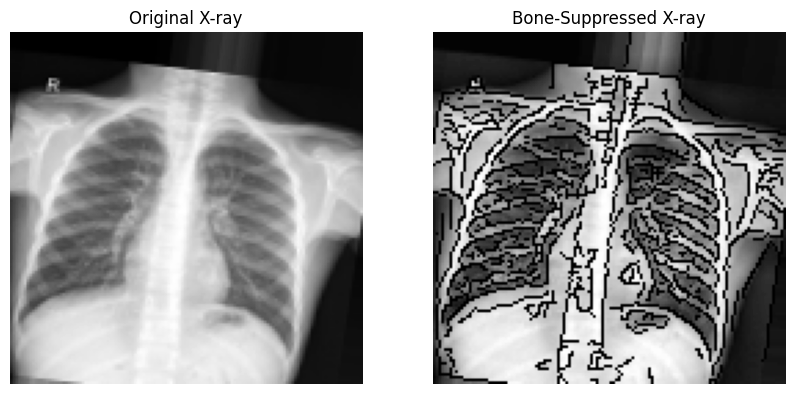

In [7]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Set paths
input_dir = "/kaggle/input/augmented-images"  # Path to augmented images
output_dir = "/kaggle/working/bone_suppressed_xrays"  # Save suppressed images

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Function to perform synthetic bone suppression
def generate_bone_suppressed(img):
    # Apply CLAHE for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_clahe = clahe.apply(img)

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(img_clahe, (5, 5), 0)

    # Detect edges (approximate bones)
    edges = cv2.Canny(img_clahe, 50, 150)

    # Subtract edges from the image (Bone suppression effect)
    bone_suppressed = cv2.subtract(img_clahe, edges)
    
    return bone_suppressed

# Get one sample image
sample_image_name = os.listdir(input_dir)[0]  # Take the first image
sample_image_path = os.path.join(input_dir, sample_image_name)

# Read the sample image in grayscale
sample_image = cv2.imread(sample_image_path, cv2.IMREAD_GRAYSCALE)

# Apply bone suppression
bone_suppressed_sample = generate_bone_suppressed(sample_image)

# Display Original vs Bone-Suppressed Image
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.imshow(sample_image, cmap='gray')
plt.title("Original X-ray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(bone_suppressed_sample, cmap='gray')
plt.title("Bone-Suppressed X-ray")
plt.axis("off")

plt.show()

Processing Image: /kaggle/input/augmented-images/augmented_img_6899.png


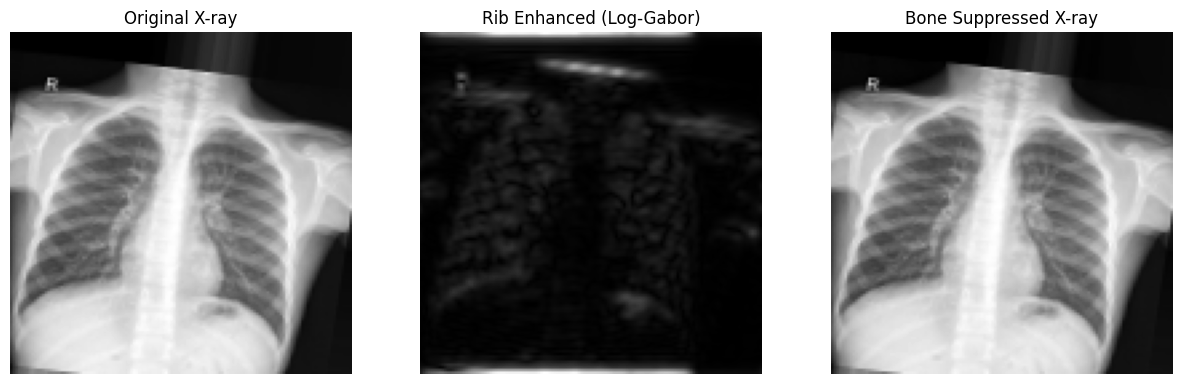

Bone-suppressed image saved at: bone-suppressed-images/bone_suppressed_augmented_img_6899.png


In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.signal import convolve2d
import os

# Load an X-ray image from augmented-images folder
input_folder = "/kaggle/input/augmented-images"  # Change this to your folder path
output_folder = "bone-suppressed-images"
os.makedirs(output_folder, exist_ok=True)

# Get an image file from the folder
image_files = [f for f in os.listdir(input_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
if not image_files:
    raise FileNotFoundError("No images found in 'augmented-images' folder.")
image_path = os.path.join(input_folder, image_files[0])
print(f"Processing Image: {image_path}")

# Load the grayscale X-ray image
xray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# --- Step 1: Apply Log-Gabor Filtering to Enhance Ribs ---
def log_gabor_filter(image, wavelength=30, theta=np.pi/2, sigma=0.5, epsilon=1e-6):
    """Applies a Log-Gabor filter to enhance rib structures."""
    rows, cols = image.shape
    x = np.arange(-cols//2, cols//2)
    y = np.arange(-rows//2, rows//2)
    X, Y = np.meshgrid(x, y)

    # Frequency domain filter
    radius = np.sqrt(X**2 + Y**2)
    radius[radius == 0] = epsilon  # Replace zero values with epsilon to prevent log(0)

    orientation = np.arctan2(Y, X)
    
    # Log-Gabor filter
    gabor_filter = np.exp(-(np.log(radius/wavelength)**2) / (2 * sigma**2)) * np.exp(-((orientation - theta)**2) / (2 * sigma**2))
    
    # Apply filter in frequency domain
    image_fft = np.fft.fftshift(np.fft.fft2(image))
    filtered_fft = image_fft * gabor_filter
    filtered_image = np.abs(np.fft.ifft2(np.fft.ifftshift(filtered_fft)))

    return filtered_image

# Apply Log-Gabor filter
rib_enhanced = log_gabor_filter(xray)

# --- Step 2: Estimate Rib Shadow Intensity using Gaussian Smoothing ---
def estimate_rib_shadow(image, sigma=20):
    """Estimates rib shadow intensity using vertical Gaussian smoothing."""
    return gaussian_filter(image, sigma=[sigma, 0])  # Smooth along vertical axis

rib_shadow = estimate_rib_shadow(rib_enhanced)

# --- Step 3: Subtract Rib Shadows to Suppress Ribs ---
bone_suppressed = xray - rib_shadow
bone_suppressed = np.clip(bone_suppressed, 0, 255)  # Keep valid pixel range

# --- Save and Display the Results ---
output_path = os.path.join(output_folder, "bone_suppressed_" + image_files[0])
cv2.imwrite(output_path, bone_suppressed)

# Plot the images
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(xray, cmap='gray')
ax[0].set_title("Original X-ray")
ax[0].axis("off")

ax[1].imshow(rib_enhanced, cmap='gray')
ax[1].set_title("Rib Enhanced (Log-Gabor)")
ax[1].axis("off")

ax[2].imshow(bone_suppressed, cmap='gray')
ax[2].set_title("Bone Suppressed X-ray")
ax[2].axis("off")

plt.show()

print(f"Bone-suppressed image saved at: {output_path}")


In [11]:
!wget https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/releases/download/latest/cyclegan_chest_xray.pth

--2025-02-11 19:05:45--  https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/releases/download/latest/cyclegan_chest_xray.pth
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-02-11 19:05:46 ERROR 404: Not Found.



### Trying with downloaded pre trained model from github

In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Add, Lambda
import cv2
import matplotlib.pyplot as plt

# Define ResNet-BS architecture
def res_block(x_in, filters, scaling=None):
    x = Conv2D(filters, (3, 3), padding='same', activation='relu')(x_in)
    x = Conv2D(filters, (3, 3), padding='same')(x)
    if scaling:
        x = Lambda(lambda t: t * scaling)(x)
    x = Add()([x_in, x])
    return x

def resnet_bs(num_filters=64, num_res_blocks=16, res_block_scaling=None):
    x_in = Input(shape=(256, 256, 1))
    x = b = Conv2D(num_filters, (3, 3), padding='same')(x_in)
    for i in range(num_res_blocks):
        b = res_block(b, num_filters, res_block_scaling)
    b = Conv2D(num_filters, (3, 3), padding='same')(b)
    x = Add()([x, b])
    x = Conv2D(1, (3, 3), padding='same')(x)
    return Model(x_in, x, name="ResNet-BS")

# Create the model
model = resnet_bs()

# Load pre-trained weights from Kaggle dataset
MODEL_PATH = "/kaggle/input/bone-suppression/tensorflow2/default/1/resnet_bs.h5"
model.load_weights(MODEL_PATH)
print("✅ ResNet-BS model weights loaded successfully!")


✅ ResNet-BS model weights loaded successfully!


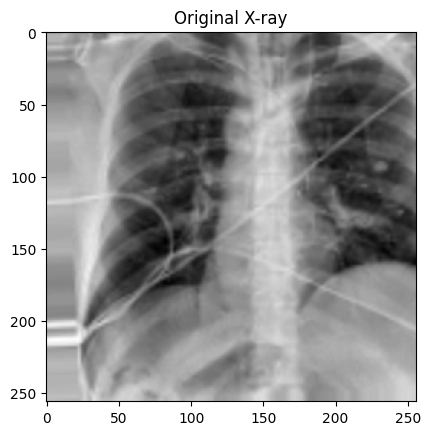

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step


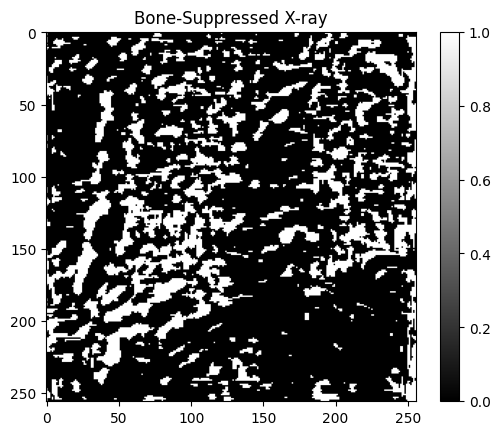

Min value: 0.0, Max value: 1.0


In [31]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from PIL import Image

# Load a sample chest X-ray from the augmented dataset
IMG_PATH = "/kaggle/input/augmented-images/augmented_img_0.png"  # Change if needed
img = Image.open(IMG_PATH).convert("L")  # Convert to grayscale
img = img.resize((256, 256))  # Resize to match model input

# Convert image to array
x = image.img_to_array(img)
x = x.astype("float32") / 255.0  # Normalize
x = np.expand_dims(x, axis=0)  # Add batch dimension

# Display input image
plt.imshow(img, cmap="gray")
plt.title("Original X-ray")
plt.show()

# Load model and predict
model = resnet_bs()  # Initialize model
model.load_weights(MODEL_PATH)  # Load weights
pred = model.predict(x)

# Reshape and clip output image
suppressed_img = np.reshape(pred, (256, 256))
suppressed_img = np.clip(suppressed_img, 0, 1)  # Fix extreme values

# Display suppressed image
plt.imshow(suppressed_img, cmap="gray")
plt.title("Bone-Suppressed X-ray")
plt.colorbar()
plt.show()

# Print min/max values of prediction
print(f"Min value: {suppressed_img.min()}, Max value: {suppressed_img.max()}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


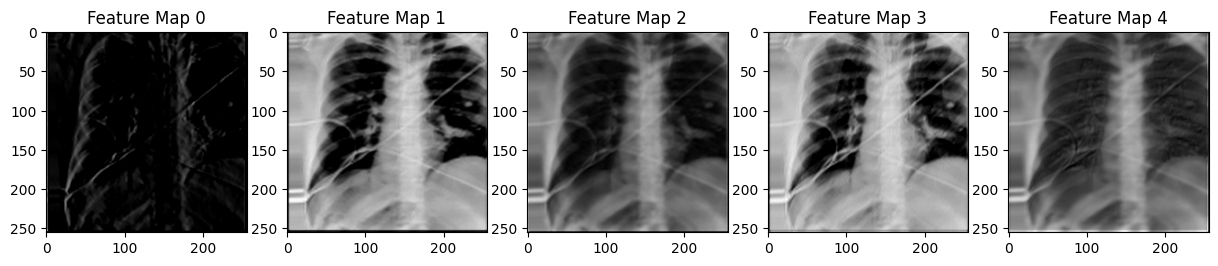

In [32]:
# Define a function to get feature maps from intermediate layers
def get_intermediate_output(model, layer_index, input_img):
    intermediate_model = tf.keras.models.Model(
        inputs=model.input, 
        outputs=model.layers[layer_index].output
    )
    return intermediate_model.predict(input_img)

# Get intermediate feature maps (Change layer index as needed)
feature_map = get_intermediate_output(model, layer_index=5, input_img=x)

# Visualize first few feature maps
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axes[i].imshow(feature_map[0, :, :, i], cmap="gray")
    axes[i].set_title(f"Feature Map {i}")
plt.show()


In [33]:
# Get output from the layer before the final Conv2D layer
intermediate_layer_model = tf.keras.models.Model(
    inputs=model.input, 
    outputs=model.layers[-2].output  # Second-to-last layer
)
intermediate_output = intermediate_layer_model.predict(x)

# Reshape and visualize
intermediate_output_img = np.reshape(intermediate_output, (256, 256))

plt.imshow(intermediate_output_img, cmap="gray")
plt.title("Intermediate Output (Before Final Conv2D)")
plt.colorbar()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


ValueError: cannot reshape array of size 4194304 into shape (256,256)

In [34]:
print(intermediate_output.shape)


(1, 256, 256, 64)


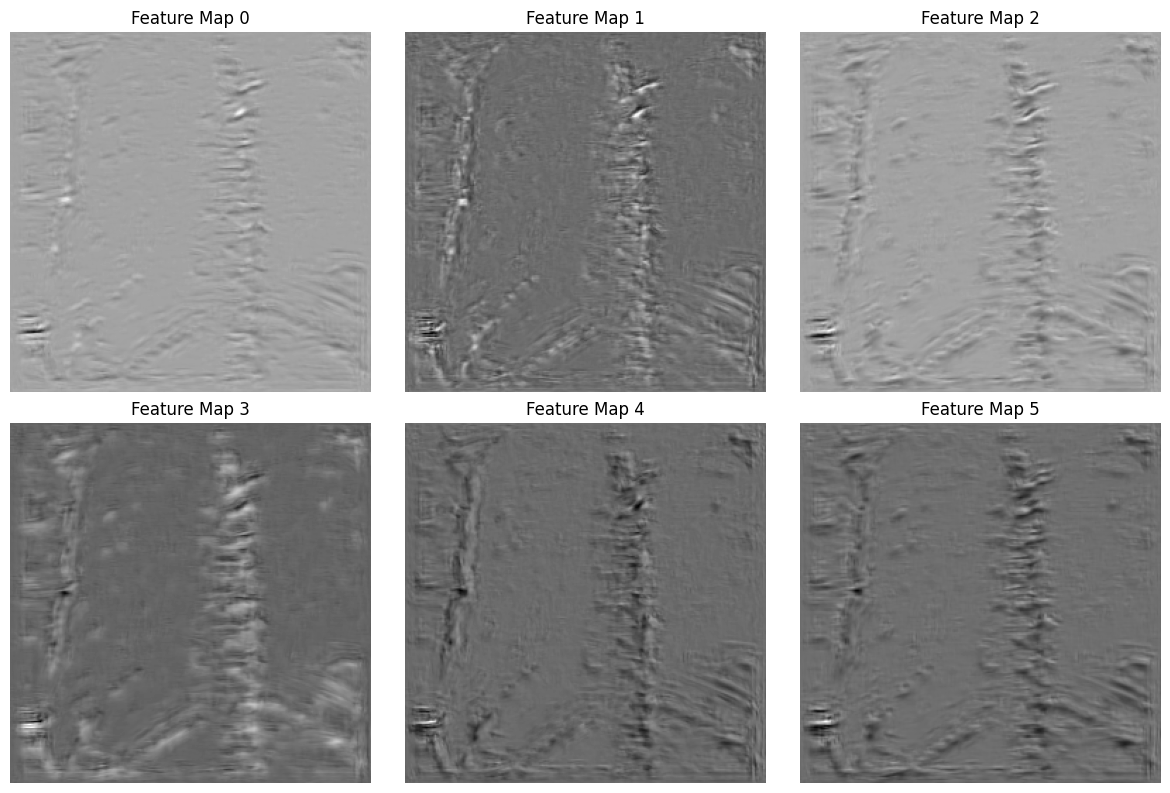

In [35]:
import matplotlib.pyplot as plt

# Extract first sample (since batch size = 1)
feature_maps = intermediate_output[0]  # Shape: (256, 256, 64)

# Plot a few feature maps (e.g., first 6)
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    if i >= feature_maps.shape[-1]:  # Avoid out-of-index error
        break
    ax.imshow(feature_maps[:, :, i], cmap="gray")
    ax.set_title(f"Feature Map {i}")
    ax.axis("off")

plt.tight_layout()
plt.show()


In [36]:
print("Number of Zero Activations:", np.sum(feature_maps == 0))
print("Total Elements:", feature_maps.size)
print("Percentage of Zero Activations:", np.sum(feature_maps == 0) / feature_maps.size * 100)


Number of Zero Activations: 0
Total Elements: 4194304
Percentage of Zero Activations: 0.0


In [37]:
print("Input Min:", x.min(), "Max:", x.max())


Input Min: 0.18431373 Max: 0.85882354


In [38]:
for layer in model.layers:
    print(layer.name, layer.get_weights()[0].shape if layer.get_weights() else "No Weights")


input_layer_8 No Weights
conv2d_280 (3, 3, 1, 64)
conv2d_281 (3, 3, 64, 64)
conv2d_282 (3, 3, 64, 64)
add_136 No Weights
conv2d_283 (3, 3, 64, 64)
conv2d_284 (3, 3, 64, 64)
add_137 No Weights
conv2d_285 (3, 3, 64, 64)
conv2d_286 (3, 3, 64, 64)
add_138 No Weights
conv2d_287 (3, 3, 64, 64)
conv2d_288 (3, 3, 64, 64)
add_139 No Weights
conv2d_289 (3, 3, 64, 64)
conv2d_290 (3, 3, 64, 64)
add_140 No Weights
conv2d_291 (3, 3, 64, 64)
conv2d_292 (3, 3, 64, 64)
add_141 No Weights
conv2d_293 (3, 3, 64, 64)
conv2d_294 (3, 3, 64, 64)
add_142 No Weights
conv2d_295 (3, 3, 64, 64)
conv2d_296 (3, 3, 64, 64)
add_143 No Weights
conv2d_297 (3, 3, 64, 64)
conv2d_298 (3, 3, 64, 64)
add_144 No Weights
conv2d_299 (3, 3, 64, 64)
conv2d_300 (3, 3, 64, 64)
add_145 No Weights
conv2d_301 (3, 3, 64, 64)
conv2d_302 (3, 3, 64, 64)
add_146 No Weights
conv2d_303 (3, 3, 64, 64)
conv2d_304 (3, 3, 64, 64)
add_147 No Weights
conv2d_305 (3, 3, 64, 64)
conv2d_306 (3, 3, 64, 64)
add_148 No Weights
conv2d_307 (3, 3, 64, 64)
c

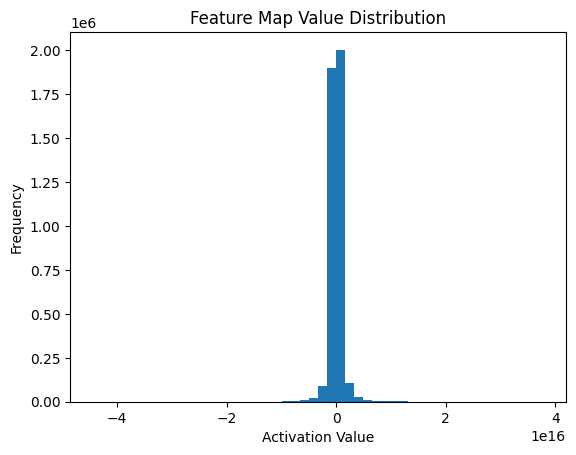

In [39]:
plt.hist(feature_maps.flatten(), bins=50)
plt.title("Feature Map Value Distribution")
plt.xlabel("Activation Value")
plt.ylabel("Frequency")
plt.show()


Feature Maps Shape: (256, 256, 64)


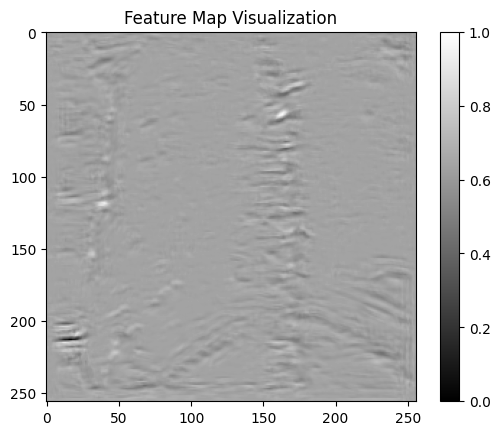

In [43]:
print("Feature Maps Shape:", feature_maps.shape)

# Automatically adjust indexing
if len(feature_maps.shape) == 4:
    fm = feature_maps[0, :, :, 0]  # First feature map
elif len(feature_maps.shape) == 3:
    fm = feature_maps[:, :, 0]  # First feature map (if batch axis is removed)

# Normalize for better visualization
fm = (fm - np.min(fm)) / (np.max(fm) - np.min(fm) + 1e-10)

# Display feature map
plt.imshow(fm, cmap="gray")
plt.colorbar()
plt.title("Feature Map Visualization")
plt.show()


#### Trying with GAN

In [74]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm

# Path to JSRT dataset (Update paths accordingly)
JSRT_PATH = "/kaggle/input/all247images/images/images"
SAVE_PATH = "/kaggle/working/"

# Ensure save directory exists
os.makedirs(SAVE_PATH, exist_ok=True)

# Load and preprocess images
image_paths = glob(os.path.join(JSRT_PATH, "*.png"))  # Modify if JPG
for img_path in tqdm(image_paths):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale
    img = cv2.resize(img, (256, 256))  # Resize to 256x256
    save_name = os.path.join(SAVE_PATH, os.path.basename(img_path))
    cv2.imwrite(save_name, img)


100%|██████████| 247/247 [00:13<00:00, 18.81it/s]


In [10]:
def normalize_image(img):
    img = img / 127.5 - 1  # Normalize to [-1, 1]
    return img

In [73]:
import os
import cv2
import numpy as np
from glob import glob

def load_and_preprocess_images(folder_xrays, folder_bone_suppressed, img_size=(256, 256)):
    """
    Load and resize paired X-ray and bone-suppressed images, handling missing files.
    """
    xray_paths = sorted(glob(os.path.join(folder_xrays, "*.png")))  # Use "*.png" for all images
    bone_paths = sorted(glob(os.path.join(folder_bone_suppressed, "*.png")))  

    xray_images, bone_images = [], []

    if len(xray_paths) == 0 or len(bone_paths) == 0:
        print("Error: No images found in one or both folders. Check file paths.")
        return np.array([]), np.array([])

    for xray_path, bone_path in zip(xray_paths, bone_paths):
        xray = cv2.imread(xray_path, cv2.IMREAD_GRAYSCALE)
        bone = cv2.imread(bone_path, cv2.IMREAD_GRAYSCALE)

        # Check if images were loaded
        if xray is None or bone is None:
            print(f"Skipping: {xray_path} or {bone_path} (File not found or unreadable)")
            continue  

        # Resize & normalize
        xray = cv2.resize(xray, img_size) / 255.0  
        bone = cv2.resize(bone, img_size) / 255.0  

        xray_images.append(np.expand_dims(xray, axis=-1))
        bone_images.append(np.expand_dims(bone, axis=-1))

    xray_images, bone_images = np.array(xray_images), np.array(bone_images)

    print(f"Loaded {len(xray_images)} valid image pairs")
    return xray_images, bone_images

# Run the function with correct paths
xray_images, bone_images = load_and_preprocess_images(
    "/kaggle/input/augmented-images", 
    "/kaggle/input/all247images/images/images", 
    img_size=(256, 256)
)

print("X-ray shape:", xray_images.shape, "Bone-suppressed shape:", bone_images.shape)


Loaded 247 valid image pairs
X-ray shape: (247, 256, 256, 1) Bone-suppressed shape: (247, 256, 256, 1)


In [8]:
!pip install tensorflow-addons


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 11.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.
ydata-profiling 4.12.1 requires typeguard<5,>=3, but you have typeguard 2.13.3 which is incompatible.


In [62]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Dropout, Concatenate
import numpy as np
import matplotlib.pyplot as plt


In [11]:
import tensorflow as tf
print(tf.__version__)  # Should print 2.17.1


2.17.1


In [63]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = keras.Sequential()
    
    result.add(Conv2D(filters, size, strides=2, padding='same',
                      kernel_initializer=initializer, use_bias=False))
    
    if apply_batchnorm:
        result.add(BatchNormalization())
    
    result.add(LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = keras.Sequential()
    
    result.add(Conv2DTranspose(filters, size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False))
    
    result.add(BatchNormalization())
    
    if apply_dropout:
        result.add(Dropout(0.5))
    
    result.add(LeakyReLU())

    return result

def Generator():
    inputs = keras.layers.Input(shape=[256, 256, 1])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (128, 128, 64)
        downsample(128, 4),  # (64, 64, 128)
        downsample(256, 4),  # (32, 32, 256)
        downsample(512, 4),  # (16, 16, 512)
        downsample(512, 4),  # (8, 8, 512)
        downsample(512, 4),  # (4, 4, 512)
        downsample(512, 4),  # (2, 2, 512)
        downsample(512, 4),  # (1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (2, 2, 512)
        upsample(512, 4, apply_dropout=True),  # (4, 4, 512)
        upsample(512, 4, apply_dropout=True),  # (8, 8, 512)
        upsample(512, 4),  # (16, 16, 512)
        upsample(256, 4),  # (32, 32, 256)
        upsample(128, 4),  # (64, 64, 128)
        upsample(64, 4),  # (128, 128, 64)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = Conv2DTranspose(1, 4, strides=2, padding='same',
                           kernel_initializer=initializer, activation='tanh')  # Output layer

    x = inputs
    skips = []
    
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

generator = Generator()
generator.summary()


Model: "functional_552"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19            │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_18             │ (None, 128, 128, 64)   │          1,024 │ input_layer_19[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_19             │ (None, 64, 64, 128)    │        131,584 │ sequential_18[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_20             │ (None, 32, 32, 256)    │        525,312 │ sequential_19[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_21             │ (None, 16, 16, 512)    │      2,099,200 │ sequential_20[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_22             │ (None, 8, 8, 512)      │      4,196,352 │ sequential_21[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_23             │ (None, 4, 4, 512)      │      4,196,352 │ sequential_22[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_24             │ (None, 2, 2, 512)      │      4,196,352 │ sequential_23[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_25             │ (None, 1, 1, 512)      │      4,196,352 │ sequential_24[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_26             │ (None, 2, 2, 512)      │      4,196,352 │ sequential_25[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_8             │ (None, 2, 2, 1024)     │              0 │ sequential_26[0][0],   │
│ (Concatenate)             │                        │                │ sequential_24[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_27             │ (None, 4, 4, 512)      │      8,390,656 │ concatenate_8[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_9             │ (None, 4, 4, 1024)     │              0 │ sequential_27[0][0],   │
│ (Concatenate)             │                        │                │ sequential_23[0][0]    │
├──────────────────────

 Total params: 54,419,713 (207.59 MB)

 Trainable params: 54,408,833 (207.55 MB)

 Non-trainable params: 10,880 (42.50 KB)

In [64]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = keras.layers.Input(shape=[256, 256, 1], name='input_image')
    tar = keras.layers.Input(shape=[256, 256, 1], name='target_image')

    x = Concatenate()([inp, tar])  # Stack the input and target images along the channel axis

    down1 = downsample(64, 4, apply_batchnorm=False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = keras.layers.ZeroPadding2D()(down3)
    conv = Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)

    batchnorm1 = BatchNormalization()(conv)
    leaky_relu = LeakyReLU()(batchnorm1)

    zero_pad2 = keras.layers.ZeroPadding2D()(leaky_relu)
    last = Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)

    return keras.Model(inputs=[inp, tar], outputs=last)

discriminator = Discriminator()
discriminator.summary()


Model: "functional_556"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_image (InputLayer) │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_15            │ (None, 256, 256, 2)    │              0 │ input_image[0][0],     │
│ (Concatenate)             │                        │                │ target_image[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_33             │ (None, 128, 128, 64)   │          2,048 │ concatenate_15[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_34             │ (None, 64, 64, 128)    │        131,584 │ sequential_33[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_35             │ (None, 32, 32, 256)    │        525,312 │ sequential_34[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, 34, 34, 256)    │              0 │ sequential_35[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 31, 31, 512)    │      2,097,152 │ zero_padding2d_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_33    │ (None, 31, 31, 512)    │          2,048 │ conv2d_24[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_37            │ (None, 31, 31, 512)    │              0 │ batch_normalization_3… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_3          │ (None, 33, 33, 512)    │              0 │ leaky_re_lu_37[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 30, 30, 1)      │          8,193 │ zero_padding2d_3[0][0] │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,766,337 (10.55 MB)

 Trainable params: 2,764,545 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [65]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    return real_loss + generated_loss

LAMBDA = 100  # Weight for L1 loss

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    
    # Convert target to float32 to match gen_output
    target = tf.cast(target, tf.float32)
    
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    
    return total_gen_loss, gan_loss, l1_loss

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [57]:
import datetime
import tensorflow as tf

@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        
        # Ensure target is float32 to match gen_output
        target = tf.cast(target, tf.float32)
        
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        # Compute generator and discriminator losses
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    # Compute gradients and apply updates
    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss



In [58]:
import time

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for input_image, target in dataset:
            gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss = train_step(input_image, target)

        print(f'Epoch {epoch + 1}: Gen Loss: {gen_total_loss.numpy():.4f}, Disc Loss: {disc_loss.numpy():.4f}, Time: {time.time() - start:.2f} sec')

        if (epoch + 1) % 10 == 0:  # Save the model every 10 epochs
            generator.save("generator_cGAN.h5")
            discriminator.save("discriminator_cGAN.h5")
            print(f"Saved models at Epoch {epoch + 1}")

    print("Training completed!")


In [59]:
BATCH_SIZE = 8
BUFFER_SIZE = 100

train_dataset = tf.data.Dataset.from_tensor_slices((xray_images, bone_images))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [29]:
EPOCHS = 100
train(train_dataset, EPOCHS)


Epoch 1: Gen Loss: 21.9770, Disc Loss: 0.3852, Time: 23.40 sec
Epoch 2: Gen Loss: 12.9088, Disc Loss: 1.3576, Time: 11.11 sec
Epoch 3: Gen Loss: 13.9977, Disc Loss: 1.3491, Time: 11.32 sec
Epoch 4: Gen Loss: 12.0241, Disc Loss: 1.3311, Time: 11.63 sec
Epoch 5: Gen Loss: 12.0894, Disc Loss: 1.1950, Time: 11.53 sec
Epoch 6: Gen Loss: 11.7881, Disc Loss: 1.3081, Time: 11.24 sec
Epoch 7: Gen Loss: 10.9654, Disc Loss: 1.4632, Time: 11.07 sec
Epoch 8: Gen Loss: 15.9748, Disc Loss: 1.0714, Time: 11.01 sec
Epoch 9: Gen Loss: 12.1619, Disc Loss: 0.9403, Time: 11.08 sec
Epoch 10: Gen Loss: 11.8009, Disc Loss: 1.1204, Time: 11.25 sec
Saved models at Epoch 10
Epoch 11: Gen Loss: 11.0554, Disc Loss: 1.5168, Time: 11.35 sec
Epoch 12: Gen Loss: 10.2787, Disc Loss: 1.5157, Time: 11.29 sec
Epoch 13: Gen Loss: 9.9573, Disc Loss: 0.9259, Time: 11.25 sec
Epoch 14: Gen Loss: 9.8099, Disc Loss: 1.5449, Time: 11.18 sec
Epoch 15: Gen Loss: 9.3844, Disc Loss: 0.9815, Time: 11.09 sec
Epoch 16: Gen Loss: 9.6952,

In [30]:
generator.save("generator_cGAN.h5")
print("Generator model saved successfully!")


Generator model saved successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


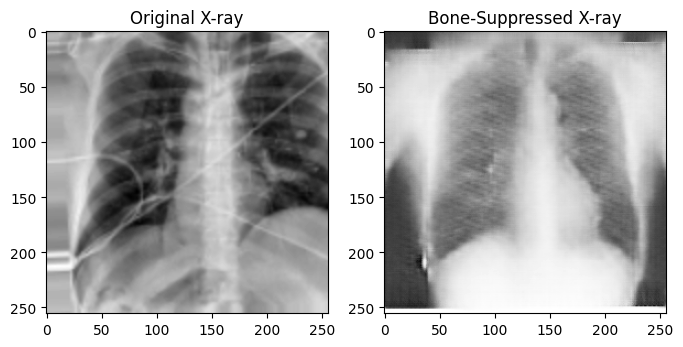

In [34]:
# Load the trained generator
generator = tf.keras.models.load_model("generator_cGAN.h5", compile=False)

# Function to generate bone-suppressed images
def generate_bone_suppressed(xray_image):
    xray_image = np.expand_dims(xray_image, axis=0)  # Add batch dimension
    generated_image = generator.predict(xray_image)[0]  # Remove batch dimension
    return generated_image

# Example: Generate a bone-suppressed X-ray from the first image in the dataset
sample_xray = xray_images[0]
bone_suppressed_output = generate_bone_suppressed(sample_xray)

# Show the result
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original X-ray")
plt.imshow(sample_xray.squeeze(), cmap="gray")

plt.subplot(1, 2, 2)
plt.title("Bone-Suppressed X-ray")
plt.imshow(bone_suppressed_output.squeeze(), cmap="gray")

plt.show()


### Trying with the masks

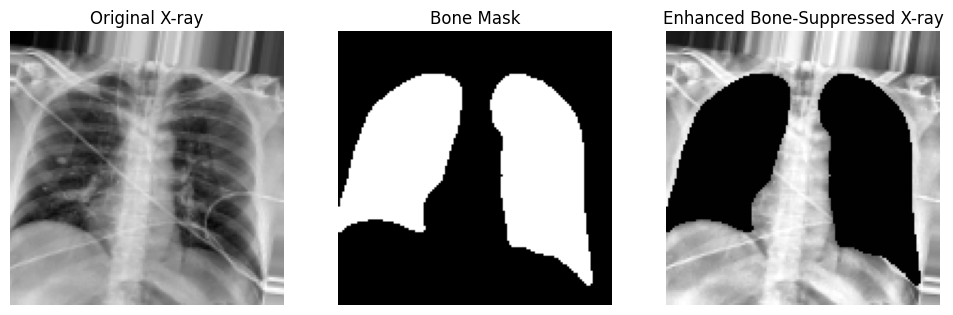

In [78]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Function to apply bone suppression using mask
def suppress_bones(xray_image, bone_mask):
    """
    Suppresses bones from an X-ray image using a given bone segmentation mask and applies CLAHE.
    
    Parameters:
        xray_image (numpy array): Input X-ray image (grayscale).
        bone_mask (numpy array): Corresponding bone mask (binary mask).
    
    Returns:
        numpy array: Bone-suppressed X-ray image with CLAHE applied.
    """
    # Ensure both images are grayscale
    xray_image = cv2.cvtColor(xray_image, cv2.COLOR_BGR2GRAY) if len(xray_image.shape) == 3 else xray_image
    bone_mask = cv2.cvtColor(bone_mask, cv2.COLOR_BGR2GRAY) if len(bone_mask.shape) == 3 else bone_mask

    # Normalize both images to [0, 1] for proper multiplication
    xray_image = xray_image.astype(np.float32) / 255.0
    bone_mask = bone_mask.astype(np.float32) / 255.0

    # Invert the bone mask (1 - mask)
    lung_mask = 1 - bone_mask

    # Perform AND operation to remove bone structures
    bone_suppressed_xray = xray_image * lung_mask

    # Convert back to 8-bit image (0-255) for CLAHE processing
    bone_suppressed_xray = (bone_suppressed_xray * 255).astype(np.uint8)

    # Apply CLAHE for better contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced_xray = clahe.apply(bone_suppressed_xray)

    return enhanced_xray

# Load sample X-ray and bone mask (Replace these paths with actual images)
xray_path = "/kaggle/input/augmented-images/augmented_img_1.png"  # Replace with your X-ray image
bone_mask_path = "/kaggle/input/segmented-images/segmented_images_0002.png"  # Replace with your bone segmentation mask

# Read images
xray_image = cv2.imread(xray_path, cv2.IMREAD_GRAYSCALE)
bone_mask = cv2.imread(bone_mask_path, cv2.IMREAD_GRAYSCALE)

# Resize images to match dimensions if needed
bone_mask = cv2.resize(bone_mask, (xray_image.shape[1], xray_image.shape[0]))

# Apply bone suppression and CLAHE enhancement
bone_suppressed_xray = suppress_bones(xray_image, bone_mask)

# Display results
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Original X-ray")
plt.imshow(xray_image, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Bone Mask")
plt.imshow(bone_mask, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Enhanced Bone-Suppressed X-ray")
plt.imshow(bone_suppressed_xray, cmap="gray")
plt.axis("off")

plt.show()


### Trying again with Image processing

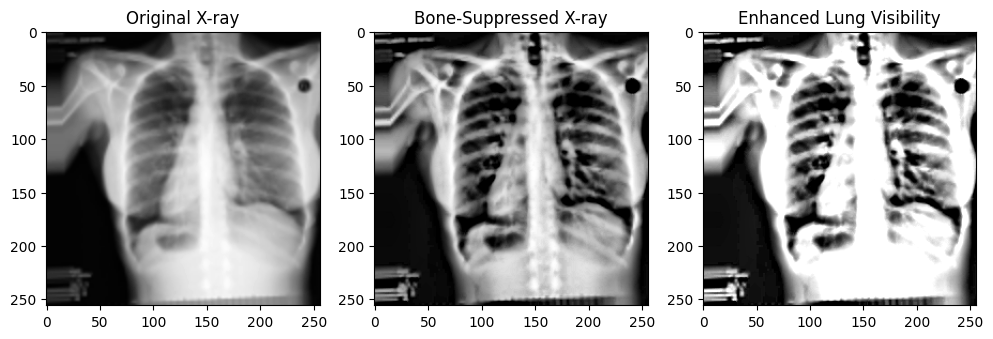

In [85]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load a sample X-ray (Ensure it's loaded as a grayscale image)
sample_xray = xray_images[2]  # Ensure this is a valid grayscale X-ray

# Normalize image to range [0, 255]
xray = cv2.normalize(sample_xray, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# 🔹 **1️⃣ Apply Adaptive Histogram Equalization (CLAHE)**
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
clahe_xray = clahe.apply(xray)

# 🔹 **2️⃣ Morphological Closing (Suppress Bone Structures)**
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
morph_xray = cv2.morphologyEx(clahe_xray, cv2.MORPH_CLOSE, kernel)

# 🔹 **3️⃣ Compute Bone Mask using Absolute Difference**
bone_mask = cv2.absdiff(clahe_xray, morph_xray)

# 🔹 **4️⃣ Create Soft Tissue Mask**
soft_tissue_mask = cv2.subtract(clahe_xray, bone_mask)

# 🔹 **5️⃣ High-Pass Filtering to Preserve Fine Lung Structures**
blurred_xray = cv2.GaussianBlur(soft_tissue_mask, (5, 5), 0)
high_pass = cv2.subtract(soft_tissue_mask, blurred_xray)
enhanced_lung_xray = cv2.addWeighted(soft_tissue_mask, 1.5, high_pass, 0.7, 0)

# 🔹 **6️⃣ Display Results**
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title("Original X-ray")
plt.imshow(xray, cmap="gray")

plt.subplot(1, 3, 2)
plt.title("Bone-Suppressed X-ray")
plt.imshow(soft_tissue_mask, cmap="gray")

plt.subplot(1, 3, 3)
plt.title("Enhanced Lung Visibility")
plt.imshow(enhanced_lung_xray, cmap="gray")

plt.show()


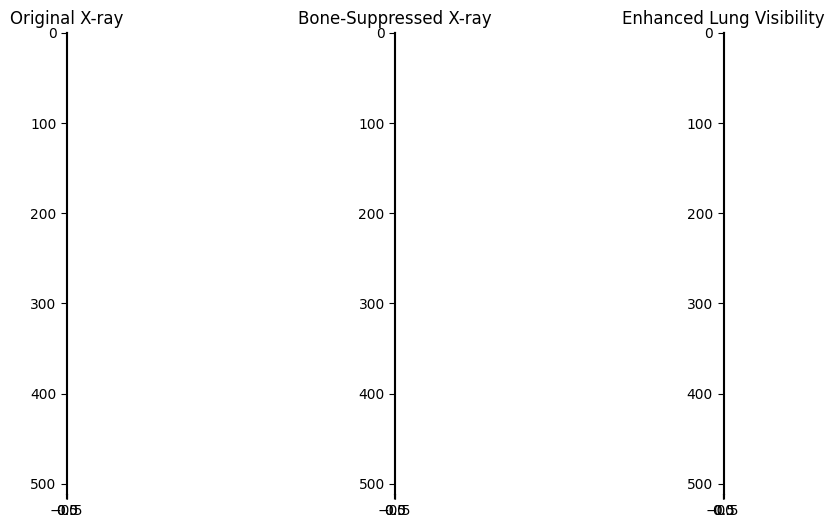

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load a sample X-ray (Ensure it's a valid grayscale X-ray)
sample_xray = xray_image[1]  # Ensure this is correctly loaded

# Normalize image to range [0, 255]
xray = cv2.normalize(sample_xray, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# 🔹 **1️⃣ Apply a Strong Gaussian Blur to Extract Soft Tissues**
soft_tissue_xray = cv2.GaussianBlur(xray, (25, 25), 0)  # Higher kernel size for stronger suppression

# 🔹 **2️⃣ Morphological Closing for Bone Suppression**
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20, 20))  # Larger kernel size for bone features
morph_xray = cv2.morphologyEx(xray, cv2.MORPH_CLOSE, kernel)

# 🔹 **3️⃣ Compute Bone Mask**
bone_mask = cv2.absdiff(xray, morph_xray)

# 🔹 **4️⃣ Remove Bone Structures from the Original X-ray**
bone_suppressed_xray = cv2.subtract(xray, bone_mask)

# 🔹 **5️⃣ Adaptive Contrast Enhancement for Lung Visibility**
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
enhanced_lung_xray = clahe.apply(bone_suppressed_xray)

# 🔹 **6️⃣ Display Results**
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title("Original X-ray")
plt.imshow(xray, cmap="gray")

plt.subplot(1, 3, 2)
plt.title("Bone-Suppressed X-ray")
plt.imshow(bone_suppressed_xray, cmap="gray")

plt.subplot(1, 3, 3)
plt.title("Enhanced Lung Visibility")
plt.imshow(enhanced_lung_xray, cmap="gray")

plt.show()


### Trying with Convolution Neural Filters

In [4]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Load X-ray image (Grayscale)
xray_image = cv2.imread("/kaggle/input/augmented-images/augmented_img_0.png", cv2.IMREAD_GRAYSCALE)
xray_image = cv2.resize(xray_image, (512, 512))  # Resize for consistency
xray_image = xray_image.astype(np.float32) / 255.0  # Normalize to [0,1]

# Function to extract 31x31 patches centered at each pixel
def extract_patches(image, patch_size=31):
    h, w = image.shape
    pad = patch_size // 2
    padded_image = np.pad(image, pad, mode='reflect')  # Mirror padding
    patches = np.zeros((h, w, patch_size, patch_size))

    for i in range(h):
        for j in range(w):
            patches[i, j] = padded_image[i:i+patch_size, j:j+patch_size]
    
    return patches

# Extract patches from X-ray image
patches = extract_patches(xray_image)


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input

# Define the CNF model
def build_cnf_model(input_shape=(31, 31, 1)):
    model = Sequential([
        Input(shape=input_shape),  # Explicit Input layer
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),

        Flatten(),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1, activation='linear')  # Predict bone component value
    ])
    
    return model

# Build and compile model
cnf_model = build_cnf_model()
cnf_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse")

# Display model architecture
cnf_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 31, 31, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 31, 31, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 15, 15, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 15, 15, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 7, 7, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │       1,605,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,925,345 (7.34 MB)

 Trainable params: 1,925,345 (7.34 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Assume we have precomputed bone-extracted images for training
# (For real implementation, use paired pseudo-X-ray and bone-extracted images)

# Example training data (Placeholder)
X_train = patches.reshape(-1, 31, 31, 1)  # Input patches
Y_train = np.random.rand(X_train.shape[0], 1)  # Dummy bone component values

# Train the model
cnf_model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split=0.1)


Epoch 1/10
7373/7373 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - loss: 0.0836 - val_loss: 0.0835
Epoch 2/10
7373/7373 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - loss: 0.0833 - val_loss: 0.0837
Epoch 3/10
7373/7373 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - loss: 0.0834 - val_loss: 0.0835
Epoch 4/10
7373/7373 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - loss: 0.0838 - val_loss: 0.0835
Epoch 5/10
7373/7373 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - loss: 0.0834 - val_loss: 0.0839
Epoch 6/10
7373/7373 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - loss: 0.0835 - val_loss: 0.0836
Epoch 7/10
7373/7373 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - loss: 0.0835 - val_loss: 0.0836
Epoch 8/10
7373/7373 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - loss: 0.0836 - val_loss: 0.0835
Epoch 9/10
7373/7373 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - loss: 0.0836 - val_loss: 0.0840
Epoch 10/10
7373/7373 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - loss: 0.0833 - val_loss: 0.0835


### In this step it ran infinitely so I stopped it.

In [ ]:
# Function to generate bone-extracted image
def generate_bone_extracted(cnf_model, xray_image):
    patches = extract_patches(xray_image)
    h, w = xray_image.shape

    bone_extracted = np.zeros((h, w))

    for i in range(h):
        for j in range(w):
            patch = patches[i, j].reshape(1, 31, 31, 1)  # Reshape for CNN input
            bone_extracted[i, j] = cnf_model.predict(patch)[0, 0]  # Predict bone value

    return bone_extracted

# Generate bone-extracted image
bone_extracted_image = generate_bone_extracted(cnf_model, xray_image)

# Bone-suppressed image
bone_suppressed_image = xray_image - bone_extracted_image

# Normalize for visualization
bone_suppressed_image = cv2.normalize(bone_suppressed_image, None, 0, 255, cv2.NORM_MINMAX)

# Show images
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title("Original X-ray")
plt.imshow(xray_image, cmap="gray")

plt.subplot(1, 3, 2)
plt.title("Bone-Extracted Image")
plt.imshow(bone_extracted_image, cmap="gray")

plt.subplot(1, 3, 3)
plt.title("Bone-Suppressed X-ray")
plt.imshow(bone_suppressed_image, cmap="gray")

plt.show()


### Trying IP with different parameters

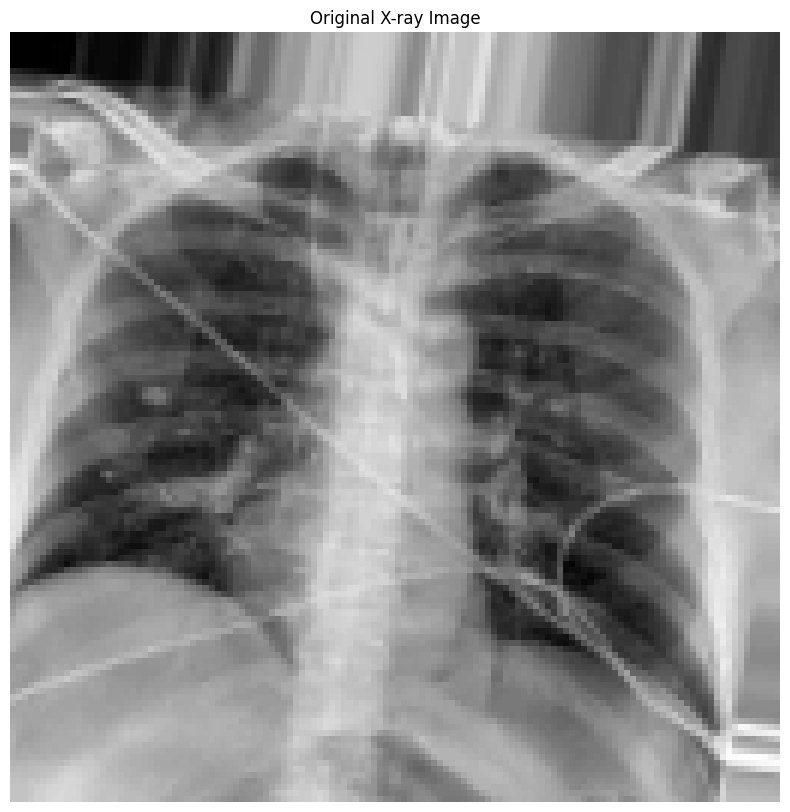

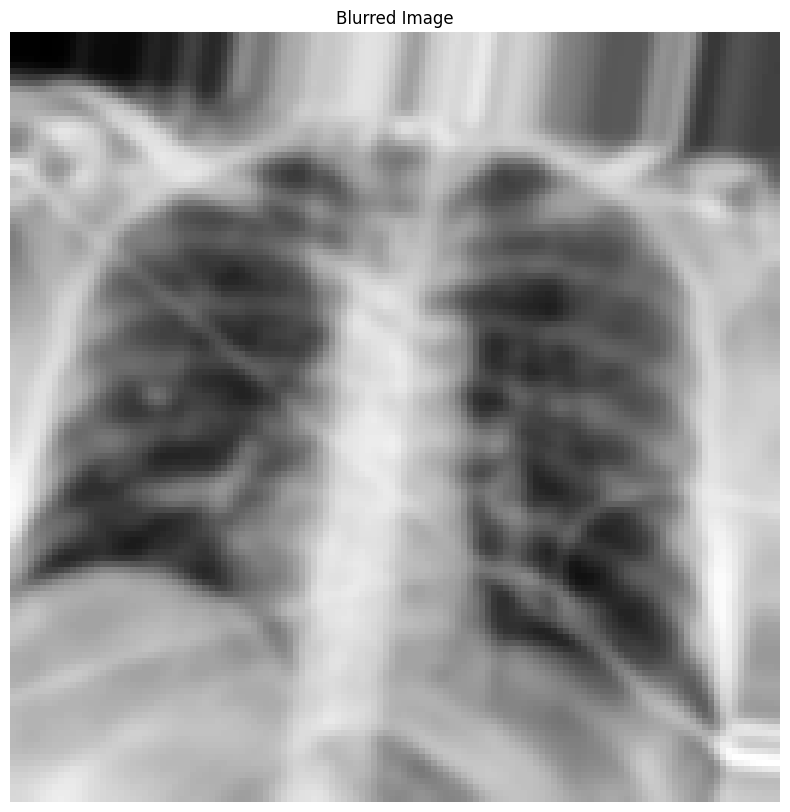

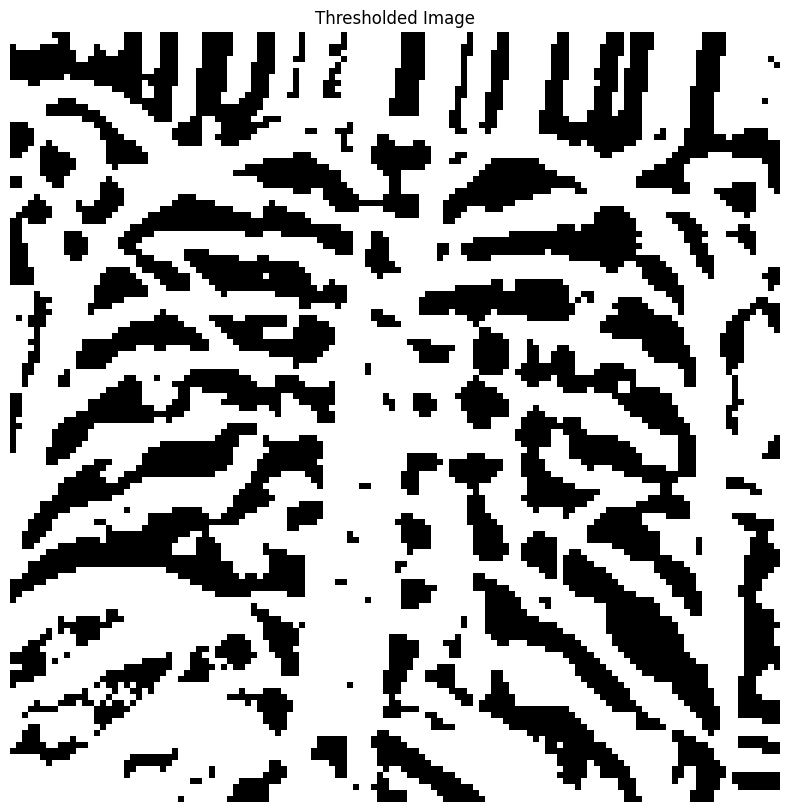

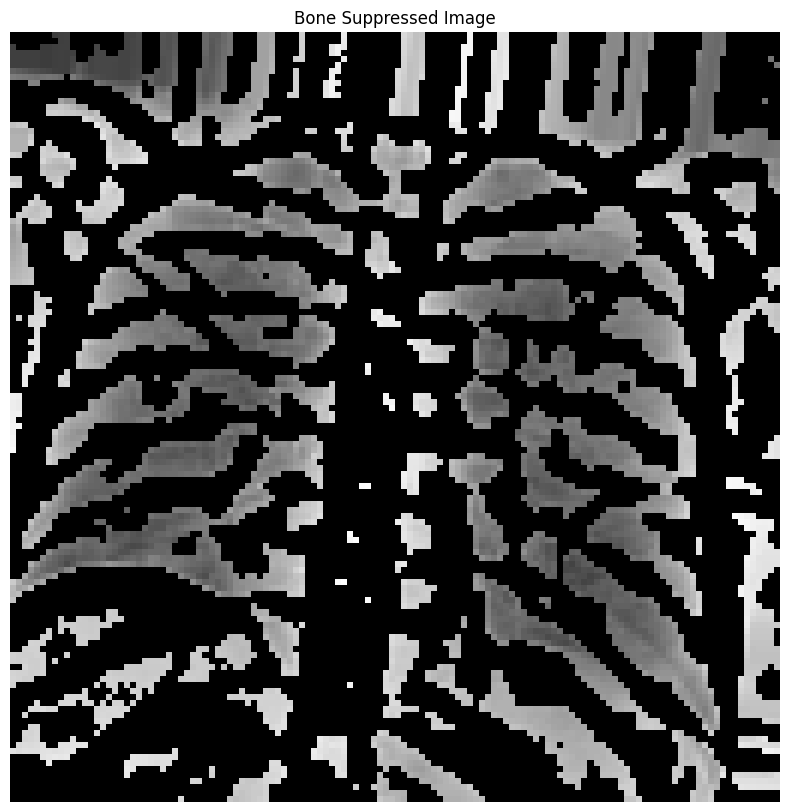

Bone-suppressed image saved to /kaggle/working/bone_suppressed_image.png


In [2]:
# Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the X-ray image
image_path = '/kaggle/input/augmented-images/augmented_img_1.png'  # Update this path to your image location
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Display the original image
plt.figure(figsize=(10, 10))
plt.title("Original X-ray Image")
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

# Step 2: Apply Gaussian Blur
blurred = cv2.GaussianBlur(image, (5, 5), 0)

# Display the blurred image
plt.figure(figsize=(10, 10))
plt.title("Blurred Image")
plt.imshow(blurred, cmap='gray')
plt.axis('off')
plt.show()

# Step 3: Apply Adaptive Thresholding
thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

# Display the thresholded image
plt.figure(figsize=(10, 10))
plt.title("Thresholded Image")
plt.imshow(thresh, cmap='gray')
plt.axis('off')
plt.show()

# Step 4: Subtract the Thresholded Image from the Original
bone_suppressed = cv2.subtract(image, thresh)

# Display the bone-suppressed image
plt.figure(figsize=(10, 10))
plt.title("Bone Suppressed Image")
plt.imshow(bone_suppressed, cmap='gray')
plt.axis('off')
plt.show()

# Step 5: Save the Result
output_path = '/kaggle/working/bone_suppressed_image.png'  # Save in the working directory
cv2.imwrite(output_path, bone_suppressed)

print(f"Bone-suppressed image saved to {output_path}")